<a href="https://colab.research.google.com/github/Bhanu-py/Sequential-Learning-NLP-BERT/blob/main/notebookba8394b608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install transformers

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# import tensorflow_models as tfm
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.utils import pad_sequences
from keras.utils import to_categorical
import keras
import time
import datetime

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 500)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.2 MB/s 
     |████████████████████████████████| 7.6 MB 38.2 MB/s 
     |████████████████████████████████| 182 kB 77.7 MB/s 


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# /content/model_save/pytorch_model.bin

Mounted at /content/drive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
traindf = pd.read_csv('/content/drive/MyDrive/train.csv')
traindf

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [ ]:
categories = ['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal']
traindf['labels'] = traindf.discourse_type.astype('category').cat.codes
traindf


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,4
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,5
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,3
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,3
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,0
...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,3
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,3
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,5
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,3


In [ ]:
sentences = traindf['discourse_text'].values
labels = traindf['labels'].values


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.
Tokenized:  ['modern', 'humans', 'today', 'are', 'always', 'on', 'their', 'phone', '.', 'they', 'are', 'always', 'on', 'their', 'phone', 'more', 'than', '5', 'hours', 'a', 'day', 'no', 'stop', '.', 'all', 'they', 'do', 'is', 'text', 'back', 'and', 'forward', 'and', 'just', 'have', 'group', 'chat', '##s', 'on', 'social', 'media', '.', 'they', 'even', 'do', 'it', 'while', 'driving', '.']
Token IDs:  [2715, 4286, 2651, 2024, 2467, 2006, 2037, 3042, 1012, 2027, 2024, 2467, 2006, 2037, 3042, 2062, 2084, 1019, 2847, 1037, 2154, 2053, 2644, 1012, 2035, 2027, 2079, 2003, 3793, 2067, 1998, 2830, 1998, 2074, 2031, 2177, 11834, 2015, 2006, 2591, 2865, 1012, 2027, 2130, 2079, 2009, 2096, 4439, 1012]


In [ ]:
traindf['discourse_type'].astype('category').cat.categories

Index(['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal'], dtype='object')

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm.tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'

        # This function also supports truncation and conversion
        # to pytorch tensors, but we need to do padding, so we
        # can't use these features :( .
#         max_length=512,          # Truncate all sentences.
#         truncation=True
        # return_tensors = 'pt',     # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


 27%|██▋       | 38452/144293 [00:48<02:13, 790.23it/s]


KeyboardInterrupt: ignored

In [ ]:
sent_len = pd.Series([len(i.split(' ')) for i in traindf['discourse_text']])
print(sent_len.mean())
print(sent_len.median())

In [ ]:
# pd.Series([len(i.split(' ')) for i in traindf['discourse_text']]).hist(bins = 150)
sns.distplot(sent_len, kde=True, rug=True)
plt.axvline(np.median(sent_len),color='b', linestyle='--')
plt.axvline(np.mean(sent_len),color='green', linestyle='--')
# plt.axvline(np.mode(sent_len),color='r', linestyle='--')
plt.show()

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

In [ ]:
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 80

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')
print(input_ids[0])

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in tqdm.tqdm(input_ids):
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)


In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

train_labels = to_categorical(list(train_labels))
validation_labels = to_categorical(list(validation_labels))



# train_labels.shape
train_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

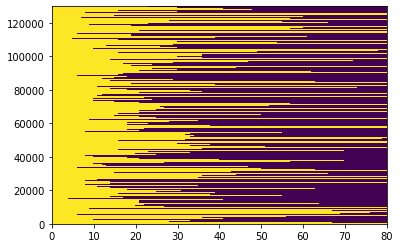

In [ ]:
plt.pcolormesh(train_masks)


In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels, train_masks))
valid = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels, validation_masks))

In [ ]:
next(iter(train))

(<tf.Tensor: shape=(80,), dtype=int64, numpy=
 array([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,
         2138,  1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022,
        27199,  2063,  1997,  1996,  2163,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)>,
 <tf.Tensor: shape=(80,), dtype=int64, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 

In [ ]:
# #  The DataLoader needs to know our batch size for training, so we specify it
# # here.
# # For fine-tuning BERT on a specific task, the authors recommend a batch size of
# # 16 or 32.

batch_size = 32

# # Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# # Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
next(iter(validation_dataloader))

[tensor([[  101, 17174,  1024,  ...,     0,     0,     0],
         [  101,  2029,  2003,  ...,  2027,  2031,  2000],
         [  101,  1996,  2832,  ...,     0,     0,     0],
         ...,
         [  101,  1045,  2228,  ...,     0,     0,     0],
         [  101,  1999,  7091,  ...,  1010,  1996,  2227],
         [  101,  2748,  1045,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 

In [ ]:
# import json

# bert_config_file = os.path.join("bert_config.json")
# config_dict = {'attention_probs_dropout_prob': 0.1,
#  'hidden_act': 'gelu',
#  'hidden_dropout_prob': 0.1,
#  'hidden_size': 768,
#  'initializer_range': 0.02,
#  'intermediate_size': 3072,
#  'max_position_embeddings': 512,
#  'num_attention_heads': 12,
#  'num_hidden_layers': 12,
#  'type_vocab_size': 2,
#  'vocab_size': 30522}
# config_dict

In [ ]:
# from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-cased", num_classes=7)

In [ ]:
# from transformers import TFBertForSequenceClassification

# model = TFBertForSequenceClassification(config)
# # config.num_labels = 7
# config

In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# model([[train., attention_mask]])

In [ ]:
# model.fit(train, validation_data=valid, epochs=4)

In [ ]:
# labels = torch.tensor([1]).unsqueeze(0)
# labels

In [ ]:
#  Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--7for Multi-class classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
#  Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                  )


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# # Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(logits, labels):
  regular_list = [list(np.argmax(i, axis=1)) for i in np.array(logits)]
  pred = [item for sublist in regular_list for item in sublist]
  regular_label_list = [list(np.argmax(i, axis=1)) for i in np.array(labels)]
  labels_flat = [item for sublist in regular_label_list for item in sublist]
  return np.mean(np.array(pred) == np.array(labels_flat))

def flat_accuracy_batch(logits, labels):
  regular_list = np.argmax(logits, axis=1)
  pred = regular_list
  regular_label_list = np.argmax(labels, axis=1)
  labels_flat = regular_label_list
  return np.mean(np.array(pred) == np.array(labels_flat))

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
next(iter(train_data))

(tensor([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,  2138,
          1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022, 27199,  2063,
          1997,  1996,  2163,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0., 0., 0., 0., 0., 1., 0.]))

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in tqdm.tqdm(range(0, epochs)):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in tqdm.tqdm(enumerate(train_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#         print(b_input_ids)
#         print(b_labels)
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in tqdm.tqdm(validation_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        
        # print(logits)
        # print(label_ids)
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy_batch(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        print(eval_accuracy)
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

  0%|          | 0/3 [00:00<?, ?it/s]


======== Epoch 1 / 3 ========
Training...



0it [00:00, ?it/s]
1it [00:00,  2.13it/s]
2it [00:00,  2.37it/s]
3it [00:01,  2.44it/s]
4it [00:01,  2.47it/s]
5it [00:02,  2.49it/s]
6it [00:02,  2.49it/s]
7it [00:02,  2.50it/s]
8it [00:03,  2.51it/s]
9it [00:03,  2.50it/s]
10it [00:04,  2.49it/s]
11it [00:04,  2.50it/s]
12it [00:04,  2.50it/s]
13it [00:05,  2.50it/s]
14it [00:05,  2.49it/s]
15it [00:06,  2.49it/s]
16it [00:06,  2.49it/s]
17it [00:06,  2.49it/s]
18it [00:07,  2.48it/s]
19it [00:07,  2.49it/s]
20it [00:08,  2.48it/s]
21it [00:08,  2.48it/s]
22it [00:08,  2.48it/s]
23it [00:09,  2.47it/s]
24it [00:09,  2.47it/s]
25it [00:10,  2.46it/s]
26it [00:10,  2.46it/s]
27it [00:10,  2.46it/s]
28it [00:11,  2.47it/s]
29it [00:11,  2.45it/s]
30it [00:12,  2.46it/s]
31it [00:12,  2.46it/s]
32it [00:12,  2.46it/s]
33it [00:13,  2.46it/s]
34it [00:13,  2.46it/s]
35it [00:14,  2.47it/s]
36it [00:14,  2.47it/s]
37it [00:14,  2.46it/s]
38it [00:15,  2.46it/s]
39it [00:15,  2.46it/s]
40it [00:16,  2.45it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:16.



41it [00:16,  2.44it/s]
42it [00:17,  2.44it/s]
43it [00:17,  2.43it/s]
44it [00:17,  2.43it/s]
45it [00:18,  2.43it/s]
46it [00:18,  2.42it/s]
47it [00:19,  2.43it/s]
48it [00:19,  2.44it/s]
49it [00:19,  2.44it/s]
50it [00:20,  2.44it/s]
51it [00:20,  2.43it/s]
52it [00:21,  2.44it/s]
53it [00:21,  2.43it/s]
54it [00:21,  2.42it/s]
55it [00:22,  2.42it/s]
56it [00:22,  2.44it/s]
57it [00:23,  2.43it/s]
58it [00:23,  2.42it/s]
59it [00:24,  2.43it/s]
60it [00:24,  2.44it/s]
61it [00:24,  2.43it/s]
62it [00:25,  2.42it/s]
63it [00:25,  2.41it/s]
64it [00:26,  2.42it/s]
65it [00:26,  2.40it/s]
66it [00:26,  2.41it/s]
67it [00:27,  2.41it/s]
68it [00:27,  2.41it/s]
69it [00:28,  2.40it/s]
70it [00:28,  2.41it/s]
71it [00:28,  2.40it/s]
72it [00:29,  2.40it/s]
73it [00:29,  2.40it/s]
74it [00:30,  2.40it/s]
75it [00:30,  2.39it/s]
76it [00:31,  2.36it/s]
77it [00:31,  2.35it/s]
78it [00:31,  2.34it/s]
79it [00:32,  2.34it/s]
80it [00:32,  2.30it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:33.



81it [00:33,  2.29it/s]
82it [00:33,  2.31it/s]
83it [00:34,  2.34it/s]
84it [00:34,  2.35it/s]
85it [00:34,  2.36it/s]
86it [00:35,  2.37it/s]
87it [00:35,  2.38it/s]
88it [00:36,  2.37it/s]
89it [00:36,  2.37it/s]
90it [00:37,  2.38it/s]
91it [00:37,  2.39it/s]
92it [00:37,  2.39it/s]
93it [00:38,  2.39it/s]
94it [00:38,  2.38it/s]
95it [00:39,  2.38it/s]
96it [00:39,  2.39it/s]
97it [00:39,  2.39it/s]
98it [00:40,  2.39it/s]
99it [00:40,  2.38it/s]
100it [00:41,  2.39it/s]
101it [00:41,  2.39it/s]
102it [00:42,  2.39it/s]
103it [00:42,  2.39it/s]
104it [00:42,  2.39it/s]
105it [00:43,  2.40it/s]
106it [00:43,  2.40it/s]
107it [00:44,  2.39it/s]
108it [00:44,  2.40it/s]
109it [00:45,  2.40it/s]
110it [00:45,  2.41it/s]
111it [00:45,  2.41it/s]
112it [00:46,  2.41it/s]
113it [00:46,  2.41it/s]
114it [00:47,  2.41it/s]
115it [00:47,  2.41it/s]
116it [00:47,  2.41it/s]
117it [00:48,  2.41it/s]
118it [00:48,  2.41it/s]
119it [00:49,  2.40it/s]
120it [00:49,  2.41it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:50.



121it [00:49,  2.41it/s]
122it [00:50,  2.41it/s]
123it [00:50,  2.41it/s]
124it [00:51,  2.41it/s]
125it [00:51,  2.42it/s]
126it [00:52,  2.42it/s]
127it [00:52,  2.41it/s]
128it [00:52,  2.42it/s]
129it [00:53,  2.42it/s]
130it [00:53,  2.42it/s]
131it [00:54,  2.42it/s]
132it [00:54,  2.42it/s]
133it [00:54,  2.43it/s]
134it [00:55,  2.44it/s]
135it [00:55,  2.43it/s]
136it [00:56,  2.43it/s]
137it [00:56,  2.42it/s]
138it [00:56,  2.43it/s]
139it [00:57,  2.42it/s]
140it [00:57,  2.43it/s]
141it [00:58,  2.44it/s]
142it [00:58,  2.44it/s]
143it [00:59,  2.43it/s]
144it [00:59,  2.43it/s]
145it [00:59,  2.45it/s]
146it [01:00,  2.45it/s]
147it [01:00,  2.45it/s]
148it [01:01,  2.45it/s]
149it [01:01,  2.44it/s]
150it [01:01,  2.45it/s]
151it [01:02,  2.45it/s]
152it [01:02,  2.44it/s]
153it [01:03,  2.45it/s]
154it [01:03,  2.44it/s]
155it [01:03,  2.44it/s]
156it [01:04,  2.44it/s]
157it [01:04,  2.45it/s]
158it [01:05,  2.45it/s]
159it [01:05,  2.45it/s]
160it [01:05,  2.44it/s]

  Batch   160  of  4,059.    Elapsed: 0:01:06.



161it [01:06,  2.44it/s]
162it [01:06,  2.44it/s]
163it [01:07,  2.45it/s]
164it [01:07,  2.46it/s]
165it [01:08,  2.46it/s]
166it [01:08,  2.46it/s]
167it [01:08,  2.46it/s]
168it [01:09,  2.46it/s]
169it [01:09,  2.46it/s]
170it [01:10,  2.45it/s]
171it [01:10,  2.45it/s]
172it [01:10,  2.45it/s]
173it [01:11,  2.46it/s]
174it [01:11,  2.46it/s]
175it [01:12,  2.46it/s]
176it [01:12,  2.46it/s]
177it [01:12,  2.46it/s]
178it [01:13,  2.46it/s]
179it [01:13,  2.46it/s]
180it [01:14,  2.47it/s]
181it [01:14,  2.47it/s]
182it [01:14,  2.47it/s]
183it [01:15,  2.47it/s]
184it [01:15,  2.46it/s]
185it [01:16,  2.46it/s]
186it [01:16,  2.47it/s]
187it [01:16,  2.47it/s]
188it [01:17,  2.47it/s]
189it [01:17,  2.47it/s]
190it [01:18,  2.46it/s]
191it [01:18,  2.46it/s]
192it [01:18,  2.47it/s]
193it [01:19,  2.47it/s]
194it [01:19,  2.47it/s]
195it [01:20,  2.47it/s]
196it [01:20,  2.47it/s]
197it [01:21,  2.47it/s]
198it [01:21,  2.47it/s]
199it [01:21,  2.47it/s]
200it [01:22,  2.47it/s]

  Batch   200  of  4,059.    Elapsed: 0:01:22.



201it [01:22,  2.46it/s]
202it [01:23,  2.48it/s]
203it [01:23,  2.47it/s]
204it [01:23,  2.47it/s]
205it [01:24,  2.47it/s]
206it [01:24,  2.46it/s]
207it [01:25,  2.45it/s]
208it [01:25,  2.42it/s]
209it [01:25,  2.45it/s]
210it [01:26,  2.44it/s]
211it [01:26,  2.42it/s]
212it [01:27,  2.42it/s]
213it [01:27,  2.43it/s]
214it [01:27,  2.44it/s]
215it [01:28,  2.44it/s]
216it [01:28,  2.46it/s]
217it [01:29,  2.46it/s]
218it [01:29,  2.46it/s]
219it [01:29,  2.46it/s]
220it [01:30,  2.46it/s]
221it [01:30,  2.46it/s]
222it [01:31,  2.47it/s]
223it [01:31,  2.47it/s]
224it [01:32,  2.47it/s]
225it [01:32,  2.46it/s]
226it [01:32,  2.46it/s]
227it [01:33,  2.46it/s]
228it [01:33,  2.46it/s]
229it [01:34,  2.46it/s]
230it [01:34,  2.46it/s]
231it [01:34,  2.46it/s]
232it [01:35,  2.47it/s]
233it [01:35,  2.46it/s]
234it [01:36,  2.46it/s]
235it [01:36,  2.46it/s]
236it [01:36,  2.46it/s]
237it [01:37,  2.47it/s]
238it [01:37,  2.47it/s]
239it [01:38,  2.46it/s]
240it [01:38,  2.47it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:39.



241it [01:38,  2.46it/s]
242it [01:39,  2.46it/s]
243it [01:39,  2.46it/s]
244it [01:40,  2.46it/s]
245it [01:40,  2.46it/s]
246it [01:40,  2.46it/s]
247it [01:41,  2.46it/s]
248it [01:41,  2.46it/s]
249it [01:42,  2.45it/s]
250it [01:42,  2.46it/s]
251it [01:42,  2.45it/s]
252it [01:43,  2.44it/s]
253it [01:43,  2.45it/s]
254it [01:44,  2.46it/s]
255it [01:44,  2.45it/s]
256it [01:45,  2.46it/s]
257it [01:45,  2.46it/s]
258it [01:45,  2.46it/s]
259it [01:46,  2.45it/s]
260it [01:46,  2.45it/s]
261it [01:47,  2.46it/s]
262it [01:47,  2.46it/s]
263it [01:47,  2.45it/s]
264it [01:48,  2.45it/s]
265it [01:48,  2.44it/s]
266it [01:49,  2.44it/s]
267it [01:49,  2.44it/s]
268it [01:49,  2.44it/s]
269it [01:50,  2.44it/s]
270it [01:50,  2.43it/s]
271it [01:51,  2.44it/s]
272it [01:51,  2.45it/s]
273it [01:51,  2.45it/s]
274it [01:52,  2.46it/s]
275it [01:52,  2.46it/s]
276it [01:53,  2.46it/s]
277it [01:53,  2.44it/s]
278it [01:54,  2.44it/s]
279it [01:54,  2.45it/s]
280it [01:54,  2.45it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:55.



281it [01:55,  2.45it/s]
282it [01:55,  2.44it/s]
283it [01:56,  2.44it/s]
284it [01:56,  2.44it/s]
285it [01:56,  2.44it/s]
286it [01:57,  2.43it/s]
287it [01:57,  2.43it/s]
288it [01:58,  2.44it/s]
289it [01:58,  2.45it/s]
290it [01:58,  2.45it/s]
291it [01:59,  2.44it/s]
292it [01:59,  2.43it/s]
293it [02:00,  2.44it/s]
294it [02:00,  2.45it/s]
295it [02:00,  2.44it/s]
296it [02:01,  2.44it/s]
297it [02:01,  2.44it/s]
298it [02:02,  2.45it/s]
299it [02:02,  2.45it/s]
300it [02:03,  2.45it/s]
301it [02:03,  2.44it/s]
302it [02:03,  2.44it/s]
303it [02:04,  2.44it/s]
304it [02:04,  2.44it/s]
305it [02:05,  2.43it/s]
306it [02:05,  2.43it/s]
307it [02:05,  2.44it/s]
308it [02:06,  2.43it/s]
309it [02:06,  2.43it/s]
310it [02:07,  2.44it/s]
311it [02:07,  2.43it/s]
312it [02:07,  2.43it/s]
313it [02:08,  2.44it/s]
314it [02:08,  2.44it/s]
315it [02:09,  2.45it/s]
316it [02:09,  2.44it/s]
317it [02:10,  2.44it/s]
318it [02:10,  2.44it/s]
319it [02:10,  2.44it/s]
320it [02:11,  2.44it/s]

  Batch   320  of  4,059.    Elapsed: 0:02:11.



321it [02:11,  2.43it/s]
322it [02:12,  2.43it/s]
323it [02:12,  2.43it/s]
324it [02:12,  2.42it/s]
325it [02:13,  2.43it/s]
326it [02:13,  2.43it/s]
327it [02:14,  2.42it/s]
328it [02:14,  2.43it/s]
329it [02:14,  2.44it/s]
330it [02:15,  2.44it/s]
331it [02:15,  2.43it/s]
332it [02:16,  2.44it/s]
333it [02:16,  2.44it/s]
334it [02:16,  2.44it/s]
335it [02:17,  2.44it/s]
336it [02:17,  2.44it/s]
337it [02:18,  2.44it/s]
338it [02:18,  2.45it/s]
339it [02:19,  2.45it/s]
340it [02:19,  2.45it/s]
341it [02:19,  2.46it/s]
342it [02:20,  2.46it/s]
343it [02:20,  2.46it/s]
344it [02:21,  2.44it/s]
345it [02:21,  2.44it/s]
346it [02:21,  2.45it/s]
347it [02:22,  2.45it/s]
348it [02:22,  2.46it/s]
349it [02:23,  2.45it/s]
350it [02:23,  2.44it/s]
351it [02:23,  2.44it/s]
352it [02:24,  2.44it/s]
353it [02:24,  2.45it/s]
354it [02:25,  2.45it/s]
355it [02:25,  2.44it/s]
356it [02:25,  2.44it/s]
357it [02:26,  2.44it/s]
358it [02:26,  2.45it/s]
359it [02:27,  2.45it/s]
360it [02:27,  2.45it/s]

  Batch   360  of  4,059.    Elapsed: 0:02:28.



361it [02:28,  2.46it/s]
362it [02:28,  2.46it/s]
363it [02:28,  2.46it/s]
364it [02:29,  2.46it/s]
365it [02:29,  2.46it/s]
366it [02:30,  2.47it/s]
367it [02:30,  2.46it/s]
368it [02:30,  2.46it/s]
369it [02:31,  2.46it/s]
370it [02:31,  2.45it/s]
371it [02:32,  2.45it/s]
372it [02:32,  2.45it/s]
373it [02:32,  2.45it/s]
374it [02:33,  2.45it/s]
375it [02:33,  2.46it/s]
376it [02:34,  2.45it/s]
377it [02:34,  2.44it/s]
378it [02:34,  2.44it/s]
379it [02:35,  2.45it/s]
380it [02:35,  2.45it/s]
381it [02:36,  2.45it/s]
382it [02:36,  2.46it/s]
383it [02:36,  2.46it/s]
384it [02:37,  2.46it/s]
385it [02:37,  2.46it/s]
386it [02:38,  2.46it/s]
387it [02:38,  2.46it/s]
388it [02:39,  2.46it/s]
389it [02:39,  2.45it/s]
390it [02:39,  2.45it/s]
391it [02:40,  2.45it/s]
392it [02:40,  2.45it/s]
393it [02:41,  2.46it/s]
394it [02:41,  2.45it/s]
395it [02:41,  2.46it/s]
396it [02:42,  2.46it/s]
397it [02:42,  2.46it/s]
398it [02:43,  2.46it/s]
399it [02:43,  2.46it/s]
400it [02:43,  2.46it/s]

  Batch   400  of  4,059.    Elapsed: 0:02:44.



401it [02:44,  2.46it/s]
402it [02:44,  2.46it/s]
403it [02:45,  2.46it/s]
404it [02:45,  2.46it/s]
405it [02:45,  2.46it/s]
406it [02:46,  2.46it/s]
407it [02:46,  2.46it/s]
408it [02:47,  2.45it/s]
409it [02:47,  2.45it/s]
410it [02:47,  2.45it/s]
411it [02:48,  2.45it/s]
412it [02:48,  2.46it/s]
413it [02:49,  2.46it/s]
414it [02:49,  2.46it/s]
415it [02:50,  2.46it/s]
416it [02:50,  2.46it/s]
417it [02:50,  2.47it/s]
418it [02:51,  2.47it/s]
419it [02:51,  2.46it/s]
420it [02:52,  2.46it/s]
421it [02:52,  2.47it/s]
422it [02:52,  2.46it/s]
423it [02:53,  2.46it/s]
424it [02:53,  2.46it/s]
425it [02:54,  2.46it/s]
426it [02:54,  2.45it/s]
427it [02:54,  2.45it/s]
428it [02:55,  2.44it/s]
429it [02:55,  2.44it/s]
430it [02:56,  2.45it/s]
431it [02:56,  2.45it/s]
432it [02:56,  2.44it/s]
433it [02:57,  2.45it/s]
434it [02:57,  2.45it/s]
435it [02:58,  2.45it/s]
436it [02:58,  2.45it/s]
437it [02:58,  2.45it/s]
438it [02:59,  2.45it/s]
439it [02:59,  2.44it/s]
440it [03:00,  2.44it/s]

  Batch   440  of  4,059.    Elapsed: 0:03:00.



441it [03:00,  2.45it/s]
442it [03:01,  2.45it/s]
443it [03:01,  2.45it/s]
444it [03:01,  2.45it/s]
445it [03:02,  2.44it/s]
446it [03:02,  2.44it/s]
447it [03:03,  2.45it/s]
448it [03:03,  2.44it/s]
449it [03:03,  2.44it/s]
450it [03:04,  2.45it/s]
451it [03:04,  2.44it/s]
452it [03:05,  2.44it/s]
453it [03:05,  2.45it/s]
454it [03:05,  2.45it/s]
455it [03:06,  2.45it/s]
456it [03:06,  2.45it/s]
457it [03:07,  2.46it/s]
458it [03:07,  2.45it/s]
459it [03:07,  2.45it/s]
460it [03:08,  2.45it/s]
461it [03:08,  2.45it/s]
462it [03:09,  2.45it/s]
463it [03:09,  2.45it/s]
464it [03:10,  2.44it/s]
465it [03:10,  2.44it/s]
466it [03:10,  2.44it/s]
467it [03:11,  2.44it/s]
468it [03:11,  2.45it/s]
469it [03:12,  2.45it/s]
470it [03:12,  2.44it/s]
471it [03:12,  2.44it/s]
472it [03:13,  2.45it/s]
473it [03:13,  2.45it/s]
474it [03:14,  2.45it/s]
475it [03:14,  2.46it/s]
476it [03:14,  2.44it/s]
477it [03:15,  2.44it/s]
478it [03:15,  2.45it/s]
479it [03:16,  2.44it/s]
480it [03:16,  2.45it/s]

  Batch   480  of  4,059.    Elapsed: 0:03:17.



481it [03:16,  2.44it/s]
482it [03:17,  2.45it/s]
483it [03:17,  2.45it/s]
484it [03:18,  2.45it/s]
485it [03:18,  2.45it/s]
486it [03:18,  2.46it/s]
487it [03:19,  2.46it/s]
488it [03:19,  2.46it/s]
489it [03:20,  2.45it/s]
490it [03:20,  2.45it/s]
491it [03:21,  2.45it/s]
492it [03:21,  2.45it/s]
493it [03:21,  2.45it/s]
494it [03:22,  2.44it/s]
495it [03:22,  2.44it/s]
496it [03:23,  2.44it/s]
497it [03:23,  2.44it/s]
498it [03:23,  2.45it/s]
499it [03:24,  2.44it/s]
500it [03:24,  2.44it/s]
501it [03:25,  2.45it/s]
502it [03:25,  2.44it/s]
503it [03:25,  2.45it/s]
504it [03:26,  2.44it/s]
505it [03:26,  2.44it/s]
506it [03:27,  2.44it/s]
507it [03:27,  2.44it/s]
508it [03:28,  2.43it/s]
509it [03:28,  2.44it/s]
510it [03:28,  2.44it/s]
511it [03:29,  2.45it/s]
512it [03:29,  2.45it/s]
513it [03:30,  2.44it/s]
514it [03:30,  2.44it/s]
515it [03:30,  2.44it/s]
516it [03:31,  2.44it/s]
517it [03:31,  2.45it/s]
518it [03:32,  2.45it/s]
519it [03:32,  2.44it/s]
520it [03:32,  2.44it/s]

  Batch   520  of  4,059.    Elapsed: 0:03:33.



521it [03:33,  2.45it/s]
522it [03:33,  2.45it/s]
523it [03:34,  2.44it/s]
524it [03:34,  2.44it/s]
525it [03:34,  2.45it/s]
526it [03:35,  2.45it/s]
527it [03:35,  2.45it/s]
528it [03:36,  2.43it/s]
529it [03:36,  2.44it/s]
530it [03:37,  2.44it/s]
531it [03:37,  2.44it/s]
532it [03:37,  2.44it/s]
533it [03:38,  2.44it/s]
534it [03:38,  2.44it/s]
535it [03:39,  2.44it/s]
536it [03:39,  2.44it/s]
537it [03:39,  2.44it/s]
538it [03:40,  2.44it/s]
539it [03:40,  2.45it/s]
540it [03:41,  2.45it/s]
541it [03:41,  2.46it/s]
542it [03:41,  2.45it/s]
543it [03:42,  2.45it/s]
544it [03:42,  2.45it/s]
545it [03:43,  2.45it/s]
546it [03:43,  2.45it/s]
547it [03:43,  2.45it/s]
548it [03:44,  2.45it/s]
549it [03:44,  2.46it/s]
550it [03:45,  2.45it/s]
551it [03:45,  2.45it/s]
552it [03:46,  2.44it/s]
553it [03:46,  2.44it/s]
554it [03:46,  2.45it/s]
555it [03:47,  2.44it/s]
556it [03:47,  2.44it/s]
557it [03:48,  2.44it/s]
558it [03:48,  2.44it/s]
559it [03:48,  2.45it/s]
560it [03:49,  2.45it/s]

  Batch   560  of  4,059.    Elapsed: 0:03:49.



561it [03:49,  2.45it/s]
562it [03:50,  2.45it/s]
563it [03:50,  2.44it/s]
564it [03:50,  2.44it/s]
565it [03:51,  2.44it/s]
566it [03:51,  2.44it/s]
567it [03:52,  2.44it/s]
568it [03:52,  2.44it/s]
569it [03:52,  2.44it/s]
570it [03:53,  2.45it/s]
571it [03:53,  2.45it/s]
572it [03:54,  2.45it/s]
573it [03:54,  2.44it/s]
574it [03:55,  2.44it/s]
575it [03:55,  2.44it/s]
576it [03:55,  2.44it/s]
577it [03:56,  2.45it/s]
578it [03:56,  2.45it/s]
579it [03:57,  2.45it/s]
580it [03:57,  2.45it/s]
581it [03:57,  2.44it/s]
582it [03:58,  2.44it/s]
583it [03:58,  2.44it/s]
584it [03:59,  2.45it/s]
585it [03:59,  2.45it/s]
586it [03:59,  2.45it/s]
587it [04:00,  2.45it/s]
588it [04:00,  2.44it/s]
589it [04:01,  2.44it/s]
590it [04:01,  2.45it/s]
591it [04:01,  2.45it/s]
592it [04:02,  2.45it/s]
593it [04:02,  2.45it/s]
594it [04:03,  2.45it/s]
595it [04:03,  2.44it/s]
596it [04:04,  2.44it/s]
597it [04:04,  2.44it/s]
598it [04:04,  2.44it/s]
599it [04:05,  2.43it/s]
600it [04:05,  2.43it/s]

  Batch   600  of  4,059.    Elapsed: 0:04:06.



601it [04:06,  2.44it/s]
602it [04:06,  2.43it/s]
603it [04:06,  2.44it/s]
604it [04:07,  2.44it/s]
605it [04:07,  2.44it/s]
606it [04:08,  2.44it/s]
607it [04:08,  2.44it/s]
608it [04:08,  2.44it/s]
609it [04:09,  2.44it/s]
610it [04:09,  2.43it/s]
611it [04:10,  2.44it/s]
612it [04:10,  2.44it/s]
613it [04:10,  2.44it/s]
614it [04:11,  2.44it/s]
615it [04:11,  2.44it/s]
616it [04:12,  2.44it/s]
617it [04:12,  2.45it/s]
618it [04:13,  2.45it/s]
619it [04:13,  2.45it/s]
620it [04:13,  2.45it/s]
621it [04:14,  2.44it/s]
622it [04:14,  2.44it/s]
623it [04:15,  2.44it/s]
624it [04:15,  2.45it/s]
625it [04:15,  2.44it/s]
626it [04:16,  2.44it/s]
627it [04:16,  2.44it/s]
628it [04:17,  2.44it/s]
629it [04:17,  2.44it/s]
630it [04:17,  2.43it/s]
631it [04:18,  2.44it/s]
632it [04:18,  2.44it/s]
633it [04:19,  2.45it/s]
634it [04:19,  2.44it/s]
635it [04:19,  2.44it/s]
636it [04:20,  2.45it/s]
637it [04:20,  2.45it/s]
638it [04:21,  2.45it/s]
639it [04:21,  2.46it/s]
640it [04:22,  2.46it/s]

  Batch   640  of  4,059.    Elapsed: 0:04:22.



641it [04:22,  2.46it/s]
642it [04:22,  2.45it/s]
643it [04:23,  2.44it/s]
644it [04:23,  2.44it/s]
645it [04:24,  2.45it/s]
646it [04:24,  2.45it/s]
647it [04:24,  2.44it/s]
648it [04:25,  2.44it/s]
649it [04:25,  2.44it/s]
650it [04:26,  2.45it/s]
651it [04:26,  2.44it/s]
652it [04:26,  2.44it/s]
653it [04:27,  2.44it/s]
654it [04:27,  2.44it/s]
655it [04:28,  2.44it/s]
656it [04:28,  2.44it/s]
657it [04:28,  2.44it/s]
658it [04:29,  2.44it/s]
659it [04:29,  2.45it/s]
660it [04:30,  2.45it/s]
661it [04:30,  2.45it/s]
662it [04:31,  2.45it/s]
663it [04:31,  2.44it/s]
664it [04:31,  2.44it/s]
665it [04:32,  2.45it/s]
666it [04:32,  2.44it/s]
667it [04:33,  2.44it/s]
668it [04:33,  2.44it/s]
669it [04:33,  2.44it/s]
670it [04:34,  2.45it/s]
671it [04:34,  2.45it/s]
672it [04:35,  2.46it/s]
673it [04:35,  2.46it/s]
674it [04:35,  2.46it/s]
675it [04:36,  2.46it/s]
676it [04:36,  2.46it/s]
677it [04:37,  2.44it/s]
678it [04:37,  2.44it/s]
679it [04:37,  2.44it/s]
680it [04:38,  2.45it/s]

  Batch   680  of  4,059.    Elapsed: 0:04:38.



681it [04:38,  2.43it/s]
682it [04:39,  2.43it/s]
683it [04:39,  2.44it/s]
684it [04:40,  2.45it/s]
685it [04:40,  2.45it/s]
686it [04:40,  2.45it/s]
687it [04:41,  2.44it/s]
688it [04:41,  2.44it/s]
689it [04:42,  2.44it/s]
690it [04:42,  2.44it/s]
691it [04:42,  2.44it/s]
692it [04:43,  2.44it/s]
693it [04:43,  2.44it/s]
694it [04:44,  2.45it/s]
695it [04:44,  2.44it/s]
696it [04:44,  2.44it/s]
697it [04:45,  2.44it/s]
698it [04:45,  2.44it/s]
699it [04:46,  2.44it/s]
700it [04:46,  2.44it/s]
701it [04:46,  2.43it/s]
702it [04:47,  2.44it/s]
703it [04:47,  2.45it/s]
704it [04:48,  2.45it/s]
705it [04:48,  2.45it/s]
706it [04:49,  2.44it/s]
707it [04:49,  2.44it/s]
708it [04:49,  2.45it/s]
709it [04:50,  2.45it/s]
710it [04:50,  2.46it/s]
711it [04:51,  2.44it/s]
712it [04:51,  2.44it/s]
713it [04:51,  2.45it/s]
714it [04:52,  2.45it/s]
715it [04:52,  2.45it/s]
716it [04:53,  2.44it/s]
717it [04:53,  2.44it/s]
718it [04:53,  2.45it/s]
719it [04:54,  2.44it/s]
720it [04:54,  2.45it/s]

  Batch   720  of  4,059.    Elapsed: 0:04:55.



721it [04:55,  2.45it/s]
722it [04:55,  2.44it/s]
723it [04:55,  2.44it/s]
724it [04:56,  2.44it/s]
725it [04:56,  2.44it/s]
726it [04:57,  2.45it/s]
727it [04:57,  2.44it/s]
728it [04:58,  2.44it/s]
729it [04:58,  2.44it/s]
730it [04:58,  2.45it/s]
731it [04:59,  2.45it/s]
732it [04:59,  2.45it/s]
733it [05:00,  2.45it/s]
734it [05:00,  2.45it/s]
735it [05:00,  2.44it/s]
736it [05:01,  2.44it/s]
737it [05:01,  2.45it/s]
738it [05:02,  2.45it/s]
739it [05:02,  2.45it/s]
740it [05:02,  2.45it/s]
741it [05:03,  2.45it/s]
742it [05:03,  2.44it/s]
743it [05:04,  2.44it/s]
744it [05:04,  2.44it/s]
745it [05:04,  2.44it/s]
746it [05:05,  2.44it/s]
747it [05:05,  2.44it/s]
748it [05:06,  2.44it/s]
749it [05:06,  2.44it/s]
750it [05:07,  2.45it/s]
751it [05:07,  2.44it/s]
752it [05:07,  2.44it/s]
753it [05:08,  2.44it/s]
754it [05:08,  2.44it/s]
755it [05:09,  2.44it/s]
756it [05:09,  2.45it/s]
757it [05:09,  2.45it/s]
758it [05:10,  2.45it/s]
759it [05:10,  2.45it/s]
760it [05:11,  2.44it/s]

  Batch   760  of  4,059.    Elapsed: 0:05:11.



761it [05:11,  2.44it/s]
762it [05:11,  2.45it/s]
763it [05:12,  2.45it/s]
764it [05:12,  2.46it/s]
765it [05:13,  2.45it/s]
766it [05:13,  2.44it/s]
767it [05:13,  2.44it/s]
768it [05:14,  2.44it/s]
769it [05:14,  2.44it/s]
770it [05:15,  2.44it/s]
771it [05:15,  2.44it/s]
772it [05:16,  2.44it/s]
773it [05:16,  2.44it/s]
774it [05:16,  2.44it/s]
775it [05:17,  2.44it/s]
776it [05:17,  2.44it/s]
777it [05:18,  2.44it/s]
778it [05:18,  2.45it/s]
779it [05:18,  2.45it/s]
780it [05:19,  2.44it/s]
781it [05:19,  2.44it/s]
782it [05:20,  2.45it/s]
783it [05:20,  2.45it/s]
784it [05:20,  2.45it/s]
785it [05:21,  2.45it/s]
786it [05:21,  2.44it/s]
787it [05:22,  2.44it/s]
788it [05:22,  2.44it/s]
789it [05:22,  2.45it/s]
790it [05:23,  2.45it/s]
791it [05:23,  2.46it/s]
792it [05:24,  2.46it/s]
793it [05:24,  2.46it/s]
794it [05:25,  2.45it/s]
795it [05:25,  2.44it/s]
796it [05:25,  2.45it/s]
797it [05:26,  2.44it/s]
798it [05:26,  2.45it/s]
799it [05:27,  2.44it/s]
800it [05:27,  2.44it/s]

  Batch   800  of  4,059.    Elapsed: 0:05:27.



801it [05:27,  2.44it/s]
802it [05:28,  2.45it/s]
803it [05:28,  2.44it/s]
804it [05:29,  2.45it/s]
805it [05:29,  2.45it/s]
806it [05:29,  2.44it/s]
807it [05:30,  2.45it/s]
808it [05:30,  2.45it/s]
809it [05:31,  2.46it/s]
810it [05:31,  2.46it/s]
811it [05:31,  2.46it/s]
812it [05:32,  2.45it/s]
813it [05:32,  2.45it/s]
814it [05:33,  2.44it/s]
815it [05:33,  2.45it/s]
816it [05:34,  2.45it/s]
817it [05:34,  2.45it/s]
818it [05:34,  2.45it/s]
819it [05:35,  2.44it/s]
820it [05:35,  2.45it/s]
821it [05:36,  2.45it/s]
822it [05:36,  2.44it/s]
823it [05:36,  2.44it/s]
824it [05:37,  2.44it/s]
825it [05:37,  2.44it/s]
826it [05:38,  2.44it/s]
827it [05:38,  2.45it/s]
828it [05:38,  2.45it/s]
829it [05:39,  2.44it/s]
830it [05:39,  2.44it/s]
831it [05:40,  2.44it/s]
832it [05:40,  2.45it/s]
833it [05:40,  2.45it/s]
834it [05:41,  2.46it/s]
835it [05:41,  2.46it/s]
836it [05:42,  2.45it/s]
837it [05:42,  2.44it/s]
838it [05:43,  2.44it/s]
839it [05:43,  2.46it/s]
840it [05:43,  2.45it/s]

  Batch   840  of  4,059.    Elapsed: 0:05:44.



841it [05:44,  2.45it/s]
842it [05:44,  2.45it/s]
843it [05:45,  2.45it/s]
844it [05:45,  2.44it/s]
845it [05:45,  2.45it/s]
846it [05:46,  2.45it/s]
847it [05:46,  2.45it/s]
848it [05:47,  2.45it/s]
849it [05:47,  2.45it/s]
850it [05:47,  2.44it/s]
851it [05:48,  2.44it/s]
852it [05:48,  2.45it/s]
853it [05:49,  2.45it/s]
854it [05:49,  2.46it/s]
855it [05:49,  2.45it/s]
856it [05:50,  2.44it/s]
857it [05:50,  2.44it/s]
858it [05:51,  2.45it/s]
859it [05:51,  2.45it/s]
860it [05:51,  2.45it/s]
861it [05:52,  2.46it/s]
862it [05:52,  2.45it/s]
863it [05:53,  2.45it/s]
864it [05:53,  2.45it/s]
865it [05:54,  2.44it/s]
866it [05:54,  2.44it/s]
867it [05:54,  2.45it/s]
868it [05:55,  2.45it/s]
869it [05:55,  2.45it/s]
870it [05:56,  2.44it/s]
871it [05:56,  2.44it/s]
872it [05:56,  2.44it/s]
873it [05:57,  2.44it/s]
874it [05:57,  2.44it/s]
875it [05:58,  2.44it/s]
876it [05:58,  2.44it/s]
877it [05:58,  2.45it/s]
878it [05:59,  2.45it/s]
879it [05:59,  2.46it/s]
880it [06:00,  2.46it/s]

  Batch   880  of  4,059.    Elapsed: 0:06:00.



881it [06:00,  2.46it/s]
882it [06:00,  2.46it/s]
883it [06:01,  2.45it/s]
884it [06:01,  2.44it/s]
885it [06:02,  2.44it/s]
886it [06:02,  2.45it/s]
887it [06:03,  2.45it/s]
888it [06:03,  2.46it/s]
889it [06:03,  2.46it/s]
890it [06:04,  2.46it/s]
891it [06:04,  2.46it/s]
892it [06:05,  2.46it/s]
893it [06:05,  2.46it/s]
894it [06:05,  2.46it/s]
895it [06:06,  2.46it/s]
896it [06:06,  2.44it/s]
897it [06:07,  2.45it/s]
898it [06:07,  2.44it/s]
899it [06:07,  2.45it/s]
900it [06:08,  2.45it/s]
901it [06:08,  2.45it/s]
902it [06:09,  2.46it/s]
903it [06:09,  2.45it/s]
904it [06:09,  2.45it/s]
905it [06:10,  2.45it/s]
906it [06:10,  2.45it/s]
907it [06:11,  2.45it/s]
908it [06:11,  2.45it/s]
909it [06:11,  2.45it/s]
910it [06:12,  2.45it/s]
911it [06:12,  2.45it/s]
912it [06:13,  2.45it/s]
913it [06:13,  2.46it/s]
914it [06:14,  2.46it/s]
915it [06:14,  2.46it/s]
916it [06:14,  2.46it/s]
917it [06:15,  2.46it/s]
918it [06:15,  2.46it/s]
919it [06:16,  2.46it/s]
920it [06:16,  2.46it/s]

  Batch   920  of  4,059.    Elapsed: 0:06:16.



921it [06:16,  2.45it/s]
922it [06:17,  2.44it/s]
923it [06:17,  2.45it/s]
924it [06:18,  2.45it/s]
925it [06:18,  2.45it/s]
926it [06:18,  2.45it/s]
927it [06:19,  2.45it/s]
928it [06:19,  2.45it/s]
929it [06:20,  2.44it/s]
930it [06:20,  2.44it/s]
931it [06:20,  2.45it/s]
932it [06:21,  2.45it/s]
933it [06:21,  2.44it/s]
934it [06:22,  2.44it/s]
935it [06:22,  2.45it/s]
936it [06:22,  2.45it/s]
937it [06:23,  2.45it/s]
938it [06:23,  2.45it/s]
939it [06:24,  2.45it/s]
940it [06:24,  2.44it/s]
941it [06:25,  2.45it/s]
942it [06:25,  2.45it/s]
943it [06:25,  2.46it/s]
944it [06:26,  2.45it/s]
945it [06:26,  2.45it/s]
946it [06:27,  2.46it/s]
947it [06:27,  2.46it/s]
948it [06:27,  2.46it/s]
949it [06:28,  2.46it/s]
950it [06:28,  2.46it/s]
951it [06:29,  2.47it/s]
952it [06:29,  2.47it/s]
953it [06:29,  2.46it/s]
954it [06:30,  2.45it/s]
955it [06:30,  2.45it/s]
956it [06:31,  2.45it/s]
957it [06:31,  2.45it/s]
958it [06:31,  2.45it/s]
959it [06:32,  2.46it/s]
960it [06:32,  2.46it/s]

  Batch   960  of  4,059.    Elapsed: 0:06:33.



961it [06:33,  2.46it/s]
962it [06:33,  2.45it/s]
963it [06:34,  2.44it/s]
964it [06:34,  2.44it/s]
965it [06:34,  2.45it/s]
966it [06:35,  2.44it/s]
967it [06:35,  2.44it/s]
968it [06:36,  2.44it/s]
969it [06:36,  2.44it/s]
970it [06:36,  2.45it/s]
971it [06:37,  2.45it/s]
972it [06:37,  2.45it/s]
973it [06:38,  2.44it/s]
974it [06:38,  2.44it/s]
975it [06:38,  2.45it/s]
976it [06:39,  2.45it/s]
977it [06:39,  2.45it/s]
978it [06:40,  2.44it/s]
979it [06:40,  2.44it/s]
980it [06:40,  2.45it/s]
981it [06:41,  2.45it/s]
982it [06:41,  2.46it/s]
983it [06:42,  2.45it/s]
984it [06:42,  2.45it/s]
985it [06:42,  2.45it/s]
986it [06:43,  2.44it/s]
987it [06:43,  2.44it/s]
988it [06:44,  2.45it/s]
989it [06:44,  2.45it/s]
990it [06:45,  2.44it/s]
991it [06:45,  2.44it/s]
992it [06:45,  2.44it/s]
993it [06:46,  2.45it/s]
994it [06:46,  2.45it/s]
995it [06:47,  2.46it/s]
996it [06:47,  2.45it/s]
997it [06:47,  2.45it/s]
998it [06:48,  2.45it/s]
999it [06:48,  2.44it/s]
1000it [06:49,  2.44it/s

  Batch 1,000  of  4,059.    Elapsed: 0:06:49.



1001it [06:49,  2.45it/s]
1002it [06:49,  2.45it/s]
1003it [06:50,  2.46it/s]
1004it [06:50,  2.46it/s]
1005it [06:51,  2.45it/s]
1006it [06:51,  2.44it/s]
1007it [06:51,  2.45it/s]
1008it [06:52,  2.45it/s]
1009it [06:52,  2.46it/s]
1010it [06:53,  2.45it/s]
1011it [06:53,  2.46it/s]
1012it [06:54,  2.46it/s]
1013it [06:54,  2.46it/s]
1014it [06:54,  2.46it/s]
1015it [06:55,  2.46it/s]
1016it [06:55,  2.47it/s]
1017it [06:56,  2.47it/s]
1018it [06:56,  2.46it/s]
1019it [06:56,  2.46it/s]
1020it [06:57,  2.45it/s]
1021it [06:57,  2.45it/s]
1022it [06:58,  2.45it/s]
1023it [06:58,  2.45it/s]
1024it [06:58,  2.45it/s]
1025it [06:59,  2.45it/s]
1026it [06:59,  2.44it/s]
1027it [07:00,  2.44it/s]
1028it [07:00,  2.44it/s]
1029it [07:00,  2.45it/s]
1030it [07:01,  2.45it/s]
1031it [07:01,  2.44it/s]
1032it [07:02,  2.44it/s]
1033it [07:02,  2.45it/s]
1034it [07:02,  2.45it/s]
1035it [07:03,  2.45it/s]
1036it [07:03,  2.45it/s]
1037it [07:04,  2.44it/s]
1038it [07:04,  2.44it/s]
1039it [07:

  Batch 1,040  of  4,059.    Elapsed: 0:07:05.



1041it [07:05,  2.46it/s]
1042it [07:06,  2.45it/s]
1043it [07:06,  2.45it/s]
1044it [07:07,  2.44it/s]
1045it [07:07,  2.45it/s]
1046it [07:07,  2.45it/s]
1047it [07:08,  2.45it/s]
1048it [07:08,  2.46it/s]
1049it [07:09,  2.46it/s]
1050it [07:09,  2.45it/s]
1051it [07:09,  2.45it/s]
1052it [07:10,  2.45it/s]
1053it [07:10,  2.45it/s]
1054it [07:11,  2.45it/s]
1055it [07:11,  2.45it/s]
1056it [07:11,  2.44it/s]
1057it [07:12,  2.45it/s]
1058it [07:12,  2.46it/s]
1059it [07:13,  2.46it/s]
1060it [07:13,  2.46it/s]
1061it [07:14,  2.45it/s]
1062it [07:14,  2.44it/s]
1063it [07:14,  2.44it/s]
1064it [07:15,  2.45it/s]
1065it [07:15,  2.44it/s]
1066it [07:16,  2.44it/s]
1067it [07:16,  2.45it/s]
1068it [07:16,  2.44it/s]
1069it [07:17,  2.44it/s]
1070it [07:17,  2.44it/s]
1071it [07:18,  2.45it/s]
1072it [07:18,  2.45it/s]
1073it [07:18,  2.45it/s]
1074it [07:19,  2.46it/s]
1075it [07:19,  2.45it/s]
1076it [07:20,  2.45it/s]
1077it [07:20,  2.45it/s]
1078it [07:20,  2.45it/s]
1079it [07:

  Batch 1,080  of  4,059.    Elapsed: 0:07:22.



1081it [07:22,  2.46it/s]
1082it [07:22,  2.45it/s]
1083it [07:22,  2.45it/s]
1084it [07:23,  2.46it/s]
1085it [07:23,  2.45it/s]
1086it [07:24,  2.44it/s]
1087it [07:24,  2.45it/s]
1088it [07:25,  2.44it/s]
1089it [07:25,  2.45it/s]
1090it [07:25,  2.45it/s]
1091it [07:26,  2.45it/s]
1092it [07:26,  2.46it/s]
1093it [07:27,  2.46it/s]
1094it [07:27,  2.47it/s]
1095it [07:27,  2.47it/s]
1096it [07:28,  2.46it/s]
1097it [07:28,  2.46it/s]
1098it [07:29,  2.45it/s]
1099it [07:29,  2.45it/s]
1100it [07:29,  2.45it/s]
1101it [07:30,  2.45it/s]
1102it [07:30,  2.45it/s]
1103it [07:31,  2.44it/s]
1104it [07:31,  2.45it/s]
1105it [07:31,  2.45it/s]
1106it [07:32,  2.45it/s]
1107it [07:32,  2.45it/s]
1108it [07:33,  2.46it/s]
1109it [07:33,  2.45it/s]
1110it [07:33,  2.46it/s]
1111it [07:34,  2.46it/s]
1112it [07:34,  2.46it/s]
1113it [07:35,  2.46it/s]
1114it [07:35,  2.46it/s]
1115it [07:36,  2.46it/s]
1116it [07:36,  2.46it/s]
1117it [07:36,  2.46it/s]
1118it [07:37,  2.46it/s]
1119it [07:

  Batch 1,120  of  4,059.    Elapsed: 0:07:38.



1121it [07:38,  2.44it/s]
1122it [07:38,  2.45it/s]
1123it [07:39,  2.45it/s]
1124it [07:39,  2.45it/s]
1125it [07:40,  2.45it/s]
1126it [07:40,  2.46it/s]
1127it [07:40,  2.45it/s]
1128it [07:41,  2.44it/s]
1129it [07:41,  2.45it/s]
1130it [07:42,  2.45it/s]
1131it [07:42,  2.45it/s]
1132it [07:42,  2.46it/s]
1133it [07:43,  2.46it/s]
1134it [07:43,  2.44it/s]
1135it [07:44,  2.45it/s]
1136it [07:44,  2.45it/s]
1137it [07:45,  2.45it/s]
1138it [07:45,  2.45it/s]
1139it [07:45,  2.46it/s]
1140it [07:46,  2.46it/s]
1141it [07:46,  2.46it/s]
1142it [07:47,  2.46it/s]
1143it [07:47,  2.47it/s]
1144it [07:47,  2.46it/s]
1145it [07:48,  2.46it/s]
1146it [07:48,  2.45it/s]
1147it [07:49,  2.45it/s]
1148it [07:49,  2.45it/s]
1149it [07:49,  2.45it/s]
1150it [07:50,  2.45it/s]
1151it [07:50,  2.45it/s]
1152it [07:51,  2.45it/s]
1153it [07:51,  2.44it/s]
1154it [07:51,  2.44it/s]
1155it [07:52,  2.45it/s]
1156it [07:52,  2.46it/s]
1157it [07:53,  2.45it/s]
1158it [07:53,  2.45it/s]
1159it [07:

  Batch 1,160  of  4,059.    Elapsed: 0:07:54.



1161it [07:54,  2.44it/s]
1162it [07:55,  2.43it/s]
1163it [07:55,  2.43it/s]
1164it [07:56,  2.44it/s]
1165it [07:56,  2.44it/s]
1166it [07:56,  2.44it/s]
1167it [07:57,  2.44it/s]
1168it [07:57,  2.44it/s]
1169it [07:58,  2.44it/s]
1170it [07:58,  2.45it/s]
1171it [07:58,  2.46it/s]
1172it [07:59,  2.46it/s]
1173it [07:59,  2.46it/s]
1174it [08:00,  2.46it/s]
1175it [08:00,  2.46it/s]
1176it [08:00,  2.46it/s]
1177it [08:01,  2.46it/s]
1178it [08:01,  2.45it/s]
1179it [08:02,  2.45it/s]
1180it [08:02,  2.45it/s]
1181it [08:02,  2.45it/s]
1182it [08:03,  2.46it/s]
1183it [08:03,  2.46it/s]
1184it [08:04,  2.46it/s]
1185it [08:04,  2.46it/s]
1186it [08:04,  2.46it/s]
1187it [08:05,  2.46it/s]
1188it [08:05,  2.46it/s]
1189it [08:06,  2.45it/s]
1190it [08:06,  2.45it/s]
1191it [08:07,  2.45it/s]
1192it [08:07,  2.46it/s]
1193it [08:07,  2.45it/s]
1194it [08:08,  2.44it/s]
1195it [08:08,  2.44it/s]
1196it [08:09,  2.44it/s]
1197it [08:09,  2.45it/s]
1198it [08:09,  2.45it/s]
1199it [08:

  Batch 1,200  of  4,059.    Elapsed: 0:08:11.



1201it [08:11,  2.45it/s]
1202it [08:11,  2.44it/s]
1203it [08:11,  2.44it/s]
1204it [08:12,  2.44it/s]
1205it [08:12,  2.45it/s]
1206it [08:13,  2.45it/s]
1207it [08:13,  2.46it/s]
1208it [08:13,  2.46it/s]
1209it [08:14,  2.46it/s]
1210it [08:14,  2.45it/s]
1211it [08:15,  2.44it/s]
1212it [08:15,  2.45it/s]
1213it [08:16,  2.45it/s]
1214it [08:16,  2.45it/s]
1215it [08:16,  2.46it/s]
1216it [08:17,  2.46it/s]
1217it [08:17,  2.46it/s]
1218it [08:18,  2.46it/s]
1219it [08:18,  2.45it/s]
1220it [08:18,  2.45it/s]
1221it [08:19,  2.45it/s]
1222it [08:19,  2.45it/s]
1223it [08:20,  2.45it/s]
1224it [08:20,  2.44it/s]
1225it [08:20,  2.45it/s]
1226it [08:21,  2.44it/s]
1227it [08:21,  2.44it/s]
1228it [08:22,  2.44it/s]
1229it [08:22,  2.44it/s]
1230it [08:22,  2.45it/s]
1231it [08:23,  2.45it/s]
1232it [08:23,  2.45it/s]
1233it [08:24,  2.46it/s]
1234it [08:24,  2.46it/s]
1235it [08:24,  2.46it/s]
1236it [08:25,  2.46it/s]
1237it [08:25,  2.46it/s]
1238it [08:26,  2.46it/s]
1239it [08:

  Batch 1,240  of  4,059.    Elapsed: 0:08:27.



1241it [08:27,  2.44it/s]
1242it [08:27,  2.45it/s]
1243it [08:28,  2.45it/s]
1244it [08:28,  2.45it/s]
1245it [08:29,  2.46it/s]
1246it [08:29,  2.46it/s]
1247it [08:29,  2.46it/s]
1248it [08:30,  2.46it/s]
1249it [08:30,  2.46it/s]
1250it [08:31,  2.46it/s]
1251it [08:31,  2.46it/s]
1252it [08:31,  2.46it/s]
1253it [08:32,  2.46it/s]
1254it [08:32,  2.46it/s]
1255it [08:33,  2.46it/s]
1256it [08:33,  2.46it/s]
1257it [08:33,  2.46it/s]
1258it [08:34,  2.46it/s]
1259it [08:34,  2.45it/s]
1260it [08:35,  2.45it/s]
1261it [08:35,  2.45it/s]
1262it [08:35,  2.45it/s]
1263it [08:36,  2.46it/s]
1264it [08:36,  2.46it/s]
1265it [08:37,  2.46it/s]
1266it [08:37,  2.46it/s]
1267it [08:38,  2.46it/s]
1268it [08:38,  2.46it/s]
1269it [08:38,  2.45it/s]
1270it [08:39,  2.45it/s]
1271it [08:39,  2.45it/s]
1272it [08:40,  2.45it/s]
1273it [08:40,  2.45it/s]
1274it [08:40,  2.46it/s]
1275it [08:41,  2.46it/s]
1276it [08:41,  2.46it/s]
1277it [08:42,  2.46it/s]
1278it [08:42,  2.45it/s]
1279it [08:

  Batch 1,280  of  4,059.    Elapsed: 0:08:43.



1281it [08:43,  2.45it/s]
1282it [08:44,  2.45it/s]
1283it [08:44,  2.45it/s]
1284it [08:44,  2.45it/s]
1285it [08:45,  2.45it/s]
1286it [08:45,  2.45it/s]
1287it [08:46,  2.44it/s]
1288it [08:46,  2.44it/s]
1289it [08:46,  2.45it/s]
1290it [08:47,  2.45it/s]
1291it [08:47,  2.44it/s]
1292it [08:48,  2.44it/s]
1293it [08:48,  2.45it/s]
1294it [08:49,  2.45it/s]
1295it [08:49,  2.45it/s]
1296it [08:49,  2.45it/s]
1297it [08:50,  2.44it/s]
1298it [08:50,  2.44it/s]
1299it [08:51,  2.45it/s]
1300it [08:51,  2.45it/s]
1301it [08:51,  2.45it/s]
1302it [08:52,  2.45it/s]
1303it [08:52,  2.45it/s]
1304it [08:53,  2.44it/s]
1305it [08:53,  2.44it/s]
1306it [08:53,  2.45it/s]
1307it [08:54,  2.45it/s]
1308it [08:54,  2.46it/s]
1309it [08:55,  2.46it/s]
1310it [08:55,  2.45it/s]
1311it [08:55,  2.45it/s]
1312it [08:56,  2.44it/s]
1313it [08:56,  2.45it/s]
1314it [08:57,  2.46it/s]
1315it [08:57,  2.45it/s]
1316it [08:58,  2.45it/s]
1317it [08:58,  2.45it/s]
1318it [08:58,  2.45it/s]
1319it [08:

  Batch 1,320  of  4,059.    Elapsed: 0:09:00.



1321it [09:00,  2.45it/s]
1322it [09:00,  2.46it/s]
1323it [09:00,  2.46it/s]
1324it [09:01,  2.46it/s]
1325it [09:01,  2.45it/s]
1326it [09:02,  2.44it/s]
1327it [09:02,  2.46it/s]
1328it [09:02,  2.45it/s]
1329it [09:03,  2.45it/s]
1330it [09:03,  2.46it/s]
1331it [09:04,  2.45it/s]
1332it [09:04,  2.44it/s]
1333it [09:04,  2.44it/s]
1334it [09:05,  2.45it/s]
1335it [09:05,  2.44it/s]
1336it [09:06,  2.45it/s]
1337it [09:06,  2.45it/s]
1338it [09:07,  2.43it/s]
1339it [09:07,  2.44it/s]
1340it [09:07,  2.44it/s]
1341it [09:08,  2.43it/s]
1342it [09:08,  2.44it/s]
1343it [09:09,  2.44it/s]
1344it [09:09,  2.45it/s]
1345it [09:09,  2.45it/s]
1346it [09:10,  2.45it/s]
1347it [09:10,  2.45it/s]
1348it [09:11,  2.45it/s]
1349it [09:11,  2.45it/s]
1350it [09:11,  2.45it/s]
1351it [09:12,  2.44it/s]
1352it [09:12,  2.45it/s]
1353it [09:13,  2.45it/s]
1354it [09:13,  2.45it/s]
1355it [09:13,  2.45it/s]
1356it [09:14,  2.44it/s]
1357it [09:14,  2.45it/s]
1358it [09:15,  2.45it/s]
1359it [09:

  Batch 1,360  of  4,059.    Elapsed: 0:09:16.



1361it [09:16,  2.46it/s]
1362it [09:16,  2.45it/s]
1363it [09:17,  2.45it/s]
1364it [09:17,  2.45it/s]
1365it [09:18,  2.45it/s]
1366it [09:18,  2.44it/s]
1367it [09:18,  2.44it/s]
1368it [09:19,  2.45it/s]
1369it [09:19,  2.45it/s]
1370it [09:20,  2.44it/s]
1371it [09:20,  2.45it/s]
1372it [09:20,  2.45it/s]
1373it [09:21,  2.46it/s]
1374it [09:21,  2.45it/s]
1375it [09:22,  2.44it/s]
1376it [09:22,  2.44it/s]
1377it [09:22,  2.45it/s]
1378it [09:23,  2.45it/s]
1379it [09:23,  2.45it/s]
1380it [09:24,  2.45it/s]
1381it [09:24,  2.45it/s]
1382it [09:24,  2.44it/s]
1383it [09:25,  2.44it/s]
1384it [09:25,  2.45it/s]
1385it [09:26,  2.45it/s]
1386it [09:26,  2.44it/s]
1387it [09:27,  2.45it/s]
1388it [09:27,  2.44it/s]
1389it [09:27,  2.44it/s]
1390it [09:28,  2.44it/s]
1391it [09:28,  2.44it/s]
1392it [09:29,  2.45it/s]
1393it [09:29,  2.45it/s]
1394it [09:29,  2.44it/s]
1395it [09:30,  2.44it/s]
1396it [09:30,  2.44it/s]
1397it [09:31,  2.45it/s]
1398it [09:31,  2.46it/s]
1399it [09:

  Batch 1,400  of  4,059.    Elapsed: 0:09:32.



1401it [09:32,  2.45it/s]
1402it [09:33,  2.44it/s]
1403it [09:33,  2.45it/s]
1404it [09:33,  2.45it/s]
1405it [09:34,  2.45it/s]
1406it [09:34,  2.45it/s]
1407it [09:35,  2.46it/s]
1408it [09:35,  2.45it/s]
1409it [09:36,  2.45it/s]
1410it [09:36,  2.45it/s]
1411it [09:36,  2.45it/s]
1412it [09:37,  2.44it/s]
1413it [09:37,  2.45it/s]
1414it [09:38,  2.45it/s]
1415it [09:38,  2.45it/s]
1416it [09:38,  2.45it/s]
1417it [09:39,  2.45it/s]
1418it [09:39,  2.46it/s]
1419it [09:40,  2.46it/s]
1420it [09:40,  2.46it/s]
1421it [09:40,  2.45it/s]
1422it [09:41,  2.45it/s]
1423it [09:41,  2.45it/s]
1424it [09:42,  2.44it/s]
1425it [09:42,  2.45it/s]
1426it [09:42,  2.45it/s]
1427it [09:43,  2.46it/s]
1428it [09:43,  2.46it/s]
1429it [09:44,  2.46it/s]
1430it [09:44,  2.45it/s]
1431it [09:44,  2.45it/s]
1432it [09:45,  2.45it/s]
1433it [09:45,  2.45it/s]
1434it [09:46,  2.45it/s]
1435it [09:46,  2.45it/s]
1436it [09:47,  2.44it/s]
1437it [09:47,  2.44it/s]
1438it [09:47,  2.45it/s]
1439it [09:

  Batch 1,440  of  4,059.    Elapsed: 0:09:49.



1441it [09:49,  2.44it/s]
1442it [09:49,  2.44it/s]
1443it [09:49,  2.45it/s]
1444it [09:50,  2.44it/s]
1445it [09:50,  2.44it/s]
1446it [09:51,  2.44it/s]
1447it [09:51,  2.44it/s]
1448it [09:51,  2.45it/s]
1449it [09:52,  2.45it/s]
1450it [09:52,  2.44it/s]
1451it [09:53,  2.44it/s]
1452it [09:53,  2.45it/s]
1453it [09:53,  2.45it/s]
1454it [09:54,  2.45it/s]
1455it [09:54,  2.46it/s]
1456it [09:55,  2.46it/s]
1457it [09:55,  2.45it/s]
1458it [09:56,  2.45it/s]
1459it [09:56,  2.44it/s]
1460it [09:56,  2.45it/s]
1461it [09:57,  2.45it/s]
1462it [09:57,  2.45it/s]
1463it [09:58,  2.46it/s]
1464it [09:58,  2.45it/s]
1465it [09:58,  2.45it/s]
1466it [09:59,  2.45it/s]
1467it [09:59,  2.44it/s]
1468it [10:00,  2.45it/s]
1469it [10:00,  2.45it/s]
1470it [10:00,  2.44it/s]
1471it [10:01,  2.45it/s]
1472it [10:01,  2.45it/s]
1473it [10:02,  2.44it/s]
1474it [10:02,  2.45it/s]
1475it [10:02,  2.46it/s]
1476it [10:03,  2.45it/s]
1477it [10:03,  2.44it/s]
1478it [10:04,  2.44it/s]
1479it [10:

  Batch 1,480  of  4,059.    Elapsed: 0:10:05.



1481it [10:05,  2.45it/s]
1482it [10:05,  2.45it/s]
1483it [10:06,  2.44it/s]
1484it [10:06,  2.44it/s]
1485it [10:07,  2.45it/s]
1486it [10:07,  2.45it/s]
1487it [10:07,  2.46it/s]
1488it [10:08,  2.46it/s]
1489it [10:08,  2.45it/s]
1490it [10:09,  2.45it/s]
1491it [10:09,  2.45it/s]
1492it [10:09,  2.45it/s]
1493it [10:10,  2.45it/s]
1494it [10:10,  2.45it/s]
1495it [10:11,  2.45it/s]
1496it [10:11,  2.45it/s]
1497it [10:11,  2.44it/s]
1498it [10:12,  2.44it/s]
1499it [10:12,  2.45it/s]
1500it [10:13,  2.45it/s]
1501it [10:13,  2.45it/s]
1502it [10:13,  2.45it/s]
1503it [10:14,  2.44it/s]
1504it [10:14,  2.46it/s]
1505it [10:15,  2.45it/s]
1506it [10:15,  2.45it/s]
1507it [10:16,  2.46it/s]
1508it [10:16,  2.46it/s]
1509it [10:16,  2.46it/s]
1510it [10:17,  2.46it/s]
1511it [10:17,  2.46it/s]
1512it [10:18,  2.46it/s]
1513it [10:18,  2.45it/s]
1514it [10:18,  2.45it/s]
1515it [10:19,  2.44it/s]
1516it [10:19,  2.45it/s]
1517it [10:20,  2.46it/s]
1518it [10:20,  2.46it/s]
1519it [10:

  Batch 1,520  of  4,059.    Elapsed: 0:10:21.



1521it [10:21,  2.45it/s]
1522it [10:22,  2.45it/s]
1523it [10:22,  2.45it/s]
1524it [10:22,  2.45it/s]
1525it [10:23,  2.45it/s]
1526it [10:23,  2.44it/s]
1527it [10:24,  2.44it/s]
1528it [10:24,  2.44it/s]
1529it [10:25,  2.45it/s]
1530it [10:25,  2.45it/s]
1531it [10:25,  2.44it/s]
1532it [10:26,  2.44it/s]
1533it [10:26,  2.44it/s]
1534it [10:27,  2.44it/s]
1535it [10:27,  2.45it/s]
1536it [10:27,  2.45it/s]
1537it [10:28,  2.44it/s]
1538it [10:28,  2.44it/s]
1539it [10:29,  2.45it/s]
1540it [10:29,  2.45it/s]
1541it [10:29,  2.45it/s]
1542it [10:30,  2.45it/s]
1543it [10:30,  2.46it/s]
1544it [10:31,  2.46it/s]
1545it [10:31,  2.46it/s]
1546it [10:31,  2.45it/s]
1547it [10:32,  2.44it/s]
1548it [10:32,  2.45it/s]
1549it [10:33,  2.45it/s]
1550it [10:33,  2.45it/s]
1551it [10:33,  2.46it/s]
1552it [10:34,  2.46it/s]
1553it [10:34,  2.46it/s]
1554it [10:35,  2.46it/s]
1555it [10:35,  2.46it/s]
1556it [10:36,  2.46it/s]
1557it [10:36,  2.46it/s]
1558it [10:36,  2.47it/s]
1559it [10:

  Batch 1,560  of  4,059.    Elapsed: 0:10:38.



1561it [10:38,  2.46it/s]
1562it [10:38,  2.46it/s]
1563it [10:38,  2.46it/s]
1564it [10:39,  2.46it/s]
1565it [10:39,  2.46it/s]
1566it [10:40,  2.46it/s]
1567it [10:40,  2.46it/s]
1568it [10:40,  2.46it/s]
1569it [10:41,  2.47it/s]
1570it [10:41,  2.46it/s]
1571it [10:42,  2.46it/s]
1572it [10:42,  2.46it/s]
1573it [10:42,  2.46it/s]
1574it [10:43,  2.46it/s]
1575it [10:43,  2.46it/s]
1576it [10:44,  2.45it/s]
1577it [10:44,  2.45it/s]
1578it [10:44,  2.45it/s]
1579it [10:45,  2.44it/s]
1580it [10:45,  2.44it/s]
1581it [10:46,  2.44it/s]
1582it [10:46,  2.44it/s]
1583it [10:47,  2.44it/s]
1584it [10:47,  2.43it/s]
1585it [10:47,  2.43it/s]
1586it [10:48,  2.43it/s]
1587it [10:48,  2.42it/s]
1588it [10:49,  2.43it/s]
1589it [10:49,  2.43it/s]
1590it [10:49,  2.43it/s]
1591it [10:50,  2.44it/s]
1592it [10:50,  2.44it/s]
1593it [10:51,  2.44it/s]
1594it [10:51,  2.43it/s]
1595it [10:51,  2.44it/s]
1596it [10:52,  2.45it/s]
1597it [10:52,  2.44it/s]
1598it [10:53,  2.45it/s]
1599it [10:

  Batch 1,600  of  4,059.    Elapsed: 0:10:54.



1601it [10:54,  2.45it/s]
1602it [10:54,  2.45it/s]
1603it [10:55,  2.45it/s]
1604it [10:55,  2.46it/s]
1605it [10:56,  2.46it/s]
1606it [10:56,  2.46it/s]
1607it [10:56,  2.45it/s]
1608it [10:57,  2.45it/s]
1609it [10:57,  2.45it/s]
1610it [10:58,  2.45it/s]
1611it [10:58,  2.45it/s]
1612it [10:58,  2.45it/s]
1613it [10:59,  2.46it/s]
1614it [10:59,  2.46it/s]
1615it [11:00,  2.45it/s]
1616it [11:00,  2.44it/s]
1617it [11:00,  2.45it/s]
1618it [11:01,  2.44it/s]
1619it [11:01,  2.45it/s]
1620it [11:02,  2.45it/s]
1621it [11:02,  2.45it/s]
1622it [11:02,  2.45it/s]
1623it [11:03,  2.45it/s]
1624it [11:03,  2.45it/s]
1625it [11:04,  2.45it/s]
1626it [11:04,  2.45it/s]
1627it [11:05,  2.44it/s]
1628it [11:05,  2.44it/s]
1629it [11:05,  2.44it/s]
1630it [11:06,  2.45it/s]
1631it [11:06,  2.45it/s]
1632it [11:07,  2.44it/s]
1633it [11:07,  2.43it/s]
1634it [11:07,  2.44it/s]
1635it [11:08,  2.45it/s]
1636it [11:08,  2.45it/s]
1637it [11:09,  2.44it/s]
1638it [11:09,  2.44it/s]
1639it [11:

  Batch 1,640  of  4,059.    Elapsed: 0:11:10.



1641it [11:10,  2.45it/s]
1642it [11:11,  2.46it/s]
1643it [11:11,  2.45it/s]
1644it [11:11,  2.45it/s]
1645it [11:12,  2.45it/s]
1646it [11:12,  2.45it/s]
1647it [11:13,  2.45it/s]
1648it [11:13,  2.45it/s]
1649it [11:14,  2.46it/s]
1650it [11:14,  2.46it/s]
1651it [11:14,  2.46it/s]
1652it [11:15,  2.46it/s]
1653it [11:15,  2.46it/s]
1654it [11:16,  2.46it/s]
1655it [11:16,  2.46it/s]
1656it [11:16,  2.46it/s]
1657it [11:17,  2.46it/s]
1658it [11:17,  2.45it/s]
1659it [11:18,  2.45it/s]
1660it [11:18,  2.45it/s]
1661it [11:18,  2.45it/s]
1662it [11:19,  2.45it/s]
1663it [11:19,  2.46it/s]
1664it [11:20,  2.46it/s]
1665it [11:20,  2.45it/s]
1666it [11:20,  2.46it/s]
1667it [11:21,  2.45it/s]
1668it [11:21,  2.45it/s]
1669it [11:22,  2.45it/s]
1670it [11:22,  2.45it/s]
1671it [11:22,  2.45it/s]
1672it [11:23,  2.45it/s]
1673it [11:23,  2.45it/s]
1674it [11:24,  2.45it/s]
1675it [11:24,  2.45it/s]
1676it [11:25,  2.45it/s]
1677it [11:25,  2.45it/s]
1678it [11:25,  2.45it/s]
1679it [11:

  Batch 1,680  of  4,059.    Elapsed: 0:11:27.



1681it [11:27,  2.44it/s]
1682it [11:27,  2.45it/s]
1683it [11:27,  2.45it/s]
1684it [11:28,  2.45it/s]
1685it [11:28,  2.46it/s]
1686it [11:29,  2.45it/s]
1687it [11:29,  2.46it/s]
1688it [11:29,  2.45it/s]
1689it [11:30,  2.45it/s]
1690it [11:30,  2.45it/s]
1691it [11:31,  2.46it/s]
1692it [11:31,  2.45it/s]
1693it [11:31,  2.45it/s]
1694it [11:32,  2.46it/s]
1695it [11:32,  2.45it/s]
1696it [11:33,  2.45it/s]
1697it [11:33,  2.45it/s]
1698it [11:33,  2.45it/s]
1699it [11:34,  2.44it/s]
1700it [11:34,  2.45it/s]
1701it [11:35,  2.45it/s]
1702it [11:35,  2.45it/s]
1703it [11:36,  2.46it/s]
1704it [11:36,  2.46it/s]
1705it [11:36,  2.45it/s]
1706it [11:37,  2.45it/s]
1707it [11:37,  2.45it/s]
1708it [11:38,  2.45it/s]
1709it [11:38,  2.45it/s]
1710it [11:38,  2.45it/s]
1711it [11:39,  2.46it/s]
1712it [11:39,  2.45it/s]
1713it [11:40,  2.45it/s]
1714it [11:40,  2.44it/s]
1715it [11:40,  2.44it/s]
1716it [11:41,  2.46it/s]
1717it [11:41,  2.45it/s]
1718it [11:42,  2.46it/s]
1719it [11:

  Batch 1,720  of  4,059.    Elapsed: 0:11:43.



1721it [11:43,  2.46it/s]
1722it [11:43,  2.46it/s]
1723it [11:44,  2.44it/s]
1724it [11:44,  2.45it/s]
1725it [11:44,  2.45it/s]
1726it [11:45,  2.45it/s]
1727it [11:45,  2.45it/s]
1728it [11:46,  2.45it/s]
1729it [11:46,  2.45it/s]
1730it [11:47,  2.45it/s]
1731it [11:47,  2.46it/s]
1732it [11:47,  2.45it/s]
1733it [11:48,  2.44it/s]
1734it [11:48,  2.44it/s]
1735it [11:49,  2.45it/s]
1736it [11:49,  2.45it/s]
1737it [11:49,  2.45it/s]
1738it [11:50,  2.44it/s]
1739it [11:50,  2.44it/s]
1740it [11:51,  2.44it/s]
1741it [11:51,  2.45it/s]
1742it [11:51,  2.46it/s]
1743it [11:52,  2.46it/s]
1744it [11:52,  2.45it/s]
1745it [11:53,  2.46it/s]
1746it [11:53,  2.46it/s]
1747it [11:53,  2.46it/s]
1748it [11:54,  2.46it/s]
1749it [11:54,  2.46it/s]
1750it [11:55,  2.46it/s]
1751it [11:55,  2.46it/s]
1752it [11:56,  2.46it/s]
1753it [11:56,  2.46it/s]
1754it [11:56,  2.46it/s]
1755it [11:57,  2.46it/s]
1756it [11:57,  2.45it/s]
1757it [11:58,  2.45it/s]
1758it [11:58,  2.45it/s]
1759it [11:

  Batch 1,760  of  4,059.    Elapsed: 0:11:59.



1761it [11:59,  2.45it/s]
1762it [12:00,  2.45it/s]
1763it [12:00,  2.44it/s]
1764it [12:00,  2.45it/s]
1765it [12:01,  2.45it/s]
1766it [12:01,  2.45it/s]
1767it [12:02,  2.46it/s]
1768it [12:02,  2.45it/s]
1769it [12:02,  2.44it/s]
1770it [12:03,  2.44it/s]
1771it [12:03,  2.45it/s]
1772it [12:04,  2.45it/s]
1773it [12:04,  2.46it/s]
1774it [12:04,  2.45it/s]
1775it [12:05,  2.46it/s]
1776it [12:05,  2.46it/s]
1777it [12:06,  2.46it/s]
1778it [12:06,  2.46it/s]
1779it [12:07,  2.46it/s]
1780it [12:07,  2.45it/s]
1781it [12:07,  2.45it/s]
1782it [12:08,  2.45it/s]
1783it [12:08,  2.46it/s]
1784it [12:09,  2.45it/s]
1785it [12:09,  2.45it/s]
1786it [12:09,  2.45it/s]
1787it [12:10,  2.45it/s]
1788it [12:10,  2.44it/s]
1789it [12:11,  2.45it/s]
1790it [12:11,  2.45it/s]
1791it [12:11,  2.45it/s]
1792it [12:12,  2.45it/s]
1793it [12:12,  2.45it/s]
1794it [12:13,  2.44it/s]
1795it [12:13,  2.44it/s]
1796it [12:13,  2.45it/s]
1797it [12:14,  2.44it/s]
1798it [12:14,  2.45it/s]
1799it [12:

  Batch 1,800  of  4,059.    Elapsed: 0:12:16.



1801it [12:15,  2.46it/s]
1802it [12:16,  2.45it/s]
1803it [12:16,  2.45it/s]
1804it [12:17,  2.45it/s]
1805it [12:17,  2.45it/s]
1806it [12:18,  2.45it/s]
1807it [12:18,  2.46it/s]
1808it [12:18,  2.46it/s]
1809it [12:19,  2.46it/s]
1810it [12:19,  2.46it/s]
1811it [12:20,  2.45it/s]
1812it [12:20,  2.44it/s]
1813it [12:20,  2.44it/s]
1814it [12:21,  2.45it/s]
1815it [12:21,  2.46it/s]
1816it [12:22,  2.45it/s]
1817it [12:22,  2.45it/s]
1818it [12:22,  2.45it/s]
1819it [12:23,  2.44it/s]
1820it [12:23,  2.45it/s]
1821it [12:24,  2.45it/s]
1822it [12:24,  2.45it/s]
1823it [12:24,  2.45it/s]
1824it [12:25,  2.45it/s]
1825it [12:25,  2.44it/s]
1826it [12:26,  2.45it/s]
1827it [12:26,  2.45it/s]
1828it [12:27,  2.45it/s]
1829it [12:27,  2.45it/s]
1830it [12:27,  2.45it/s]
1831it [12:28,  2.44it/s]
1832it [12:28,  2.44it/s]
1833it [12:29,  2.45it/s]
1834it [12:29,  2.44it/s]
1835it [12:29,  2.45it/s]
1836it [12:30,  2.45it/s]
1837it [12:30,  2.44it/s]
1838it [12:31,  2.44it/s]
1839it [12:

  Batch 1,840  of  4,059.    Elapsed: 0:12:32.



1841it [12:32,  2.45it/s]
1842it [12:32,  2.46it/s]
1843it [12:33,  2.46it/s]
1844it [12:33,  2.47it/s]
1845it [12:33,  2.46it/s]
1846it [12:34,  2.46it/s]
1847it [12:34,  2.45it/s]
1848it [12:35,  2.44it/s]
1849it [12:35,  2.44it/s]
1850it [12:35,  2.45it/s]
1851it [12:36,  2.45it/s]
1852it [12:36,  2.45it/s]
1853it [12:37,  2.44it/s]
1854it [12:37,  2.45it/s]
1855it [12:38,  2.45it/s]
1856it [12:38,  2.45it/s]
1857it [12:38,  2.45it/s]
1858it [12:39,  2.45it/s]
1859it [12:39,  2.45it/s]
1860it [12:40,  2.44it/s]
1861it [12:40,  2.44it/s]
1862it [12:40,  2.44it/s]
1863it [12:41,  2.44it/s]
1864it [12:41,  2.44it/s]
1865it [12:42,  2.44it/s]
1866it [12:42,  2.44it/s]
1867it [12:42,  2.44it/s]
1868it [12:43,  2.44it/s]
1869it [12:43,  2.44it/s]
1870it [12:44,  2.44it/s]
1871it [12:44,  2.46it/s]
1872it [12:44,  2.45it/s]
1873it [12:45,  2.45it/s]
1874it [12:45,  2.45it/s]
1875it [12:46,  2.44it/s]
1876it [12:46,  2.44it/s]
1877it [12:47,  2.45it/s]
1878it [12:47,  2.45it/s]
1879it [12:

  Batch 1,880  of  4,059.    Elapsed: 0:12:48.



1881it [12:48,  2.46it/s]
1882it [12:49,  2.46it/s]
1883it [12:49,  2.46it/s]
1884it [12:49,  2.46it/s]
1885it [12:50,  2.46it/s]
1886it [12:50,  2.46it/s]
1887it [12:51,  2.45it/s]
1888it [12:51,  2.45it/s]
1889it [12:51,  2.45it/s]
1890it [12:52,  2.45it/s]
1891it [12:52,  2.45it/s]
1892it [12:53,  2.45it/s]
1893it [12:53,  2.45it/s]
1894it [12:53,  2.46it/s]
1895it [12:54,  2.44it/s]
1896it [12:54,  2.45it/s]
1897it [12:55,  2.45it/s]
1898it [12:55,  2.44it/s]
1899it [12:55,  2.46it/s]
1900it [12:56,  2.46it/s]
1901it [12:56,  2.46it/s]
1902it [12:57,  2.46it/s]
1903it [12:57,  2.46it/s]
1904it [12:58,  2.46it/s]
1905it [12:58,  2.46it/s]
1906it [12:58,  2.45it/s]
1907it [12:59,  2.46it/s]
1908it [12:59,  2.46it/s]
1909it [13:00,  2.46it/s]
1910it [13:00,  2.46it/s]
1911it [13:00,  2.46it/s]
1912it [13:01,  2.46it/s]
1913it [13:01,  2.46it/s]
1914it [13:02,  2.46it/s]
1915it [13:02,  2.45it/s]
1916it [13:02,  2.44it/s]
1917it [13:03,  2.44it/s]
1918it [13:03,  2.45it/s]
1919it [13:

  Batch 1,920  of  4,059.    Elapsed: 0:13:05.



1921it [13:04,  2.46it/s]
1922it [13:05,  2.44it/s]
1923it [13:05,  2.44it/s]
1924it [13:06,  2.45it/s]
1925it [13:06,  2.45it/s]
1926it [13:06,  2.45it/s]
1927it [13:07,  2.44it/s]
1928it [13:07,  2.43it/s]
1929it [13:08,  2.44it/s]
1930it [13:08,  2.45it/s]
1931it [13:09,  2.44it/s]
1932it [13:09,  2.44it/s]
1933it [13:09,  2.44it/s]
1934it [13:10,  2.45it/s]
1935it [13:10,  2.45it/s]
1936it [13:11,  2.45it/s]
1937it [13:11,  2.46it/s]
1938it [13:11,  2.45it/s]
1939it [13:12,  2.46it/s]
1940it [13:12,  2.45it/s]
1941it [13:13,  2.45it/s]
1942it [13:13,  2.45it/s]
1943it [13:13,  2.45it/s]
1944it [13:14,  2.45it/s]
1945it [13:14,  2.45it/s]
1946it [13:15,  2.46it/s]
1947it [13:15,  2.46it/s]
1948it [13:15,  2.45it/s]
1949it [13:16,  2.45it/s]
1950it [13:16,  2.45it/s]
1951it [13:17,  2.46it/s]
1952it [13:17,  2.46it/s]
1953it [13:18,  2.44it/s]
1954it [13:18,  2.44it/s]
1955it [13:18,  2.45it/s]
1956it [13:19,  2.45it/s]
1957it [13:19,  2.45it/s]
1958it [13:20,  2.45it/s]
1959it [13:

  Batch 1,960  of  4,059.    Elapsed: 0:13:21.



1961it [13:21,  2.44it/s]
1962it [13:21,  2.44it/s]
1963it [13:22,  2.44it/s]
1964it [13:22,  2.45it/s]
1965it [13:22,  2.45it/s]
1966it [13:23,  2.45it/s]
1967it [13:23,  2.45it/s]
1968it [13:24,  2.44it/s]
1969it [13:24,  2.45it/s]
1970it [13:24,  2.44it/s]
1971it [13:25,  2.45it/s]
1972it [13:25,  2.44it/s]
1973it [13:26,  2.44it/s]
1974it [13:26,  2.45it/s]
1975it [13:27,  2.45it/s]
1976it [13:27,  2.45it/s]
1977it [13:27,  2.45it/s]
1978it [13:28,  2.44it/s]
1979it [13:28,  2.45it/s]
1980it [13:29,  2.45it/s]
1981it [13:29,  2.46it/s]
1982it [13:29,  2.45it/s]
1983it [13:30,  2.45it/s]
1984it [13:30,  2.45it/s]
1985it [13:31,  2.44it/s]
1986it [13:31,  2.45it/s]
1987it [13:31,  2.45it/s]
1988it [13:32,  2.44it/s]
1989it [13:32,  2.44it/s]
1990it [13:33,  2.43it/s]
1991it [13:33,  2.44it/s]
1992it [13:33,  2.45it/s]
1993it [13:34,  2.45it/s]
1994it [13:34,  2.44it/s]
1995it [13:35,  2.44it/s]
1996it [13:35,  2.44it/s]
1997it [13:36,  2.45it/s]
1998it [13:36,  2.45it/s]
1999it [13:

  Batch 2,000  of  4,059.    Elapsed: 0:13:37.



2001it [13:37,  2.44it/s]
2002it [13:38,  2.44it/s]
2003it [13:38,  2.44it/s]
2004it [13:38,  2.44it/s]
2005it [13:39,  2.44it/s]
2006it [13:39,  2.44it/s]
2007it [13:40,  2.44it/s]
2008it [13:40,  2.44it/s]
2009it [13:40,  2.43it/s]
2010it [13:41,  2.44it/s]
2011it [13:41,  2.43it/s]
2012it [13:42,  2.43it/s]
2013it [13:42,  2.44it/s]
2014it [13:42,  2.44it/s]
2015it [13:43,  2.44it/s]
2016it [13:43,  2.44it/s]
2017it [13:44,  2.44it/s]
2018it [13:44,  2.44it/s]
2019it [13:45,  2.44it/s]
2020it [13:45,  2.45it/s]
2021it [13:45,  2.45it/s]
2022it [13:46,  2.44it/s]
2023it [13:46,  2.44it/s]
2024it [13:47,  2.44it/s]
2025it [13:47,  2.44it/s]
2026it [13:47,  2.44it/s]
2027it [13:48,  2.45it/s]
2028it [13:48,  2.44it/s]
2029it [13:49,  2.44it/s]
2030it [13:49,  2.45it/s]
2031it [13:49,  2.44it/s]
2032it [13:50,  2.44it/s]
2033it [13:50,  2.45it/s]
2034it [13:51,  2.44it/s]
2035it [13:51,  2.45it/s]
2036it [13:51,  2.45it/s]
2037it [13:52,  2.44it/s]
2038it [13:52,  2.44it/s]
2039it [13:

  Batch 2,040  of  4,059.    Elapsed: 0:13:54.



2041it [13:54,  2.45it/s]
2042it [13:54,  2.46it/s]
2043it [13:54,  2.45it/s]
2044it [13:55,  2.44it/s]
2045it [13:55,  2.45it/s]
2046it [13:56,  2.44it/s]
2047it [13:56,  2.45it/s]
2048it [13:56,  2.45it/s]
2049it [13:57,  2.45it/s]
2050it [13:57,  2.45it/s]
2051it [13:58,  2.43it/s]
2052it [13:58,  2.44it/s]
2053it [13:58,  2.44it/s]
2054it [13:59,  2.44it/s]
2055it [13:59,  2.43it/s]
2056it [14:00,  2.43it/s]
2057it [14:00,  2.44it/s]
2058it [14:00,  2.44it/s]
2059it [14:01,  2.44it/s]
2060it [14:01,  2.45it/s]
2061it [14:02,  2.44it/s]
2062it [14:02,  2.44it/s]
2063it [14:03,  2.44it/s]
2064it [14:03,  2.45it/s]
2065it [14:03,  2.44it/s]
2066it [14:04,  2.44it/s]
2067it [14:04,  2.44it/s]
2068it [14:05,  2.44it/s]
2069it [14:05,  2.45it/s]
2070it [14:05,  2.45it/s]
2071it [14:06,  2.44it/s]
2072it [14:06,  2.44it/s]
2073it [14:07,  2.44it/s]
2074it [14:07,  2.45it/s]
2075it [14:07,  2.45it/s]
2076it [14:08,  2.46it/s]
2077it [14:08,  2.45it/s]
2078it [14:09,  2.45it/s]
2079it [14:

  Batch 2,080  of  4,059.    Elapsed: 0:14:10.



2081it [14:10,  2.45it/s]
2082it [14:10,  2.44it/s]
2083it [14:11,  2.45it/s]
2084it [14:11,  2.45it/s]
2085it [14:12,  2.44it/s]
2086it [14:12,  2.44it/s]
2087it [14:12,  2.43it/s]
2088it [14:13,  2.44it/s]
2089it [14:13,  2.44it/s]
2090it [14:14,  2.44it/s]
2091it [14:14,  2.44it/s]
2092it [14:14,  2.45it/s]
2093it [14:15,  2.45it/s]
2094it [14:15,  2.45it/s]
2095it [14:16,  2.45it/s]
2096it [14:16,  2.46it/s]
2097it [14:16,  2.45it/s]
2098it [14:17,  2.45it/s]
2099it [14:17,  2.45it/s]
2100it [14:18,  2.45it/s]
2101it [14:18,  2.45it/s]
2102it [14:18,  2.45it/s]
2103it [14:19,  2.45it/s]
2104it [14:19,  2.44it/s]
2105it [14:20,  2.44it/s]
2106it [14:20,  2.44it/s]
2107it [14:21,  2.45it/s]
2108it [14:21,  2.45it/s]
2109it [14:21,  2.44it/s]
2110it [14:22,  2.44it/s]
2111it [14:22,  2.44it/s]
2112it [14:23,  2.44it/s]
2113it [14:23,  2.45it/s]
2114it [14:23,  2.44it/s]
2115it [14:24,  2.44it/s]
2116it [14:24,  2.44it/s]
2117it [14:25,  2.45it/s]
2118it [14:25,  2.45it/s]
2119it [14:

  Batch 2,120  of  4,059.    Elapsed: 0:14:26.



2121it [14:26,  2.44it/s]
2122it [14:27,  2.44it/s]
2123it [14:27,  2.45it/s]
2124it [14:27,  2.45it/s]
2125it [14:28,  2.44it/s]
2126it [14:28,  2.44it/s]
2127it [14:29,  2.44it/s]
2128it [14:29,  2.45it/s]
2129it [14:30,  2.45it/s]
2130it [14:30,  2.45it/s]
2131it [14:30,  2.45it/s]
2132it [14:31,  2.44it/s]
2133it [14:31,  2.44it/s]
2134it [14:32,  2.44it/s]
2135it [14:32,  2.44it/s]
2136it [14:32,  2.44it/s]
2137it [14:33,  2.45it/s]
2138it [14:33,  2.44it/s]
2139it [14:34,  2.45it/s]
2140it [14:34,  2.45it/s]
2141it [14:34,  2.44it/s]
2142it [14:35,  2.44it/s]
2143it [14:35,  2.44it/s]
2144it [14:36,  2.45it/s]
2145it [14:36,  2.44it/s]
2146it [14:36,  2.44it/s]
2147it [14:37,  2.44it/s]
2148it [14:37,  2.45it/s]
2149it [14:38,  2.45it/s]
2150it [14:38,  2.43it/s]
2151it [14:39,  2.44it/s]
2152it [14:39,  2.45it/s]
2153it [14:39,  2.45it/s]
2154it [14:40,  2.45it/s]
2155it [14:40,  2.45it/s]
2156it [14:41,  2.45it/s]
2157it [14:41,  2.44it/s]
2158it [14:41,  2.44it/s]
2159it [14:

  Batch 2,160  of  4,059.    Elapsed: 0:14:43.



2161it [14:43,  2.45it/s]
2162it [14:43,  2.44it/s]
2163it [14:43,  2.44it/s]
2164it [14:44,  2.44it/s]
2165it [14:44,  2.45it/s]
2166it [14:45,  2.44it/s]
2167it [14:45,  2.44it/s]
2168it [14:45,  2.44it/s]
2169it [14:46,  2.44it/s]
2170it [14:46,  2.45it/s]
2171it [14:47,  2.45it/s]
2172it [14:47,  2.45it/s]
2173it [14:48,  2.44it/s]
2174it [14:48,  2.44it/s]
2175it [14:48,  2.45it/s]
2176it [14:49,  2.45it/s]
2177it [14:49,  2.45it/s]
2178it [14:50,  2.44it/s]
2179it [14:50,  2.44it/s]
2180it [14:50,  2.44it/s]
2181it [14:51,  2.43it/s]
2182it [14:51,  2.43it/s]
2183it [14:52,  2.44it/s]
2184it [14:52,  2.45it/s]
2185it [14:52,  2.45it/s]
2186it [14:53,  2.44it/s]
2187it [14:53,  2.44it/s]
2188it [14:54,  2.45it/s]
2189it [14:54,  2.46it/s]
2190it [14:54,  2.45it/s]
2191it [14:55,  2.45it/s]
2192it [14:55,  2.44it/s]
2193it [14:56,  2.45it/s]
2194it [14:56,  2.44it/s]
2195it [14:57,  2.44it/s]
2196it [14:57,  2.44it/s]
2197it [14:57,  2.43it/s]
2198it [14:58,  2.44it/s]
2199it [14:

  Batch 2,200  of  4,059.    Elapsed: 0:14:59.



2201it [14:59,  2.45it/s]
2202it [14:59,  2.44it/s]
2203it [15:00,  2.44it/s]
2204it [15:00,  2.44it/s]
2205it [15:01,  2.44it/s]
2206it [15:01,  2.44it/s]
2207it [15:01,  2.44it/s]
2208it [15:02,  2.44it/s]
2209it [15:02,  2.45it/s]
2210it [15:03,  2.45it/s]
2211it [15:03,  2.44it/s]
2212it [15:04,  2.44it/s]
2213it [15:04,  2.43it/s]
2214it [15:04,  2.44it/s]
2215it [15:05,  2.44it/s]
2216it [15:05,  2.44it/s]
2217it [15:06,  2.44it/s]
2218it [15:06,  2.44it/s]
2219it [15:06,  2.44it/s]
2220it [15:07,  2.45it/s]
2221it [15:07,  2.45it/s]
2222it [15:08,  2.45it/s]
2223it [15:08,  2.44it/s]
2224it [15:08,  2.44it/s]
2225it [15:09,  2.44it/s]
2226it [15:09,  2.44it/s]
2227it [15:10,  2.44it/s]
2228it [15:10,  2.44it/s]
2229it [15:10,  2.43it/s]
2230it [15:11,  2.44it/s]
2231it [15:11,  2.44it/s]
2232it [15:12,  2.44it/s]
2233it [15:12,  2.44it/s]
2234it [15:13,  2.44it/s]
2235it [15:13,  2.45it/s]
2236it [15:13,  2.44it/s]
2237it [15:14,  2.45it/s]
2238it [15:14,  2.45it/s]
2239it [15:

  Batch 2,240  of  4,059.    Elapsed: 0:15:15.



2241it [15:15,  2.46it/s]
2242it [15:16,  2.44it/s]
2243it [15:16,  2.44it/s]
2244it [15:17,  2.45it/s]
2245it [15:17,  2.44it/s]
2246it [15:17,  2.45it/s]
2247it [15:18,  2.45it/s]
2248it [15:18,  2.45it/s]
2249it [15:19,  2.44it/s]
2250it [15:19,  2.44it/s]
2251it [15:19,  2.44it/s]
2252it [15:20,  2.45it/s]
2253it [15:20,  2.45it/s]
2254it [15:21,  2.46it/s]
2255it [15:21,  2.46it/s]
2256it [15:21,  2.46it/s]
2257it [15:22,  2.45it/s]
2258it [15:22,  2.44it/s]
2259it [15:23,  2.45it/s]
2260it [15:23,  2.45it/s]
2261it [15:24,  2.45it/s]
2262it [15:24,  2.44it/s]
2263it [15:24,  2.44it/s]
2264it [15:25,  2.44it/s]
2265it [15:25,  2.44it/s]
2266it [15:26,  2.45it/s]
2267it [15:26,  2.44it/s]
2268it [15:26,  2.44it/s]
2269it [15:27,  2.44it/s]
2270it [15:27,  2.46it/s]
2271it [15:28,  2.46it/s]
2272it [15:28,  2.45it/s]
2273it [15:28,  2.46it/s]
2274it [15:29,  2.46it/s]
2275it [15:29,  2.45it/s]
2276it [15:30,  2.44it/s]
2277it [15:30,  2.45it/s]
2278it [15:30,  2.45it/s]
2279it [15:

  Batch 2,280  of  4,059.    Elapsed: 0:15:32.



2281it [15:32,  2.46it/s]
2282it [15:32,  2.44it/s]
2283it [15:33,  2.45it/s]
2284it [15:33,  2.45it/s]
2285it [15:33,  2.45it/s]
2286it [15:34,  2.46it/s]
2287it [15:34,  2.45it/s]
2288it [15:35,  2.45it/s]
2289it [15:35,  2.45it/s]
2290it [15:35,  2.44it/s]
2291it [15:36,  2.44it/s]
2292it [15:36,  2.45it/s]
2293it [15:37,  2.45it/s]
2294it [15:37,  2.44it/s]
2295it [15:37,  2.44it/s]
2296it [15:38,  2.44it/s]
2297it [15:38,  2.45it/s]
2298it [15:39,  2.45it/s]
2299it [15:39,  2.44it/s]
2300it [15:39,  2.45it/s]
2301it [15:40,  2.44it/s]
2302it [15:40,  2.45it/s]
2303it [15:41,  2.45it/s]
2304it [15:41,  2.46it/s]
2305it [15:42,  2.46it/s]
2306it [15:42,  2.45it/s]
2307it [15:42,  2.45it/s]
2308it [15:43,  2.45it/s]
2309it [15:43,  2.44it/s]
2310it [15:44,  2.45it/s]
2311it [15:44,  2.45it/s]
2312it [15:44,  2.45it/s]
2313it [15:45,  2.45it/s]
2314it [15:45,  2.44it/s]
2315it [15:46,  2.44it/s]
2316it [15:46,  2.45it/s]
2317it [15:46,  2.45it/s]
2318it [15:47,  2.44it/s]
2319it [15:

  Batch 2,320  of  4,059.    Elapsed: 0:15:48.



2321it [15:48,  2.45it/s]
2322it [15:48,  2.45it/s]
2323it [15:49,  2.45it/s]
2324it [15:49,  2.44it/s]
2325it [15:50,  2.44it/s]
2326it [15:50,  2.45it/s]
2327it [15:51,  2.44it/s]
2328it [15:51,  2.46it/s]
2329it [15:51,  2.45it/s]
2330it [15:52,  2.44it/s]
2331it [15:52,  2.44it/s]
2332it [15:53,  2.45it/s]
2333it [15:53,  2.45it/s]
2334it [15:53,  2.44it/s]
2335it [15:54,  2.44it/s]
2336it [15:54,  2.45it/s]
2337it [15:55,  2.45it/s]
2338it [15:55,  2.44it/s]
2339it [15:55,  2.44it/s]
2340it [15:56,  2.45it/s]
2341it [15:56,  2.44it/s]
2342it [15:57,  2.45it/s]
2343it [15:57,  2.45it/s]
2344it [15:57,  2.45it/s]
2345it [15:58,  2.45it/s]
2346it [15:58,  2.45it/s]
2347it [15:59,  2.46it/s]
2348it [15:59,  2.44it/s]
2349it [15:59,  2.45it/s]
2350it [16:00,  2.45it/s]
2351it [16:00,  2.45it/s]
2352it [16:01,  2.45it/s]
2353it [16:01,  2.46it/s]
2354it [16:02,  2.45it/s]
2355it [16:02,  2.45it/s]
2356it [16:02,  2.44it/s]
2357it [16:03,  2.44it/s]
2358it [16:03,  2.45it/s]
2359it [16:

  Batch 2,360  of  4,059.    Elapsed: 0:16:05.



2361it [16:04,  2.46it/s]
2362it [16:05,  2.46it/s]
2363it [16:05,  2.46it/s]
2364it [16:06,  2.45it/s]
2365it [16:06,  2.45it/s]
2366it [16:06,  2.45it/s]
2367it [16:07,  2.45it/s]
2368it [16:07,  2.44it/s]
2369it [16:08,  2.44it/s]
2370it [16:08,  2.45it/s]
2371it [16:08,  2.45it/s]
2372it [16:09,  2.46it/s]
2373it [16:09,  2.45it/s]
2374it [16:10,  2.45it/s]
2375it [16:10,  2.46it/s]
2376it [16:11,  2.45it/s]
2377it [16:11,  2.44it/s]
2378it [16:11,  2.44it/s]
2379it [16:12,  2.44it/s]
2380it [16:12,  2.45it/s]
2381it [16:13,  2.44it/s]
2382it [16:13,  2.44it/s]
2383it [16:13,  2.44it/s]
2384it [16:14,  2.44it/s]
2385it [16:14,  2.45it/s]
2386it [16:15,  2.45it/s]
2387it [16:15,  2.45it/s]
2388it [16:15,  2.45it/s]
2389it [16:16,  2.45it/s]
2390it [16:16,  2.45it/s]
2391it [16:17,  2.45it/s]
2392it [16:17,  2.44it/s]
2393it [16:17,  2.45it/s]
2394it [16:18,  2.44it/s]
2395it [16:18,  2.44it/s]
2396it [16:19,  2.44it/s]
2397it [16:19,  2.44it/s]
2398it [16:20,  2.44it/s]
2399it [16:

  Batch 2,400  of  4,059.    Elapsed: 0:16:21.



2401it [16:21,  2.45it/s]
2402it [16:21,  2.44it/s]
2403it [16:22,  2.44it/s]
2404it [16:22,  2.45it/s]
2405it [16:22,  2.45it/s]
2406it [16:23,  2.45it/s]
2407it [16:23,  2.45it/s]
2408it [16:24,  2.45it/s]
2409it [16:24,  2.45it/s]
2410it [16:24,  2.44it/s]
2411it [16:25,  2.44it/s]
2412it [16:25,  2.45it/s]
2413it [16:26,  2.44it/s]
2414it [16:26,  2.44it/s]
2415it [16:26,  2.44it/s]
2416it [16:27,  2.43it/s]
2417it [16:27,  2.44it/s]
2418it [16:28,  2.45it/s]
2419it [16:28,  2.45it/s]
2420it [16:29,  2.44it/s]
2421it [16:29,  2.44it/s]
2422it [16:29,  2.45it/s]
2423it [16:30,  2.45it/s]
2424it [16:30,  2.44it/s]
2425it [16:31,  2.44it/s]
2426it [16:31,  2.43it/s]
2427it [16:31,  2.45it/s]
2428it [16:32,  2.43it/s]
2429it [16:32,  2.43it/s]
2430it [16:33,  2.43it/s]
2431it [16:33,  2.45it/s]
2432it [16:33,  2.45it/s]
2433it [16:34,  2.45it/s]
2434it [16:34,  2.45it/s]
2435it [16:35,  2.45it/s]
2436it [16:35,  2.44it/s]
2437it [16:35,  2.44it/s]
2438it [16:36,  2.45it/s]
2439it [16:

  Batch 2,440  of  4,059.    Elapsed: 0:16:37.



2441it [16:37,  2.45it/s]
2442it [16:38,  2.45it/s]
2443it [16:38,  2.45it/s]
2444it [16:38,  2.44it/s]
2445it [16:39,  2.45it/s]
2446it [16:39,  2.45it/s]
2447it [16:40,  2.45it/s]
2448it [16:40,  2.45it/s]
2449it [16:40,  2.45it/s]
2450it [16:41,  2.45it/s]
2451it [16:41,  2.44it/s]
2452it [16:42,  2.44it/s]
2453it [16:42,  2.44it/s]
2454it [16:42,  2.45it/s]
2455it [16:43,  2.44it/s]
2456it [16:43,  2.45it/s]
2457it [16:44,  2.44it/s]
2458it [16:44,  2.44it/s]
2459it [16:44,  2.44it/s]
2460it [16:45,  2.45it/s]
2461it [16:45,  2.44it/s]
2462it [16:46,  2.44it/s]
2463it [16:46,  2.45it/s]
2464it [16:47,  2.45it/s]
2465it [16:47,  2.45it/s]
2466it [16:47,  2.44it/s]
2467it [16:48,  2.44it/s]
2468it [16:48,  2.45it/s]
2469it [16:49,  2.44it/s]
2470it [16:49,  2.45it/s]
2471it [16:49,  2.45it/s]
2472it [16:50,  2.44it/s]
2473it [16:50,  2.44it/s]
2474it [16:51,  2.45it/s]
2475it [16:51,  2.45it/s]
2476it [16:51,  2.45it/s]
2477it [16:52,  2.45it/s]
2478it [16:52,  2.45it/s]
2479it [16:

  Batch 2,480  of  4,059.    Elapsed: 0:16:54.



2481it [16:53,  2.45it/s]
2482it [16:54,  2.45it/s]
2483it [16:54,  2.45it/s]
2484it [16:55,  2.45it/s]
2485it [16:55,  2.44it/s]
2486it [16:56,  2.44it/s]
2487it [16:56,  2.44it/s]
2488it [16:56,  2.45it/s]
2489it [16:57,  2.45it/s]
2490it [16:57,  2.45it/s]
2491it [16:58,  2.44it/s]
2492it [16:58,  2.44it/s]
2493it [16:58,  2.44it/s]
2494it [16:59,  2.45it/s]
2495it [16:59,  2.45it/s]
2496it [17:00,  2.44it/s]
2497it [17:00,  2.45it/s]
2498it [17:00,  2.45it/s]
2499it [17:01,  2.45it/s]
2500it [17:01,  2.45it/s]
2501it [17:02,  2.44it/s]
2502it [17:02,  2.44it/s]
2503it [17:02,  2.45it/s]
2504it [17:03,  2.45it/s]
2505it [17:03,  2.46it/s]
2506it [17:04,  2.45it/s]
2507it [17:04,  2.45it/s]
2508it [17:04,  2.45it/s]
2509it [17:05,  2.45it/s]
2510it [17:05,  2.44it/s]
2511it [17:06,  2.44it/s]
2512it [17:06,  2.44it/s]
2513it [17:07,  2.44it/s]
2514it [17:07,  2.44it/s]
2515it [17:07,  2.44it/s]
2516it [17:08,  2.45it/s]
2517it [17:08,  2.44it/s]
2518it [17:09,  2.44it/s]
2519it [17:

  Batch 2,520  of  4,059.    Elapsed: 0:17:10.



2521it [17:10,  2.45it/s]
2522it [17:10,  2.46it/s]
2523it [17:11,  2.46it/s]
2524it [17:11,  2.45it/s]
2525it [17:11,  2.44it/s]
2526it [17:12,  2.44it/s]
2527it [17:12,  2.44it/s]
2528it [17:13,  2.44it/s]
2529it [17:13,  2.44it/s]
2530it [17:13,  2.44it/s]
2531it [17:14,  2.44it/s]
2532it [17:14,  2.44it/s]
2533it [17:15,  2.44it/s]
2534it [17:15,  2.43it/s]
2535it [17:16,  2.44it/s]
2536it [17:16,  2.44it/s]
2537it [17:16,  2.44it/s]
2538it [17:17,  2.44it/s]
2539it [17:17,  2.44it/s]
2540it [17:18,  2.44it/s]
2541it [17:18,  2.44it/s]
2542it [17:18,  2.44it/s]
2543it [17:19,  2.45it/s]
2544it [17:19,  2.44it/s]
2545it [17:20,  2.44it/s]
2546it [17:20,  2.45it/s]
2547it [17:20,  2.44it/s]
2548it [17:21,  2.43it/s]
2549it [17:21,  2.44it/s]
2550it [17:22,  2.44it/s]
2551it [17:22,  2.44it/s]
2552it [17:23,  2.44it/s]
2553it [17:23,  2.45it/s]
2554it [17:23,  2.46it/s]
2555it [17:24,  2.46it/s]
2556it [17:24,  2.46it/s]
2557it [17:25,  2.45it/s]
2558it [17:25,  2.45it/s]
2559it [17:

  Batch 2,560  of  4,059.    Elapsed: 0:17:26.



2561it [17:26,  2.45it/s]
2562it [17:27,  2.45it/s]
2563it [17:27,  2.44it/s]
2564it [17:27,  2.44it/s]
2565it [17:28,  2.44it/s]
2566it [17:28,  2.44it/s]
2567it [17:29,  2.44it/s]
2568it [17:29,  2.45it/s]
2569it [17:29,  2.45it/s]
2570it [17:30,  2.46it/s]
2571it [17:30,  2.46it/s]
2572it [17:31,  2.45it/s]
2573it [17:31,  2.45it/s]
2574it [17:31,  2.45it/s]
2575it [17:32,  2.45it/s]
2576it [17:32,  2.45it/s]
2577it [17:33,  2.45it/s]
2578it [17:33,  2.45it/s]
2579it [17:34,  2.45it/s]
2580it [17:34,  2.45it/s]
2581it [17:34,  2.46it/s]
2582it [17:35,  2.45it/s]
2583it [17:35,  2.45it/s]
2584it [17:36,  2.44it/s]
2585it [17:36,  2.44it/s]
2586it [17:36,  2.45it/s]
2587it [17:37,  2.45it/s]
2588it [17:37,  2.44it/s]
2589it [17:38,  2.44it/s]
2590it [17:38,  2.45it/s]
2591it [17:38,  2.45it/s]
2592it [17:39,  2.45it/s]
2593it [17:39,  2.45it/s]
2594it [17:40,  2.45it/s]
2595it [17:40,  2.46it/s]
2596it [17:40,  2.46it/s]
2597it [17:41,  2.44it/s]
2598it [17:41,  2.44it/s]
2599it [17:

  Batch 2,600  of  4,059.    Elapsed: 0:17:43.



2601it [17:43,  2.46it/s]
2602it [17:43,  2.46it/s]
2603it [17:43,  2.46it/s]
2604it [17:44,  2.45it/s]
2605it [17:44,  2.44it/s]
2606it [17:45,  2.45it/s]
2607it [17:45,  2.45it/s]
2608it [17:45,  2.45it/s]
2609it [17:46,  2.45it/s]
2610it [17:46,  2.44it/s]
2611it [17:47,  2.45it/s]
2612it [17:47,  2.45it/s]
2613it [17:47,  2.45it/s]
2614it [17:48,  2.45it/s]
2615it [17:48,  2.46it/s]
2616it [17:49,  2.45it/s]
2617it [17:49,  2.44it/s]
2618it [17:49,  2.44it/s]
2619it [17:50,  2.44it/s]
2620it [17:50,  2.45it/s]
2621it [17:51,  2.46it/s]
2622it [17:51,  2.45it/s]
2623it [17:51,  2.44it/s]
2624it [17:52,  2.44it/s]
2625it [17:52,  2.44it/s]
2626it [17:53,  2.45it/s]
2627it [17:53,  2.45it/s]
2628it [17:54,  2.44it/s]
2629it [17:54,  2.44it/s]
2630it [17:54,  2.44it/s]
2631it [17:55,  2.45it/s]
2632it [17:55,  2.45it/s]
2633it [17:56,  2.44it/s]
2634it [17:56,  2.44it/s]
2635it [17:56,  2.45it/s]
2636it [17:57,  2.45it/s]
2637it [17:57,  2.44it/s]
2638it [17:58,  2.44it/s]
2639it [17:

  Batch 2,640  of  4,059.    Elapsed: 0:17:59.



2641it [17:59,  2.45it/s]
2642it [17:59,  2.45it/s]
2643it [18:00,  2.46it/s]
2644it [18:00,  2.46it/s]
2645it [18:00,  2.45it/s]
2646it [18:01,  2.44it/s]
2647it [18:01,  2.45it/s]
2648it [18:02,  2.45it/s]
2649it [18:02,  2.45it/s]
2650it [18:03,  2.46it/s]
2651it [18:03,  2.46it/s]
2652it [18:03,  2.46it/s]
2653it [18:04,  2.44it/s]
2654it [18:04,  2.45it/s]
2655it [18:05,  2.45it/s]
2656it [18:05,  2.45it/s]
2657it [18:05,  2.45it/s]
2658it [18:06,  2.44it/s]
2659it [18:06,  2.45it/s]
2660it [18:07,  2.45it/s]
2661it [18:07,  2.45it/s]
2662it [18:07,  2.45it/s]
2663it [18:08,  2.45it/s]
2664it [18:08,  2.46it/s]
2665it [18:09,  2.46it/s]
2666it [18:09,  2.46it/s]
2667it [18:09,  2.46it/s]
2668it [18:10,  2.46it/s]
2669it [18:10,  2.45it/s]
2670it [18:11,  2.45it/s]
2671it [18:11,  2.45it/s]
2672it [18:11,  2.44it/s]
2673it [18:12,  2.45it/s]
2674it [18:12,  2.46it/s]
2675it [18:13,  2.46it/s]
2676it [18:13,  2.46it/s]
2677it [18:14,  2.46it/s]
2678it [18:14,  2.46it/s]
2679it [18:

  Batch 2,680  of  4,059.    Elapsed: 0:18:15.



2681it [18:15,  2.45it/s]
2682it [18:16,  2.45it/s]
2683it [18:16,  2.45it/s]
2684it [18:16,  2.45it/s]
2685it [18:17,  2.45it/s]
2686it [18:17,  2.45it/s]
2687it [18:18,  2.45it/s]
2688it [18:18,  2.46it/s]
2689it [18:18,  2.44it/s]
2690it [18:19,  2.45it/s]
2691it [18:19,  2.45it/s]
2692it [18:20,  2.45it/s]
2693it [18:20,  2.44it/s]
2694it [18:20,  2.44it/s]
2695it [18:21,  2.44it/s]
2696it [18:21,  2.45it/s]
2697it [18:22,  2.45it/s]
2698it [18:22,  2.46it/s]
2699it [18:23,  2.46it/s]
2700it [18:23,  2.45it/s]
2701it [18:23,  2.44it/s]
2702it [18:24,  2.45it/s]
2703it [18:24,  2.45it/s]
2704it [18:25,  2.46it/s]
2705it [18:25,  2.45it/s]
2706it [18:25,  2.45it/s]
2707it [18:26,  2.45it/s]
2708it [18:26,  2.45it/s]
2709it [18:27,  2.45it/s]
2710it [18:27,  2.45it/s]
2711it [18:27,  2.46it/s]
2712it [18:28,  2.45it/s]
2713it [18:28,  2.45it/s]
2714it [18:29,  2.45it/s]
2715it [18:29,  2.45it/s]
2716it [18:29,  2.45it/s]
2717it [18:30,  2.44it/s]
2718it [18:30,  2.43it/s]
2719it [18:

  Batch 2,720  of  4,059.    Elapsed: 0:18:32.



2721it [18:31,  2.45it/s]
2722it [18:32,  2.45it/s]
2723it [18:32,  2.44it/s]
2724it [18:33,  2.44it/s]
2725it [18:33,  2.45it/s]
2726it [18:34,  2.45it/s]
2727it [18:34,  2.45it/s]
2728it [18:34,  2.45it/s]
2729it [18:35,  2.46it/s]
2730it [18:35,  2.46it/s]
2731it [18:36,  2.46it/s]
2732it [18:36,  2.45it/s]
2733it [18:36,  2.45it/s]
2734it [18:37,  2.45it/s]
2735it [18:37,  2.44it/s]
2736it [18:38,  2.45it/s]
2737it [18:38,  2.44it/s]
2738it [18:38,  2.44it/s]
2739it [18:39,  2.45it/s]
2740it [18:39,  2.45it/s]
2741it [18:40,  2.45it/s]
2742it [18:40,  2.44it/s]
2743it [18:40,  2.45it/s]
2744it [18:41,  2.44it/s]
2745it [18:41,  2.45it/s]
2746it [18:42,  2.45it/s]
2747it [18:42,  2.46it/s]
2748it [18:43,  2.45it/s]
2749it [18:43,  2.46it/s]
2750it [18:43,  2.45it/s]
2751it [18:44,  2.44it/s]
2752it [18:44,  2.45it/s]
2753it [18:45,  2.44it/s]
2754it [18:45,  2.43it/s]
2755it [18:45,  2.44it/s]
2756it [18:46,  2.44it/s]
2757it [18:46,  2.44it/s]
2758it [18:47,  2.44it/s]
2759it [18:

  Batch 2,760  of  4,059.    Elapsed: 0:18:48.



2761it [18:48,  2.44it/s]
2762it [18:48,  2.43it/s]
2763it [18:49,  2.43it/s]
2764it [18:49,  2.44it/s]
2765it [18:49,  2.45it/s]
2766it [18:50,  2.44it/s]
2767it [18:50,  2.44it/s]
2768it [18:51,  2.44it/s]
2769it [18:51,  2.44it/s]
2770it [18:52,  2.45it/s]
2771it [18:52,  2.45it/s]
2772it [18:52,  2.45it/s]
2773it [18:53,  2.44it/s]
2774it [18:53,  2.44it/s]
2775it [18:54,  2.44it/s]
2776it [18:54,  2.45it/s]
2777it [18:54,  2.45it/s]
2778it [18:55,  2.45it/s]
2779it [18:55,  2.45it/s]
2780it [18:56,  2.45it/s]
2781it [18:56,  2.44it/s]
2782it [18:56,  2.45it/s]
2783it [18:57,  2.45it/s]
2784it [18:57,  2.45it/s]
2785it [18:58,  2.45it/s]
2786it [18:58,  2.44it/s]
2787it [18:58,  2.45it/s]
2788it [18:59,  2.44it/s]
2789it [18:59,  2.44it/s]
2790it [19:00,  2.44it/s]
2791it [19:00,  2.44it/s]
2792it [19:01,  2.43it/s]
2793it [19:01,  2.45it/s]
2794it [19:01,  2.45it/s]
2795it [19:02,  2.46it/s]
2796it [19:02,  2.45it/s]
2797it [19:03,  2.44it/s]
2798it [19:03,  2.44it/s]
2799it [19:

  Batch 2,800  of  4,059.    Elapsed: 0:19:04.



2801it [19:04,  2.44it/s]
2802it [19:05,  2.44it/s]
2803it [19:05,  2.44it/s]
2804it [19:05,  2.44it/s]
2805it [19:06,  2.45it/s]
2806it [19:06,  2.46it/s]
2807it [19:07,  2.44it/s]
2808it [19:07,  2.44it/s]
2809it [19:07,  2.44it/s]
2810it [19:08,  2.45it/s]
2811it [19:08,  2.45it/s]
2812it [19:09,  2.45it/s]
2813it [19:09,  2.44it/s]
2814it [19:10,  2.44it/s]
2815it [19:10,  2.45it/s]
2816it [19:10,  2.44it/s]
2817it [19:11,  2.45it/s]
2818it [19:11,  2.44it/s]
2819it [19:12,  2.45it/s]
2820it [19:12,  2.44it/s]
2821it [19:12,  2.45it/s]
2822it [19:13,  2.46it/s]
2823it [19:13,  2.46it/s]
2824it [19:14,  2.46it/s]
2825it [19:14,  2.45it/s]
2826it [19:14,  2.45it/s]
2827it [19:15,  2.45it/s]
2828it [19:15,  2.45it/s]
2829it [19:16,  2.44it/s]
2830it [19:16,  2.44it/s]
2831it [19:16,  2.43it/s]
2832it [19:17,  2.45it/s]
2833it [19:17,  2.45it/s]
2834it [19:18,  2.45it/s]
2835it [19:18,  2.45it/s]
2836it [19:19,  2.44it/s]
2837it [19:19,  2.43it/s]
2838it [19:19,  2.44it/s]
2839it [19:

  Batch 2,840  of  4,059.    Elapsed: 0:19:21.



2841it [19:21,  2.43it/s]
2842it [19:21,  2.45it/s]
2843it [19:21,  2.45it/s]
2844it [19:22,  2.44it/s]
2845it [19:22,  2.44it/s]
2846it [19:23,  2.44it/s]
2847it [19:23,  2.45it/s]
2848it [19:23,  2.45it/s]
2849it [19:24,  2.45it/s]
2850it [19:24,  2.44it/s]
2851it [19:25,  2.44it/s]
2852it [19:25,  2.45it/s]
2853it [19:25,  2.45it/s]
2854it [19:26,  2.46it/s]
2855it [19:26,  2.46it/s]
2856it [19:27,  2.46it/s]
2857it [19:27,  2.46it/s]
2858it [19:28,  2.46it/s]
2859it [19:28,  2.45it/s]
2860it [19:28,  2.45it/s]
2861it [19:29,  2.45it/s]
2862it [19:29,  2.44it/s]
2863it [19:30,  2.45it/s]
2864it [19:30,  2.45it/s]
2865it [19:30,  2.43it/s]
2866it [19:31,  2.44it/s]
2867it [19:31,  2.44it/s]
2868it [19:32,  2.45it/s]
2869it [19:32,  2.46it/s]
2870it [19:32,  2.46it/s]
2871it [19:33,  2.46it/s]
2872it [19:33,  2.46it/s]
2873it [19:34,  2.45it/s]
2874it [19:34,  2.45it/s]
2875it [19:34,  2.44it/s]
2876it [19:35,  2.45it/s]
2877it [19:35,  2.45it/s]
2878it [19:36,  2.45it/s]
2879it [19:

  Batch 2,880  of  4,059.    Elapsed: 0:19:37.



2881it [19:37,  2.45it/s]
2882it [19:37,  2.45it/s]
2883it [19:38,  2.44it/s]
2884it [19:38,  2.44it/s]
2885it [19:39,  2.44it/s]
2886it [19:39,  2.44it/s]
2887it [19:39,  2.44it/s]
2888it [19:40,  2.44it/s]
2889it [19:40,  2.43it/s]
2890it [19:41,  2.44it/s]
2891it [19:41,  2.44it/s]
2892it [19:41,  2.45it/s]
2893it [19:42,  2.44it/s]
2894it [19:42,  2.44it/s]
2895it [19:43,  2.44it/s]
2896it [19:43,  2.45it/s]
2897it [19:43,  2.45it/s]
2898it [19:44,  2.45it/s]
2899it [19:44,  2.45it/s]
2900it [19:45,  2.45it/s]
2901it [19:45,  2.46it/s]
2902it [19:45,  2.46it/s]
2903it [19:46,  2.45it/s]
2904it [19:46,  2.45it/s]
2905it [19:47,  2.45it/s]
2906it [19:47,  2.45it/s]
2907it [19:48,  2.46it/s]
2908it [19:48,  2.45it/s]
2909it [19:48,  2.45it/s]
2910it [19:49,  2.45it/s]
2911it [19:49,  2.44it/s]
2912it [19:50,  2.44it/s]
2913it [19:50,  2.45it/s]
2914it [19:50,  2.45it/s]
2915it [19:51,  2.45it/s]
2916it [19:51,  2.46it/s]
2917it [19:52,  2.46it/s]
2918it [19:52,  2.44it/s]
2919it [19:

  Batch 2,920  of  4,059.    Elapsed: 0:19:53.



2921it [19:53,  2.45it/s]
2922it [19:54,  2.44it/s]
2923it [19:54,  2.45it/s]
2924it [19:54,  2.44it/s]
2925it [19:55,  2.45it/s]
2926it [19:55,  2.45it/s]
2927it [19:56,  2.45it/s]
2928it [19:56,  2.46it/s]
2929it [19:57,  2.46it/s]
2930it [19:57,  2.46it/s]
2931it [19:57,  2.44it/s]
2932it [19:58,  2.44it/s]
2933it [19:58,  2.45it/s]
2934it [19:59,  2.45it/s]
2935it [19:59,  2.45it/s]
2936it [19:59,  2.44it/s]
2937it [20:00,  2.44it/s]
2938it [20:00,  2.45it/s]
2939it [20:01,  2.45it/s]
2940it [20:01,  2.45it/s]
2941it [20:01,  2.46it/s]
2942it [20:02,  2.45it/s]
2943it [20:02,  2.45it/s]
2944it [20:03,  2.44it/s]
2945it [20:03,  2.44it/s]
2946it [20:03,  2.45it/s]
2947it [20:04,  2.45it/s]
2948it [20:04,  2.46it/s]
2949it [20:05,  2.45it/s]
2950it [20:05,  2.45it/s]
2951it [20:05,  2.45it/s]
2952it [20:06,  2.45it/s]
2953it [20:06,  2.45it/s]
2954it [20:07,  2.46it/s]
2955it [20:07,  2.45it/s]
2956it [20:08,  2.44it/s]
2957it [20:08,  2.44it/s]
2958it [20:08,  2.44it/s]
2959it [20:

  Batch 2,960  of  4,059.    Elapsed: 0:20:10.



2961it [20:10,  2.45it/s]
2962it [20:10,  2.45it/s]
2963it [20:10,  2.45it/s]
2964it [20:11,  2.45it/s]
2965it [20:11,  2.45it/s]
2966it [20:12,  2.45it/s]
2967it [20:12,  2.45it/s]
2968it [20:12,  2.46it/s]
2969it [20:13,  2.45it/s]
2970it [20:13,  2.44it/s]
2971it [20:14,  2.45it/s]
2972it [20:14,  2.45it/s]
2973it [20:14,  2.45it/s]
2974it [20:15,  2.45it/s]
2975it [20:15,  2.45it/s]
2976it [20:16,  2.46it/s]
2977it [20:16,  2.46it/s]
2978it [20:17,  2.46it/s]
2979it [20:17,  2.45it/s]
2980it [20:17,  2.45it/s]
2981it [20:18,  2.44it/s]
2982it [20:18,  2.45it/s]
2983it [20:19,  2.45it/s]
2984it [20:19,  2.45it/s]
2985it [20:19,  2.44it/s]
2986it [20:20,  2.45it/s]
2987it [20:20,  2.44it/s]
2988it [20:21,  2.45it/s]
2989it [20:21,  2.45it/s]
2990it [20:21,  2.45it/s]
2991it [20:22,  2.46it/s]
2992it [20:22,  2.45it/s]
2993it [20:23,  2.45it/s]
2994it [20:23,  2.45it/s]
2995it [20:23,  2.44it/s]
2996it [20:24,  2.45it/s]
2997it [20:24,  2.45it/s]
2998it [20:25,  2.45it/s]
2999it [20:

  Batch 3,000  of  4,059.    Elapsed: 0:20:26.



3001it [20:26,  2.44it/s]
3002it [20:26,  2.46it/s]
3003it [20:27,  2.45it/s]
3004it [20:27,  2.46it/s]
3005it [20:28,  2.46it/s]
3006it [20:28,  2.46it/s]
3007it [20:28,  2.46it/s]
3008it [20:29,  2.46it/s]
3009it [20:29,  2.45it/s]
3010it [20:30,  2.45it/s]
3011it [20:30,  2.45it/s]
3012it [20:30,  2.45it/s]
3013it [20:31,  2.45it/s]
3014it [20:31,  2.45it/s]
3015it [20:32,  2.44it/s]
3016it [20:32,  2.44it/s]
3017it [20:32,  2.45it/s]
3018it [20:33,  2.45it/s]
3019it [20:33,  2.45it/s]
3020it [20:34,  2.46it/s]
3021it [20:34,  2.46it/s]
3022it [20:34,  2.46it/s]
3023it [20:35,  2.45it/s]
3024it [20:35,  2.44it/s]
3025it [20:36,  2.44it/s]
3026it [20:36,  2.45it/s]
3027it [20:37,  2.45it/s]
3028it [20:37,  2.45it/s]
3029it [20:37,  2.46it/s]
3030it [20:38,  2.46it/s]
3031it [20:38,  2.45it/s]
3032it [20:39,  2.46it/s]
3033it [20:39,  2.44it/s]
3034it [20:39,  2.44it/s]
3035it [20:40,  2.45it/s]
3036it [20:40,  2.45it/s]
3037it [20:41,  2.45it/s]
3038it [20:41,  2.46it/s]
3039it [20:

  Batch 3,040  of  4,059.    Elapsed: 0:20:42.



3041it [20:42,  2.44it/s]
3042it [20:43,  2.45it/s]
3043it [20:43,  2.45it/s]
3044it [20:43,  2.45it/s]
3045it [20:44,  2.46it/s]
3046it [20:44,  2.46it/s]
3047it [20:45,  2.46it/s]
3048it [20:45,  2.45it/s]
3049it [20:45,  2.44it/s]
3050it [20:46,  2.44it/s]
3051it [20:46,  2.44it/s]
3052it [20:47,  2.45it/s]
3053it [20:47,  2.45it/s]
3054it [20:48,  2.45it/s]
3055it [20:48,  2.46it/s]
3056it [20:48,  2.45it/s]
3057it [20:49,  2.45it/s]
3058it [20:49,  2.44it/s]
3059it [20:50,  2.45it/s]
3060it [20:50,  2.44it/s]
3061it [20:50,  2.45it/s]
3062it [20:51,  2.45it/s]
3063it [20:51,  2.44it/s]
3064it [20:52,  2.45it/s]
3065it [20:52,  2.45it/s]
3066it [20:52,  2.44it/s]
3067it [20:53,  2.45it/s]
3068it [20:53,  2.45it/s]
3069it [20:54,  2.45it/s]
3070it [20:54,  2.44it/s]
3071it [20:54,  2.44it/s]
3072it [20:55,  2.44it/s]
3073it [20:55,  2.44it/s]
3074it [20:56,  2.45it/s]
3075it [20:56,  2.45it/s]
3076it [20:57,  2.45it/s]
3077it [20:57,  2.45it/s]
3078it [20:57,  2.44it/s]
3079it [20:

  Batch 3,080  of  4,059.    Elapsed: 0:20:59.



3081it [20:59,  2.45it/s]
3082it [20:59,  2.45it/s]
3083it [20:59,  2.46it/s]
3084it [21:00,  2.44it/s]
3085it [21:00,  2.44it/s]
3086it [21:01,  2.45it/s]
3087it [21:01,  2.44it/s]
3088it [21:01,  2.45it/s]
3089it [21:02,  2.44it/s]
3090it [21:02,  2.45it/s]
3091it [21:03,  2.45it/s]
3092it [21:03,  2.45it/s]
3093it [21:03,  2.45it/s]
3094it [21:04,  2.45it/s]
3095it [21:04,  2.44it/s]
3096it [21:05,  2.44it/s]
3097it [21:05,  2.45it/s]
3098it [21:06,  2.45it/s]
3099it [21:06,  2.45it/s]
3100it [21:06,  2.46it/s]
3101it [21:07,  2.46it/s]
3102it [21:07,  2.46it/s]
3103it [21:08,  2.46it/s]
3104it [21:08,  2.46it/s]
3105it [21:08,  2.46it/s]
3106it [21:09,  2.45it/s]
3107it [21:09,  2.44it/s]
3108it [21:10,  2.45it/s]
3109it [21:10,  2.45it/s]
3110it [21:10,  2.46it/s]
3111it [21:11,  2.45it/s]
3112it [21:11,  2.44it/s]
3113it [21:12,  2.44it/s]
3114it [21:12,  2.44it/s]
3115it [21:12,  2.45it/s]
3116it [21:13,  2.46it/s]
3117it [21:13,  2.45it/s]
3118it [21:14,  2.43it/s]
3119it [21:

  Batch 3,120  of  4,059.    Elapsed: 0:21:15.



3121it [21:15,  2.44it/s]
3122it [21:15,  2.44it/s]
3123it [21:16,  2.45it/s]
3124it [21:16,  2.44it/s]
3125it [21:17,  2.44it/s]
3126it [21:17,  2.45it/s]
3127it [21:17,  2.45it/s]
3128it [21:18,  2.45it/s]
3129it [21:18,  2.45it/s]
3130it [21:19,  2.44it/s]
3131it [21:19,  2.44it/s]
3132it [21:19,  2.45it/s]
3133it [21:20,  2.45it/s]
3134it [21:20,  2.45it/s]
3135it [21:21,  2.46it/s]
3136it [21:21,  2.46it/s]
3137it [21:21,  2.45it/s]
3138it [21:22,  2.45it/s]
3139it [21:22,  2.45it/s]
3140it [21:23,  2.45it/s]
3141it [21:23,  2.45it/s]
3142it [21:23,  2.46it/s]
3143it [21:24,  2.46it/s]
3144it [21:24,  2.46it/s]
3145it [21:25,  2.46it/s]
3146it [21:25,  2.46it/s]
3147it [21:26,  2.46it/s]
3148it [21:26,  2.46it/s]
3149it [21:26,  2.46it/s]
3150it [21:27,  2.45it/s]
3151it [21:27,  2.44it/s]
3152it [21:28,  2.45it/s]
3153it [21:28,  2.45it/s]
3154it [21:28,  2.46it/s]
3155it [21:29,  2.46it/s]
3156it [21:29,  2.46it/s]
3157it [21:30,  2.45it/s]
3158it [21:30,  2.44it/s]
3159it [21:

  Batch 3,160  of  4,059.    Elapsed: 0:21:31.



3161it [21:31,  2.45it/s]
3162it [21:32,  2.44it/s]
3163it [21:32,  2.44it/s]
3164it [21:32,  2.44it/s]
3165it [21:33,  2.45it/s]
3166it [21:33,  2.45it/s]
3167it [21:34,  2.44it/s]
3168it [21:34,  2.44it/s]
3169it [21:35,  2.44it/s]
3170it [21:35,  2.44it/s]
3171it [21:35,  2.44it/s]
3172it [21:36,  2.44it/s]
3173it [21:36,  2.44it/s]
3174it [21:37,  2.45it/s]
3175it [21:37,  2.45it/s]
3176it [21:37,  2.44it/s]
3177it [21:38,  2.44it/s]
3178it [21:38,  2.45it/s]
3179it [21:39,  2.45it/s]
3180it [21:39,  2.45it/s]
3181it [21:39,  2.45it/s]
3182it [21:40,  2.44it/s]
3183it [21:40,  2.45it/s]
3184it [21:41,  2.45it/s]
3185it [21:41,  2.45it/s]
3186it [21:41,  2.45it/s]
3187it [21:42,  2.44it/s]
3188it [21:42,  2.45it/s]
3189it [21:43,  2.44it/s]
3190it [21:43,  2.44it/s]
3191it [21:43,  2.46it/s]
3192it [21:44,  2.46it/s]
3193it [21:44,  2.46it/s]
3194it [21:45,  2.46it/s]
3195it [21:45,  2.46it/s]
3196it [21:46,  2.46it/s]
3197it [21:46,  2.45it/s]
3198it [21:46,  2.44it/s]
3199it [21:

  Batch 3,200  of  4,059.    Elapsed: 0:21:48.



3201it [21:48,  2.45it/s]
3202it [21:48,  2.45it/s]
3203it [21:48,  2.45it/s]
3204it [21:49,  2.45it/s]
3205it [21:49,  2.45it/s]
3206it [21:50,  2.45it/s]
3207it [21:50,  2.45it/s]
3208it [21:50,  2.44it/s]
3209it [21:51,  2.45it/s]
3210it [21:51,  2.45it/s]
3211it [21:52,  2.46it/s]
3212it [21:52,  2.45it/s]
3213it [21:52,  2.45it/s]
3214it [21:53,  2.45it/s]
3215it [21:53,  2.45it/s]
3216it [21:54,  2.45it/s]
3217it [21:54,  2.44it/s]
3218it [21:55,  2.44it/s]
3219it [21:55,  2.44it/s]
3220it [21:55,  2.44it/s]
3221it [21:56,  2.44it/s]
3222it [21:56,  2.44it/s]
3223it [21:57,  2.44it/s]
3224it [21:57,  2.45it/s]
3225it [21:57,  2.45it/s]
3226it [21:58,  2.45it/s]
3227it [21:58,  2.45it/s]
3228it [21:59,  2.45it/s]
3229it [21:59,  2.44it/s]
3230it [21:59,  2.44it/s]
3231it [22:00,  2.45it/s]
3232it [22:00,  2.45it/s]
3233it [22:01,  2.45it/s]
3234it [22:01,  2.46it/s]
3235it [22:01,  2.46it/s]
3236it [22:02,  2.46it/s]
3237it [22:02,  2.46it/s]
3238it [22:03,  2.46it/s]
3239it [22:

  Batch 3,240  of  4,059.    Elapsed: 0:22:04.



3241it [22:04,  2.44it/s]
3242it [22:04,  2.44it/s]
3243it [22:05,  2.44it/s]
3244it [22:05,  2.44it/s]
3245it [22:06,  2.44it/s]
3246it [22:06,  2.44it/s]
3247it [22:06,  2.45it/s]
3248it [22:07,  2.43it/s]
3249it [22:07,  2.44it/s]
3250it [22:08,  2.45it/s]
3251it [22:08,  2.45it/s]
3252it [22:08,  2.45it/s]
3253it [22:09,  2.45it/s]
3254it [22:09,  2.44it/s]
3255it [22:10,  2.44it/s]
3256it [22:10,  2.45it/s]
3257it [22:10,  2.45it/s]
3258it [22:11,  2.45it/s]
3259it [22:11,  2.45it/s]
3260it [22:12,  2.45it/s]
3261it [22:12,  2.44it/s]
3262it [22:13,  2.44it/s]
3263it [22:13,  2.45it/s]
3264it [22:13,  2.46it/s]
3265it [22:14,  2.45it/s]
3266it [22:14,  2.44it/s]
3267it [22:15,  2.44it/s]
3268it [22:15,  2.44it/s]
3269it [22:15,  2.45it/s]
3270it [22:16,  2.45it/s]
3271it [22:16,  2.44it/s]
3272it [22:17,  2.44it/s]
3273it [22:17,  2.44it/s]
3274it [22:17,  2.44it/s]
3275it [22:18,  2.44it/s]
3276it [22:18,  2.44it/s]
3277it [22:19,  2.44it/s]
3278it [22:19,  2.45it/s]
3279it [22:

  Batch 3,280  of  4,059.    Elapsed: 0:22:20.



3281it [22:20,  2.44it/s]
3282it [22:21,  2.44it/s]
3283it [22:21,  2.44it/s]
3284it [22:21,  2.45it/s]
3285it [22:22,  2.45it/s]
3286it [22:22,  2.45it/s]
3287it [22:23,  2.44it/s]
3288it [22:23,  2.44it/s]
3289it [22:24,  2.45it/s]
3290it [22:24,  2.45it/s]
3291it [22:24,  2.45it/s]
3292it [22:25,  2.45it/s]
3293it [22:25,  2.44it/s]
3294it [22:26,  2.45it/s]
3295it [22:26,  2.44it/s]
3296it [22:26,  2.45it/s]
3297it [22:27,  2.46it/s]
3298it [22:27,  2.45it/s]
3299it [22:28,  2.45it/s]
3300it [22:28,  2.44it/s]
3301it [22:28,  2.44it/s]
3302it [22:29,  2.45it/s]
3303it [22:29,  2.45it/s]
3304it [22:30,  2.45it/s]
3305it [22:30,  2.46it/s]
3306it [22:30,  2.46it/s]
3307it [22:31,  2.45it/s]
3308it [22:31,  2.45it/s]
3309it [22:32,  2.44it/s]
3310it [22:32,  2.45it/s]
3311it [22:33,  2.45it/s]
3312it [22:33,  2.45it/s]
3313it [22:33,  2.44it/s]
3314it [22:34,  2.44it/s]
3315it [22:34,  2.44it/s]
3316it [22:35,  2.44it/s]
3317it [22:35,  2.45it/s]
3318it [22:35,  2.45it/s]
3319it [22:

  Batch 3,320  of  4,059.    Elapsed: 0:22:37.



3321it [22:37,  2.44it/s]
3322it [22:37,  2.43it/s]
3323it [22:37,  2.43it/s]
3324it [22:38,  2.43it/s]
3325it [22:38,  2.44it/s]
3326it [22:39,  2.45it/s]
3327it [22:39,  2.44it/s]
3328it [22:39,  2.44it/s]
3329it [22:40,  2.44it/s]
3330it [22:40,  2.44it/s]
3331it [22:41,  2.43it/s]
3332it [22:41,  2.43it/s]
3333it [22:42,  2.44it/s]
3334it [22:42,  2.44it/s]
3335it [22:42,  2.44it/s]
3336it [22:43,  2.44it/s]
3337it [22:43,  2.44it/s]
3338it [22:44,  2.45it/s]
3339it [22:44,  2.45it/s]
3340it [22:44,  2.45it/s]
3341it [22:45,  2.45it/s]
3342it [22:45,  2.43it/s]
3343it [22:46,  2.44it/s]
3344it [22:46,  2.44it/s]
3345it [22:46,  2.45it/s]
3346it [22:47,  2.45it/s]
3347it [22:47,  2.44it/s]
3348it [22:48,  2.45it/s]
3349it [22:48,  2.45it/s]
3350it [22:48,  2.45it/s]
3351it [22:49,  2.45it/s]
3352it [22:49,  2.45it/s]
3353it [22:50,  2.45it/s]
3354it [22:50,  2.44it/s]
3355it [22:51,  2.44it/s]
3356it [22:51,  2.44it/s]
3357it [22:51,  2.46it/s]
3358it [22:52,  2.45it/s]
3359it [22:

  Batch 3,360  of  4,059.    Elapsed: 0:22:53.



3361it [22:53,  2.46it/s]
3362it [22:53,  2.46it/s]
3363it [22:54,  2.47it/s]
3364it [22:54,  2.46it/s]
3365it [22:55,  2.46it/s]
3366it [22:55,  2.45it/s]
3367it [22:55,  2.45it/s]
3368it [22:56,  2.44it/s]
3369it [22:56,  2.45it/s]
3370it [22:57,  2.45it/s]
3371it [22:57,  2.46it/s]
3372it [22:57,  2.45it/s]
3373it [22:58,  2.45it/s]
3374it [22:58,  2.46it/s]
3375it [22:59,  2.44it/s]
3376it [22:59,  2.45it/s]
3377it [23:00,  2.44it/s]
3378it [23:00,  2.45it/s]
3379it [23:00,  2.45it/s]
3380it [23:01,  2.45it/s]
3381it [23:01,  2.45it/s]
3382it [23:02,  2.44it/s]
3383it [23:02,  2.44it/s]
3384it [23:02,  2.45it/s]
3385it [23:03,  2.45it/s]
3386it [23:03,  2.46it/s]
3387it [23:04,  2.46it/s]
3388it [23:04,  2.45it/s]
3389it [23:04,  2.46it/s]
3390it [23:05,  2.46it/s]
3391it [23:05,  2.45it/s]
3392it [23:06,  2.45it/s]
3393it [23:06,  2.45it/s]
3394it [23:06,  2.44it/s]
3395it [23:07,  2.44it/s]
3396it [23:07,  2.45it/s]
3397it [23:08,  2.46it/s]
3398it [23:08,  2.45it/s]
3399it [23:

  Batch 3,400  of  4,059.    Elapsed: 0:23:09.



3401it [23:09,  2.46it/s]
3402it [23:10,  2.44it/s]
3403it [23:10,  2.44it/s]
3404it [23:11,  2.44it/s]
3405it [23:11,  2.46it/s]
3406it [23:11,  2.45it/s]
3407it [23:12,  2.45it/s]
3408it [23:12,  2.46it/s]
3409it [23:13,  2.44it/s]
3410it [23:13,  2.44it/s]
3411it [23:13,  2.44it/s]
3412it [23:14,  2.45it/s]
3413it [23:14,  2.46it/s]
3414it [23:15,  2.46it/s]
3415it [23:15,  2.45it/s]
3416it [23:15,  2.45it/s]
3417it [23:16,  2.44it/s]
3418it [23:16,  2.45it/s]
3419it [23:17,  2.45it/s]
3420it [23:17,  2.45it/s]
3421it [23:17,  2.44it/s]
3422it [23:18,  2.44it/s]
3423it [23:18,  2.44it/s]
3424it [23:19,  2.45it/s]
3425it [23:19,  2.45it/s]
3426it [23:20,  2.45it/s]
3427it [23:20,  2.44it/s]
3428it [23:20,  2.44it/s]
3429it [23:21,  2.44it/s]
3430it [23:21,  2.45it/s]
3431it [23:22,  2.44it/s]
3432it [23:22,  2.44it/s]
3433it [23:22,  2.44it/s]
3434it [23:23,  2.44it/s]
3435it [23:23,  2.45it/s]
3436it [23:24,  2.46it/s]
3437it [23:24,  2.46it/s]
3438it [23:24,  2.44it/s]
3439it [23:

  Batch 3,440  of  4,059.    Elapsed: 0:23:26.



3441it [23:26,  2.45it/s]
3442it [23:26,  2.46it/s]
3443it [23:26,  2.46it/s]
3444it [23:27,  2.46it/s]
3445it [23:27,  2.45it/s]
3446it [23:28,  2.45it/s]
3447it [23:28,  2.45it/s]
3448it [23:29,  2.44it/s]
3449it [23:29,  2.45it/s]
3450it [23:29,  2.45it/s]
3451it [23:30,  2.46it/s]
3452it [23:30,  2.46it/s]
3453it [23:31,  2.45it/s]
3454it [23:31,  2.45it/s]
3455it [23:31,  2.44it/s]
3456it [23:32,  2.45it/s]
3457it [23:32,  2.45it/s]
3458it [23:33,  2.44it/s]
3459it [23:33,  2.44it/s]
3460it [23:33,  2.44it/s]
3461it [23:34,  2.44it/s]
3462it [23:34,  2.45it/s]
3463it [23:35,  2.45it/s]
3464it [23:35,  2.45it/s]
3465it [23:35,  2.45it/s]
3466it [23:36,  2.45it/s]
3467it [23:36,  2.44it/s]
3468it [23:37,  2.44it/s]
3469it [23:37,  2.44it/s]
3470it [23:38,  2.44it/s]
3471it [23:38,  2.44it/s]
3472it [23:38,  2.44it/s]
3473it [23:39,  2.44it/s]
3474it [23:39,  2.44it/s]
3475it [23:40,  2.44it/s]
3476it [23:40,  2.44it/s]
3477it [23:40,  2.45it/s]
3478it [23:41,  2.45it/s]
3479it [23:

  Batch 3,480  of  4,059.    Elapsed: 0:23:42.



3481it [23:42,  2.44it/s]
3482it [23:42,  2.44it/s]
3483it [23:43,  2.44it/s]
3484it [23:43,  2.45it/s]
3485it [23:44,  2.45it/s]
3486it [23:44,  2.44it/s]
3487it [23:44,  2.44it/s]
3488it [23:45,  2.45it/s]
3489it [23:45,  2.44it/s]
3490it [23:46,  2.45it/s]
3491it [23:46,  2.45it/s]
3492it [23:47,  2.44it/s]
3493it [23:47,  2.44it/s]
3494it [23:47,  2.44it/s]
3495it [23:48,  2.45it/s]
3496it [23:48,  2.44it/s]
3497it [23:49,  2.44it/s]
3498it [23:49,  2.44it/s]
3499it [23:49,  2.44it/s]
3500it [23:50,  2.45it/s]
3501it [23:50,  2.45it/s]
3502it [23:51,  2.45it/s]
3503it [23:51,  2.44it/s]
3504it [23:51,  2.44it/s]
3505it [23:52,  2.45it/s]
3506it [23:52,  2.44it/s]
3507it [23:53,  2.43it/s]
3508it [23:53,  2.44it/s]
3509it [23:53,  2.44it/s]
3510it [23:54,  2.46it/s]
3511it [23:54,  2.45it/s]
3512it [23:55,  2.45it/s]
3513it [23:55,  2.44it/s]
3514it [23:56,  2.44it/s]
3515it [23:56,  2.44it/s]
3516it [23:56,  2.44it/s]
3517it [23:57,  2.44it/s]
3518it [23:57,  2.44it/s]
3519it [23:

  Batch 3,520  of  4,059.    Elapsed: 0:23:58.



3521it [23:58,  2.44it/s]
3522it [23:59,  2.44it/s]
3523it [23:59,  2.44it/s]
3524it [24:00,  2.44it/s]
3525it [24:00,  2.45it/s]
3526it [24:00,  2.44it/s]
3527it [24:01,  2.44it/s]
3528it [24:01,  2.44it/s]
3529it [24:02,  2.44it/s]
3530it [24:02,  2.45it/s]
3531it [24:02,  2.45it/s]
3532it [24:03,  2.45it/s]
3533it [24:03,  2.45it/s]
3534it [24:04,  2.44it/s]
3535it [24:04,  2.44it/s]
3536it [24:05,  2.44it/s]
3537it [24:05,  2.45it/s]
3538it [24:05,  2.45it/s]
3539it [24:06,  2.45it/s]
3540it [24:06,  2.45it/s]
3541it [24:07,  2.45it/s]
3542it [24:07,  2.45it/s]
3543it [24:07,  2.44it/s]
3544it [24:08,  2.44it/s]
3545it [24:08,  2.45it/s]
3546it [24:09,  2.44it/s]
3547it [24:09,  2.45it/s]
3548it [24:09,  2.44it/s]
3549it [24:10,  2.44it/s]
3550it [24:10,  2.45it/s]
3551it [24:11,  2.44it/s]
3552it [24:11,  2.45it/s]
3553it [24:11,  2.44it/s]
3554it [24:12,  2.44it/s]
3555it [24:12,  2.44it/s]
3556it [24:13,  2.44it/s]
3557it [24:13,  2.44it/s]
3558it [24:14,  2.44it/s]
3559it [24:

  Batch 3,560  of  4,059.    Elapsed: 0:24:15.



3561it [24:15,  2.44it/s]
3562it [24:15,  2.44it/s]
3563it [24:16,  2.45it/s]
3564it [24:16,  2.44it/s]
3565it [24:16,  2.44it/s]
3566it [24:17,  2.44it/s]
3567it [24:17,  2.45it/s]
3568it [24:18,  2.44it/s]
3569it [24:18,  2.44it/s]
3570it [24:18,  2.44it/s]
3571it [24:19,  2.44it/s]
3572it [24:19,  2.44it/s]
3573it [24:20,  2.44it/s]
3574it [24:20,  2.45it/s]
3575it [24:20,  2.44it/s]
3576it [24:21,  2.43it/s]
3577it [24:21,  2.44it/s]
3578it [24:22,  2.45it/s]
3579it [24:22,  2.44it/s]
3580it [24:23,  2.44it/s]
3581it [24:23,  2.43it/s]
3582it [24:23,  2.44it/s]
3583it [24:24,  2.44it/s]
3584it [24:24,  2.44it/s]
3585it [24:25,  2.44it/s]
3586it [24:25,  2.44it/s]
3587it [24:25,  2.45it/s]
3588it [24:26,  2.45it/s]
3589it [24:26,  2.45it/s]
3590it [24:27,  2.45it/s]
3591it [24:27,  2.44it/s]
3592it [24:27,  2.44it/s]
3593it [24:28,  2.44it/s]
3594it [24:28,  2.45it/s]
3595it [24:29,  2.44it/s]
3596it [24:29,  2.44it/s]
3597it [24:29,  2.45it/s]
3598it [24:30,  2.45it/s]
3599it [24:

  Batch 3,600  of  4,059.    Elapsed: 0:24:31.



3601it [24:31,  2.43it/s]
3602it [24:32,  2.45it/s]
3603it [24:32,  2.45it/s]
3604it [24:32,  2.44it/s]
3605it [24:33,  2.44it/s]
3606it [24:33,  2.44it/s]
3607it [24:34,  2.45it/s]
3608it [24:34,  2.45it/s]
3609it [24:34,  2.44it/s]
3610it [24:35,  2.44it/s]
3611it [24:35,  2.44it/s]
3612it [24:36,  2.44it/s]
3613it [24:36,  2.44it/s]
3614it [24:36,  2.44it/s]
3615it [24:37,  2.45it/s]
3616it [24:37,  2.45it/s]
3617it [24:38,  2.44it/s]
3618it [24:38,  2.44it/s]
3619it [24:38,  2.44it/s]
3620it [24:39,  2.44it/s]
3621it [24:39,  2.44it/s]
3622it [24:40,  2.44it/s]
3623it [24:40,  2.45it/s]
3624it [24:41,  2.45it/s]
3625it [24:41,  2.45it/s]
3626it [24:41,  2.44it/s]
3627it [24:42,  2.45it/s]
3628it [24:42,  2.44it/s]
3629it [24:43,  2.44it/s]
3630it [24:43,  2.44it/s]
3631it [24:43,  2.43it/s]
3632it [24:44,  2.45it/s]
3633it [24:44,  2.44it/s]
3634it [24:45,  2.43it/s]
3635it [24:45,  2.43it/s]
3636it [24:45,  2.44it/s]
3637it [24:46,  2.45it/s]
3638it [24:46,  2.45it/s]
3639it [24:

  Batch 3,640  of  4,059.    Elapsed: 0:24:48.



3641it [24:47,  2.45it/s]
3642it [24:48,  2.45it/s]
3643it [24:48,  2.45it/s]
3644it [24:49,  2.46it/s]
3645it [24:49,  2.45it/s]
3646it [24:50,  2.44it/s]
3647it [24:50,  2.44it/s]
3648it [24:50,  2.44it/s]
3649it [24:51,  2.44it/s]
3650it [24:51,  2.44it/s]
3651it [24:52,  2.44it/s]
3652it [24:52,  2.45it/s]
3653it [24:52,  2.44it/s]
3654it [24:53,  2.45it/s]
3655it [24:53,  2.44it/s]
3656it [24:54,  2.44it/s]
3657it [24:54,  2.44it/s]
3658it [24:54,  2.44it/s]
3659it [24:55,  2.43it/s]
3660it [24:55,  2.43it/s]
3661it [24:56,  2.43it/s]
3662it [24:56,  2.44it/s]
3663it [24:57,  2.43it/s]
3664it [24:57,  2.44it/s]
3665it [24:57,  2.44it/s]
3666it [24:58,  2.44it/s]
3667it [24:58,  2.44it/s]
3668it [24:59,  2.43it/s]
3669it [24:59,  2.43it/s]
3670it [24:59,  2.43it/s]
3671it [25:00,  2.43it/s]
3672it [25:00,  2.43it/s]
3673it [25:01,  2.43it/s]
3674it [25:01,  2.43it/s]
3675it [25:01,  2.43it/s]
3676it [25:02,  2.44it/s]
3677it [25:02,  2.43it/s]
3678it [25:03,  2.43it/s]
3679it [25:

  Batch 3,680  of  4,059.    Elapsed: 0:25:04.



3681it [25:04,  2.44it/s]
3682it [25:04,  2.44it/s]
3683it [25:05,  2.44it/s]
3684it [25:05,  2.44it/s]
3685it [25:06,  2.44it/s]
3686it [25:06,  2.44it/s]
3687it [25:06,  2.44it/s]
3688it [25:07,  2.44it/s]
3689it [25:07,  2.45it/s]
3690it [25:08,  2.45it/s]
3691it [25:08,  2.44it/s]
3692it [25:08,  2.44it/s]
3693it [25:09,  2.45it/s]
3694it [25:09,  2.45it/s]
3695it [25:10,  2.45it/s]
3696it [25:10,  2.45it/s]
3697it [25:10,  2.44it/s]
3698it [25:11,  2.44it/s]
3699it [25:11,  2.44it/s]
3700it [25:12,  2.44it/s]
3701it [25:12,  2.44it/s]
3702it [25:12,  2.43it/s]
3703it [25:13,  2.44it/s]
3704it [25:13,  2.44it/s]
3705it [25:14,  2.44it/s]
3706it [25:14,  2.44it/s]
3707it [25:15,  2.44it/s]
3708it [25:15,  2.44it/s]
3709it [25:15,  2.44it/s]
3710it [25:16,  2.44it/s]
3711it [25:16,  2.43it/s]
3712it [25:17,  2.43it/s]
3713it [25:17,  2.45it/s]
3714it [25:17,  2.44it/s]
3715it [25:18,  2.44it/s]
3716it [25:18,  2.44it/s]
3717it [25:19,  2.43it/s]
3718it [25:19,  2.44it/s]
3719it [25:

  Batch 3,720  of  4,059.    Elapsed: 0:25:20.



3721it [25:20,  2.43it/s]
3722it [25:21,  2.43it/s]
3723it [25:21,  2.44it/s]
3724it [25:22,  2.43it/s]
3725it [25:22,  2.43it/s]
3726it [25:22,  2.44it/s]
3727it [25:23,  2.44it/s]
3728it [25:23,  2.44it/s]
3729it [25:24,  2.43it/s]
3730it [25:24,  2.43it/s]
3731it [25:24,  2.44it/s]
3732it [25:25,  2.44it/s]
3733it [25:25,  2.45it/s]
3734it [25:26,  2.45it/s]
3735it [25:26,  2.44it/s]
3736it [25:26,  2.44it/s]
3737it [25:27,  2.44it/s]
3738it [25:27,  2.45it/s]
3739it [25:28,  2.44it/s]
3740it [25:28,  2.44it/s]
3741it [25:28,  2.44it/s]
3742it [25:29,  2.44it/s]
3743it [25:29,  2.44it/s]
3744it [25:30,  2.44it/s]
3745it [25:30,  2.43it/s]
3746it [25:31,  2.45it/s]
3747it [25:31,  2.45it/s]
3748it [25:31,  2.45it/s]
3749it [25:32,  2.45it/s]
3750it [25:32,  2.45it/s]
3751it [25:33,  2.44it/s]
3752it [25:33,  2.44it/s]
3753it [25:33,  2.45it/s]
3754it [25:34,  2.45it/s]
3755it [25:34,  2.43it/s]
3756it [25:35,  2.43it/s]
3757it [25:35,  2.44it/s]
3758it [25:35,  2.44it/s]
3759it [25:

  Batch 3,760  of  4,059.    Elapsed: 0:25:37.



3761it [25:37,  2.44it/s]
3762it [25:37,  2.44it/s]
3763it [25:37,  2.44it/s]
3764it [25:38,  2.44it/s]
3765it [25:38,  2.45it/s]
3766it [25:39,  2.45it/s]
3767it [25:39,  2.45it/s]
3768it [25:40,  2.45it/s]
3769it [25:40,  2.45it/s]
3770it [25:40,  2.45it/s]
3771it [25:41,  2.45it/s]
3772it [25:41,  2.44it/s]
3773it [25:42,  2.44it/s]
3774it [25:42,  2.45it/s]
3775it [25:42,  2.45it/s]
3776it [25:43,  2.45it/s]
3777it [25:43,  2.44it/s]
3778it [25:44,  2.44it/s]
3779it [25:44,  2.45it/s]
3780it [25:44,  2.44it/s]
3781it [25:45,  2.44it/s]
3782it [25:45,  2.45it/s]
3783it [25:46,  2.44it/s]
3784it [25:46,  2.44it/s]
3785it [25:46,  2.44it/s]
3786it [25:47,  2.45it/s]
3787it [25:47,  2.45it/s]
3788it [25:48,  2.45it/s]
3789it [25:48,  2.45it/s]
3790it [25:49,  2.45it/s]
3791it [25:49,  2.45it/s]
3792it [25:49,  2.45it/s]
3793it [25:50,  2.45it/s]
3794it [25:50,  2.45it/s]
3795it [25:51,  2.45it/s]
3796it [25:51,  2.44it/s]
3797it [25:51,  2.45it/s]
3798it [25:52,  2.45it/s]
3799it [25:

  Batch 3,800  of  4,059.    Elapsed: 0:25:53.



3801it [25:53,  2.44it/s]
3802it [25:53,  2.44it/s]
3803it [25:54,  2.44it/s]
3804it [25:54,  2.43it/s]
3805it [25:55,  2.44it/s]
3806it [25:55,  2.44it/s]
3807it [25:55,  2.44it/s]
3808it [25:56,  2.43it/s]
3809it [25:56,  2.44it/s]
3810it [25:57,  2.44it/s]
3811it [25:57,  2.45it/s]
3812it [25:58,  2.45it/s]
3813it [25:58,  2.44it/s]
3814it [25:58,  2.44it/s]
3815it [25:59,  2.44it/s]
3816it [25:59,  2.45it/s]
3817it [26:00,  2.45it/s]
3818it [26:00,  2.44it/s]
3819it [26:00,  2.44it/s]
3820it [26:01,  2.43it/s]
3821it [26:01,  2.44it/s]
3822it [26:02,  2.43it/s]
3823it [26:02,  2.43it/s]
3824it [26:02,  2.44it/s]
3825it [26:03,  2.44it/s]
3826it [26:03,  2.43it/s]
3827it [26:04,  2.44it/s]
3828it [26:04,  2.44it/s]
3829it [26:04,  2.44it/s]
3830it [26:05,  2.45it/s]
3831it [26:05,  2.44it/s]
3832it [26:06,  2.44it/s]
3833it [26:06,  2.44it/s]
3834it [26:07,  2.45it/s]
3835it [26:07,  2.45it/s]
3836it [26:07,  2.45it/s]
3837it [26:08,  2.44it/s]
3838it [26:08,  2.44it/s]
3839it [26:

  Batch 3,840  of  4,059.    Elapsed: 0:26:10.



3841it [26:09,  2.45it/s]
3842it [26:10,  2.45it/s]
3843it [26:10,  2.44it/s]
3844it [26:11,  2.44it/s]
3845it [26:11,  2.45it/s]
3846it [26:11,  2.45it/s]
3847it [26:12,  2.45it/s]
3848it [26:12,  2.45it/s]
3849it [26:13,  2.44it/s]
3850it [26:13,  2.43it/s]
3851it [26:13,  2.45it/s]
3852it [26:14,  2.45it/s]
3853it [26:14,  2.45it/s]
3854it [26:15,  2.44it/s]
3855it [26:15,  2.45it/s]
3856it [26:16,  2.45it/s]
3857it [26:16,  2.45it/s]
3858it [26:16,  2.45it/s]
3859it [26:17,  2.46it/s]
3860it [26:17,  2.45it/s]
3861it [26:18,  2.46it/s]
3862it [26:18,  2.45it/s]
3863it [26:18,  2.45it/s]
3864it [26:19,  2.44it/s]
3865it [26:19,  2.44it/s]
3866it [26:20,  2.45it/s]
3867it [26:20,  2.45it/s]
3868it [26:20,  2.44it/s]
3869it [26:21,  2.44it/s]
3870it [26:21,  2.44it/s]
3871it [26:22,  2.44it/s]
3872it [26:22,  2.43it/s]
3873it [26:22,  2.43it/s]
3874it [26:23,  2.43it/s]
3875it [26:23,  2.44it/s]
3876it [26:24,  2.44it/s]
3877it [26:24,  2.44it/s]
3878it [26:25,  2.45it/s]
3879it [26:

  Batch 3,880  of  4,059.    Elapsed: 0:26:26.



3881it [26:26,  2.44it/s]
3882it [26:26,  2.45it/s]
3883it [26:27,  2.45it/s]
3884it [26:27,  2.45it/s]
3885it [26:27,  2.45it/s]
3886it [26:28,  2.46it/s]
3887it [26:28,  2.44it/s]
3888it [26:29,  2.44it/s]
3889it [26:29,  2.44it/s]
3890it [26:29,  2.44it/s]
3891it [26:30,  2.45it/s]
3892it [26:30,  2.45it/s]
3893it [26:31,  2.45it/s]
3894it [26:31,  2.44it/s]
3895it [26:31,  2.44it/s]
3896it [26:32,  2.45it/s]
3897it [26:32,  2.45it/s]
3898it [26:33,  2.45it/s]
3899it [26:33,  2.46it/s]
3900it [26:34,  2.45it/s]
3901it [26:34,  2.46it/s]
3902it [26:34,  2.45it/s]
3903it [26:35,  2.45it/s]
3904it [26:35,  2.45it/s]
3905it [26:36,  2.44it/s]
3906it [26:36,  2.44it/s]
3907it [26:36,  2.45it/s]
3908it [26:37,  2.46it/s]
3909it [26:37,  2.45it/s]
3910it [26:38,  2.45it/s]
3911it [26:38,  2.45it/s]
3912it [26:38,  2.45it/s]
3913it [26:39,  2.44it/s]
3914it [26:39,  2.45it/s]
3915it [26:40,  2.44it/s]
3916it [26:40,  2.44it/s]
3917it [26:40,  2.43it/s]
3918it [26:41,  2.44it/s]
3919it [26:

  Batch 3,920  of  4,059.    Elapsed: 0:26:42.



3921it [26:42,  2.46it/s]
3922it [26:43,  2.44it/s]
3923it [26:43,  2.44it/s]
3924it [26:43,  2.45it/s]
3925it [26:44,  2.45it/s]
3926it [26:44,  2.44it/s]
3927it [26:45,  2.44it/s]
3928it [26:45,  2.44it/s]
3929it [26:45,  2.44it/s]
3930it [26:46,  2.44it/s]
3931it [26:46,  2.43it/s]
3932it [26:47,  2.44it/s]
3933it [26:47,  2.45it/s]
3934it [26:47,  2.45it/s]
3935it [26:48,  2.45it/s]
3936it [26:48,  2.44it/s]
3937it [26:49,  2.43it/s]
3938it [26:49,  2.44it/s]
3939it [26:49,  2.44it/s]
3940it [26:50,  2.43it/s]
3941it [26:50,  2.44it/s]
3942it [26:51,  2.45it/s]
3943it [26:51,  2.45it/s]
3944it [26:52,  2.45it/s]
3945it [26:52,  2.44it/s]
3946it [26:52,  2.44it/s]
3947it [26:53,  2.44it/s]
3948it [26:53,  2.44it/s]
3949it [26:54,  2.43it/s]
3950it [26:54,  2.44it/s]
3951it [26:54,  2.44it/s]
3952it [26:55,  2.44it/s]
3953it [26:55,  2.44it/s]
3954it [26:56,  2.44it/s]
3955it [26:56,  2.44it/s]
3956it [26:56,  2.45it/s]
3957it [26:57,  2.45it/s]
3958it [26:57,  2.44it/s]
3959it [26:

  Batch 3,960  of  4,059.    Elapsed: 0:26:59.



3961it [26:58,  2.45it/s]
3962it [26:59,  2.45it/s]
3963it [26:59,  2.45it/s]
3964it [27:00,  2.46it/s]
3965it [27:00,  2.45it/s]
3966it [27:01,  2.44it/s]
3967it [27:01,  2.44it/s]
3968it [27:01,  2.44it/s]
3969it [27:02,  2.45it/s]
3970it [27:02,  2.45it/s]
3971it [27:03,  2.45it/s]
3972it [27:03,  2.44it/s]
3973it [27:03,  2.44it/s]
3974it [27:04,  2.45it/s]
3975it [27:04,  2.44it/s]
3976it [27:05,  2.45it/s]
3977it [27:05,  2.44it/s]
3978it [27:05,  2.44it/s]
3979it [27:06,  2.44it/s]
3980it [27:06,  2.45it/s]
3981it [27:07,  2.45it/s]
3982it [27:07,  2.46it/s]
3983it [27:07,  2.46it/s]
3984it [27:08,  2.46it/s]
3985it [27:08,  2.45it/s]
3986it [27:09,  2.44it/s]
3987it [27:09,  2.45it/s]
3988it [27:10,  2.45it/s]
3989it [27:10,  2.45it/s]
3990it [27:10,  2.45it/s]
3991it [27:11,  2.44it/s]
3992it [27:11,  2.44it/s]
3993it [27:12,  2.44it/s]
3994it [27:12,  2.44it/s]
3995it [27:12,  2.45it/s]
3996it [27:13,  2.44it/s]
3997it [27:13,  2.44it/s]
3998it [27:14,  2.45it/s]
3999it [27:

  Batch 4,000  of  4,059.    Elapsed: 0:27:15.



4001it [27:15,  2.45it/s]
4002it [27:15,  2.44it/s]
4003it [27:16,  2.44it/s]
4004it [27:16,  2.45it/s]
4005it [27:16,  2.45it/s]
4006it [27:17,  2.44it/s]
4007it [27:17,  2.44it/s]
4008it [27:18,  2.44it/s]
4009it [27:18,  2.45it/s]
4010it [27:19,  2.45it/s]
4011it [27:19,  2.45it/s]
4012it [27:19,  2.44it/s]
4013it [27:20,  2.44it/s]
4014it [27:20,  2.43it/s]
4015it [27:21,  2.44it/s]
4016it [27:21,  2.44it/s]
4017it [27:21,  2.44it/s]
4018it [27:22,  2.44it/s]
4019it [27:22,  2.44it/s]
4020it [27:23,  2.45it/s]
4021it [27:23,  2.45it/s]
4022it [27:23,  2.45it/s]
4023it [27:24,  2.44it/s]
4024it [27:24,  2.44it/s]
4025it [27:25,  2.45it/s]
4026it [27:25,  2.44it/s]
4027it [27:25,  2.45it/s]
4028it [27:26,  2.44it/s]
4029it [27:26,  2.43it/s]
4030it [27:27,  2.44it/s]
4031it [27:27,  2.45it/s]
4032it [27:28,  2.44it/s]
4033it [27:28,  2.44it/s]
4034it [27:28,  2.44it/s]
4035it [27:29,  2.44it/s]
4036it [27:29,  2.44it/s]
4037it [27:30,  2.44it/s]
4038it [27:30,  2.45it/s]
4039it [27:

  Batch 4,040  of  4,059.    Elapsed: 0:27:31.



4041it [27:31,  2.46it/s]
4042it [27:32,  2.46it/s]
4043it [27:32,  2.46it/s]
4044it [27:32,  2.46it/s]
4045it [27:33,  2.45it/s]
4046it [27:33,  2.45it/s]
4047it [27:34,  2.44it/s]
4048it [27:34,  2.44it/s]
4049it [27:34,  2.45it/s]
4050it [27:35,  2.45it/s]
4051it [27:35,  2.45it/s]
4052it [27:36,  2.44it/s]
4053it [27:36,  2.44it/s]
4054it [27:37,  2.44it/s]
4055it [27:37,  2.44it/s]
4056it [27:37,  2.45it/s]
4057it [27:38,  2.45it/s]
4058it [27:38,  2.45it/s]
4059it [27:38,  2.45it/s]



  Average training loss: 0.11
  Training epcoh took: 0:27:39

Running Validation...



  0%|          | 1/451 [00:00<00:54,  8.32it/s]

0.8125



  0%|          | 2/451 [00:00<00:56,  7.90it/s]

1.46875



  1%|          | 3/451 [00:00<00:58,  7.65it/s]

2.34375



  1%|          | 4/451 [00:00<00:58,  7.61it/s]

3.0



  1%|          | 5/451 [00:00<00:58,  7.62it/s]

3.875



  1%|▏         | 6/451 [00:00<00:59,  7.46it/s]

4.65625



  2%|▏         | 7/451 [00:00<00:59,  7.42it/s]

5.40625



  2%|▏         | 8/451 [00:01<00:58,  7.55it/s]

6.21875



  2%|▏         | 9/451 [00:01<00:58,  7.60it/s]

7.0625



  2%|▏         | 10/451 [00:01<00:57,  7.63it/s]

7.875



  2%|▏         | 11/451 [00:01<00:57,  7.59it/s]

8.65625



  3%|▎         | 12/451 [00:01<00:57,  7.59it/s]

9.40625



  3%|▎         | 13/451 [00:01<00:58,  7.54it/s]

10.15625



  3%|▎         | 14/451 [00:01<00:58,  7.49it/s]

11.0



  3%|▎         | 15/451 [00:01<00:58,  7.47it/s]

11.8125



  4%|▎         | 16/451 [00:02<00:58,  7.50it/s]

12.65625



  4%|▍         | 17/451 [00:02<00:58,  7.47it/s]

13.375



  4%|▍         | 18/451 [00:02<00:57,  7.53it/s]

14.09375



  4%|▍         | 19/451 [00:02<00:57,  7.51it/s]

14.90625



  4%|▍         | 20/451 [00:02<00:57,  7.50it/s]

15.65625



  5%|▍         | 21/451 [00:02<00:56,  7.55it/s]

16.5



  5%|▍         | 22/451 [00:02<00:56,  7.55it/s]

17.34375



  5%|▌         | 23/451 [00:03<00:56,  7.57it/s]

18.09375



  5%|▌         | 24/451 [00:03<00:56,  7.60it/s]

18.875



  6%|▌         | 25/451 [00:03<00:56,  7.58it/s]

19.59375



  6%|▌         | 26/451 [00:03<00:56,  7.56it/s]

20.3125



  6%|▌         | 27/451 [00:03<00:56,  7.53it/s]

21.15625



  6%|▌         | 28/451 [00:03<00:55,  7.59it/s]

21.90625



  6%|▋         | 29/451 [00:03<00:55,  7.58it/s]

22.625



  7%|▋         | 30/451 [00:03<00:55,  7.61it/s]

23.28125



  7%|▋         | 31/451 [00:04<00:55,  7.62it/s]

24.1875



  7%|▋         | 32/451 [00:04<00:54,  7.63it/s]

24.78125



  7%|▋         | 33/451 [00:04<00:55,  7.57it/s]

25.5



  8%|▊         | 34/451 [00:04<00:55,  7.52it/s]

26.375



  8%|▊         | 35/451 [00:04<00:55,  7.52it/s]

27.21875



  8%|▊         | 36/451 [00:04<00:54,  7.57it/s]

28.0



  8%|▊         | 37/451 [00:04<00:54,  7.55it/s]

28.78125



  8%|▊         | 38/451 [00:05<00:54,  7.60it/s]

29.5



  9%|▊         | 39/451 [00:05<00:54,  7.59it/s]

30.1875



  9%|▉         | 40/451 [00:05<00:54,  7.58it/s]

30.875



  9%|▉         | 41/451 [00:05<00:54,  7.57it/s]

31.59375



  9%|▉         | 42/451 [00:05<00:54,  7.55it/s]

32.5



 10%|▉         | 43/451 [00:05<00:54,  7.54it/s]

33.40625



 10%|▉         | 44/451 [00:05<00:54,  7.51it/s]

34.0625



 10%|▉         | 45/451 [00:05<00:53,  7.52it/s]

34.84375



 10%|█         | 46/451 [00:06<00:54,  7.46it/s]

35.71875



 10%|█         | 47/451 [00:06<00:53,  7.56it/s]

36.5



 11%|█         | 48/451 [00:06<00:53,  7.53it/s]

37.28125



 11%|█         | 49/451 [00:06<00:53,  7.54it/s]

38.0625



 11%|█         | 50/451 [00:06<00:53,  7.54it/s]

38.90625



 11%|█▏        | 51/451 [00:06<00:53,  7.55it/s]

39.59375



 12%|█▏        | 52/451 [00:06<00:52,  7.56it/s]

40.40625



 12%|█▏        | 53/451 [00:07<00:52,  7.52it/s]

41.125



 12%|█▏        | 54/451 [00:07<00:52,  7.59it/s]

41.90625



 12%|█▏        | 55/451 [00:07<00:51,  7.62it/s]

42.71875



 12%|█▏        | 56/451 [00:07<00:51,  7.63it/s]

43.46875



 13%|█▎        | 57/451 [00:07<00:51,  7.60it/s]

44.1875



 13%|█▎        | 58/451 [00:07<00:51,  7.57it/s]

44.96875



 13%|█▎        | 59/451 [00:07<00:51,  7.60it/s]

45.65625



 13%|█▎        | 60/451 [00:07<00:51,  7.58it/s]

46.4375



 14%|█▎        | 61/451 [00:08<00:51,  7.63it/s]

47.15625



 14%|█▎        | 62/451 [00:08<00:51,  7.62it/s]

48.0



 14%|█▍        | 63/451 [00:08<00:50,  7.66it/s]

48.875



 14%|█▍        | 64/451 [00:08<00:50,  7.67it/s]

49.8125



 14%|█▍        | 65/451 [00:08<00:50,  7.65it/s]

50.59375



 15%|█▍        | 66/451 [00:08<00:50,  7.64it/s]

51.3125



 15%|█▍        | 67/451 [00:08<00:50,  7.61it/s]

52.09375



 15%|█▌        | 68/451 [00:08<00:50,  7.64it/s]

52.84375



 15%|█▌        | 69/451 [00:09<00:50,  7.61it/s]

53.75



 16%|█▌        | 70/451 [00:09<00:50,  7.60it/s]

54.59375



 16%|█▌        | 71/451 [00:09<00:50,  7.58it/s]

55.34375



 16%|█▌        | 72/451 [00:09<00:49,  7.62it/s]

56.09375



 16%|█▌        | 73/451 [00:09<00:49,  7.57it/s]

56.875



 16%|█▋        | 74/451 [00:09<00:50,  7.51it/s]

57.75



 17%|█▋        | 75/451 [00:09<00:49,  7.53it/s]

58.5



 17%|█▋        | 76/451 [00:10<00:50,  7.49it/s]

59.3125



 17%|█▋        | 77/451 [00:10<00:49,  7.60it/s]

60.09375



 17%|█▋        | 78/451 [00:10<00:49,  7.58it/s]

60.71875



 18%|█▊        | 79/451 [00:10<00:49,  7.59it/s]

61.5625



 18%|█▊        | 80/451 [00:10<00:48,  7.57it/s]

62.34375



 18%|█▊        | 81/451 [00:10<00:48,  7.58it/s]

63.0625



 18%|█▊        | 82/451 [00:10<00:48,  7.58it/s]

63.75



 18%|█▊        | 83/451 [00:10<00:48,  7.59it/s]

64.5



 19%|█▊        | 84/451 [00:11<00:48,  7.56it/s]

65.34375



 19%|█▉        | 85/451 [00:11<00:48,  7.58it/s]

66.0625



 19%|█▉        | 86/451 [00:11<00:48,  7.55it/s]

66.875



 19%|█▉        | 87/451 [00:11<00:47,  7.60it/s]

67.65625



 20%|█▉        | 88/451 [00:11<00:48,  7.56it/s]

68.375



 20%|█▉        | 89/451 [00:11<00:48,  7.54it/s]

69.0625



 20%|█▉        | 90/451 [00:11<00:47,  7.55it/s]

69.90625



 20%|██        | 91/451 [00:12<00:47,  7.51it/s]

70.75



 20%|██        | 92/451 [00:12<00:47,  7.49it/s]

71.40625



 21%|██        | 93/451 [00:12<00:47,  7.50it/s]

72.25



 21%|██        | 94/451 [00:12<00:47,  7.54it/s]

73.03125



 21%|██        | 95/451 [00:12<00:47,  7.56it/s]

73.9375



 21%|██▏       | 96/451 [00:12<00:46,  7.60it/s]

74.5



 22%|██▏       | 97/451 [00:12<00:46,  7.60it/s]

75.25



 22%|██▏       | 98/451 [00:12<00:46,  7.56it/s]

76.0



 22%|██▏       | 99/451 [00:13<00:46,  7.58it/s]

76.78125



 22%|██▏       | 100/451 [00:13<00:46,  7.56it/s]

77.625



 22%|██▏       | 101/451 [00:13<00:46,  7.54it/s]

78.4375



 23%|██▎       | 102/451 [00:13<00:46,  7.54it/s]

79.1875



 23%|██▎       | 103/451 [00:13<00:46,  7.53it/s]

79.96875



 23%|██▎       | 104/451 [00:13<00:45,  7.55it/s]

80.75



 23%|██▎       | 105/451 [00:13<00:46,  7.48it/s]

81.5



 24%|██▎       | 106/451 [00:14<00:46,  7.48it/s]

82.25



 24%|██▎       | 107/451 [00:14<00:45,  7.51it/s]

82.96875



 24%|██▍       | 108/451 [00:14<00:45,  7.48it/s]

83.875



 24%|██▍       | 109/451 [00:14<00:45,  7.59it/s]

84.625



 24%|██▍       | 110/451 [00:14<00:45,  7.55it/s]

85.34375



 25%|██▍       | 111/451 [00:14<00:45,  7.46it/s]

86.1875



 25%|██▍       | 112/451 [00:14<00:45,  7.49it/s]

86.90625



 25%|██▌       | 113/451 [00:14<00:45,  7.46it/s]

87.6875



 25%|██▌       | 114/451 [00:15<00:44,  7.55it/s]

88.40625



 25%|██▌       | 115/451 [00:15<00:44,  7.50it/s]

89.1875



 26%|██▌       | 116/451 [00:15<00:44,  7.56it/s]

90.03125



 26%|██▌       | 117/451 [00:15<00:44,  7.50it/s]

90.875



 26%|██▌       | 118/451 [00:15<00:44,  7.57it/s]

91.65625



 26%|██▋       | 119/451 [00:15<00:43,  7.58it/s]

92.40625



 27%|██▋       | 120/451 [00:15<00:43,  7.63it/s]

93.03125



 27%|██▋       | 121/451 [00:15<00:43,  7.65it/s]

93.78125



 27%|██▋       | 122/451 [00:16<00:43,  7.63it/s]

94.53125



 27%|██▋       | 123/451 [00:16<00:42,  7.65it/s]

95.3125



 27%|██▋       | 124/451 [00:16<00:43,  7.60it/s]

96.15625



 28%|██▊       | 125/451 [00:16<00:42,  7.63it/s]

97.0



 28%|██▊       | 126/451 [00:16<00:42,  7.59it/s]

97.75



 28%|██▊       | 127/451 [00:16<00:42,  7.61it/s]

98.59375



 28%|██▊       | 128/451 [00:16<00:42,  7.60it/s]

99.375



 29%|██▊       | 129/451 [00:17<00:42,  7.63it/s]

100.125



 29%|██▉       | 130/451 [00:17<00:42,  7.58it/s]

101.03125



 29%|██▉       | 131/451 [00:17<00:42,  7.59it/s]

101.90625



 29%|██▉       | 132/451 [00:17<00:42,  7.55it/s]

102.6875



 29%|██▉       | 133/451 [00:17<00:41,  7.59it/s]

103.3125



 30%|██▉       | 134/451 [00:17<00:41,  7.57it/s]

104.0625



 30%|██▉       | 135/451 [00:17<00:41,  7.57it/s]

104.875



 30%|███       | 136/451 [00:17<00:41,  7.57it/s]

105.6875



 30%|███       | 137/451 [00:18<00:41,  7.49it/s]

106.53125



 31%|███       | 138/451 [00:18<00:41,  7.47it/s]

107.375



 31%|███       | 139/451 [00:18<00:41,  7.48it/s]

108.3125



 31%|███       | 140/451 [00:18<00:41,  7.52it/s]

109.1875



 31%|███▏      | 141/451 [00:18<00:41,  7.51it/s]

109.9375



 31%|███▏      | 142/451 [00:18<00:40,  7.56it/s]

110.75



 32%|███▏      | 143/451 [00:18<00:41,  7.49it/s]

111.5



 32%|███▏      | 144/451 [00:19<00:40,  7.49it/s]

112.15625



 32%|███▏      | 145/451 [00:19<00:40,  7.54it/s]

113.03125



 32%|███▏      | 146/451 [00:19<00:40,  7.52it/s]

113.6875



 33%|███▎      | 147/451 [00:19<00:40,  7.58it/s]

114.46875



 33%|███▎      | 148/451 [00:19<00:40,  7.52it/s]

115.21875



 33%|███▎      | 149/451 [00:19<00:39,  7.59it/s]

116.0625



 33%|███▎      | 150/451 [00:19<00:39,  7.54it/s]

116.8125



 33%|███▎      | 151/451 [00:19<00:39,  7.58it/s]

117.5625



 34%|███▎      | 152/451 [00:20<00:39,  7.49it/s]

118.1875



 34%|███▍      | 153/451 [00:20<00:39,  7.56it/s]

118.96875



 34%|███▍      | 154/451 [00:20<00:39,  7.55it/s]

119.75



 34%|███▍      | 155/451 [00:20<00:38,  7.63it/s]

120.625



 35%|███▍      | 156/451 [00:20<00:38,  7.63it/s]

121.375



 35%|███▍      | 157/451 [00:20<00:38,  7.63it/s]

122.21875



 35%|███▌      | 158/451 [00:20<00:38,  7.64it/s]

122.9375



 35%|███▌      | 159/451 [00:21<00:38,  7.59it/s]

123.75



 35%|███▌      | 160/451 [00:21<00:38,  7.61it/s]

124.5625



 36%|███▌      | 161/451 [00:21<00:38,  7.60it/s]

125.3125



 36%|███▌      | 162/451 [00:21<00:37,  7.64it/s]

126.0625



 36%|███▌      | 163/451 [00:21<00:37,  7.61it/s]

126.8125



 36%|███▋      | 164/451 [00:21<00:38,  7.51it/s]

127.625



 37%|███▋      | 165/451 [00:21<00:37,  7.53it/s]

128.3125



 37%|███▋      | 166/451 [00:21<00:37,  7.55it/s]

129.09375



 37%|███▋      | 167/451 [00:22<00:37,  7.59it/s]

129.875



 37%|███▋      | 168/451 [00:22<00:37,  7.60it/s]

130.6875



 37%|███▋      | 169/451 [00:22<00:37,  7.61it/s]

131.40625



 38%|███▊      | 170/451 [00:22<00:37,  7.58it/s]

132.25



 38%|███▊      | 171/451 [00:22<00:37,  7.55it/s]

133.09375



 38%|███▊      | 172/451 [00:22<00:36,  7.54it/s]

133.84375



 38%|███▊      | 173/451 [00:22<00:36,  7.57it/s]

134.625



 39%|███▊      | 174/451 [00:23<00:36,  7.56it/s]

135.375



 39%|███▉      | 175/451 [00:23<00:36,  7.59it/s]

136.09375



 39%|███▉      | 176/451 [00:23<00:36,  7.62it/s]

136.6875



 39%|███▉      | 177/451 [00:23<00:35,  7.61it/s]

137.5



 39%|███▉      | 178/451 [00:23<00:35,  7.60it/s]

138.25



 40%|███▉      | 179/451 [00:23<00:35,  7.56it/s]

139.09375



 40%|███▉      | 180/451 [00:23<00:35,  7.57it/s]

139.8125



 40%|████      | 181/451 [00:23<00:35,  7.58it/s]

140.53125



 40%|████      | 182/451 [00:24<00:35,  7.59it/s]

141.40625



 41%|████      | 183/451 [00:24<00:35,  7.57it/s]

142.125



 41%|████      | 184/451 [00:24<00:35,  7.57it/s]

142.9375



 41%|████      | 185/451 [00:24<00:35,  7.59it/s]

143.6875



 41%|████      | 186/451 [00:24<00:34,  7.61it/s]

144.5625



 41%|████▏     | 187/451 [00:24<00:34,  7.58it/s]

145.3125



 42%|████▏     | 188/451 [00:24<00:34,  7.53it/s]

146.125



 42%|████▏     | 189/451 [00:24<00:34,  7.55it/s]

147.03125



 42%|████▏     | 190/451 [00:25<00:34,  7.57it/s]

147.59375



 42%|████▏     | 191/451 [00:25<00:34,  7.55it/s]

148.3125



 43%|████▎     | 192/451 [00:25<00:34,  7.57it/s]

149.125



 43%|████▎     | 193/451 [00:25<00:33,  7.60it/s]

150.0



 43%|████▎     | 194/451 [00:25<00:34,  7.54it/s]

150.71875



 43%|████▎     | 195/451 [00:25<00:33,  7.58it/s]

151.40625



 43%|████▎     | 196/451 [00:25<00:33,  7.60it/s]

152.15625



 44%|████▎     | 197/451 [00:26<00:33,  7.59it/s]

152.875



 44%|████▍     | 198/451 [00:26<00:33,  7.55it/s]

153.65625



 44%|████▍     | 199/451 [00:26<00:33,  7.54it/s]

154.28125



 44%|████▍     | 200/451 [00:26<00:33,  7.54it/s]

155.21875



 45%|████▍     | 201/451 [00:26<00:32,  7.59it/s]

156.03125



 45%|████▍     | 202/451 [00:26<00:32,  7.60it/s]

156.6875



 45%|████▌     | 203/451 [00:26<00:32,  7.55it/s]

157.40625



 45%|████▌     | 204/451 [00:26<00:32,  7.55it/s]

158.15625



 45%|████▌     | 205/451 [00:27<00:32,  7.59it/s]

158.9375



 46%|████▌     | 206/451 [00:27<00:32,  7.59it/s]

159.625



 46%|████▌     | 207/451 [00:27<00:32,  7.57it/s]

160.40625



 46%|████▌     | 208/451 [00:27<00:32,  7.54it/s]

161.21875



 46%|████▋     | 209/451 [00:27<00:32,  7.53it/s]

162.0



 47%|████▋     | 210/451 [00:27<00:32,  7.52it/s]

162.8125



 47%|████▋     | 211/451 [00:27<00:31,  7.56it/s]

163.625



 47%|████▋     | 212/451 [00:28<00:31,  7.59it/s]

164.46875



 47%|████▋     | 213/451 [00:28<00:31,  7.64it/s]

165.0625



 47%|████▋     | 214/451 [00:28<00:31,  7.61it/s]

165.90625



 48%|████▊     | 215/451 [00:28<00:30,  7.67it/s]

166.59375



 48%|████▊     | 216/451 [00:28<00:31,  7.58it/s]

167.375



 48%|████▊     | 217/451 [00:28<00:31,  7.53it/s]

168.1875



 48%|████▊     | 218/451 [00:28<00:30,  7.53it/s]

168.90625



 49%|████▊     | 219/451 [00:28<00:30,  7.57it/s]

169.8125



 49%|████▉     | 220/451 [00:29<00:30,  7.57it/s]

170.53125



 49%|████▉     | 221/451 [00:29<00:30,  7.56it/s]

171.3125



 49%|████▉     | 222/451 [00:29<00:30,  7.50it/s]

172.03125



 49%|████▉     | 223/451 [00:29<00:30,  7.46it/s]

172.90625



 50%|████▉     | 224/451 [00:29<00:30,  7.49it/s]

173.5



 50%|████▉     | 225/451 [00:29<00:30,  7.45it/s]

174.40625



 50%|█████     | 226/451 [00:29<00:30,  7.48it/s]

175.09375



 50%|█████     | 227/451 [00:30<00:29,  7.52it/s]

176.03125



 51%|█████     | 228/451 [00:30<00:29,  7.56it/s]

176.875



 51%|█████     | 229/451 [00:30<00:29,  7.56it/s]

177.625



 51%|█████     | 230/451 [00:30<00:29,  7.57it/s]

178.53125



 51%|█████     | 231/451 [00:30<00:29,  7.56it/s]

179.21875



 51%|█████▏    | 232/451 [00:30<00:29,  7.48it/s]

180.0625



 52%|█████▏    | 233/451 [00:30<00:28,  7.62it/s]

180.8125



 52%|█████▏    | 234/451 [00:30<00:28,  7.67it/s]

181.65625



 52%|█████▏    | 235/451 [00:31<00:28,  7.64it/s]

182.4375



 52%|█████▏    | 236/451 [00:31<00:28,  7.65it/s]

183.34375



 53%|█████▎    | 237/451 [00:31<00:28,  7.55it/s]

184.21875



 53%|█████▎    | 238/451 [00:31<00:28,  7.55it/s]

184.90625



 53%|█████▎    | 239/451 [00:31<00:28,  7.55it/s]

185.625



 53%|█████▎    | 240/451 [00:31<00:27,  7.56it/s]

186.3125



 53%|█████▎    | 241/451 [00:31<00:27,  7.58it/s]

187.09375



 54%|█████▎    | 242/451 [00:31<00:27,  7.58it/s]

187.875



 54%|█████▍    | 243/451 [00:32<00:27,  7.55it/s]

188.65625



 54%|█████▍    | 244/451 [00:32<00:27,  7.53it/s]

189.5



 54%|█████▍    | 245/451 [00:32<00:27,  7.53it/s]

190.28125



 55%|█████▍    | 246/451 [00:32<00:27,  7.52it/s]

191.0625



 55%|█████▍    | 247/451 [00:32<00:27,  7.52it/s]

191.8125



 55%|█████▍    | 248/451 [00:32<00:27,  7.52it/s]

192.5625



 55%|█████▌    | 249/451 [00:32<00:26,  7.56it/s]

193.34375



 55%|█████▌    | 250/451 [00:33<00:26,  7.55it/s]

194.125



 56%|█████▌    | 251/451 [00:33<00:26,  7.56it/s]

194.875



 56%|█████▌    | 252/451 [00:33<00:26,  7.55it/s]

195.6875



 56%|█████▌    | 253/451 [00:33<00:26,  7.56it/s]

196.5



 56%|█████▋    | 254/451 [00:33<00:26,  7.57it/s]

197.125



 57%|█████▋    | 255/451 [00:33<00:25,  7.59it/s]

197.9375



 57%|█████▋    | 256/451 [00:33<00:25,  7.58it/s]

198.71875



 57%|█████▋    | 257/451 [00:33<00:25,  7.61it/s]

199.5



 57%|█████▋    | 258/451 [00:34<00:25,  7.59it/s]

200.40625



 57%|█████▋    | 259/451 [00:34<00:25,  7.61it/s]

201.15625



 58%|█████▊    | 260/451 [00:34<00:25,  7.62it/s]

202.0



 58%|█████▊    | 261/451 [00:34<00:24,  7.63it/s]

202.65625



 58%|█████▊    | 262/451 [00:34<00:24,  7.61it/s]

203.46875



 58%|█████▊    | 263/451 [00:34<00:24,  7.61it/s]

204.28125



 59%|█████▊    | 264/451 [00:34<00:24,  7.56it/s]

205.0



 59%|█████▉    | 265/451 [00:35<00:24,  7.58it/s]

205.875



 59%|█████▉    | 266/451 [00:35<00:24,  7.52it/s]

206.71875



 59%|█████▉    | 267/451 [00:35<00:24,  7.56it/s]

207.53125



 59%|█████▉    | 268/451 [00:35<00:24,  7.54it/s]

208.25



 60%|█████▉    | 269/451 [00:35<00:24,  7.57it/s]

209.0625



 60%|█████▉    | 270/451 [00:35<00:24,  7.53it/s]

209.875



 60%|██████    | 271/451 [00:35<00:23,  7.54it/s]

210.71875



 60%|██████    | 272/451 [00:35<00:23,  7.56it/s]

211.53125



 61%|██████    | 273/451 [00:36<00:23,  7.61it/s]

212.28125



 61%|██████    | 274/451 [00:36<00:23,  7.58it/s]

213.125



 61%|██████    | 275/451 [00:36<00:23,  7.45it/s]

213.90625



 61%|██████    | 276/451 [00:36<00:23,  7.55it/s]

214.625



 61%|██████▏   | 277/451 [00:36<00:22,  7.58it/s]

215.59375



 62%|██████▏   | 278/451 [00:36<00:22,  7.60it/s]

216.375



 62%|██████▏   | 279/451 [00:36<00:22,  7.59it/s]

217.1875



 62%|██████▏   | 280/451 [00:37<00:22,  7.61it/s]

218.09375



 62%|██████▏   | 281/451 [00:37<00:22,  7.62it/s]

218.9375



 63%|██████▎   | 282/451 [00:37<00:22,  7.58it/s]

219.6875



 63%|██████▎   | 283/451 [00:37<00:22,  7.61it/s]

220.46875



 63%|██████▎   | 284/451 [00:37<00:21,  7.60it/s]

221.375



 63%|██████▎   | 285/451 [00:37<00:21,  7.64it/s]

222.03125



 63%|██████▎   | 286/451 [00:37<00:21,  7.59it/s]

222.90625



 64%|██████▎   | 287/451 [00:37<00:21,  7.61it/s]

223.8125



 64%|██████▍   | 288/451 [00:38<00:21,  7.59it/s]

224.625



 64%|██████▍   | 289/451 [00:38<00:21,  7.57it/s]

225.5



 64%|██████▍   | 290/451 [00:38<00:21,  7.55it/s]

226.21875



 65%|██████▍   | 291/451 [00:38<00:21,  7.52it/s]

226.96875



 65%|██████▍   | 292/451 [00:38<00:21,  7.56it/s]

227.75



 65%|██████▍   | 293/451 [00:38<00:20,  7.60it/s]

228.53125



 65%|██████▌   | 294/451 [00:38<00:20,  7.59it/s]

229.34375



 65%|██████▌   | 295/451 [00:38<00:20,  7.61it/s]

230.09375



 66%|██████▌   | 296/451 [00:39<00:20,  7.62it/s]

230.84375



 66%|██████▌   | 297/451 [00:39<00:20,  7.66it/s]

231.65625



 66%|██████▌   | 298/451 [00:39<00:20,  7.65it/s]

232.375



 66%|██████▋   | 299/451 [00:39<00:19,  7.67it/s]

233.0



 67%|██████▋   | 300/451 [00:39<00:19,  7.61it/s]

233.875



 67%|██████▋   | 301/451 [00:39<00:19,  7.62it/s]

234.59375



 67%|██████▋   | 302/451 [00:39<00:19,  7.63it/s]

235.4375



 67%|██████▋   | 303/451 [00:40<00:19,  7.62it/s]

236.375



 67%|██████▋   | 304/451 [00:40<00:19,  7.61it/s]

237.15625



 68%|██████▊   | 305/451 [00:40<00:19,  7.56it/s]

238.03125



 68%|██████▊   | 306/451 [00:40<00:19,  7.58it/s]

238.875



 68%|██████▊   | 307/451 [00:40<00:18,  7.61it/s]

239.71875



 68%|██████▊   | 308/451 [00:40<00:18,  7.62it/s]

240.3125



 69%|██████▊   | 309/451 [00:40<00:18,  7.62it/s]

241.15625



 69%|██████▊   | 310/451 [00:40<00:18,  7.63it/s]

241.90625



 69%|██████▉   | 311/451 [00:41<00:18,  7.60it/s]

242.6875



 69%|██████▉   | 312/451 [00:41<00:18,  7.63it/s]

243.5



 69%|██████▉   | 313/451 [00:41<00:18,  7.57it/s]

244.3125



 70%|██████▉   | 314/451 [00:41<00:18,  7.61it/s]

245.1875



 70%|██████▉   | 315/451 [00:41<00:17,  7.59it/s]

245.96875



 70%|███████   | 316/451 [00:41<00:17,  7.61it/s]

246.78125



 70%|███████   | 317/451 [00:41<00:17,  7.55it/s]

247.59375



 71%|███████   | 318/451 [00:42<00:17,  7.58it/s]

248.34375



 71%|███████   | 319/451 [00:42<00:17,  7.59it/s]

249.15625



 71%|███████   | 320/451 [00:42<00:17,  7.62it/s]

249.8125



 71%|███████   | 321/451 [00:42<00:17,  7.61it/s]

250.46875



 71%|███████▏  | 322/451 [00:42<00:16,  7.61it/s]

251.21875



 72%|███████▏  | 323/451 [00:42<00:16,  7.58it/s]

251.96875



 72%|███████▏  | 324/451 [00:42<00:16,  7.61it/s]

252.65625



 72%|███████▏  | 325/451 [00:42<00:16,  7.65it/s]

253.46875



 72%|███████▏  | 326/451 [00:43<00:16,  7.61it/s]

254.1875



 73%|███████▎  | 327/451 [00:43<00:16,  7.62it/s]

254.9375



 73%|███████▎  | 328/451 [00:43<00:16,  7.57it/s]

255.75



 73%|███████▎  | 329/451 [00:43<00:16,  7.58it/s]

256.5625



 73%|███████▎  | 330/451 [00:43<00:15,  7.59it/s]

257.34375



 73%|███████▎  | 331/451 [00:43<00:15,  7.57it/s]

258.09375



 74%|███████▎  | 332/451 [00:43<00:15,  7.58it/s]

258.75



 74%|███████▍  | 333/451 [00:43<00:15,  7.62it/s]

259.5



 74%|███████▍  | 334/451 [00:44<00:15,  7.62it/s]

260.1875



 74%|███████▍  | 335/451 [00:44<00:15,  7.62it/s]

260.96875



 75%|███████▍  | 336/451 [00:44<00:15,  7.60it/s]

261.625



 75%|███████▍  | 337/451 [00:44<00:14,  7.61it/s]

262.3125



 75%|███████▍  | 338/451 [00:44<00:14,  7.58it/s]

263.1875



 75%|███████▌  | 339/451 [00:44<00:14,  7.60it/s]

263.9375



 75%|███████▌  | 340/451 [00:44<00:14,  7.59it/s]

264.71875



 76%|███████▌  | 341/451 [00:45<00:14,  7.62it/s]

265.4375



 76%|███████▌  | 342/451 [00:45<00:14,  7.60it/s]

266.1875



 76%|███████▌  | 343/451 [00:45<00:14,  7.64it/s]

267.125



 76%|███████▋  | 344/451 [00:45<00:14,  7.61it/s]

267.90625



 76%|███████▋  | 345/451 [00:45<00:14,  7.55it/s]

268.71875



 77%|███████▋  | 346/451 [00:45<00:13,  7.54it/s]

269.5625



 77%|███████▋  | 347/451 [00:45<00:13,  7.58it/s]

270.40625



 77%|███████▋  | 348/451 [00:45<00:13,  7.55it/s]

271.1875



 77%|███████▋  | 349/451 [00:46<00:13,  7.58it/s]

271.90625



 78%|███████▊  | 350/451 [00:46<00:13,  7.64it/s]

272.6875



 78%|███████▊  | 351/451 [00:46<00:13,  7.66it/s]

273.40625



 78%|███████▊  | 352/451 [00:46<00:13,  7.55it/s]

274.21875



 78%|███████▊  | 353/451 [00:46<00:12,  7.56it/s]

275.03125



 78%|███████▊  | 354/451 [00:46<00:12,  7.56it/s]

275.75



 79%|███████▊  | 355/451 [00:46<00:12,  7.60it/s]

276.5



 79%|███████▉  | 356/451 [00:47<00:12,  7.58it/s]

277.1875



 79%|███████▉  | 357/451 [00:47<00:12,  7.47it/s]

277.84375



 79%|███████▉  | 358/451 [00:47<00:12,  7.50it/s]

278.625



 80%|███████▉  | 359/451 [00:47<00:12,  7.48it/s]

279.21875



 80%|███████▉  | 360/451 [00:47<00:12,  7.54it/s]

279.9375



 80%|████████  | 361/451 [00:47<00:11,  7.53it/s]

280.75



 80%|████████  | 362/451 [00:47<00:11,  7.60it/s]

281.53125



 80%|████████  | 363/451 [00:47<00:11,  7.58it/s]

282.3125



 81%|████████  | 364/451 [00:48<00:11,  7.57it/s]

283.09375



 81%|████████  | 365/451 [00:48<00:11,  7.55it/s]

283.84375



 81%|████████  | 366/451 [00:48<00:11,  7.60it/s]

284.59375



 81%|████████▏ | 367/451 [00:48<00:11,  7.59it/s]

285.53125



 82%|████████▏ | 368/451 [00:48<00:10,  7.60it/s]

286.3125



 82%|████████▏ | 369/451 [00:48<00:10,  7.63it/s]

287.09375



 82%|████████▏ | 370/451 [00:48<00:10,  7.61it/s]

287.84375



 82%|████████▏ | 371/451 [00:48<00:10,  7.67it/s]

288.625



 82%|████████▏ | 372/451 [00:49<00:10,  7.64it/s]

289.28125



 83%|████████▎ | 373/451 [00:49<00:10,  7.64it/s]

290.15625



 83%|████████▎ | 374/451 [00:49<00:10,  7.65it/s]

290.9375



 83%|████████▎ | 375/451 [00:49<00:09,  7.61it/s]

291.625



 83%|████████▎ | 376/451 [00:49<00:09,  7.55it/s]

292.40625



 84%|████████▎ | 377/451 [00:49<00:09,  7.57it/s]

293.09375



 84%|████████▍ | 378/451 [00:49<00:09,  7.62it/s]

293.90625



 84%|████████▍ | 379/451 [00:50<00:09,  7.62it/s]

294.59375



 84%|████████▍ | 380/451 [00:50<00:09,  7.60it/s]

295.25



 84%|████████▍ | 381/451 [00:50<00:09,  7.62it/s]

296.125



 85%|████████▍ | 382/451 [00:50<00:09,  7.59it/s]

296.90625



 85%|████████▍ | 383/451 [00:50<00:09,  7.54it/s]

297.46875



 85%|████████▌ | 384/451 [00:50<00:08,  7.51it/s]

298.28125



 85%|████████▌ | 385/451 [00:50<00:08,  7.60it/s]

299.09375



 86%|████████▌ | 386/451 [00:50<00:08,  7.61it/s]

300.0



 86%|████████▌ | 387/451 [00:51<00:08,  7.64it/s]

300.625



 86%|████████▌ | 388/451 [00:51<00:08,  7.64it/s]

301.34375



 86%|████████▋ | 389/451 [00:51<00:08,  7.66it/s]

302.125



 86%|████████▋ | 390/451 [00:51<00:07,  7.64it/s]

302.84375



 87%|████████▋ | 391/451 [00:51<00:07,  7.61it/s]

303.65625



 87%|████████▋ | 392/451 [00:51<00:07,  7.61it/s]

304.46875



 87%|████████▋ | 393/451 [00:51<00:07,  7.63it/s]

305.25



 87%|████████▋ | 394/451 [00:52<00:07,  7.66it/s]

306.0625



 88%|████████▊ | 395/451 [00:52<00:07,  7.64it/s]

306.71875



 88%|████████▊ | 396/451 [00:52<00:07,  7.65it/s]

307.5



 88%|████████▊ | 397/451 [00:52<00:07,  7.61it/s]

308.25



 88%|████████▊ | 398/451 [00:52<00:06,  7.63it/s]

308.9375



 88%|████████▊ | 399/451 [00:52<00:06,  7.59it/s]

309.78125



 89%|████████▊ | 400/451 [00:52<00:06,  7.61it/s]

310.5



 89%|████████▉ | 401/451 [00:52<00:06,  7.56it/s]

311.3125



 89%|████████▉ | 402/451 [00:53<00:06,  7.59it/s]

312.09375



 89%|████████▉ | 403/451 [00:53<00:06,  7.59it/s]

312.6875



 90%|████████▉ | 404/451 [00:53<00:06,  7.53it/s]

313.5



 90%|████████▉ | 405/451 [00:53<00:06,  7.51it/s]

314.375



 90%|█████████ | 406/451 [00:53<00:05,  7.55it/s]

315.3125



 90%|█████████ | 407/451 [00:53<00:05,  7.55it/s]

316.125



 90%|█████████ | 408/451 [00:53<00:05,  7.58it/s]

316.90625



 91%|█████████ | 409/451 [00:53<00:05,  7.58it/s]

317.65625



 91%|█████████ | 410/451 [00:54<00:05,  7.58it/s]

318.46875



 91%|█████████ | 411/451 [00:54<00:05,  7.57it/s]

319.25



 91%|█████████▏| 412/451 [00:54<00:05,  7.62it/s]

319.8125



 92%|█████████▏| 413/451 [00:54<00:05,  7.57it/s]

320.5625



 92%|█████████▏| 414/451 [00:54<00:04,  7.52it/s]

321.46875



 92%|█████████▏| 415/451 [00:54<00:04,  7.58it/s]

322.25



 92%|█████████▏| 416/451 [00:54<00:04,  7.60it/s]

323.0



 92%|█████████▏| 417/451 [00:55<00:04,  7.60it/s]

323.8125



 93%|█████████▎| 418/451 [00:55<00:04,  7.60it/s]

324.5625



 93%|█████████▎| 419/451 [00:55<00:04,  7.59it/s]

325.375



 93%|█████████▎| 420/451 [00:55<00:04,  7.54it/s]

326.09375



 93%|█████████▎| 421/451 [00:55<00:03,  7.53it/s]

326.875



 94%|█████████▎| 422/451 [00:55<00:03,  7.55it/s]

327.71875



 94%|█████████▍| 423/451 [00:55<00:03,  7.61it/s]

328.5625



 94%|█████████▍| 424/451 [00:55<00:03,  7.62it/s]

329.4375



 94%|█████████▍| 425/451 [00:56<00:03,  7.56it/s]

330.09375



 94%|█████████▍| 426/451 [00:56<00:03,  7.58it/s]

330.90625



 95%|█████████▍| 427/451 [00:56<00:03,  7.51it/s]

331.78125



 95%|█████████▍| 428/451 [00:56<00:03,  7.57it/s]

332.53125



 95%|█████████▌| 429/451 [00:56<00:02,  7.61it/s]

333.4375



 95%|█████████▌| 430/451 [00:56<00:02,  7.64it/s]

334.28125



 96%|█████████▌| 431/451 [00:56<00:02,  7.58it/s]

335.03125



 96%|█████████▌| 432/451 [00:57<00:02,  7.54it/s]

335.78125



 96%|█████████▌| 433/451 [00:57<00:02,  7.49it/s]

336.53125



 96%|█████████▌| 434/451 [00:57<00:02,  7.52it/s]

337.3125



 96%|█████████▋| 435/451 [00:57<00:02,  7.56it/s]

338.0625



 97%|█████████▋| 436/451 [00:57<00:01,  7.57it/s]

338.75



 97%|█████████▋| 437/451 [00:57<00:01,  7.60it/s]

339.40625



 97%|█████████▋| 438/451 [00:57<00:01,  7.60it/s]

340.15625



 97%|█████████▋| 439/451 [00:57<00:01,  7.61it/s]

340.90625



 98%|█████████▊| 440/451 [00:58<00:01,  7.59it/s]

341.625



 98%|█████████▊| 441/451 [00:58<00:01,  7.59it/s]

342.4375



 98%|█████████▊| 442/451 [00:58<00:01,  7.60it/s]

343.1875



 98%|█████████▊| 443/451 [00:58<00:01,  7.58it/s]

343.9375



 98%|█████████▊| 444/451 [00:58<00:00,  7.55it/s]

344.625



 99%|█████████▊| 445/451 [00:58<00:00,  7.55it/s]

345.53125



 99%|█████████▉| 446/451 [00:58<00:00,  7.56it/s]

346.4375



 99%|█████████▉| 447/451 [00:59<00:00,  7.60it/s]

347.21875



 99%|█████████▉| 448/451 [00:59<00:00,  7.65it/s]

348.09375



100%|█████████▉| 449/451 [00:59<00:00,  7.61it/s]

348.9375



100%|█████████▉| 450/451 [00:59<00:00,  7.65it/s]

349.65625



 33%|███▎      | 1/3 [28:38<57:16, 1718.35s/it]

350.5229166666667
  Accuracy: 0.78
  Validation took: 0:01:00

======== Epoch 2 / 3 ========
Training...



0it [00:00, ?it/s]
1it [00:00,  2.53it/s]
2it [00:00,  2.50it/s]
3it [00:01,  2.46it/s]
4it [00:01,  2.46it/s]
5it [00:02,  2.44it/s]
6it [00:02,  2.43it/s]
7it [00:02,  2.45it/s]
8it [00:03,  2.44it/s]
9it [00:03,  2.44it/s]
10it [00:04,  2.44it/s]
11it [00:04,  2.44it/s]
12it [00:04,  2.45it/s]
13it [00:05,  2.45it/s]
14it [00:05,  2.45it/s]
15it [00:06,  2.45it/s]
16it [00:06,  2.45it/s]
17it [00:06,  2.45it/s]
18it [00:07,  2.44it/s]
19it [00:07,  2.45it/s]
20it [00:08,  2.44it/s]
21it [00:08,  2.44it/s]
22it [00:08,  2.43it/s]
23it [00:09,  2.44it/s]
24it [00:09,  2.44it/s]
25it [00:10,  2.44it/s]
26it [00:10,  2.44it/s]
27it [00:11,  2.44it/s]
28it [00:11,  2.44it/s]
29it [00:11,  2.45it/s]
30it [00:12,  2.44it/s]
31it [00:12,  2.45it/s]
32it [00:13,  2.45it/s]
33it [00:13,  2.44it/s]
34it [00:13,  2.44it/s]
35it [00:14,  2.44it/s]
36it [00:14,  2.44it/s]
37it [00:15,  2.43it/s]
38it [00:15,  2.44it/s]
39it [00:15,  2.44it/s]
40it [00:16,  2.45it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:16.



41it [00:16,  2.43it/s]
42it [00:17,  2.43it/s]
43it [00:17,  2.44it/s]
44it [00:18,  2.45it/s]
45it [00:18,  2.45it/s]
46it [00:18,  2.44it/s]
47it [00:19,  2.44it/s]
48it [00:19,  2.44it/s]
49it [00:20,  2.44it/s]
50it [00:20,  2.45it/s]
51it [00:20,  2.45it/s]
52it [00:21,  2.45it/s]
53it [00:21,  2.44it/s]
54it [00:22,  2.44it/s]
55it [00:22,  2.45it/s]
56it [00:22,  2.44it/s]
57it [00:23,  2.44it/s]
58it [00:23,  2.44it/s]
59it [00:24,  2.44it/s]
60it [00:24,  2.45it/s]
61it [00:24,  2.44it/s]
62it [00:25,  2.44it/s]
63it [00:25,  2.44it/s]
64it [00:26,  2.45it/s]
65it [00:26,  2.44it/s]
66it [00:27,  2.43it/s]
67it [00:27,  2.44it/s]
68it [00:27,  2.45it/s]
69it [00:28,  2.45it/s]
70it [00:28,  2.44it/s]
71it [00:29,  2.43it/s]
72it [00:29,  2.44it/s]
73it [00:29,  2.44it/s]
74it [00:30,  2.45it/s]
75it [00:30,  2.44it/s]
76it [00:31,  2.45it/s]
77it [00:31,  2.45it/s]
78it [00:31,  2.45it/s]
79it [00:32,  2.45it/s]
80it [00:32,  2.44it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:33.



81it [00:33,  2.44it/s]
82it [00:33,  2.44it/s]
83it [00:33,  2.45it/s]
84it [00:34,  2.45it/s]
85it [00:34,  2.45it/s]
86it [00:35,  2.45it/s]
87it [00:35,  2.45it/s]
88it [00:36,  2.44it/s]
89it [00:36,  2.44it/s]
90it [00:36,  2.44it/s]
91it [00:37,  2.44it/s]
92it [00:37,  2.44it/s]
93it [00:38,  2.44it/s]
94it [00:38,  2.44it/s]
95it [00:38,  2.43it/s]
96it [00:39,  2.44it/s]
97it [00:39,  2.45it/s]
98it [00:40,  2.44it/s]
99it [00:40,  2.44it/s]
100it [00:40,  2.43it/s]
101it [00:41,  2.44it/s]
102it [00:41,  2.45it/s]
103it [00:42,  2.45it/s]
104it [00:42,  2.45it/s]
105it [00:42,  2.44it/s]
106it [00:43,  2.44it/s]
107it [00:43,  2.45it/s]
108it [00:44,  2.44it/s]
109it [00:44,  2.45it/s]
110it [00:45,  2.45it/s]
111it [00:45,  2.45it/s]
112it [00:45,  2.45it/s]
113it [00:46,  2.45it/s]
114it [00:46,  2.45it/s]
115it [00:47,  2.45it/s]
116it [00:47,  2.44it/s]
117it [00:47,  2.45it/s]
118it [00:48,  2.44it/s]
119it [00:48,  2.44it/s]
120it [00:49,  2.44it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:49.



121it [00:49,  2.45it/s]
122it [00:49,  2.44it/s]
123it [00:50,  2.45it/s]
124it [00:50,  2.44it/s]
125it [00:51,  2.44it/s]
126it [00:51,  2.45it/s]
127it [00:51,  2.45it/s]
128it [00:52,  2.44it/s]
129it [00:52,  2.44it/s]
130it [00:53,  2.44it/s]
131it [00:53,  2.44it/s]
132it [00:54,  2.45it/s]
133it [00:54,  2.46it/s]
134it [00:54,  2.45it/s]
135it [00:55,  2.45it/s]
136it [00:55,  2.45it/s]
137it [00:56,  2.45it/s]
138it [00:56,  2.45it/s]
139it [00:56,  2.45it/s]
140it [00:57,  2.46it/s]
141it [00:57,  2.45it/s]
142it [00:58,  2.44it/s]
143it [00:58,  2.44it/s]
144it [00:58,  2.44it/s]
145it [00:59,  2.45it/s]
146it [00:59,  2.44it/s]
147it [01:00,  2.44it/s]
148it [01:00,  2.44it/s]
149it [01:00,  2.44it/s]
150it [01:01,  2.45it/s]
151it [01:01,  2.45it/s]
152it [01:02,  2.44it/s]
153it [01:02,  2.44it/s]
154it [01:03,  2.45it/s]
155it [01:03,  2.44it/s]
156it [01:03,  2.45it/s]
157it [01:04,  2.45it/s]
158it [01:04,  2.44it/s]
159it [01:05,  2.44it/s]
160it [01:05,  2.45it/s]

  Batch   160  of  4,059.    Elapsed: 0:01:05.



161it [01:05,  2.45it/s]
162it [01:06,  2.45it/s]
163it [01:06,  2.46it/s]
164it [01:07,  2.45it/s]
165it [01:07,  2.45it/s]
166it [01:07,  2.44it/s]
167it [01:08,  2.44it/s]
168it [01:08,  2.45it/s]
169it [01:09,  2.45it/s]
170it [01:09,  2.45it/s]
171it [01:09,  2.45it/s]
172it [01:10,  2.45it/s]
173it [01:10,  2.45it/s]
174it [01:11,  2.46it/s]
175it [01:11,  2.44it/s]
176it [01:11,  2.44it/s]
177it [01:12,  2.44it/s]
178it [01:12,  2.45it/s]
179it [01:13,  2.44it/s]
180it [01:13,  2.43it/s]
181it [01:14,  2.44it/s]
182it [01:14,  2.44it/s]
183it [01:14,  2.45it/s]
184it [01:15,  2.45it/s]
185it [01:15,  2.45it/s]
186it [01:16,  2.46it/s]
187it [01:16,  2.44it/s]
188it [01:16,  2.44it/s]
189it [01:17,  2.45it/s]
190it [01:17,  2.44it/s]
191it [01:18,  2.45it/s]
192it [01:18,  2.45it/s]
193it [01:18,  2.44it/s]
194it [01:19,  2.44it/s]
195it [01:19,  2.44it/s]
196it [01:20,  2.45it/s]
197it [01:20,  2.45it/s]
198it [01:20,  2.45it/s]
199it [01:21,  2.44it/s]
200it [01:21,  2.44it/s]

  Batch   200  of  4,059.    Elapsed: 0:01:22.



201it [01:22,  2.45it/s]
202it [01:22,  2.45it/s]
203it [01:23,  2.44it/s]
204it [01:23,  2.43it/s]
205it [01:23,  2.43it/s]
206it [01:24,  2.43it/s]
207it [01:24,  2.44it/s]
208it [01:25,  2.44it/s]
209it [01:25,  2.44it/s]
210it [01:25,  2.45it/s]
211it [01:26,  2.44it/s]
212it [01:26,  2.44it/s]
213it [01:27,  2.45it/s]
214it [01:27,  2.45it/s]
215it [01:27,  2.45it/s]
216it [01:28,  2.45it/s]
217it [01:28,  2.45it/s]
218it [01:29,  2.45it/s]
219it [01:29,  2.44it/s]
220it [01:29,  2.44it/s]
221it [01:30,  2.45it/s]
222it [01:30,  2.45it/s]
223it [01:31,  2.45it/s]
224it [01:31,  2.45it/s]
225it [01:32,  2.45it/s]
226it [01:32,  2.44it/s]
227it [01:32,  2.43it/s]
228it [01:33,  2.44it/s]
229it [01:33,  2.43it/s]
230it [01:34,  2.44it/s]
231it [01:34,  2.44it/s]
232it [01:34,  2.45it/s]
233it [01:35,  2.45it/s]
234it [01:35,  2.44it/s]
235it [01:36,  2.44it/s]
236it [01:36,  2.45it/s]
237it [01:36,  2.45it/s]
238it [01:37,  2.45it/s]
239it [01:37,  2.45it/s]
240it [01:38,  2.44it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:38.



241it [01:38,  2.44it/s]
242it [01:39,  2.44it/s]
243it [01:39,  2.45it/s]
244it [01:39,  2.45it/s]
245it [01:40,  2.44it/s]
246it [01:40,  2.44it/s]
247it [01:41,  2.44it/s]
248it [01:41,  2.44it/s]
249it [01:41,  2.44it/s]
250it [01:42,  2.44it/s]
251it [01:42,  2.44it/s]
252it [01:43,  2.45it/s]
253it [01:43,  2.45it/s]
254it [01:43,  2.45it/s]
255it [01:44,  2.44it/s]
256it [01:44,  2.43it/s]
257it [01:45,  2.43it/s]
258it [01:45,  2.43it/s]
259it [01:45,  2.44it/s]
260it [01:46,  2.44it/s]
261it [01:46,  2.44it/s]
262it [01:47,  2.44it/s]
263it [01:47,  2.44it/s]
264it [01:48,  2.45it/s]
265it [01:48,  2.44it/s]
266it [01:48,  2.43it/s]
267it [01:49,  2.44it/s]
268it [01:49,  2.44it/s]
269it [01:50,  2.44it/s]
270it [01:50,  2.44it/s]
271it [01:50,  2.43it/s]
272it [01:51,  2.44it/s]
273it [01:51,  2.45it/s]
274it [01:52,  2.44it/s]
275it [01:52,  2.43it/s]
276it [01:52,  2.44it/s]
277it [01:53,  2.45it/s]
278it [01:53,  2.45it/s]
279it [01:54,  2.44it/s]
280it [01:54,  2.44it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:55.



281it [01:54,  2.44it/s]
282it [01:55,  2.44it/s]
283it [01:55,  2.43it/s]
284it [01:56,  2.44it/s]
285it [01:56,  2.44it/s]
286it [01:57,  2.44it/s]
287it [01:57,  2.44it/s]
288it [01:57,  2.44it/s]
289it [01:58,  2.44it/s]
290it [01:58,  2.43it/s]
291it [01:59,  2.43it/s]
292it [01:59,  2.43it/s]
293it [01:59,  2.42it/s]
294it [02:00,  2.42it/s]
295it [02:00,  2.42it/s]
296it [02:01,  2.42it/s]
297it [02:01,  2.44it/s]
298it [02:01,  2.45it/s]
299it [02:02,  2.44it/s]
300it [02:02,  2.45it/s]
301it [02:03,  2.45it/s]
302it [02:03,  2.43it/s]
303it [02:04,  2.44it/s]
304it [02:04,  2.45it/s]
305it [02:04,  2.43it/s]
306it [02:05,  2.45it/s]
307it [02:05,  2.44it/s]
308it [02:06,  2.44it/s]
309it [02:06,  2.45it/s]
310it [02:06,  2.44it/s]
311it [02:07,  2.45it/s]
312it [02:07,  2.44it/s]
313it [02:08,  2.44it/s]
314it [02:08,  2.45it/s]
315it [02:08,  2.44it/s]
316it [02:09,  2.44it/s]
317it [02:09,  2.44it/s]
318it [02:10,  2.44it/s]
319it [02:10,  2.44it/s]
320it [02:10,  2.44it/s]

  Batch   320  of  4,059.    Elapsed: 0:02:11.



321it [02:11,  2.43it/s]
322it [02:11,  2.43it/s]
323it [02:12,  2.44it/s]
324it [02:12,  2.44it/s]
325it [02:13,  2.44it/s]
326it [02:13,  2.44it/s]
327it [02:13,  2.44it/s]
328it [02:14,  2.44it/s]
329it [02:14,  2.45it/s]
330it [02:15,  2.44it/s]
331it [02:15,  2.43it/s]
332it [02:15,  2.44it/s]
333it [02:16,  2.44it/s]
334it [02:16,  2.44it/s]
335it [02:17,  2.44it/s]
336it [02:17,  2.43it/s]
337it [02:17,  2.43it/s]
338it [02:18,  2.44it/s]
339it [02:18,  2.44it/s]
340it [02:19,  2.44it/s]
341it [02:19,  2.43it/s]
342it [02:20,  2.44it/s]
343it [02:20,  2.44it/s]
344it [02:20,  2.44it/s]
345it [02:21,  2.43it/s]
346it [02:21,  2.43it/s]
347it [02:22,  2.44it/s]
348it [02:22,  2.44it/s]
349it [02:22,  2.43it/s]
350it [02:23,  2.44it/s]
351it [02:23,  2.43it/s]
352it [02:24,  2.44it/s]
353it [02:24,  2.45it/s]
354it [02:24,  2.44it/s]
355it [02:25,  2.44it/s]
356it [02:25,  2.44it/s]
357it [02:26,  2.44it/s]
358it [02:26,  2.44it/s]
359it [02:26,  2.44it/s]
360it [02:27,  2.44it/s]

  Batch   360  of  4,059.    Elapsed: 0:02:27.



361it [02:27,  2.43it/s]
362it [02:28,  2.44it/s]
363it [02:28,  2.44it/s]
364it [02:29,  2.44it/s]
365it [02:29,  2.43it/s]
366it [02:29,  2.43it/s]
367it [02:30,  2.43it/s]
368it [02:30,  2.43it/s]
369it [02:31,  2.43it/s]
370it [02:31,  2.43it/s]
371it [02:31,  2.43it/s]
372it [02:32,  2.44it/s]
373it [02:32,  2.45it/s]
374it [02:33,  2.44it/s]
375it [02:33,  2.45it/s]
376it [02:33,  2.44it/s]
377it [02:34,  2.44it/s]
378it [02:34,  2.44it/s]
379it [02:35,  2.44it/s]
380it [02:35,  2.44it/s]
381it [02:36,  2.44it/s]
382it [02:36,  2.43it/s]
383it [02:36,  2.45it/s]
384it [02:37,  2.44it/s]
385it [02:37,  2.44it/s]
386it [02:38,  2.44it/s]
387it [02:38,  2.44it/s]
388it [02:38,  2.44it/s]
389it [02:39,  2.43it/s]
390it [02:39,  2.44it/s]
391it [02:40,  2.45it/s]
392it [02:40,  2.45it/s]
393it [02:40,  2.44it/s]
394it [02:41,  2.44it/s]
395it [02:41,  2.44it/s]
396it [02:42,  2.44it/s]
397it [02:42,  2.45it/s]
398it [02:42,  2.45it/s]
399it [02:43,  2.44it/s]
400it [02:43,  2.44it/s]

  Batch   400  of  4,059.    Elapsed: 0:02:44.



401it [02:44,  2.44it/s]
402it [02:44,  2.45it/s]
403it [02:45,  2.44it/s]
404it [02:45,  2.44it/s]
405it [02:45,  2.44it/s]
406it [02:46,  2.45it/s]
407it [02:46,  2.44it/s]
408it [02:47,  2.43it/s]
409it [02:47,  2.44it/s]
410it [02:47,  2.45it/s]
411it [02:48,  2.44it/s]
412it [02:48,  2.44it/s]
413it [02:49,  2.44it/s]
414it [02:49,  2.44it/s]
415it [02:49,  2.45it/s]
416it [02:50,  2.44it/s]
417it [02:50,  2.44it/s]
418it [02:51,  2.44it/s]
419it [02:51,  2.44it/s]
420it [02:51,  2.44it/s]
421it [02:52,  2.43it/s]
422it [02:52,  2.44it/s]
423it [02:53,  2.44it/s]
424it [02:53,  2.45it/s]
425it [02:54,  2.44it/s]
426it [02:54,  2.43it/s]
427it [02:54,  2.44it/s]
428it [02:55,  2.44it/s]
429it [02:55,  2.43it/s]
430it [02:56,  2.44it/s]
431it [02:56,  2.45it/s]
432it [02:56,  2.45it/s]
433it [02:57,  2.45it/s]
434it [02:57,  2.45it/s]
435it [02:58,  2.44it/s]
436it [02:58,  2.44it/s]
437it [02:58,  2.44it/s]
438it [02:59,  2.44it/s]
439it [02:59,  2.44it/s]
440it [03:00,  2.44it/s]

  Batch   440  of  4,059.    Elapsed: 0:03:00.



441it [03:00,  2.44it/s]
442it [03:00,  2.45it/s]
443it [03:01,  2.45it/s]
444it [03:01,  2.44it/s]
445it [03:02,  2.43it/s]
446it [03:02,  2.45it/s]
447it [03:03,  2.45it/s]
448it [03:03,  2.45it/s]
449it [03:03,  2.45it/s]
450it [03:04,  2.44it/s]
451it [03:04,  2.45it/s]
452it [03:05,  2.45it/s]
453it [03:05,  2.45it/s]
454it [03:05,  2.44it/s]
455it [03:06,  2.43it/s]
456it [03:06,  2.44it/s]
457it [03:07,  2.45it/s]
458it [03:07,  2.45it/s]
459it [03:07,  2.44it/s]
460it [03:08,  2.44it/s]
461it [03:08,  2.44it/s]
462it [03:09,  2.45it/s]
463it [03:09,  2.45it/s]
464it [03:09,  2.45it/s]
465it [03:10,  2.44it/s]
466it [03:10,  2.44it/s]
467it [03:11,  2.44it/s]
468it [03:11,  2.44it/s]
469it [03:12,  2.44it/s]
470it [03:12,  2.44it/s]
471it [03:12,  2.44it/s]
472it [03:13,  2.43it/s]
473it [03:13,  2.44it/s]
474it [03:14,  2.45it/s]
475it [03:14,  2.44it/s]
476it [03:14,  2.45it/s]
477it [03:15,  2.45it/s]
478it [03:15,  2.44it/s]
479it [03:16,  2.44it/s]
480it [03:16,  2.44it/s]

  Batch   480  of  4,059.    Elapsed: 0:03:17.



481it [03:16,  2.44it/s]
482it [03:17,  2.44it/s]
483it [03:17,  2.43it/s]
484it [03:18,  2.44it/s]
485it [03:18,  2.44it/s]
486it [03:19,  2.45it/s]
487it [03:19,  2.45it/s]
488it [03:19,  2.44it/s]
489it [03:20,  2.44it/s]
490it [03:20,  2.45it/s]
491it [03:21,  2.45it/s]
492it [03:21,  2.46it/s]
493it [03:21,  2.46it/s]
494it [03:22,  2.45it/s]
495it [03:22,  2.46it/s]
496it [03:23,  2.46it/s]
497it [03:23,  2.46it/s]
498it [03:23,  2.46it/s]
499it [03:24,  2.45it/s]
500it [03:24,  2.45it/s]
501it [03:25,  2.44it/s]
502it [03:25,  2.45it/s]
503it [03:25,  2.45it/s]
504it [03:26,  2.44it/s]
505it [03:26,  2.44it/s]
506it [03:27,  2.44it/s]
507it [03:27,  2.43it/s]
508it [03:27,  2.44it/s]
509it [03:28,  2.45it/s]
510it [03:28,  2.45it/s]
511it [03:29,  2.44it/s]
512it [03:29,  2.44it/s]
513it [03:30,  2.45it/s]
514it [03:30,  2.44it/s]
515it [03:30,  2.45it/s]
516it [03:31,  2.45it/s]
517it [03:31,  2.45it/s]
518it [03:32,  2.44it/s]
519it [03:32,  2.44it/s]
520it [03:32,  2.44it/s]

  Batch   520  of  4,059.    Elapsed: 0:03:33.



521it [03:33,  2.44it/s]
522it [03:33,  2.44it/s]
523it [03:34,  2.44it/s]
524it [03:34,  2.43it/s]
525it [03:34,  2.44it/s]
526it [03:35,  2.45it/s]
527it [03:35,  2.45it/s]
528it [03:36,  2.44it/s]
529it [03:36,  2.44it/s]
530it [03:37,  2.44it/s]
531it [03:37,  2.43it/s]
532it [03:37,  2.43it/s]
533it [03:38,  2.44it/s]
534it [03:38,  2.44it/s]
535it [03:39,  2.44it/s]
536it [03:39,  2.43it/s]
537it [03:39,  2.44it/s]
538it [03:40,  2.45it/s]
539it [03:40,  2.45it/s]
540it [03:41,  2.45it/s]
541it [03:41,  2.44it/s]
542it [03:41,  2.44it/s]
543it [03:42,  2.45it/s]
544it [03:42,  2.44it/s]
545it [03:43,  2.45it/s]
546it [03:43,  2.44it/s]
547it [03:43,  2.44it/s]
548it [03:44,  2.44it/s]
549it [03:44,  2.44it/s]
550it [03:45,  2.44it/s]
551it [03:45,  2.44it/s]
552it [03:46,  2.44it/s]
553it [03:46,  2.44it/s]
554it [03:46,  2.44it/s]
555it [03:47,  2.44it/s]
556it [03:47,  2.44it/s]
557it [03:48,  2.44it/s]
558it [03:48,  2.45it/s]
559it [03:48,  2.45it/s]
560it [03:49,  2.45it/s]

  Batch   560  of  4,059.    Elapsed: 0:03:49.



561it [03:49,  2.44it/s]
562it [03:50,  2.44it/s]
563it [03:50,  2.45it/s]
564it [03:50,  2.44it/s]
565it [03:51,  2.43it/s]
566it [03:51,  2.43it/s]
567it [03:52,  2.43it/s]
568it [03:52,  2.44it/s]
569it [03:52,  2.43it/s]
570it [03:53,  2.44it/s]
571it [03:53,  2.44it/s]
572it [03:54,  2.45it/s]
573it [03:54,  2.44it/s]
574it [03:55,  2.44it/s]
575it [03:55,  2.45it/s]
576it [03:55,  2.45it/s]
577it [03:56,  2.45it/s]
578it [03:56,  2.45it/s]
579it [03:57,  2.44it/s]
580it [03:57,  2.44it/s]
581it [03:57,  2.44it/s]
582it [03:58,  2.45it/s]
583it [03:58,  2.44it/s]
584it [03:59,  2.44it/s]
585it [03:59,  2.44it/s]
586it [03:59,  2.44it/s]
587it [04:00,  2.44it/s]
588it [04:00,  2.44it/s]
589it [04:01,  2.44it/s]
590it [04:01,  2.44it/s]
591it [04:01,  2.45it/s]
592it [04:02,  2.45it/s]
593it [04:02,  2.43it/s]
594it [04:03,  2.43it/s]
595it [04:03,  2.44it/s]
596it [04:04,  2.43it/s]
597it [04:04,  2.44it/s]
598it [04:04,  2.44it/s]
599it [04:05,  2.45it/s]
600it [04:05,  2.45it/s]

  Batch   600  of  4,059.    Elapsed: 0:04:06.



601it [04:06,  2.45it/s]
602it [04:06,  2.45it/s]
603it [04:06,  2.44it/s]
604it [04:07,  2.44it/s]
605it [04:07,  2.45it/s]
606it [04:08,  2.45it/s]
607it [04:08,  2.44it/s]
608it [04:08,  2.44it/s]
609it [04:09,  2.44it/s]
610it [04:09,  2.44it/s]
611it [04:10,  2.44it/s]
612it [04:10,  2.44it/s]
613it [04:11,  2.45it/s]
614it [04:11,  2.45it/s]
615it [04:11,  2.45it/s]
616it [04:12,  2.45it/s]
617it [04:12,  2.44it/s]
618it [04:13,  2.44it/s]
619it [04:13,  2.44it/s]
620it [04:13,  2.44it/s]
621it [04:14,  2.43it/s]
622it [04:14,  2.44it/s]
623it [04:15,  2.44it/s]
624it [04:15,  2.45it/s]
625it [04:15,  2.45it/s]
626it [04:16,  2.45it/s]
627it [04:16,  2.45it/s]
628it [04:17,  2.45it/s]
629it [04:17,  2.45it/s]
630it [04:17,  2.45it/s]
631it [04:18,  2.45it/s]
632it [04:18,  2.45it/s]
633it [04:19,  2.45it/s]
634it [04:19,  2.44it/s]
635it [04:20,  2.44it/s]
636it [04:20,  2.45it/s]
637it [04:20,  2.44it/s]
638it [04:21,  2.44it/s]
639it [04:21,  2.43it/s]
640it [04:22,  2.44it/s]

  Batch   640  of  4,059.    Elapsed: 0:04:22.



641it [04:22,  2.44it/s]
642it [04:22,  2.44it/s]
643it [04:23,  2.44it/s]
644it [04:23,  2.44it/s]
645it [04:24,  2.45it/s]
646it [04:24,  2.45it/s]
647it [04:24,  2.45it/s]
648it [04:25,  2.45it/s]
649it [04:25,  2.45it/s]
650it [04:26,  2.45it/s]
651it [04:26,  2.45it/s]
652it [04:26,  2.45it/s]
653it [04:27,  2.45it/s]
654it [04:27,  2.45it/s]
655it [04:28,  2.45it/s]
656it [04:28,  2.44it/s]
657it [04:29,  2.44it/s]
658it [04:29,  2.44it/s]
659it [04:29,  2.44it/s]
660it [04:30,  2.44it/s]
661it [04:30,  2.44it/s]
662it [04:31,  2.44it/s]
663it [04:31,  2.44it/s]
664it [04:31,  2.44it/s]
665it [04:32,  2.44it/s]
666it [04:32,  2.44it/s]
667it [04:33,  2.44it/s]
668it [04:33,  2.44it/s]
669it [04:33,  2.44it/s]
670it [04:34,  2.45it/s]
671it [04:34,  2.45it/s]
672it [04:35,  2.45it/s]
673it [04:35,  2.44it/s]
674it [04:35,  2.44it/s]
675it [04:36,  2.45it/s]
676it [04:36,  2.45it/s]
677it [04:37,  2.44it/s]
678it [04:37,  2.44it/s]
679it [04:38,  2.44it/s]
680it [04:38,  2.44it/s]

  Batch   680  of  4,059.    Elapsed: 0:04:38.



681it [04:38,  2.44it/s]
682it [04:39,  2.45it/s]
683it [04:39,  2.44it/s]
684it [04:40,  2.44it/s]
685it [04:40,  2.45it/s]
686it [04:40,  2.44it/s]
687it [04:41,  2.45it/s]
688it [04:41,  2.45it/s]
689it [04:42,  2.45it/s]
690it [04:42,  2.45it/s]
691it [04:42,  2.44it/s]
692it [04:43,  2.45it/s]
693it [04:43,  2.45it/s]
694it [04:44,  2.45it/s]
695it [04:44,  2.45it/s]
696it [04:44,  2.44it/s]
697it [04:45,  2.44it/s]
698it [04:45,  2.45it/s]
699it [04:46,  2.45it/s]
700it [04:46,  2.45it/s]
701it [04:47,  2.44it/s]
702it [04:47,  2.44it/s]
703it [04:47,  2.44it/s]
704it [04:48,  2.44it/s]
705it [04:48,  2.44it/s]
706it [04:49,  2.44it/s]
707it [04:49,  2.43it/s]
708it [04:49,  2.44it/s]
709it [04:50,  2.44it/s]
710it [04:50,  2.44it/s]
711it [04:51,  2.43it/s]
712it [04:51,  2.44it/s]
713it [04:51,  2.43it/s]
714it [04:52,  2.43it/s]
715it [04:52,  2.43it/s]
716it [04:53,  2.43it/s]
717it [04:53,  2.43it/s]
718it [04:53,  2.44it/s]
719it [04:54,  2.44it/s]
720it [04:54,  2.45it/s]

  Batch   720  of  4,059.    Elapsed: 0:04:55.



721it [04:55,  2.45it/s]
722it [04:55,  2.45it/s]
723it [04:56,  2.45it/s]
724it [04:56,  2.44it/s]
725it [04:56,  2.44it/s]
726it [04:57,  2.45it/s]
727it [04:57,  2.45it/s]
728it [04:58,  2.44it/s]
729it [04:58,  2.44it/s]
730it [04:58,  2.43it/s]
731it [04:59,  2.44it/s]
732it [04:59,  2.44it/s]
733it [05:00,  2.44it/s]
734it [05:00,  2.44it/s]
735it [05:00,  2.45it/s]
736it [05:01,  2.45it/s]
737it [05:01,  2.44it/s]
738it [05:02,  2.44it/s]
739it [05:02,  2.44it/s]
740it [05:02,  2.44it/s]
741it [05:03,  2.45it/s]
742it [05:03,  2.45it/s]
743it [05:04,  2.44it/s]
744it [05:04,  2.44it/s]
745it [05:05,  2.44it/s]
746it [05:05,  2.44it/s]
747it [05:05,  2.44it/s]
748it [05:06,  2.44it/s]
749it [05:06,  2.44it/s]
750it [05:07,  2.45it/s]
751it [05:07,  2.45it/s]
752it [05:07,  2.45it/s]
753it [05:08,  2.46it/s]
754it [05:08,  2.46it/s]
755it [05:09,  2.45it/s]
756it [05:09,  2.46it/s]
757it [05:09,  2.45it/s]
758it [05:10,  2.44it/s]
759it [05:10,  2.45it/s]
760it [05:11,  2.45it/s]

  Batch   760  of  4,059.    Elapsed: 0:05:11.



761it [05:11,  2.46it/s]
762it [05:11,  2.46it/s]
763it [05:12,  2.45it/s]
764it [05:12,  2.44it/s]
765it [05:13,  2.44it/s]
766it [05:13,  2.45it/s]
767it [05:14,  2.45it/s]
768it [05:14,  2.45it/s]
769it [05:14,  2.44it/s]
770it [05:15,  2.44it/s]
771it [05:15,  2.45it/s]
772it [05:16,  2.45it/s]
773it [05:16,  2.46it/s]
774it [05:16,  2.46it/s]
775it [05:17,  2.46it/s]
776it [05:17,  2.46it/s]
777it [05:18,  2.44it/s]
778it [05:18,  2.44it/s]
779it [05:18,  2.44it/s]
780it [05:19,  2.45it/s]
781it [05:19,  2.45it/s]
782it [05:20,  2.45it/s]
783it [05:20,  2.45it/s]
784it [05:20,  2.44it/s]
785it [05:21,  2.45it/s]
786it [05:21,  2.45it/s]
787it [05:22,  2.45it/s]
788it [05:22,  2.46it/s]
789it [05:22,  2.45it/s]
790it [05:23,  2.44it/s]
791it [05:23,  2.45it/s]
792it [05:24,  2.45it/s]
793it [05:24,  2.45it/s]
794it [05:25,  2.45it/s]
795it [05:25,  2.45it/s]
796it [05:25,  2.44it/s]
797it [05:26,  2.44it/s]
798it [05:26,  2.44it/s]
799it [05:27,  2.45it/s]
800it [05:27,  2.45it/s]

  Batch   800  of  4,059.    Elapsed: 0:05:28.



801it [05:27,  2.45it/s]
802it [05:28,  2.45it/s]
803it [05:28,  2.45it/s]
804it [05:29,  2.45it/s]
805it [05:29,  2.45it/s]
806it [05:29,  2.45it/s]
807it [05:30,  2.44it/s]
808it [05:30,  2.44it/s]
809it [05:31,  2.44it/s]
810it [05:31,  2.44it/s]
811it [05:31,  2.45it/s]
812it [05:32,  2.45it/s]
813it [05:32,  2.45it/s]
814it [05:33,  2.44it/s]
815it [05:33,  2.44it/s]
816it [05:34,  2.44it/s]
817it [05:34,  2.44it/s]
818it [05:34,  2.45it/s]
819it [05:35,  2.45it/s]
820it [05:35,  2.45it/s]
821it [05:36,  2.45it/s]
822it [05:36,  2.45it/s]
823it [05:36,  2.44it/s]
824it [05:37,  2.45it/s]
825it [05:37,  2.45it/s]
826it [05:38,  2.44it/s]
827it [05:38,  2.44it/s]
828it [05:38,  2.44it/s]
829it [05:39,  2.44it/s]
830it [05:39,  2.44it/s]
831it [05:40,  2.44it/s]
832it [05:40,  2.44it/s]
833it [05:40,  2.44it/s]
834it [05:41,  2.44it/s]
835it [05:41,  2.45it/s]
836it [05:42,  2.45it/s]
837it [05:42,  2.45it/s]
838it [05:43,  2.45it/s]
839it [05:43,  2.45it/s]
840it [05:43,  2.45it/s]

  Batch   840  of  4,059.    Elapsed: 0:05:44.



841it [05:44,  2.45it/s]
842it [05:44,  2.44it/s]
843it [05:45,  2.44it/s]
844it [05:45,  2.45it/s]
845it [05:45,  2.45it/s]
846it [05:46,  2.45it/s]
847it [05:46,  2.44it/s]
848it [05:47,  2.44it/s]
849it [05:47,  2.44it/s]
850it [05:47,  2.44it/s]
851it [05:48,  2.43it/s]
852it [05:48,  2.43it/s]
853it [05:49,  2.44it/s]
854it [05:49,  2.44it/s]
855it [05:49,  2.44it/s]
856it [05:50,  2.44it/s]
857it [05:50,  2.43it/s]
858it [05:51,  2.44it/s]
859it [05:51,  2.44it/s]
860it [05:52,  2.43it/s]
861it [05:52,  2.44it/s]
862it [05:52,  2.44it/s]
863it [05:53,  2.44it/s]
864it [05:53,  2.45it/s]
865it [05:54,  2.44it/s]
866it [05:54,  2.45it/s]
867it [05:54,  2.44it/s]
868it [05:55,  2.45it/s]
869it [05:55,  2.45it/s]
870it [05:56,  2.44it/s]
871it [05:56,  2.44it/s]
872it [05:56,  2.45it/s]
873it [05:57,  2.45it/s]
874it [05:57,  2.45it/s]
875it [05:58,  2.45it/s]
876it [05:58,  2.45it/s]
877it [05:58,  2.45it/s]
878it [05:59,  2.44it/s]
879it [05:59,  2.45it/s]
880it [06:00,  2.45it/s]

  Batch   880  of  4,059.    Elapsed: 0:06:00.



881it [06:00,  2.45it/s]
882it [06:01,  2.45it/s]
883it [06:01,  2.45it/s]
884it [06:01,  2.44it/s]
885it [06:02,  2.45it/s]
886it [06:02,  2.45it/s]
887it [06:03,  2.45it/s]
888it [06:03,  2.45it/s]
889it [06:03,  2.44it/s]
890it [06:04,  2.44it/s]
891it [06:04,  2.45it/s]
892it [06:05,  2.45it/s]
893it [06:05,  2.45it/s]
894it [06:05,  2.43it/s]
895it [06:06,  2.43it/s]
896it [06:06,  2.44it/s]
897it [06:07,  2.44it/s]
898it [06:07,  2.44it/s]
899it [06:07,  2.44it/s]
900it [06:08,  2.44it/s]
901it [06:08,  2.44it/s]
902it [06:09,  2.45it/s]
903it [06:09,  2.45it/s]
904it [06:10,  2.44it/s]
905it [06:10,  2.44it/s]
906it [06:10,  2.45it/s]
907it [06:11,  2.45it/s]
908it [06:11,  2.45it/s]
909it [06:12,  2.46it/s]
910it [06:12,  2.45it/s]
911it [06:12,  2.45it/s]
912it [06:13,  2.44it/s]
913it [06:13,  2.44it/s]
914it [06:14,  2.45it/s]
915it [06:14,  2.45it/s]
916it [06:14,  2.45it/s]
917it [06:15,  2.44it/s]
918it [06:15,  2.44it/s]
919it [06:16,  2.44it/s]
920it [06:16,  2.44it/s]

  Batch   920  of  4,059.    Elapsed: 0:06:17.



921it [06:16,  2.44it/s]
922it [06:17,  2.44it/s]
923it [06:17,  2.44it/s]
924it [06:18,  2.45it/s]
925it [06:18,  2.45it/s]
926it [06:19,  2.45it/s]
927it [06:19,  2.44it/s]
928it [06:19,  2.44it/s]
929it [06:20,  2.45it/s]
930it [06:20,  2.45it/s]
931it [06:21,  2.45it/s]
932it [06:21,  2.45it/s]
933it [06:21,  2.45it/s]
934it [06:22,  2.45it/s]
935it [06:22,  2.44it/s]
936it [06:23,  2.45it/s]
937it [06:23,  2.45it/s]
938it [06:23,  2.45it/s]
939it [06:24,  2.43it/s]
940it [06:24,  2.44it/s]
941it [06:25,  2.44it/s]
942it [06:25,  2.44it/s]
943it [06:25,  2.44it/s]
944it [06:26,  2.43it/s]
945it [06:26,  2.44it/s]
946it [06:27,  2.45it/s]
947it [06:27,  2.45it/s]
948it [06:28,  2.45it/s]
949it [06:28,  2.44it/s]
950it [06:28,  2.44it/s]
951it [06:29,  2.45it/s]
952it [06:29,  2.45it/s]
953it [06:30,  2.45it/s]
954it [06:30,  2.45it/s]
955it [06:30,  2.45it/s]
956it [06:31,  2.44it/s]
957it [06:31,  2.45it/s]
958it [06:32,  2.45it/s]
959it [06:32,  2.45it/s]
960it [06:32,  2.44it/s]

  Batch   960  of  4,059.    Elapsed: 0:06:33.



961it [06:33,  2.43it/s]
962it [06:33,  2.44it/s]
963it [06:34,  2.44it/s]
964it [06:34,  2.43it/s]
965it [06:34,  2.43it/s]
966it [06:35,  2.44it/s]
967it [06:35,  2.45it/s]
968it [06:36,  2.44it/s]
969it [06:36,  2.44it/s]
970it [06:37,  2.44it/s]
971it [06:37,  2.45it/s]
972it [06:37,  2.45it/s]
973it [06:38,  2.45it/s]
974it [06:38,  2.45it/s]
975it [06:39,  2.44it/s]
976it [06:39,  2.44it/s]
977it [06:39,  2.45it/s]
978it [06:40,  2.45it/s]
979it [06:40,  2.45it/s]
980it [06:41,  2.44it/s]
981it [06:41,  2.44it/s]
982it [06:41,  2.44it/s]
983it [06:42,  2.44it/s]
984it [06:42,  2.44it/s]
985it [06:43,  2.43it/s]
986it [06:43,  2.43it/s]
987it [06:44,  2.44it/s]
988it [06:44,  2.45it/s]
989it [06:44,  2.44it/s]
990it [06:45,  2.44it/s]
991it [06:45,  2.43it/s]
992it [06:46,  2.44it/s]
993it [06:46,  2.44it/s]
994it [06:46,  2.45it/s]
995it [06:47,  2.43it/s]
996it [06:47,  2.43it/s]
997it [06:48,  2.44it/s]
998it [06:48,  2.44it/s]
999it [06:48,  2.44it/s]
1000it [06:49,  2.44it/s

  Batch 1,000  of  4,059.    Elapsed: 0:06:49.



1001it [06:49,  2.44it/s]
1002it [06:50,  2.44it/s]
1003it [06:50,  2.45it/s]
1004it [06:50,  2.44it/s]
1005it [06:51,  2.45it/s]
1006it [06:51,  2.45it/s]
1007it [06:52,  2.45it/s]
1008it [06:52,  2.45it/s]
1009it [06:53,  2.44it/s]
1010it [06:53,  2.44it/s]
1011it [06:53,  2.44it/s]
1012it [06:54,  2.44it/s]
1013it [06:54,  2.44it/s]
1014it [06:55,  2.44it/s]
1015it [06:55,  2.44it/s]
1016it [06:55,  2.44it/s]
1017it [06:56,  2.43it/s]
1018it [06:56,  2.43it/s]
1019it [06:57,  2.44it/s]
1020it [06:57,  2.43it/s]
1021it [06:57,  2.42it/s]
1022it [06:58,  2.43it/s]
1023it [06:58,  2.43it/s]
1024it [06:59,  2.43it/s]
1025it [06:59,  2.43it/s]
1026it [06:59,  2.43it/s]
1027it [07:00,  2.44it/s]
1028it [07:00,  2.44it/s]
1029it [07:01,  2.45it/s]
1030it [07:01,  2.44it/s]
1031it [07:02,  2.44it/s]
1032it [07:02,  2.45it/s]
1033it [07:02,  2.44it/s]
1034it [07:03,  2.44it/s]
1035it [07:03,  2.44it/s]
1036it [07:04,  2.43it/s]
1037it [07:04,  2.44it/s]
1038it [07:04,  2.44it/s]
1039it [07:

  Batch 1,040  of  4,059.    Elapsed: 0:07:06.



1041it [07:06,  2.44it/s]
1042it [07:06,  2.43it/s]
1043it [07:06,  2.43it/s]
1044it [07:07,  2.44it/s]
1045it [07:07,  2.44it/s]
1046it [07:08,  2.44it/s]
1047it [07:08,  2.44it/s]
1048it [07:09,  2.44it/s]
1049it [07:09,  2.44it/s]
1050it [07:09,  2.43it/s]
1051it [07:10,  2.43it/s]
1052it [07:10,  2.44it/s]
1053it [07:11,  2.43it/s]
1054it [07:11,  2.43it/s]
1055it [07:11,  2.43it/s]
1056it [07:12,  2.43it/s]
1057it [07:12,  2.43it/s]
1058it [07:13,  2.42it/s]
1059it [07:13,  2.43it/s]
1060it [07:13,  2.43it/s]
1061it [07:14,  2.43it/s]
1062it [07:14,  2.44it/s]
1063it [07:15,  2.44it/s]
1064it [07:15,  2.44it/s]
1065it [07:15,  2.44it/s]
1066it [07:16,  2.44it/s]
1067it [07:16,  2.43it/s]
1068it [07:17,  2.43it/s]
1069it [07:17,  2.43it/s]
1070it [07:18,  2.43it/s]
1071it [07:18,  2.43it/s]
1072it [07:18,  2.44it/s]
1073it [07:19,  2.44it/s]
1074it [07:19,  2.45it/s]
1075it [07:20,  2.45it/s]
1076it [07:20,  2.43it/s]
1077it [07:20,  2.44it/s]
1078it [07:21,  2.44it/s]
1079it [07:

  Batch 1,080  of  4,059.    Elapsed: 0:07:22.



1081it [07:22,  2.43it/s]
1082it [07:22,  2.44it/s]
1083it [07:23,  2.45it/s]
1084it [07:23,  2.45it/s]
1085it [07:24,  2.44it/s]
1086it [07:24,  2.44it/s]
1087it [07:25,  2.44it/s]
1088it [07:25,  2.45it/s]
1089it [07:25,  2.44it/s]
1090it [07:26,  2.43it/s]
1091it [07:26,  2.44it/s]
1092it [07:27,  2.44it/s]
1093it [07:27,  2.44it/s]
1094it [07:27,  2.43it/s]
1095it [07:28,  2.44it/s]
1096it [07:28,  2.44it/s]
1097it [07:29,  2.44it/s]
1098it [07:29,  2.44it/s]
1099it [07:29,  2.44it/s]
1100it [07:30,  2.44it/s]
1101it [07:30,  2.44it/s]
1102it [07:31,  2.45it/s]
1103it [07:31,  2.43it/s]
1104it [07:31,  2.43it/s]
1105it [07:32,  2.44it/s]
1106it [07:32,  2.44it/s]
1107it [07:33,  2.44it/s]
1108it [07:33,  2.43it/s]
1109it [07:34,  2.43it/s]
1110it [07:34,  2.44it/s]
1111it [07:34,  2.44it/s]
1112it [07:35,  2.43it/s]
1113it [07:35,  2.43it/s]
1114it [07:36,  2.43it/s]
1115it [07:36,  2.44it/s]
1116it [07:36,  2.43it/s]
1117it [07:37,  2.43it/s]
1118it [07:37,  2.43it/s]
1119it [07:

  Batch 1,120  of  4,059.    Elapsed: 0:07:39.



1121it [07:38,  2.44it/s]
1122it [07:39,  2.43it/s]
1123it [07:39,  2.43it/s]
1124it [07:40,  2.43it/s]
1125it [07:40,  2.43it/s]
1126it [07:41,  2.42it/s]
1127it [07:41,  2.44it/s]
1128it [07:41,  2.44it/s]
1129it [07:42,  2.43it/s]
1130it [07:42,  2.43it/s]
1131it [07:43,  2.43it/s]
1132it [07:43,  2.43it/s]
1133it [07:43,  2.43it/s]
1134it [07:44,  2.44it/s]
1135it [07:44,  2.45it/s]
1136it [07:45,  2.45it/s]
1137it [07:45,  2.44it/s]
1138it [07:45,  2.44it/s]
1139it [07:46,  2.44it/s]
1140it [07:46,  2.44it/s]
1141it [07:47,  2.44it/s]
1142it [07:47,  2.43it/s]
1143it [07:48,  2.44it/s]
1144it [07:48,  2.45it/s]
1145it [07:48,  2.45it/s]
1146it [07:49,  2.45it/s]
1147it [07:49,  2.45it/s]
1148it [07:50,  2.45it/s]
1149it [07:50,  2.45it/s]
1150it [07:50,  2.44it/s]
1151it [07:51,  2.45it/s]
1152it [07:51,  2.45it/s]
1153it [07:52,  2.45it/s]
1154it [07:52,  2.45it/s]
1155it [07:52,  2.44it/s]
1156it [07:53,  2.44it/s]
1157it [07:53,  2.44it/s]
1158it [07:54,  2.44it/s]
1159it [07:

  Batch 1,160  of  4,059.    Elapsed: 0:07:55.



1161it [07:55,  2.43it/s]
1162it [07:55,  2.44it/s]
1163it [07:56,  2.45it/s]
1164it [07:56,  2.45it/s]
1165it [07:56,  2.45it/s]
1166it [07:57,  2.44it/s]
1167it [07:57,  2.44it/s]
1168it [07:58,  2.44it/s]
1169it [07:58,  2.44it/s]
1170it [07:59,  2.43it/s]
1171it [07:59,  2.44it/s]
1172it [07:59,  2.44it/s]
1173it [08:00,  2.44it/s]
1174it [08:00,  2.44it/s]
1175it [08:01,  2.44it/s]
1176it [08:01,  2.44it/s]
1177it [08:01,  2.44it/s]
1178it [08:02,  2.45it/s]
1179it [08:02,  2.45it/s]
1180it [08:03,  2.43it/s]
1181it [08:03,  2.44it/s]
1182it [08:03,  2.45it/s]
1183it [08:04,  2.44it/s]
1184it [08:04,  2.45it/s]
1185it [08:05,  2.44it/s]
1186it [08:05,  2.44it/s]
1187it [08:06,  2.44it/s]
1188it [08:06,  2.44it/s]
1189it [08:06,  2.44it/s]
1190it [08:07,  2.44it/s]
1191it [08:07,  2.44it/s]
1192it [08:08,  2.44it/s]
1193it [08:08,  2.45it/s]
1194it [08:08,  2.45it/s]
1195it [08:09,  2.44it/s]
1196it [08:09,  2.44it/s]
1197it [08:10,  2.44it/s]
1198it [08:10,  2.44it/s]
1199it [08:

  Batch 1,200  of  4,059.    Elapsed: 0:08:11.



1201it [08:11,  2.44it/s]
1202it [08:12,  2.44it/s]
1203it [08:12,  2.43it/s]
1204it [08:12,  2.44it/s]
1205it [08:13,  2.44it/s]
1206it [08:13,  2.44it/s]
1207it [08:14,  2.43it/s]
1208it [08:14,  2.44it/s]
1209it [08:15,  2.44it/s]
1210it [08:15,  2.44it/s]
1211it [08:15,  2.43it/s]
1212it [08:16,  2.43it/s]
1213it [08:16,  2.44it/s]
1214it [08:17,  2.43it/s]
1215it [08:17,  2.43it/s]
1216it [08:17,  2.43it/s]
1217it [08:18,  2.42it/s]
1218it [08:18,  2.43it/s]
1219it [08:19,  2.44it/s]
1220it [08:19,  2.44it/s]
1221it [08:19,  2.43it/s]
1222it [08:20,  2.43it/s]
1223it [08:20,  2.44it/s]
1224it [08:21,  2.44it/s]
1225it [08:21,  2.44it/s]
1226it [08:22,  2.43it/s]
1227it [08:22,  2.43it/s]
1228it [08:22,  2.44it/s]
1229it [08:23,  2.43it/s]
1230it [08:23,  2.44it/s]
1231it [08:24,  2.43it/s]
1232it [08:24,  2.45it/s]
1233it [08:24,  2.44it/s]
1234it [08:25,  2.44it/s]
1235it [08:25,  2.44it/s]
1236it [08:26,  2.44it/s]
1237it [08:26,  2.44it/s]
1238it [08:26,  2.44it/s]
1239it [08:

  Batch 1,240  of  4,059.    Elapsed: 0:08:28.



1241it [08:28,  2.44it/s]
1242it [08:28,  2.43it/s]
1243it [08:28,  2.44it/s]
1244it [08:29,  2.44it/s]
1245it [08:29,  2.44it/s]
1246it [08:30,  2.43it/s]
1247it [08:30,  2.44it/s]
1248it [08:31,  2.44it/s]
1249it [08:31,  2.44it/s]
1250it [08:31,  2.43it/s]
1251it [08:32,  2.43it/s]
1252it [08:32,  2.44it/s]
1253it [08:33,  2.44it/s]
1254it [08:33,  2.43it/s]
1255it [08:33,  2.43it/s]
1256it [08:34,  2.44it/s]
1257it [08:34,  2.45it/s]
1258it [08:35,  2.44it/s]
1259it [08:35,  2.44it/s]
1260it [08:35,  2.44it/s]
1261it [08:36,  2.44it/s]
1262it [08:36,  2.45it/s]
1263it [08:37,  2.45it/s]
1264it [08:37,  2.45it/s]
1265it [08:38,  2.45it/s]
1266it [08:38,  2.44it/s]
1267it [08:38,  2.44it/s]
1268it [08:39,  2.45it/s]
1269it [08:39,  2.45it/s]
1270it [08:40,  2.45it/s]
1271it [08:40,  2.44it/s]
1272it [08:40,  2.44it/s]
1273it [08:41,  2.44it/s]
1274it [08:41,  2.44it/s]
1275it [08:42,  2.44it/s]
1276it [08:42,  2.44it/s]
1277it [08:42,  2.44it/s]
1278it [08:43,  2.43it/s]
1279it [08:

  Batch 1,280  of  4,059.    Elapsed: 0:08:44.



1281it [08:44,  2.44it/s]
1282it [08:44,  2.45it/s]
1283it [08:45,  2.43it/s]
1284it [08:45,  2.44it/s]
1285it [08:46,  2.44it/s]
1286it [08:46,  2.44it/s]
1287it [08:47,  2.43it/s]
1288it [08:47,  2.43it/s]
1289it [08:47,  2.44it/s]
1290it [08:48,  2.43it/s]
1291it [08:48,  2.43it/s]
1292it [08:49,  2.44it/s]
1293it [08:49,  2.44it/s]
1294it [08:49,  2.44it/s]
1295it [08:50,  2.43it/s]
1296it [08:50,  2.44it/s]
1297it [08:51,  2.45it/s]
1298it [08:51,  2.43it/s]
1299it [08:51,  2.43it/s]
1300it [08:52,  2.43it/s]
1301it [08:52,  2.44it/s]
1302it [08:53,  2.44it/s]
1303it [08:53,  2.44it/s]
1304it [08:54,  2.44it/s]
1305it [08:54,  2.44it/s]
1306it [08:54,  2.45it/s]
1307it [08:55,  2.45it/s]
1308it [08:55,  2.45it/s]
1309it [08:56,  2.44it/s]
1310it [08:56,  2.44it/s]
1311it [08:56,  2.45it/s]
1312it [08:57,  2.44it/s]
1313it [08:57,  2.45it/s]
1314it [08:58,  2.45it/s]
1315it [08:58,  2.44it/s]
1316it [08:58,  2.44it/s]
1317it [08:59,  2.44it/s]
1318it [08:59,  2.44it/s]
1319it [09:

  Batch 1,320  of  4,059.    Elapsed: 0:09:01.



1321it [09:00,  2.44it/s]
1322it [09:01,  2.44it/s]
1323it [09:01,  2.44it/s]
1324it [09:02,  2.45it/s]
1325it [09:02,  2.45it/s]
1326it [09:02,  2.45it/s]
1327it [09:03,  2.45it/s]
1328it [09:03,  2.45it/s]
1329it [09:04,  2.44it/s]
1330it [09:04,  2.44it/s]
1331it [09:05,  2.45it/s]
1332it [09:05,  2.45it/s]
1333it [09:05,  2.45it/s]
1334it [09:06,  2.45it/s]
1335it [09:06,  2.45it/s]
1336it [09:07,  2.44it/s]
1337it [09:07,  2.44it/s]
1338it [09:07,  2.44it/s]
1339it [09:08,  2.45it/s]
1340it [09:08,  2.45it/s]
1341it [09:09,  2.45it/s]
1342it [09:09,  2.44it/s]
1343it [09:09,  2.44it/s]
1344it [09:10,  2.44it/s]
1345it [09:10,  2.44it/s]
1346it [09:11,  2.44it/s]
1347it [09:11,  2.43it/s]
1348it [09:12,  2.43it/s]
1349it [09:12,  2.44it/s]
1350it [09:12,  2.44it/s]
1351it [09:13,  2.43it/s]
1352it [09:13,  2.44it/s]
1353it [09:14,  2.44it/s]
1354it [09:14,  2.45it/s]
1355it [09:14,  2.45it/s]
1356it [09:15,  2.45it/s]
1357it [09:15,  2.44it/s]
1358it [09:16,  2.44it/s]
1359it [09:

  Batch 1,360  of  4,059.    Elapsed: 0:09:17.



1361it [09:17,  2.44it/s]
1362it [09:17,  2.44it/s]
1363it [09:18,  2.44it/s]
1364it [09:18,  2.45it/s]
1365it [09:18,  2.45it/s]
1366it [09:19,  2.44it/s]
1367it [09:19,  2.44it/s]
1368it [09:20,  2.44it/s]
1369it [09:20,  2.45it/s]
1370it [09:21,  2.44it/s]
1371it [09:21,  2.44it/s]
1372it [09:21,  2.44it/s]
1373it [09:22,  2.43it/s]
1374it [09:22,  2.44it/s]
1375it [09:23,  2.44it/s]
1376it [09:23,  2.44it/s]
1377it [09:23,  2.44it/s]
1378it [09:24,  2.45it/s]
1379it [09:24,  2.45it/s]
1380it [09:25,  2.46it/s]
1381it [09:25,  2.45it/s]
1382it [09:25,  2.44it/s]
1383it [09:26,  2.44it/s]
1384it [09:26,  2.45it/s]
1385it [09:27,  2.45it/s]
1386it [09:27,  2.45it/s]
1387it [09:27,  2.44it/s]
1388it [09:28,  2.43it/s]
1389it [09:28,  2.44it/s]
1390it [09:29,  2.45it/s]
1391it [09:29,  2.45it/s]
1392it [09:30,  2.44it/s]
1393it [09:30,  2.44it/s]
1394it [09:30,  2.44it/s]
1395it [09:31,  2.45it/s]
1396it [09:31,  2.45it/s]
1397it [09:32,  2.45it/s]
1398it [09:32,  2.44it/s]
1399it [09:

  Batch 1,400  of  4,059.    Elapsed: 0:09:33.



1401it [09:33,  2.45it/s]
1402it [09:34,  2.46it/s]
1403it [09:34,  2.45it/s]
1404it [09:34,  2.44it/s]
1405it [09:35,  2.45it/s]
1406it [09:35,  2.44it/s]
1407it [09:36,  2.44it/s]
1408it [09:36,  2.45it/s]
1409it [09:36,  2.44it/s]
1410it [09:37,  2.45it/s]
1411it [09:37,  2.44it/s]
1412it [09:38,  2.45it/s]
1413it [09:38,  2.45it/s]
1414it [09:39,  2.45it/s]
1415it [09:39,  2.44it/s]
1416it [09:39,  2.44it/s]
1417it [09:40,  2.44it/s]
1418it [09:40,  2.45it/s]
1419it [09:41,  2.45it/s]
1420it [09:41,  2.45it/s]
1421it [09:41,  2.45it/s]
1422it [09:42,  2.44it/s]
1423it [09:42,  2.44it/s]
1424it [09:43,  2.45it/s]
1425it [09:43,  2.45it/s]
1426it [09:43,  2.45it/s]
1427it [09:44,  2.43it/s]
1428it [09:44,  2.44it/s]
1429it [09:45,  2.44it/s]
1430it [09:45,  2.45it/s]
1431it [09:45,  2.45it/s]
1432it [09:46,  2.43it/s]
1433it [09:46,  2.44it/s]
1434it [09:47,  2.44it/s]
1435it [09:47,  2.44it/s]
1436it [09:48,  2.43it/s]
1437it [09:48,  2.44it/s]
1438it [09:48,  2.44it/s]
1439it [09:

  Batch 1,440  of  4,059.    Elapsed: 0:09:50.



1441it [09:50,  2.43it/s]
1442it [09:50,  2.44it/s]
1443it [09:50,  2.45it/s]
1444it [09:51,  2.45it/s]
1445it [09:51,  2.45it/s]
1446it [09:52,  2.45it/s]
1447it [09:52,  2.44it/s]
1448it [09:52,  2.44it/s]
1449it [09:53,  2.44it/s]
1450it [09:53,  2.45it/s]
1451it [09:54,  2.45it/s]
1452it [09:54,  2.44it/s]
1453it [09:54,  2.44it/s]
1454it [09:55,  2.44it/s]
1455it [09:55,  2.45it/s]
1456it [09:56,  2.44it/s]
1457it [09:56,  2.44it/s]
1458it [09:57,  2.44it/s]
1459it [09:57,  2.44it/s]
1460it [09:57,  2.44it/s]
1461it [09:58,  2.43it/s]
1462it [09:58,  2.44it/s]
1463it [09:59,  2.44it/s]
1464it [09:59,  2.44it/s]
1465it [09:59,  2.45it/s]
1466it [10:00,  2.44it/s]
1467it [10:00,  2.44it/s]
1468it [10:01,  2.44it/s]
1469it [10:01,  2.45it/s]
1470it [10:01,  2.45it/s]
1471it [10:02,  2.45it/s]
1472it [10:02,  2.44it/s]
1473it [10:03,  2.44it/s]
1474it [10:03,  2.44it/s]
1475it [10:03,  2.45it/s]
1476it [10:04,  2.45it/s]
1477it [10:04,  2.45it/s]
1478it [10:05,  2.44it/s]
1479it [10:

  Batch 1,480  of  4,059.    Elapsed: 0:10:06.



1481it [10:06,  2.44it/s]
1482it [10:06,  2.44it/s]
1483it [10:07,  2.43it/s]
1484it [10:07,  2.44it/s]
1485it [10:08,  2.44it/s]
1486it [10:08,  2.45it/s]
1487it [10:08,  2.44it/s]
1488it [10:09,  2.44it/s]
1489it [10:09,  2.44it/s]
1490it [10:10,  2.44it/s]
1491it [10:10,  2.45it/s]
1492it [10:10,  2.45it/s]
1493it [10:11,  2.43it/s]
1494it [10:11,  2.43it/s]
1495it [10:12,  2.44it/s]
1496it [10:12,  2.44it/s]
1497it [10:12,  2.44it/s]
1498it [10:13,  2.44it/s]
1499it [10:13,  2.44it/s]
1500it [10:14,  2.44it/s]
1501it [10:14,  2.45it/s]
1502it [10:15,  2.44it/s]
1503it [10:15,  2.44it/s]
1504it [10:15,  2.44it/s]
1505it [10:16,  2.44it/s]
1506it [10:16,  2.45it/s]
1507it [10:17,  2.45it/s]
1508it [10:17,  2.45it/s]
1509it [10:17,  2.46it/s]
1510it [10:18,  2.46it/s]
1511it [10:18,  2.45it/s]
1512it [10:19,  2.46it/s]
1513it [10:19,  2.46it/s]
1514it [10:19,  2.45it/s]
1515it [10:20,  2.45it/s]
1516it [10:20,  2.44it/s]
1517it [10:21,  2.45it/s]
1518it [10:21,  2.45it/s]
1519it [10:

  Batch 1,520  of  4,059.    Elapsed: 0:10:22.



1521it [10:22,  2.44it/s]
1522it [10:23,  2.44it/s]
1523it [10:23,  2.45it/s]
1524it [10:24,  2.45it/s]
1525it [10:24,  2.46it/s]
1526it [10:24,  2.45it/s]
1527it [10:25,  2.45it/s]
1528it [10:25,  2.44it/s]
1529it [10:26,  2.44it/s]
1530it [10:26,  2.44it/s]
1531it [10:26,  2.44it/s]
1532it [10:27,  2.43it/s]
1533it [10:27,  2.44it/s]
1534it [10:28,  2.44it/s]
1535it [10:28,  2.45it/s]
1536it [10:28,  2.44it/s]
1537it [10:29,  2.43it/s]
1538it [10:29,  2.44it/s]
1539it [10:30,  2.45it/s]
1540it [10:30,  2.45it/s]
1541it [10:30,  2.45it/s]
1542it [10:31,  2.44it/s]
1543it [10:31,  2.44it/s]
1544it [10:32,  2.44it/s]
1545it [10:32,  2.45it/s]
1546it [10:33,  2.45it/s]
1547it [10:33,  2.44it/s]
1548it [10:33,  2.44it/s]
1549it [10:34,  2.44it/s]
1550it [10:34,  2.45it/s]
1551it [10:35,  2.45it/s]
1552it [10:35,  2.44it/s]
1553it [10:35,  2.44it/s]
1554it [10:36,  2.44it/s]
1555it [10:36,  2.45it/s]
1556it [10:37,  2.45it/s]
1557it [10:37,  2.45it/s]
1558it [10:37,  2.44it/s]
1559it [10:

  Batch 1,560  of  4,059.    Elapsed: 0:10:39.



1561it [10:39,  2.44it/s]
1562it [10:39,  2.44it/s]
1563it [10:39,  2.44it/s]
1564it [10:40,  2.43it/s]
1565it [10:40,  2.44it/s]
1566it [10:41,  2.44it/s]
1567it [10:41,  2.44it/s]
1568it [10:42,  2.44it/s]
1569it [10:42,  2.45it/s]
1570it [10:42,  2.45it/s]
1571it [10:43,  2.45it/s]
1572it [10:43,  2.45it/s]
1573it [10:44,  2.44it/s]
1574it [10:44,  2.45it/s]
1575it [10:44,  2.45it/s]
1576it [10:45,  2.45it/s]
1577it [10:45,  2.45it/s]
1578it [10:46,  2.44it/s]
1579it [10:46,  2.44it/s]
1580it [10:46,  2.44it/s]
1581it [10:47,  2.43it/s]
1582it [10:47,  2.43it/s]
1583it [10:48,  2.44it/s]
1584it [10:48,  2.45it/s]
1585it [10:48,  2.44it/s]
1586it [10:49,  2.44it/s]
1587it [10:49,  2.44it/s]
1588it [10:50,  2.44it/s]
1589it [10:50,  2.44it/s]
1590it [10:51,  2.44it/s]
1591it [10:51,  2.44it/s]
1592it [10:51,  2.44it/s]
1593it [10:52,  2.43it/s]
1594it [10:52,  2.44it/s]
1595it [10:53,  2.44it/s]
1596it [10:53,  2.43it/s]
1597it [10:53,  2.43it/s]
1598it [10:54,  2.44it/s]
1599it [10:

  Batch 1,600  of  4,059.    Elapsed: 0:10:55.



1601it [10:55,  2.43it/s]
1602it [10:55,  2.44it/s]
1603it [10:56,  2.43it/s]
1604it [10:56,  2.43it/s]
1605it [10:57,  2.44it/s]
1606it [10:57,  2.45it/s]
1607it [10:58,  2.45it/s]
1608it [10:58,  2.45it/s]
1609it [10:58,  2.43it/s]
1610it [10:59,  2.44it/s]
1611it [10:59,  2.45it/s]
1612it [11:00,  2.45it/s]
1613it [11:00,  2.45it/s]
1614it [11:00,  2.44it/s]
1615it [11:01,  2.45it/s]
1616it [11:01,  2.45it/s]
1617it [11:02,  2.45it/s]
1618it [11:02,  2.45it/s]
1619it [11:02,  2.45it/s]
1620it [11:03,  2.44it/s]
1621it [11:03,  2.44it/s]
1622it [11:04,  2.44it/s]
1623it [11:04,  2.45it/s]
1624it [11:04,  2.45it/s]
1625it [11:05,  2.45it/s]
1626it [11:05,  2.44it/s]
1627it [11:06,  2.44it/s]
1628it [11:06,  2.44it/s]
1629it [11:07,  2.45it/s]
1630it [11:07,  2.45it/s]
1631it [11:07,  2.44it/s]
1632it [11:08,  2.45it/s]
1633it [11:08,  2.45it/s]
1634it [11:09,  2.45it/s]
1635it [11:09,  2.45it/s]
1636it [11:09,  2.45it/s]
1637it [11:10,  2.45it/s]
1638it [11:10,  2.44it/s]
1639it [11:

  Batch 1,640  of  4,059.    Elapsed: 0:11:12.



1641it [11:11,  2.45it/s]
1642it [11:12,  2.45it/s]
1643it [11:12,  2.45it/s]
1644it [11:13,  2.46it/s]
1645it [11:13,  2.46it/s]
1646it [11:13,  2.45it/s]
1647it [11:14,  2.44it/s]
1648it [11:14,  2.45it/s]
1649it [11:15,  2.45it/s]
1650it [11:15,  2.45it/s]
1651it [11:15,  2.45it/s]
1652it [11:16,  2.45it/s]
1653it [11:16,  2.44it/s]
1654it [11:17,  2.45it/s]
1655it [11:17,  2.44it/s]
1656it [11:18,  2.44it/s]
1657it [11:18,  2.45it/s]
1658it [11:18,  2.44it/s]
1659it [11:19,  2.45it/s]
1660it [11:19,  2.44it/s]
1661it [11:20,  2.43it/s]
1662it [11:20,  2.44it/s]
1663it [11:20,  2.44it/s]
1664it [11:21,  2.44it/s]
1665it [11:21,  2.44it/s]
1666it [11:22,  2.44it/s]
1667it [11:22,  2.44it/s]
1668it [11:22,  2.45it/s]
1669it [11:23,  2.45it/s]
1670it [11:23,  2.45it/s]
1671it [11:24,  2.46it/s]
1672it [11:24,  2.45it/s]
1673it [11:24,  2.45it/s]
1674it [11:25,  2.44it/s]
1675it [11:25,  2.44it/s]
1676it [11:26,  2.44it/s]
1677it [11:26,  2.45it/s]
1678it [11:27,  2.45it/s]
1679it [11:

  Batch 1,680  of  4,059.    Elapsed: 0:11:28.



1681it [11:28,  2.45it/s]
1682it [11:28,  2.44it/s]
1683it [11:29,  2.44it/s]
1684it [11:29,  2.45it/s]
1685it [11:29,  2.45it/s]
1686it [11:30,  2.45it/s]
1687it [11:30,  2.44it/s]
1688it [11:31,  2.45it/s]
1689it [11:31,  2.45it/s]
1690it [11:31,  2.44it/s]
1691it [11:32,  2.44it/s]
1692it [11:32,  2.43it/s]
1693it [11:33,  2.43it/s]
1694it [11:33,  2.44it/s]
1695it [11:33,  2.45it/s]
1696it [11:34,  2.45it/s]
1697it [11:34,  2.44it/s]
1698it [11:35,  2.44it/s]
1699it [11:35,  2.45it/s]
1700it [11:36,  2.45it/s]
1701it [11:36,  2.44it/s]
1702it [11:36,  2.44it/s]
1703it [11:37,  2.44it/s]
1704it [11:37,  2.45it/s]
1705it [11:38,  2.44it/s]
1706it [11:38,  2.43it/s]
1707it [11:38,  2.43it/s]
1708it [11:39,  2.44it/s]
1709it [11:39,  2.44it/s]
1710it [11:40,  2.43it/s]
1711it [11:40,  2.44it/s]
1712it [11:40,  2.45it/s]
1713it [11:41,  2.43it/s]
1714it [11:41,  2.43it/s]
1715it [11:42,  2.44it/s]
1716it [11:42,  2.45it/s]
1717it [11:42,  2.45it/s]
1718it [11:43,  2.45it/s]
1719it [11:

  Batch 1,720  of  4,059.    Elapsed: 0:11:44.



1721it [11:44,  2.44it/s]
1722it [11:45,  2.45it/s]
1723it [11:45,  2.45it/s]
1724it [11:45,  2.44it/s]
1725it [11:46,  2.43it/s]
1726it [11:46,  2.44it/s]
1727it [11:47,  2.45it/s]
1728it [11:47,  2.45it/s]
1729it [11:47,  2.44it/s]
1730it [11:48,  2.44it/s]
1731it [11:48,  2.44it/s]
1732it [11:49,  2.44it/s]
1733it [11:49,  2.45it/s]
1734it [11:49,  2.46it/s]
1735it [11:50,  2.45it/s]
1736it [11:50,  2.44it/s]
1737it [11:51,  2.44it/s]
1738it [11:51,  2.45it/s]
1739it [11:51,  2.45it/s]
1740it [11:52,  2.45it/s]
1741it [11:52,  2.43it/s]
1742it [11:53,  2.44it/s]
1743it [11:53,  2.44it/s]
1744it [11:54,  2.45it/s]
1745it [11:54,  2.45it/s]
1746it [11:54,  2.44it/s]
1747it [11:55,  2.44it/s]
1748it [11:55,  2.45it/s]
1749it [11:56,  2.44it/s]
1750it [11:56,  2.44it/s]
1751it [11:56,  2.43it/s]
1752it [11:57,  2.44it/s]
1753it [11:57,  2.45it/s]
1754it [11:58,  2.45it/s]
1755it [11:58,  2.45it/s]
1756it [11:58,  2.44it/s]
1757it [11:59,  2.44it/s]
1758it [11:59,  2.44it/s]
1759it [12:

  Batch 1,760  of  4,059.    Elapsed: 0:12:01.



1761it [12:00,  2.45it/s]
1762it [12:01,  2.44it/s]
1763it [12:01,  2.44it/s]
1764it [12:02,  2.44it/s]
1765it [12:02,  2.45it/s]
1766it [12:03,  2.44it/s]
1767it [12:03,  2.43it/s]
1768it [12:03,  2.44it/s]
1769it [12:04,  2.44it/s]
1770it [12:04,  2.44it/s]
1771it [12:05,  2.44it/s]
1772it [12:05,  2.43it/s]
1773it [12:05,  2.44it/s]
1774it [12:06,  2.44it/s]
1775it [12:06,  2.44it/s]
1776it [12:07,  2.44it/s]
1777it [12:07,  2.43it/s]
1778it [12:07,  2.44it/s]
1779it [12:08,  2.44it/s]
1780it [12:08,  2.43it/s]
1781it [12:09,  2.44it/s]
1782it [12:09,  2.45it/s]
1783it [12:10,  2.44it/s]
1784it [12:10,  2.44it/s]
1785it [12:10,  2.44it/s]
1786it [12:11,  2.44it/s]
1787it [12:11,  2.45it/s]
1788it [12:12,  2.44it/s]
1789it [12:12,  2.43it/s]
1790it [12:12,  2.44it/s]
1791it [12:13,  2.44it/s]
1792it [12:13,  2.45it/s]
1793it [12:14,  2.44it/s]
1794it [12:14,  2.43it/s]
1795it [12:14,  2.44it/s]
1796it [12:15,  2.45it/s]
1797it [12:15,  2.44it/s]
1798it [12:16,  2.43it/s]
1799it [12:

  Batch 1,800  of  4,059.    Elapsed: 0:12:17.



1801it [12:17,  2.45it/s]
1802it [12:17,  2.45it/s]
1803it [12:18,  2.43it/s]
1804it [12:18,  2.43it/s]
1805it [12:19,  2.44it/s]
1806it [12:19,  2.45it/s]
1807it [12:19,  2.44it/s]
1808it [12:20,  2.44it/s]
1809it [12:20,  2.43it/s]
1810it [12:21,  2.45it/s]
1811it [12:21,  2.44it/s]
1812it [12:21,  2.44it/s]
1813it [12:22,  2.45it/s]
1814it [12:22,  2.45it/s]
1815it [12:23,  2.44it/s]
1816it [12:23,  2.44it/s]
1817it [12:23,  2.44it/s]
1818it [12:24,  2.44it/s]
1819it [12:24,  2.43it/s]
1820it [12:25,  2.43it/s]
1821it [12:25,  2.43it/s]
1822it [12:26,  2.43it/s]
1823it [12:26,  2.43it/s]
1824it [12:26,  2.44it/s]
1825it [12:27,  2.44it/s]
1826it [12:27,  2.44it/s]
1827it [12:28,  2.45it/s]
1828it [12:28,  2.45it/s]
1829it [12:28,  2.46it/s]
1830it [12:29,  2.45it/s]
1831it [12:29,  2.45it/s]
1832it [12:30,  2.45it/s]
1833it [12:30,  2.45it/s]
1834it [12:30,  2.45it/s]
1835it [12:31,  2.45it/s]
1836it [12:31,  2.45it/s]
1837it [12:32,  2.45it/s]
1838it [12:32,  2.44it/s]
1839it [12:

  Batch 1,840  of  4,059.    Elapsed: 0:12:33.



1841it [12:33,  2.44it/s]
1842it [12:34,  2.44it/s]
1843it [12:34,  2.44it/s]
1844it [12:34,  2.44it/s]
1845it [12:35,  2.44it/s]
1846it [12:35,  2.44it/s]
1847it [12:36,  2.44it/s]
1848it [12:36,  2.44it/s]
1849it [12:37,  2.44it/s]
1850it [12:37,  2.45it/s]
1851it [12:37,  2.45it/s]
1852it [12:38,  2.45it/s]
1853it [12:38,  2.44it/s]
1854it [12:39,  2.44it/s]
1855it [12:39,  2.44it/s]
1856it [12:39,  2.45it/s]
1857it [12:40,  2.45it/s]
1858it [12:40,  2.45it/s]
1859it [12:41,  2.44it/s]
1860it [12:41,  2.45it/s]
1861it [12:41,  2.44it/s]
1862it [12:42,  2.45it/s]
1863it [12:42,  2.44it/s]
1864it [12:43,  2.44it/s]
1865it [12:43,  2.45it/s]
1866it [12:43,  2.45it/s]
1867it [12:44,  2.45it/s]
1868it [12:44,  2.44it/s]
1869it [12:45,  2.44it/s]
1870it [12:45,  2.44it/s]
1871it [12:46,  2.44it/s]
1872it [12:46,  2.45it/s]
1873it [12:46,  2.45it/s]
1874it [12:47,  2.45it/s]
1875it [12:47,  2.44it/s]
1876it [12:48,  2.44it/s]
1877it [12:48,  2.45it/s]
1878it [12:48,  2.45it/s]
1879it [12:

  Batch 1,880  of  4,059.    Elapsed: 0:12:50.



1881it [12:50,  2.44it/s]
1882it [12:50,  2.44it/s]
1883it [12:50,  2.45it/s]
1884it [12:51,  2.44it/s]
1885it [12:51,  2.44it/s]
1886it [12:52,  2.44it/s]
1887it [12:52,  2.44it/s]
1888it [12:53,  2.45it/s]
1889it [12:53,  2.45it/s]
1890it [12:53,  2.44it/s]
1891it [12:54,  2.44it/s]
1892it [12:54,  2.45it/s]
1893it [12:55,  2.45it/s]
1894it [12:55,  2.45it/s]
1895it [12:55,  2.45it/s]
1896it [12:56,  2.44it/s]
1897it [12:56,  2.44it/s]
1898it [12:57,  2.45it/s]
1899it [12:57,  2.45it/s]
1900it [12:57,  2.45it/s]
1901it [12:58,  2.45it/s]
1902it [12:58,  2.44it/s]
1903it [12:59,  2.44it/s]
1904it [12:59,  2.45it/s]
1905it [12:59,  2.45it/s]
1906it [13:00,  2.45it/s]
1907it [13:00,  2.45it/s]
1908it [13:01,  2.44it/s]
1909it [13:01,  2.44it/s]
1910it [13:01,  2.45it/s]
1911it [13:02,  2.45it/s]
1912it [13:02,  2.45it/s]
1913it [13:03,  2.45it/s]
1914it [13:03,  2.44it/s]
1915it [13:04,  2.44it/s]
1916it [13:04,  2.45it/s]
1917it [13:04,  2.44it/s]
1918it [13:05,  2.43it/s]
1919it [13:

  Batch 1,920  of  4,059.    Elapsed: 0:13:06.



1921it [13:06,  2.45it/s]
1922it [13:06,  2.45it/s]
1923it [13:07,  2.46it/s]
1924it [13:07,  2.45it/s]
1925it [13:08,  2.44it/s]
1926it [13:08,  2.44it/s]
1927it [13:08,  2.45it/s]
1928it [13:09,  2.45it/s]
1929it [13:09,  2.45it/s]
1930it [13:10,  2.44it/s]
1931it [13:10,  2.44it/s]
1932it [13:10,  2.44it/s]
1933it [13:11,  2.45it/s]
1934it [13:11,  2.45it/s]
1935it [13:12,  2.45it/s]
1936it [13:12,  2.44it/s]
1937it [13:13,  2.44it/s]
1938it [13:13,  2.45it/s]
1939it [13:13,  2.45it/s]
1940it [13:14,  2.45it/s]
1941it [13:14,  2.45it/s]
1942it [13:15,  2.44it/s]
1943it [13:15,  2.45it/s]
1944it [13:15,  2.46it/s]
1945it [13:16,  2.46it/s]
1946it [13:16,  2.45it/s]
1947it [13:17,  2.44it/s]
1948it [13:17,  2.43it/s]
1949it [13:17,  2.43it/s]
1950it [13:18,  2.43it/s]
1951it [13:18,  2.44it/s]
1952it [13:19,  2.45it/s]
1953it [13:19,  2.44it/s]
1954it [13:19,  2.44it/s]
1955it [13:20,  2.44it/s]
1956it [13:20,  2.44it/s]
1957it [13:21,  2.44it/s]
1958it [13:21,  2.44it/s]
1959it [13:

  Batch 1,960  of  4,059.    Elapsed: 0:13:22.



1961it [13:22,  2.44it/s]
1962it [13:23,  2.44it/s]
1963it [13:23,  2.44it/s]
1964it [13:24,  2.45it/s]
1965it [13:24,  2.45it/s]
1966it [13:24,  2.45it/s]
1967it [13:25,  2.44it/s]
1968it [13:25,  2.44it/s]
1969it [13:26,  2.45it/s]
1970it [13:26,  2.45it/s]
1971it [13:26,  2.45it/s]
1972it [13:27,  2.43it/s]
1973it [13:27,  2.44it/s]
1974it [13:28,  2.45it/s]
1975it [13:28,  2.45it/s]
1976it [13:28,  2.45it/s]
1977it [13:29,  2.45it/s]
1978it [13:29,  2.45it/s]
1979it [13:30,  2.45it/s]
1980it [13:30,  2.45it/s]
1981it [13:31,  2.44it/s]
1982it [13:31,  2.44it/s]
1983it [13:31,  2.44it/s]
1984it [13:32,  2.44it/s]
1985it [13:32,  2.45it/s]
1986it [13:33,  2.45it/s]
1987it [13:33,  2.45it/s]
1988it [13:33,  2.45it/s]
1989it [13:34,  2.45it/s]
1990it [13:34,  2.44it/s]
1991it [13:35,  2.44it/s]
1992it [13:35,  2.44it/s]
1993it [13:35,  2.43it/s]
1994it [13:36,  2.44it/s]
1995it [13:36,  2.44it/s]
1996it [13:37,  2.44it/s]
1997it [13:37,  2.44it/s]
1998it [13:37,  2.44it/s]
1999it [13:

  Batch 2,000  of  4,059.    Elapsed: 0:13:39.



2001it [13:39,  2.45it/s]
2002it [13:39,  2.45it/s]
2003it [13:40,  2.45it/s]
2004it [13:40,  2.44it/s]
2005it [13:40,  2.45it/s]
2006it [13:41,  2.44it/s]
2007it [13:41,  2.44it/s]
2008it [13:42,  2.44it/s]
2009it [13:42,  2.45it/s]
2010it [13:42,  2.44it/s]
2011it [13:43,  2.45it/s]
2012it [13:43,  2.44it/s]
2013it [13:44,  2.44it/s]
2014it [13:44,  2.45it/s]
2015it [13:44,  2.44it/s]
2016it [13:45,  2.44it/s]
2017it [13:45,  2.44it/s]
2018it [13:46,  2.44it/s]
2019it [13:46,  2.45it/s]
2020it [13:46,  2.45it/s]
2021it [13:47,  2.44it/s]
2022it [13:47,  2.44it/s]
2023it [13:48,  2.44it/s]
2024it [13:48,  2.44it/s]
2025it [13:49,  2.45it/s]
2026it [13:49,  2.44it/s]
2027it [13:49,  2.44it/s]
2028it [13:50,  2.44it/s]
2029it [13:50,  2.45it/s]
2030it [13:51,  2.45it/s]
2031it [13:51,  2.45it/s]
2032it [13:51,  2.46it/s]
2033it [13:52,  2.45it/s]
2034it [13:52,  2.45it/s]
2035it [13:53,  2.44it/s]
2036it [13:53,  2.45it/s]
2037it [13:53,  2.45it/s]
2038it [13:54,  2.45it/s]
2039it [13:

  Batch 2,040  of  4,059.    Elapsed: 0:13:55.



2041it [13:55,  2.44it/s]
2042it [13:55,  2.45it/s]
2043it [13:56,  2.45it/s]
2044it [13:56,  2.44it/s]
2045it [13:57,  2.44it/s]
2046it [13:57,  2.44it/s]
2047it [13:58,  2.44it/s]
2048it [13:58,  2.44it/s]
2049it [13:58,  2.43it/s]
2050it [13:59,  2.44it/s]
2051it [13:59,  2.45it/s]
2052it [14:00,  2.45it/s]
2053it [14:00,  2.44it/s]
2054it [14:00,  2.45it/s]
2055it [14:01,  2.45it/s]
2056it [14:01,  2.45it/s]
2057it [14:02,  2.45it/s]
2058it [14:02,  2.45it/s]
2059it [14:02,  2.45it/s]
2060it [14:03,  2.44it/s]
2061it [14:03,  2.44it/s]
2062it [14:04,  2.45it/s]
2063it [14:04,  2.45it/s]
2064it [14:04,  2.45it/s]
2065it [14:05,  2.45it/s]
2066it [14:05,  2.44it/s]
2067it [14:06,  2.44it/s]
2068it [14:06,  2.45it/s]
2069it [14:07,  2.45it/s]
2070it [14:07,  2.45it/s]
2071it [14:07,  2.44it/s]
2072it [14:08,  2.45it/s]
2073it [14:08,  2.44it/s]
2074it [14:09,  2.44it/s]
2075it [14:09,  2.44it/s]
2076it [14:09,  2.43it/s]
2077it [14:10,  2.44it/s]
2078it [14:10,  2.44it/s]
2079it [14:

  Batch 2,080  of  4,059.    Elapsed: 0:14:12.



2081it [14:11,  2.43it/s]
2082it [14:12,  2.44it/s]
2083it [14:12,  2.44it/s]
2084it [14:13,  2.45it/s]
2085it [14:13,  2.45it/s]
2086it [14:13,  2.45it/s]
2087it [14:14,  2.45it/s]
2088it [14:14,  2.45it/s]
2089it [14:15,  2.45it/s]
2090it [14:15,  2.45it/s]
2091it [14:16,  2.45it/s]
2092it [14:16,  2.44it/s]
2093it [14:16,  2.44it/s]
2094it [14:17,  2.45it/s]
2095it [14:17,  2.44it/s]
2096it [14:18,  2.45it/s]
2097it [14:18,  2.44it/s]
2098it [14:18,  2.43it/s]
2099it [14:19,  2.44it/s]
2100it [14:19,  2.45it/s]
2101it [14:20,  2.45it/s]
2102it [14:20,  2.45it/s]
2103it [14:20,  2.45it/s]
2104it [14:21,  2.44it/s]
2105it [14:21,  2.44it/s]
2106it [14:22,  2.45it/s]
2107it [14:22,  2.45it/s]
2108it [14:22,  2.45it/s]
2109it [14:23,  2.44it/s]
2110it [14:23,  2.44it/s]
2111it [14:24,  2.44it/s]
2112it [14:24,  2.44it/s]
2113it [14:25,  2.44it/s]
2114it [14:25,  2.44it/s]
2115it [14:25,  2.43it/s]
2116it [14:26,  2.45it/s]
2117it [14:26,  2.45it/s]
2118it [14:27,  2.44it/s]
2119it [14:

  Batch 2,120  of  4,059.    Elapsed: 0:14:28.



2121it [14:28,  2.44it/s]
2122it [14:28,  2.44it/s]
2123it [14:29,  2.44it/s]
2124it [14:29,  2.45it/s]
2125it [14:29,  2.44it/s]
2126it [14:30,  2.45it/s]
2127it [14:30,  2.44it/s]
2128it [14:31,  2.44it/s]
2129it [14:31,  2.44it/s]
2130it [14:32,  2.44it/s]
2131it [14:32,  2.45it/s]
2132it [14:32,  2.45it/s]
2133it [14:33,  2.45it/s]
2134it [14:33,  2.45it/s]
2135it [14:34,  2.44it/s]
2136it [14:34,  2.45it/s]
2137it [14:34,  2.45it/s]
2138it [14:35,  2.45it/s]
2139it [14:35,  2.45it/s]
2140it [14:36,  2.45it/s]
2141it [14:36,  2.46it/s]
2142it [14:36,  2.45it/s]
2143it [14:37,  2.45it/s]
2144it [14:37,  2.44it/s]
2145it [14:38,  2.44it/s]
2146it [14:38,  2.44it/s]
2147it [14:38,  2.44it/s]
2148it [14:39,  2.44it/s]
2149it [14:39,  2.43it/s]
2150it [14:40,  2.44it/s]
2151it [14:40,  2.45it/s]
2152it [14:40,  2.44it/s]
2153it [14:41,  2.44it/s]
2154it [14:41,  2.43it/s]
2155it [14:42,  2.44it/s]
2156it [14:42,  2.45it/s]
2157it [14:43,  2.44it/s]
2158it [14:43,  2.44it/s]
2159it [14:

  Batch 2,160  of  4,059.    Elapsed: 0:14:44.



2161it [14:44,  2.45it/s]
2162it [14:45,  2.44it/s]
2163it [14:45,  2.45it/s]
2164it [14:45,  2.45it/s]
2165it [14:46,  2.45it/s]
2166it [14:46,  2.45it/s]
2167it [14:47,  2.44it/s]
2168it [14:47,  2.44it/s]
2169it [14:47,  2.44it/s]
2170it [14:48,  2.44it/s]
2171it [14:48,  2.44it/s]
2172it [14:49,  2.44it/s]
2173it [14:49,  2.44it/s]
2174it [14:50,  2.44it/s]
2175it [14:50,  2.44it/s]
2176it [14:50,  2.44it/s]
2177it [14:51,  2.45it/s]
2178it [14:51,  2.45it/s]
2179it [14:52,  2.44it/s]
2180it [14:52,  2.44it/s]
2181it [14:52,  2.45it/s]
2182it [14:53,  2.45it/s]
2183it [14:53,  2.45it/s]
2184it [14:54,  2.46it/s]
2185it [14:54,  2.45it/s]
2186it [14:54,  2.44it/s]
2187it [14:55,  2.44it/s]
2188it [14:55,  2.44it/s]
2189it [14:56,  2.44it/s]
2190it [14:56,  2.44it/s]
2191it [14:56,  2.44it/s]
2192it [14:57,  2.44it/s]
2193it [14:57,  2.44it/s]
2194it [14:58,  2.45it/s]
2195it [14:58,  2.43it/s]
2196it [14:59,  2.43it/s]
2197it [14:59,  2.44it/s]
2198it [14:59,  2.45it/s]
2199it [15:

  Batch 2,200  of  4,059.    Elapsed: 0:15:01.



2201it [15:01,  2.44it/s]
2202it [15:01,  2.44it/s]
2203it [15:01,  2.44it/s]
2204it [15:02,  2.44it/s]
2205it [15:02,  2.44it/s]
2206it [15:03,  2.44it/s]
2207it [15:03,  2.44it/s]
2208it [15:03,  2.44it/s]
2209it [15:04,  2.45it/s]
2210it [15:04,  2.44it/s]
2211it [15:05,  2.45it/s]
2212it [15:05,  2.44it/s]
2213it [15:05,  2.45it/s]
2214it [15:06,  2.45it/s]
2215it [15:06,  2.45it/s]
2216it [15:07,  2.45it/s]
2217it [15:07,  2.44it/s]
2218it [15:08,  2.45it/s]
2219it [15:08,  2.45it/s]
2220it [15:08,  2.45it/s]
2221it [15:09,  2.44it/s]
2222it [15:09,  2.44it/s]
2223it [15:10,  2.44it/s]
2224it [15:10,  2.44it/s]
2225it [15:10,  2.44it/s]
2226it [15:11,  2.44it/s]
2227it [15:11,  2.44it/s]
2228it [15:12,  2.44it/s]
2229it [15:12,  2.43it/s]
2230it [15:12,  2.43it/s]
2231it [15:13,  2.44it/s]
2232it [15:13,  2.44it/s]
2233it [15:14,  2.43it/s]
2234it [15:14,  2.43it/s]
2235it [15:14,  2.44it/s]
2236it [15:15,  2.44it/s]
2237it [15:15,  2.45it/s]
2238it [15:16,  2.45it/s]
2239it [15:

  Batch 2,240  of  4,059.    Elapsed: 0:15:17.



2241it [15:17,  2.44it/s]
2242it [15:17,  2.44it/s]
2243it [15:18,  2.44it/s]
2244it [15:18,  2.44it/s]
2245it [15:19,  2.45it/s]
2246it [15:19,  2.44it/s]
2247it [15:19,  2.45it/s]
2248it [15:20,  2.46it/s]
2249it [15:20,  2.45it/s]
2250it [15:21,  2.45it/s]
2251it [15:21,  2.44it/s]
2252it [15:21,  2.44it/s]
2253it [15:22,  2.45it/s]
2254it [15:22,  2.45it/s]
2255it [15:23,  2.45it/s]
2256it [15:23,  2.44it/s]
2257it [15:23,  2.45it/s]
2258it [15:24,  2.44it/s]
2259it [15:24,  2.45it/s]
2260it [15:25,  2.45it/s]
2261it [15:25,  2.45it/s]
2262it [15:26,  2.44it/s]
2263it [15:26,  2.44it/s]
2264it [15:26,  2.45it/s]
2265it [15:27,  2.45it/s]
2266it [15:27,  2.44it/s]
2267it [15:28,  2.44it/s]
2268it [15:28,  2.44it/s]
2269it [15:28,  2.44it/s]
2270it [15:29,  2.45it/s]
2271it [15:29,  2.45it/s]
2272it [15:30,  2.45it/s]
2273it [15:30,  2.44it/s]
2274it [15:30,  2.44it/s]
2275it [15:31,  2.45it/s]
2276it [15:31,  2.44it/s]
2277it [15:32,  2.44it/s]
2278it [15:32,  2.44it/s]
2279it [15:

  Batch 2,280  of  4,059.    Elapsed: 0:15:33.



2281it [15:33,  2.44it/s]
2282it [15:34,  2.44it/s]
2283it [15:34,  2.44it/s]
2284it [15:35,  2.44it/s]
2285it [15:35,  2.43it/s]
2286it [15:35,  2.43it/s]
2287it [15:36,  2.44it/s]
2288it [15:36,  2.44it/s]
2289it [15:37,  2.44it/s]
2290it [15:37,  2.44it/s]
2291it [15:37,  2.45it/s]
2292it [15:38,  2.45it/s]
2293it [15:38,  2.45it/s]
2294it [15:39,  2.44it/s]
2295it [15:39,  2.44it/s]
2296it [15:39,  2.44it/s]
2297it [15:40,  2.45it/s]
2298it [15:40,  2.44it/s]
2299it [15:41,  2.44it/s]
2300it [15:41,  2.44it/s]
2301it [15:41,  2.44it/s]
2302it [15:42,  2.45it/s]
2303it [15:42,  2.45it/s]
2304it [15:43,  2.45it/s]
2305it [15:43,  2.45it/s]
2306it [15:44,  2.44it/s]
2307it [15:44,  2.44it/s]
2308it [15:44,  2.45it/s]
2309it [15:45,  2.45it/s]
2310it [15:45,  2.45it/s]
2311it [15:46,  2.45it/s]
2312it [15:46,  2.44it/s]
2313it [15:46,  2.44it/s]
2314it [15:47,  2.44it/s]
2315it [15:47,  2.44it/s]
2316it [15:48,  2.44it/s]
2317it [15:48,  2.43it/s]
2318it [15:48,  2.44it/s]
2319it [15:

  Batch 2,320  of  4,059.    Elapsed: 0:15:50.



2321it [15:50,  2.44it/s]
2322it [15:50,  2.44it/s]
2323it [15:51,  2.43it/s]
2324it [15:51,  2.44it/s]
2325it [15:51,  2.44it/s]
2326it [15:52,  2.45it/s]
2327it [15:52,  2.45it/s]
2328it [15:53,  2.45it/s]
2329it [15:53,  2.45it/s]
2330it [15:53,  2.44it/s]
2331it [15:54,  2.45it/s]
2332it [15:54,  2.45it/s]
2333it [15:55,  2.44it/s]
2334it [15:55,  2.45it/s]
2335it [15:55,  2.45it/s]
2336it [15:56,  2.44it/s]
2337it [15:56,  2.44it/s]
2338it [15:57,  2.44it/s]
2339it [15:57,  2.45it/s]
2340it [15:57,  2.45it/s]
2341it [15:58,  2.44it/s]
2342it [15:58,  2.44it/s]
2343it [15:59,  2.44it/s]
2344it [15:59,  2.44it/s]
2345it [15:59,  2.45it/s]
2346it [16:00,  2.45it/s]
2347it [16:00,  2.44it/s]
2348it [16:01,  2.43it/s]
2349it [16:01,  2.44it/s]
2350it [16:02,  2.45it/s]
2351it [16:02,  2.44it/s]
2352it [16:02,  2.43it/s]
2353it [16:03,  2.44it/s]
2354it [16:03,  2.44it/s]
2355it [16:04,  2.43it/s]
2356it [16:04,  2.43it/s]
2357it [16:04,  2.44it/s]
2358it [16:05,  2.45it/s]
2359it [16:

  Batch 2,360  of  4,059.    Elapsed: 0:16:06.



2361it [16:06,  2.44it/s]
2362it [16:06,  2.44it/s]
2363it [16:07,  2.44it/s]
2364it [16:07,  2.43it/s]
2365it [16:08,  2.43it/s]
2366it [16:08,  2.44it/s]
2367it [16:09,  2.44it/s]
2368it [16:09,  2.44it/s]
2369it [16:09,  2.43it/s]
2370it [16:10,  2.44it/s]
2371it [16:10,  2.44it/s]
2372it [16:11,  2.43it/s]
2373it [16:11,  2.43it/s]
2374it [16:11,  2.44it/s]
2375it [16:12,  2.45it/s]
2376it [16:12,  2.45it/s]
2377it [16:13,  2.44it/s]
2378it [16:13,  2.43it/s]
2379it [16:13,  2.44it/s]
2380it [16:14,  2.45it/s]
2381it [16:14,  2.45it/s]
2382it [16:15,  2.45it/s]
2383it [16:15,  2.44it/s]
2384it [16:15,  2.44it/s]
2385it [16:16,  2.44it/s]
2386it [16:16,  2.44it/s]
2387it [16:17,  2.43it/s]
2388it [16:17,  2.44it/s]
2389it [16:18,  2.44it/s]
2390it [16:18,  2.44it/s]
2391it [16:18,  2.44it/s]
2392it [16:19,  2.44it/s]
2393it [16:19,  2.45it/s]
2394it [16:20,  2.45it/s]
2395it [16:20,  2.45it/s]
2396it [16:20,  2.45it/s]
2397it [16:21,  2.44it/s]
2398it [16:21,  2.44it/s]
2399it [16:

  Batch 2,400  of  4,059.    Elapsed: 0:16:23.



2401it [16:22,  2.45it/s]
2402it [16:23,  2.43it/s]
2403it [16:23,  2.44it/s]
2404it [16:24,  2.45it/s]
2405it [16:24,  2.45it/s]
2406it [16:24,  2.45it/s]
2407it [16:25,  2.44it/s]
2408it [16:25,  2.44it/s]
2409it [16:26,  2.44it/s]
2410it [16:26,  2.45it/s]
2411it [16:27,  2.45it/s]
2412it [16:27,  2.44it/s]
2413it [16:27,  2.43it/s]
2414it [16:28,  2.45it/s]
2415it [16:28,  2.45it/s]
2416it [16:29,  2.45it/s]
2417it [16:29,  2.44it/s]
2418it [16:29,  2.44it/s]
2419it [16:30,  2.44it/s]
2420it [16:30,  2.44it/s]
2421it [16:31,  2.44it/s]
2422it [16:31,  2.44it/s]
2423it [16:31,  2.44it/s]
2424it [16:32,  2.45it/s]
2425it [16:32,  2.45it/s]
2426it [16:33,  2.43it/s]
2427it [16:33,  2.44it/s]
2428it [16:33,  2.45it/s]
2429it [16:34,  2.45it/s]
2430it [16:34,  2.45it/s]
2431it [16:35,  2.45it/s]
2432it [16:35,  2.44it/s]
2433it [16:36,  2.44it/s]
2434it [16:36,  2.45it/s]
2435it [16:36,  2.45it/s]
2436it [16:37,  2.45it/s]
2437it [16:37,  2.45it/s]
2438it [16:38,  2.45it/s]
2439it [16:

  Batch 2,440  of  4,059.    Elapsed: 0:16:39.



2441it [16:39,  2.44it/s]
2442it [16:39,  2.44it/s]
2443it [16:40,  2.45it/s]
2444it [16:40,  2.44it/s]
2445it [16:40,  2.44it/s]
2446it [16:41,  2.44it/s]
2447it [16:41,  2.44it/s]
2448it [16:42,  2.44it/s]
2449it [16:42,  2.44it/s]
2450it [16:42,  2.44it/s]
2451it [16:43,  2.45it/s]
2452it [16:43,  2.45it/s]
2453it [16:44,  2.44it/s]
2454it [16:44,  2.44it/s]
2455it [16:45,  2.44it/s]
2456it [16:45,  2.45it/s]
2457it [16:45,  2.45it/s]
2458it [16:46,  2.45it/s]
2459it [16:46,  2.45it/s]
2460it [16:47,  2.44it/s]
2461it [16:47,  2.44it/s]
2462it [16:47,  2.44it/s]
2463it [16:48,  2.44it/s]
2464it [16:48,  2.44it/s]
2465it [16:49,  2.44it/s]
2466it [16:49,  2.44it/s]
2467it [16:49,  2.44it/s]
2468it [16:50,  2.44it/s]
2469it [16:50,  2.44it/s]
2470it [16:51,  2.44it/s]
2471it [16:51,  2.44it/s]
2472it [16:52,  2.44it/s]
2473it [16:52,  2.45it/s]
2474it [16:52,  2.46it/s]
2475it [16:53,  2.45it/s]
2476it [16:53,  2.44it/s]
2477it [16:54,  2.44it/s]
2478it [16:54,  2.44it/s]
2479it [16:

  Batch 2,480  of  4,059.    Elapsed: 0:16:55.



2481it [16:55,  2.44it/s]
2482it [16:56,  2.44it/s]
2483it [16:56,  2.45it/s]
2484it [16:56,  2.45it/s]
2485it [16:57,  2.45it/s]
2486it [16:57,  2.43it/s]
2487it [16:58,  2.44it/s]
2488it [16:58,  2.44it/s]
2489it [16:58,  2.44it/s]
2490it [16:59,  2.43it/s]
2491it [16:59,  2.43it/s]
2492it [17:00,  2.43it/s]
2493it [17:00,  2.43it/s]
2494it [17:01,  2.43it/s]
2495it [17:01,  2.44it/s]
2496it [17:01,  2.44it/s]
2497it [17:02,  2.44it/s]
2498it [17:02,  2.43it/s]
2499it [17:03,  2.44it/s]
2500it [17:03,  2.44it/s]
2501it [17:03,  2.45it/s]
2502it [17:04,  2.45it/s]
2503it [17:04,  2.46it/s]
2504it [17:05,  2.45it/s]
2505it [17:05,  2.45it/s]
2506it [17:05,  2.45it/s]
2507it [17:06,  2.44it/s]
2508it [17:06,  2.44it/s]
2509it [17:07,  2.45it/s]
2510it [17:07,  2.45it/s]
2511it [17:07,  2.45it/s]
2512it [17:08,  2.45it/s]
2513it [17:08,  2.44it/s]
2514it [17:09,  2.45it/s]
2515it [17:09,  2.45it/s]
2516it [17:10,  2.44it/s]
2517it [17:10,  2.43it/s]
2518it [17:10,  2.43it/s]
2519it [17:

  Batch 2,520  of  4,059.    Elapsed: 0:17:12.



2521it [17:12,  2.43it/s]
2522it [17:12,  2.43it/s]
2523it [17:12,  2.44it/s]
2524it [17:13,  2.45it/s]
2525it [17:13,  2.44it/s]
2526it [17:14,  2.45it/s]
2527it [17:14,  2.44it/s]
2528it [17:14,  2.45it/s]
2529it [17:15,  2.45it/s]
2530it [17:15,  2.44it/s]
2531it [17:16,  2.45it/s]
2532it [17:16,  2.46it/s]
2533it [17:16,  2.45it/s]
2534it [17:17,  2.44it/s]
2535it [17:17,  2.44it/s]
2536it [17:18,  2.44it/s]
2537it [17:18,  2.45it/s]
2538it [17:19,  2.45it/s]
2539it [17:19,  2.44it/s]
2540it [17:19,  2.44it/s]
2541it [17:20,  2.44it/s]
2542it [17:20,  2.45it/s]
2543it [17:21,  2.46it/s]
2544it [17:21,  2.46it/s]
2545it [17:21,  2.45it/s]
2546it [17:22,  2.44it/s]
2547it [17:22,  2.44it/s]
2548it [17:23,  2.45it/s]
2549it [17:23,  2.45it/s]
2550it [17:23,  2.45it/s]
2551it [17:24,  2.45it/s]
2552it [17:24,  2.44it/s]
2553it [17:25,  2.44it/s]
2554it [17:25,  2.44it/s]
2555it [17:25,  2.45it/s]
2556it [17:26,  2.45it/s]
2557it [17:26,  2.45it/s]
2558it [17:27,  2.44it/s]
2559it [17:

  Batch 2,560  of  4,059.    Elapsed: 0:17:28.



2561it [17:28,  2.45it/s]
2562it [17:28,  2.45it/s]
2563it [17:29,  2.44it/s]
2564it [17:29,  2.44it/s]
2565it [17:30,  2.45it/s]
2566it [17:30,  2.45it/s]
2567it [17:30,  2.45it/s]
2568it [17:31,  2.45it/s]
2569it [17:31,  2.46it/s]
2570it [17:32,  2.45it/s]
2571it [17:32,  2.45it/s]
2572it [17:32,  2.45it/s]
2573it [17:33,  2.44it/s]
2574it [17:33,  2.46it/s]
2575it [17:34,  2.45it/s]
2576it [17:34,  2.45it/s]
2577it [17:34,  2.45it/s]
2578it [17:35,  2.44it/s]
2579it [17:35,  2.44it/s]
2580it [17:36,  2.44it/s]
2581it [17:36,  2.45it/s]
2582it [17:36,  2.46it/s]
2583it [17:37,  2.45it/s]
2584it [17:37,  2.44it/s]
2585it [17:38,  2.44it/s]
2586it [17:38,  2.45it/s]
2587it [17:39,  2.45it/s]
2588it [17:39,  2.43it/s]
2589it [17:39,  2.44it/s]
2590it [17:40,  2.44it/s]
2591it [17:40,  2.44it/s]
2592it [17:41,  2.45it/s]
2593it [17:41,  2.44it/s]
2594it [17:41,  2.44it/s]
2595it [17:42,  2.45it/s]
2596it [17:42,  2.45it/s]
2597it [17:43,  2.45it/s]
2598it [17:43,  2.45it/s]
2599it [17:

  Batch 2,600  of  4,059.    Elapsed: 0:17:44.



2601it [17:44,  2.44it/s]
2602it [17:45,  2.44it/s]
2603it [17:45,  2.43it/s]
2604it [17:45,  2.43it/s]
2605it [17:46,  2.44it/s]
2606it [17:46,  2.43it/s]
2607it [17:47,  2.44it/s]
2608it [17:47,  2.45it/s]
2609it [17:48,  2.44it/s]
2610it [17:48,  2.44it/s]
2611it [17:48,  2.44it/s]
2612it [17:49,  2.44it/s]
2613it [17:49,  2.45it/s]
2614it [17:50,  2.45it/s]
2615it [17:50,  2.44it/s]
2616it [17:50,  2.44it/s]
2617it [17:51,  2.44it/s]
2618it [17:51,  2.44it/s]
2619it [17:52,  2.44it/s]
2620it [17:52,  2.45it/s]
2621it [17:52,  2.45it/s]
2622it [17:53,  2.45it/s]
2623it [17:53,  2.44it/s]
2624it [17:54,  2.45it/s]
2625it [17:54,  2.44it/s]
2626it [17:55,  2.44it/s]
2627it [17:55,  2.45it/s]
2628it [17:55,  2.45it/s]
2629it [17:56,  2.44it/s]
2630it [17:56,  2.45it/s]
2631it [17:57,  2.45it/s]
2632it [17:57,  2.44it/s]
2633it [17:57,  2.44it/s]
2634it [17:58,  2.44it/s]
2635it [17:58,  2.43it/s]
2636it [17:59,  2.43it/s]
2637it [17:59,  2.44it/s]
2638it [17:59,  2.45it/s]
2639it [18:

  Batch 2,640  of  4,059.    Elapsed: 0:18:01.



2641it [18:01,  2.43it/s]
2642it [18:01,  2.44it/s]
2643it [18:01,  2.44it/s]
2644it [18:02,  2.45it/s]
2645it [18:02,  2.45it/s]
2646it [18:03,  2.45it/s]
2647it [18:03,  2.45it/s]
2648it [18:04,  2.44it/s]
2649it [18:04,  2.45it/s]
2650it [18:04,  2.45it/s]
2651it [18:05,  2.45it/s]
2652it [18:05,  2.45it/s]
2653it [18:06,  2.45it/s]
2654it [18:06,  2.44it/s]
2655it [18:06,  2.44it/s]
2656it [18:07,  2.43it/s]
2657it [18:07,  2.44it/s]
2658it [18:08,  2.44it/s]
2659it [18:08,  2.43it/s]
2660it [18:08,  2.44it/s]
2661it [18:09,  2.44it/s]
2662it [18:09,  2.44it/s]
2663it [18:10,  2.44it/s]
2664it [18:10,  2.44it/s]
2665it [18:10,  2.44it/s]
2666it [18:11,  2.44it/s]
2667it [18:11,  2.44it/s]
2668it [18:12,  2.45it/s]
2669it [18:12,  2.45it/s]
2670it [18:13,  2.44it/s]
2671it [18:13,  2.44it/s]
2672it [18:13,  2.45it/s]
2673it [18:14,  2.45it/s]
2674it [18:14,  2.44it/s]
2675it [18:15,  2.45it/s]
2676it [18:15,  2.44it/s]
2677it [18:15,  2.44it/s]
2678it [18:16,  2.45it/s]
2679it [18:

  Batch 2,680  of  4,059.    Elapsed: 0:18:17.



2681it [18:17,  2.45it/s]
2682it [18:17,  2.45it/s]
2683it [18:18,  2.45it/s]
2684it [18:18,  2.44it/s]
2685it [18:19,  2.45it/s]
2686it [18:19,  2.45it/s]
2687it [18:19,  2.45it/s]
2688it [18:20,  2.45it/s]
2689it [18:20,  2.44it/s]
2690it [18:21,  2.44it/s]
2691it [18:21,  2.45it/s]
2692it [18:22,  2.44it/s]
2693it [18:22,  2.44it/s]
2694it [18:22,  2.44it/s]
2695it [18:23,  2.44it/s]
2696it [18:23,  2.44it/s]
2697it [18:24,  2.44it/s]
2698it [18:24,  2.43it/s]
2699it [18:24,  2.44it/s]
2700it [18:25,  2.45it/s]
2701it [18:25,  2.45it/s]
2702it [18:26,  2.45it/s]
2703it [18:26,  2.45it/s]
2704it [18:26,  2.45it/s]
2705it [18:27,  2.44it/s]
2706it [18:27,  2.44it/s]
2707it [18:28,  2.45it/s]
2708it [18:28,  2.45it/s]
2709it [18:28,  2.45it/s]
2710it [18:29,  2.44it/s]
2711it [18:29,  2.44it/s]
2712it [18:30,  2.44it/s]
2713it [18:30,  2.45it/s]
2714it [18:31,  2.45it/s]
2715it [18:31,  2.44it/s]
2716it [18:31,  2.44it/s]
2717it [18:32,  2.44it/s]
2718it [18:32,  2.45it/s]
2719it [18:

  Batch 2,720  of  4,059.    Elapsed: 0:18:33.



2721it [18:33,  2.44it/s]
2722it [18:34,  2.45it/s]
2723it [18:34,  2.45it/s]
2724it [18:35,  2.45it/s]
2725it [18:35,  2.44it/s]
2726it [18:35,  2.44it/s]
2727it [18:36,  2.44it/s]
2728it [18:36,  2.45it/s]
2729it [18:37,  2.45it/s]
2730it [18:37,  2.44it/s]
2731it [18:37,  2.43it/s]
2732it [18:38,  2.44it/s]
2733it [18:38,  2.45it/s]
2734it [18:39,  2.44it/s]
2735it [18:39,  2.44it/s]
2736it [18:40,  2.45it/s]
2737it [18:40,  2.45it/s]
2738it [18:40,  2.45it/s]
2739it [18:41,  2.45it/s]
2740it [18:41,  2.45it/s]
2741it [18:42,  2.44it/s]
2742it [18:42,  2.44it/s]
2743it [18:42,  2.45it/s]
2744it [18:43,  2.45it/s]
2745it [18:43,  2.45it/s]
2746it [18:44,  2.44it/s]
2747it [18:44,  2.44it/s]
2748it [18:44,  2.44it/s]
2749it [18:45,  2.45it/s]
2750it [18:45,  2.45it/s]
2751it [18:46,  2.43it/s]
2752it [18:46,  2.43it/s]
2753it [18:46,  2.45it/s]
2754it [18:47,  2.45it/s]
2755it [18:47,  2.43it/s]
2756it [18:48,  2.44it/s]
2757it [18:48,  2.44it/s]
2758it [18:49,  2.45it/s]
2759it [18:

  Batch 2,760  of  4,059.    Elapsed: 0:18:50.



2761it [18:50,  2.44it/s]
2762it [18:50,  2.45it/s]
2763it [18:51,  2.45it/s]
2764it [18:51,  2.45it/s]
2765it [18:51,  2.45it/s]
2766it [18:52,  2.46it/s]
2767it [18:52,  2.46it/s]
2768it [18:53,  2.44it/s]
2769it [18:53,  2.45it/s]
2770it [18:53,  2.45it/s]
2771it [18:54,  2.45it/s]
2772it [18:54,  2.46it/s]
2773it [18:55,  2.45it/s]
2774it [18:55,  2.45it/s]
2775it [18:55,  2.44it/s]
2776it [18:56,  2.44it/s]
2777it [18:56,  2.44it/s]
2778it [18:57,  2.45it/s]
2779it [18:57,  2.44it/s]
2780it [18:58,  2.43it/s]
2781it [18:58,  2.44it/s]
2782it [18:58,  2.44it/s]
2783it [18:59,  2.44it/s]
2784it [18:59,  2.43it/s]
2785it [19:00,  2.43it/s]
2786it [19:00,  2.43it/s]
2787it [19:00,  2.43it/s]
2788it [19:01,  2.43it/s]
2789it [19:01,  2.44it/s]
2790it [19:02,  2.44it/s]
2791it [19:02,  2.45it/s]
2792it [19:02,  2.45it/s]
2793it [19:03,  2.44it/s]
2794it [19:03,  2.43it/s]
2795it [19:04,  2.45it/s]
2796it [19:04,  2.44it/s]
2797it [19:04,  2.43it/s]
2798it [19:05,  2.44it/s]
2799it [19:

  Batch 2,800  of  4,059.    Elapsed: 0:19:06.



2801it [19:06,  2.44it/s]
2802it [19:07,  2.44it/s]
2803it [19:07,  2.43it/s]
2804it [19:07,  2.44it/s]
2805it [19:08,  2.45it/s]
2806it [19:08,  2.44it/s]
2807it [19:09,  2.43it/s]
2808it [19:09,  2.44it/s]
2809it [19:09,  2.44it/s]
2810it [19:10,  2.44it/s]
2811it [19:10,  2.43it/s]
2812it [19:11,  2.44it/s]
2813it [19:11,  2.44it/s]
2814it [19:11,  2.45it/s]
2815it [19:12,  2.44it/s]
2816it [19:12,  2.45it/s]
2817it [19:13,  2.44it/s]
2818it [19:13,  2.44it/s]
2819it [19:13,  2.44it/s]
2820it [19:14,  2.44it/s]
2821it [19:14,  2.44it/s]
2822it [19:15,  2.43it/s]
2823it [19:15,  2.43it/s]
2824it [19:16,  2.44it/s]
2825it [19:16,  2.44it/s]
2826it [19:16,  2.44it/s]
2827it [19:17,  2.44it/s]
2828it [19:17,  2.44it/s]
2829it [19:18,  2.45it/s]
2830it [19:18,  2.44it/s]
2831it [19:18,  2.44it/s]
2832it [19:19,  2.44it/s]
2833it [19:19,  2.44it/s]
2834it [19:20,  2.45it/s]
2835it [19:20,  2.45it/s]
2836it [19:20,  2.45it/s]
2837it [19:21,  2.45it/s]
2838it [19:21,  2.45it/s]
2839it [19:

  Batch 2,840  of  4,059.    Elapsed: 0:19:23.



2841it [19:22,  2.44it/s]
2842it [19:23,  2.44it/s]
2843it [19:23,  2.44it/s]
2844it [19:24,  2.44it/s]
2845it [19:24,  2.44it/s]
2846it [19:25,  2.44it/s]
2847it [19:25,  2.44it/s]
2848it [19:25,  2.43it/s]
2849it [19:26,  2.44it/s]
2850it [19:26,  2.45it/s]
2851it [19:27,  2.45it/s]
2852it [19:27,  2.45it/s]
2853it [19:27,  2.44it/s]
2854it [19:28,  2.43it/s]
2855it [19:28,  2.45it/s]
2856it [19:29,  2.45it/s]
2857it [19:29,  2.45it/s]
2858it [19:29,  2.45it/s]
2859it [19:30,  2.45it/s]
2860it [19:30,  2.45it/s]
2861it [19:31,  2.44it/s]
2862it [19:31,  2.44it/s]
2863it [19:31,  2.45it/s]
2864it [19:32,  2.45it/s]
2865it [19:32,  2.44it/s]
2866it [19:33,  2.44it/s]
2867it [19:33,  2.45it/s]
2868it [19:34,  2.45it/s]
2869it [19:34,  2.45it/s]
2870it [19:34,  2.45it/s]
2871it [19:35,  2.43it/s]
2872it [19:35,  2.44it/s]
2873it [19:36,  2.44it/s]
2874it [19:36,  2.43it/s]
2875it [19:36,  2.44it/s]
2876it [19:37,  2.44it/s]
2877it [19:37,  2.44it/s]
2878it [19:38,  2.43it/s]
2879it [19:

  Batch 2,880  of  4,059.    Elapsed: 0:19:39.



2881it [19:39,  2.44it/s]
2882it [19:39,  2.43it/s]
2883it [19:40,  2.44it/s]
2884it [19:40,  2.44it/s]
2885it [19:41,  2.44it/s]
2886it [19:41,  2.45it/s]
2887it [19:41,  2.45it/s]
2888it [19:42,  2.44it/s]
2889it [19:42,  2.43it/s]
2890it [19:43,  2.44it/s]
2891it [19:43,  2.43it/s]
2892it [19:43,  2.43it/s]
2893it [19:44,  2.44it/s]
2894it [19:44,  2.44it/s]
2895it [19:45,  2.45it/s]
2896it [19:45,  2.44it/s]
2897it [19:45,  2.44it/s]
2898it [19:46,  2.44it/s]
2899it [19:46,  2.44it/s]
2900it [19:47,  2.44it/s]
2901it [19:47,  2.43it/s]
2902it [19:47,  2.44it/s]
2903it [19:48,  2.45it/s]
2904it [19:48,  2.45it/s]
2905it [19:49,  2.45it/s]
2906it [19:49,  2.45it/s]
2907it [19:50,  2.44it/s]
2908it [19:50,  2.44it/s]
2909it [19:50,  2.45it/s]
2910it [19:51,  2.45it/s]
2911it [19:51,  2.45it/s]
2912it [19:52,  2.44it/s]
2913it [19:52,  2.44it/s]
2914it [19:52,  2.45it/s]
2915it [19:53,  2.45it/s]
2916it [19:53,  2.45it/s]
2917it [19:54,  2.45it/s]
2918it [19:54,  2.46it/s]
2919it [19:

  Batch 2,920  of  4,059.    Elapsed: 0:19:55.



2921it [19:55,  2.45it/s]
2922it [19:56,  2.45it/s]
2923it [19:56,  2.45it/s]
2924it [19:56,  2.44it/s]
2925it [19:57,  2.44it/s]
2926it [19:57,  2.44it/s]
2927it [19:58,  2.43it/s]
2928it [19:58,  2.44it/s]
2929it [19:59,  2.44it/s]
2930it [19:59,  2.45it/s]
2931it [19:59,  2.44it/s]
2932it [20:00,  2.44it/s]
2933it [20:00,  2.44it/s]
2934it [20:01,  2.44it/s]
2935it [20:01,  2.45it/s]
2936it [20:01,  2.44it/s]
2937it [20:02,  2.43it/s]
2938it [20:02,  2.44it/s]
2939it [20:03,  2.44it/s]
2940it [20:03,  2.44it/s]
2941it [20:03,  2.44it/s]
2942it [20:04,  2.44it/s]
2943it [20:04,  2.45it/s]
2944it [20:05,  2.44it/s]
2945it [20:05,  2.44it/s]
2946it [20:05,  2.44it/s]
2947it [20:06,  2.44it/s]
2948it [20:06,  2.45it/s]
2949it [20:07,  2.44it/s]
2950it [20:07,  2.43it/s]
2951it [20:08,  2.43it/s]
2952it [20:08,  2.44it/s]
2953it [20:08,  2.44it/s]
2954it [20:09,  2.44it/s]
2955it [20:09,  2.44it/s]
2956it [20:10,  2.44it/s]
2957it [20:10,  2.44it/s]
2958it [20:10,  2.43it/s]
2959it [20:

  Batch 2,960  of  4,059.    Elapsed: 0:20:12.



2961it [20:12,  2.44it/s]
2962it [20:12,  2.44it/s]
2963it [20:12,  2.44it/s]
2964it [20:13,  2.44it/s]
2965it [20:13,  2.44it/s]
2966it [20:14,  2.45it/s]
2967it [20:14,  2.45it/s]
2968it [20:14,  2.45it/s]
2969it [20:15,  2.45it/s]
2970it [20:15,  2.44it/s]
2971it [20:16,  2.44it/s]
2972it [20:16,  2.44it/s]
2973it [20:17,  2.45it/s]
2974it [20:17,  2.44it/s]
2975it [20:17,  2.44it/s]
2976it [20:18,  2.44it/s]
2977it [20:18,  2.44it/s]
2978it [20:19,  2.44it/s]
2979it [20:19,  2.45it/s]
2980it [20:19,  2.45it/s]
2981it [20:20,  2.45it/s]
2982it [20:20,  2.44it/s]
2983it [20:21,  2.43it/s]
2984it [20:21,  2.44it/s]
2985it [20:21,  2.42it/s]
2986it [20:22,  2.43it/s]
2987it [20:22,  2.44it/s]
2988it [20:23,  2.44it/s]
2989it [20:23,  2.44it/s]
2990it [20:24,  2.45it/s]
2991it [20:24,  2.45it/s]
2992it [20:24,  2.44it/s]
2993it [20:25,  2.44it/s]
2994it [20:25,  2.44it/s]
2995it [20:26,  2.44it/s]
2996it [20:26,  2.44it/s]
2997it [20:26,  2.43it/s]
2998it [20:27,  2.44it/s]
2999it [20:

  Batch 3,000  of  4,059.    Elapsed: 0:20:28.



3001it [20:28,  2.44it/s]
3002it [20:28,  2.43it/s]
3003it [20:29,  2.43it/s]
3004it [20:29,  2.44it/s]
3005it [20:30,  2.45it/s]
3006it [20:30,  2.45it/s]
3007it [20:30,  2.45it/s]
3008it [20:31,  2.44it/s]
3009it [20:31,  2.44it/s]
3010it [20:32,  2.45it/s]
3011it [20:32,  2.45it/s]
3012it [20:33,  2.45it/s]
3013it [20:33,  2.45it/s]
3014it [20:33,  2.44it/s]
3015it [20:34,  2.44it/s]
3016it [20:34,  2.45it/s]
3017it [20:35,  2.45it/s]
3018it [20:35,  2.45it/s]
3019it [20:35,  2.44it/s]
3020it [20:36,  2.44it/s]
3021it [20:36,  2.44it/s]
3022it [20:37,  2.44it/s]
3023it [20:37,  2.44it/s]
3024it [20:37,  2.43it/s]
3025it [20:38,  2.43it/s]
3026it [20:38,  2.43it/s]
3027it [20:39,  2.43it/s]
3028it [20:39,  2.44it/s]
3029it [20:39,  2.44it/s]
3030it [20:40,  2.44it/s]
3031it [20:40,  2.44it/s]
3032it [20:41,  2.44it/s]
3033it [20:41,  2.45it/s]
3034it [20:42,  2.45it/s]
3035it [20:42,  2.45it/s]
3036it [20:42,  2.45it/s]
3037it [20:43,  2.45it/s]
3038it [20:43,  2.45it/s]
3039it [20:

  Batch 3,040  of  4,059.    Elapsed: 0:20:44.



3041it [20:44,  2.45it/s]
3042it [20:45,  2.45it/s]
3043it [20:45,  2.45it/s]
3044it [20:46,  2.44it/s]
3045it [20:46,  2.44it/s]
3046it [20:46,  2.45it/s]
3047it [20:47,  2.45it/s]
3048it [20:47,  2.45it/s]
3049it [20:48,  2.44it/s]
3050it [20:48,  2.44it/s]
3051it [20:48,  2.44it/s]
3052it [20:49,  2.45it/s]
3053it [20:49,  2.45it/s]
3054it [20:50,  2.44it/s]
3055it [20:50,  2.44it/s]
3056it [20:51,  2.44it/s]
3057it [20:51,  2.45it/s]
3058it [20:51,  2.45it/s]
3059it [20:52,  2.45it/s]
3060it [20:52,  2.44it/s]
3061it [20:53,  2.44it/s]
3062it [20:53,  2.45it/s]
3063it [20:53,  2.44it/s]
3064it [20:54,  2.44it/s]
3065it [20:54,  2.44it/s]
3066it [20:55,  2.44it/s]
3067it [20:55,  2.45it/s]
3068it [20:55,  2.44it/s]
3069it [20:56,  2.42it/s]
3070it [20:56,  2.43it/s]
3071it [20:57,  2.42it/s]
3072it [20:57,  2.42it/s]
3073it [20:57,  2.44it/s]
3074it [20:58,  2.44it/s]
3075it [20:58,  2.43it/s]
3076it [20:59,  2.43it/s]
3077it [20:59,  2.44it/s]
3078it [21:00,  2.44it/s]
3079it [21:

  Batch 3,080  of  4,059.    Elapsed: 0:21:01.



3081it [21:01,  2.44it/s]
3082it [21:01,  2.45it/s]
3083it [21:02,  2.45it/s]
3084it [21:02,  2.44it/s]
3085it [21:02,  2.44it/s]
3086it [21:03,  2.44it/s]
3087it [21:03,  2.44it/s]
3088it [21:04,  2.45it/s]
3089it [21:04,  2.43it/s]
3090it [21:04,  2.44it/s]
3091it [21:05,  2.45it/s]
3092it [21:05,  2.44it/s]
3093it [21:06,  2.44it/s]
3094it [21:06,  2.43it/s]
3095it [21:07,  2.44it/s]
3096it [21:07,  2.45it/s]
3097it [21:07,  2.45it/s]
3098it [21:08,  2.45it/s]
3099it [21:08,  2.45it/s]
3100it [21:09,  2.44it/s]
3101it [21:09,  2.44it/s]
3102it [21:09,  2.44it/s]
3103it [21:10,  2.45it/s]
3104it [21:10,  2.44it/s]
3105it [21:11,  2.45it/s]
3106it [21:11,  2.45it/s]
3107it [21:11,  2.44it/s]
3108it [21:12,  2.45it/s]
3109it [21:12,  2.45it/s]
3110it [21:13,  2.44it/s]
3111it [21:13,  2.43it/s]
3112it [21:13,  2.44it/s]
3113it [21:14,  2.44it/s]
3114it [21:14,  2.43it/s]
3115it [21:15,  2.44it/s]
3116it [21:15,  2.44it/s]
3117it [21:16,  2.45it/s]
3118it [21:16,  2.44it/s]
3119it [21:

  Batch 3,120  of  4,059.    Elapsed: 0:21:17.



3121it [21:17,  2.44it/s]
3122it [21:18,  2.45it/s]
3123it [21:18,  2.45it/s]
3124it [21:18,  2.45it/s]
3125it [21:19,  2.45it/s]
3126it [21:19,  2.44it/s]
3127it [21:20,  2.44it/s]
3128it [21:20,  2.45it/s]
3129it [21:20,  2.45it/s]
3130it [21:21,  2.45it/s]
3131it [21:21,  2.45it/s]
3132it [21:22,  2.44it/s]
3133it [21:22,  2.44it/s]
3134it [21:22,  2.44it/s]
3135it [21:23,  2.45it/s]
3136it [21:23,  2.45it/s]
3137it [21:24,  2.45it/s]
3138it [21:24,  2.44it/s]
3139it [21:25,  2.44it/s]
3140it [21:25,  2.45it/s]
3141it [21:25,  2.44it/s]
3142it [21:26,  2.45it/s]
3143it [21:26,  2.45it/s]
3144it [21:27,  2.44it/s]
3145it [21:27,  2.44it/s]
3146it [21:27,  2.44it/s]
3147it [21:28,  2.44it/s]
3148it [21:28,  2.44it/s]
3149it [21:29,  2.44it/s]
3150it [21:29,  2.44it/s]
3151it [21:29,  2.44it/s]
3152it [21:30,  2.44it/s]
3153it [21:30,  2.44it/s]
3154it [21:31,  2.44it/s]
3155it [21:31,  2.43it/s]
3156it [21:31,  2.44it/s]
3157it [21:32,  2.44it/s]
3158it [21:32,  2.43it/s]
3159it [21:

  Batch 3,160  of  4,059.    Elapsed: 0:21:34.



3161it [21:34,  2.45it/s]
3162it [21:34,  2.45it/s]
3163it [21:34,  2.44it/s]
3164it [21:35,  2.45it/s]
3165it [21:35,  2.44it/s]
3166it [21:36,  2.44it/s]
3167it [21:36,  2.45it/s]
3168it [21:36,  2.44it/s]
3169it [21:37,  2.44it/s]
3170it [21:37,  2.44it/s]
3171it [21:38,  2.44it/s]
3172it [21:38,  2.45it/s]
3173it [21:38,  2.45it/s]
3174it [21:39,  2.44it/s]
3175it [21:39,  2.43it/s]
3176it [21:40,  2.44it/s]
3177it [21:40,  2.44it/s]
3178it [21:40,  2.43it/s]
3179it [21:41,  2.44it/s]
3180it [21:41,  2.44it/s]
3181it [21:42,  2.44it/s]
3182it [21:42,  2.45it/s]
3183it [21:43,  2.44it/s]
3184it [21:43,  2.44it/s]
3185it [21:43,  2.45it/s]
3186it [21:44,  2.44it/s]
3187it [21:44,  2.44it/s]
3188it [21:45,  2.44it/s]
3189it [21:45,  2.43it/s]
3190it [21:45,  2.44it/s]
3191it [21:46,  2.45it/s]
3192it [21:46,  2.43it/s]
3193it [21:47,  2.44it/s]
3194it [21:47,  2.44it/s]
3195it [21:47,  2.44it/s]
3196it [21:48,  2.45it/s]
3197it [21:48,  2.45it/s]
3198it [21:49,  2.44it/s]
3199it [21:

  Batch 3,200  of  4,059.    Elapsed: 0:21:50.



3201it [21:50,  2.43it/s]
3202it [21:50,  2.43it/s]
3203it [21:51,  2.43it/s]
3204it [21:51,  2.43it/s]
3205it [21:52,  2.43it/s]
3206it [21:52,  2.44it/s]
3207it [21:52,  2.44it/s]
3208it [21:53,  2.44it/s]
3209it [21:53,  2.44it/s]
3210it [21:54,  2.44it/s]
3211it [21:54,  2.44it/s]
3212it [21:54,  2.44it/s]
3213it [21:55,  2.45it/s]
3214it [21:55,  2.44it/s]
3215it [21:56,  2.43it/s]
3216it [21:56,  2.44it/s]
3217it [21:56,  2.44it/s]
3218it [21:57,  2.44it/s]
3219it [21:57,  2.44it/s]
3220it [21:58,  2.44it/s]
3221it [21:58,  2.45it/s]
3222it [21:59,  2.45it/s]
3223it [21:59,  2.44it/s]
3224it [21:59,  2.44it/s]
3225it [22:00,  2.44it/s]
3226it [22:00,  2.45it/s]
3227it [22:01,  2.45it/s]
3228it [22:01,  2.45it/s]
3229it [22:01,  2.45it/s]
3230it [22:02,  2.44it/s]
3231it [22:02,  2.45it/s]
3232it [22:03,  2.45it/s]
3233it [22:03,  2.45it/s]
3234it [22:03,  2.45it/s]
3235it [22:04,  2.44it/s]
3236it [22:04,  2.44it/s]
3237it [22:05,  2.45it/s]
3238it [22:05,  2.44it/s]
3239it [22:

  Batch 3,240  of  4,059.    Elapsed: 0:22:06.



3241it [22:06,  2.44it/s]
3242it [22:07,  2.44it/s]
3243it [22:07,  2.45it/s]
3244it [22:08,  2.45it/s]
3245it [22:08,  2.44it/s]
3246it [22:08,  2.44it/s]
3247it [22:09,  2.45it/s]
3248it [22:09,  2.45it/s]
3249it [22:10,  2.45it/s]
3250it [22:10,  2.45it/s]
3251it [22:10,  2.44it/s]
3252it [22:11,  2.44it/s]
3253it [22:11,  2.45it/s]
3254it [22:12,  2.44it/s]
3255it [22:12,  2.44it/s]
3256it [22:12,  2.44it/s]
3257it [22:13,  2.44it/s]
3258it [22:13,  2.44it/s]
3259it [22:14,  2.44it/s]
3260it [22:14,  2.44it/s]
3261it [22:14,  2.44it/s]
3262it [22:15,  2.44it/s]
3263it [22:15,  2.45it/s]
3264it [22:16,  2.46it/s]
3265it [22:16,  2.46it/s]
3266it [22:17,  2.45it/s]
3267it [22:17,  2.45it/s]
3268it [22:17,  2.45it/s]
3269it [22:18,  2.45it/s]
3270it [22:18,  2.45it/s]
3271it [22:19,  2.45it/s]
3272it [22:19,  2.45it/s]
3273it [22:19,  2.45it/s]
3274it [22:20,  2.44it/s]
3275it [22:20,  2.44it/s]
3276it [22:21,  2.44it/s]
3277it [22:21,  2.44it/s]
3278it [22:21,  2.44it/s]
3279it [22:

  Batch 3,280  of  4,059.    Elapsed: 0:22:23.



3281it [22:23,  2.46it/s]
3282it [22:23,  2.45it/s]
3283it [22:23,  2.45it/s]
3284it [22:24,  2.45it/s]
3285it [22:24,  2.45it/s]
3286it [22:25,  2.44it/s]
3287it [22:25,  2.45it/s]
3288it [22:26,  2.45it/s]
3289it [22:26,  2.45it/s]
3290it [22:26,  2.45it/s]
3291it [22:27,  2.45it/s]
3292it [22:27,  2.45it/s]
3293it [22:28,  2.44it/s]
3294it [22:28,  2.45it/s]
3295it [22:28,  2.45it/s]
3296it [22:29,  2.44it/s]
3297it [22:29,  2.44it/s]
3298it [22:30,  2.44it/s]
3299it [22:30,  2.44it/s]
3300it [22:30,  2.44it/s]
3301it [22:31,  2.45it/s]
3302it [22:31,  2.45it/s]
3303it [22:32,  2.45it/s]
3304it [22:32,  2.45it/s]
3305it [22:32,  2.45it/s]
3306it [22:33,  2.45it/s]
3307it [22:33,  2.44it/s]
3308it [22:34,  2.44it/s]
3309it [22:34,  2.44it/s]
3310it [22:35,  2.43it/s]
3311it [22:35,  2.44it/s]
3312it [22:35,  2.44it/s]
3313it [22:36,  2.44it/s]
3314it [22:36,  2.43it/s]
3315it [22:37,  2.43it/s]
3316it [22:37,  2.44it/s]
3317it [22:37,  2.44it/s]
3318it [22:38,  2.44it/s]
3319it [22:

  Batch 3,320  of  4,059.    Elapsed: 0:22:39.



3321it [22:39,  2.44it/s]
3322it [22:39,  2.45it/s]
3323it [22:40,  2.45it/s]
3324it [22:40,  2.45it/s]
3325it [22:41,  2.45it/s]
3326it [22:41,  2.44it/s]
3327it [22:41,  2.44it/s]
3328it [22:42,  2.44it/s]
3329it [22:42,  2.45it/s]
3330it [22:43,  2.45it/s]
3331it [22:43,  2.45it/s]
3332it [22:44,  2.45it/s]
3333it [22:44,  2.44it/s]
3334it [22:44,  2.44it/s]
3335it [22:45,  2.45it/s]
3336it [22:45,  2.45it/s]
3337it [22:46,  2.45it/s]
3338it [22:46,  2.46it/s]
3339it [22:46,  2.44it/s]
3340it [22:47,  2.45it/s]
3341it [22:47,  2.45it/s]
3342it [22:48,  2.45it/s]
3343it [22:48,  2.45it/s]
3344it [22:48,  2.45it/s]
3345it [22:49,  2.44it/s]
3346it [22:49,  2.44it/s]
3347it [22:50,  2.45it/s]
3348it [22:50,  2.44it/s]
3349it [22:50,  2.44it/s]
3350it [22:51,  2.44it/s]
3351it [22:51,  2.44it/s]
3352it [22:52,  2.44it/s]
3353it [22:52,  2.45it/s]
3354it [22:53,  2.44it/s]
3355it [22:53,  2.44it/s]
3356it [22:53,  2.44it/s]
3357it [22:54,  2.44it/s]
3358it [22:54,  2.44it/s]
3359it [22:

  Batch 3,360  of  4,059.    Elapsed: 0:22:55.



3361it [22:55,  2.45it/s]
3362it [22:56,  2.45it/s]
3363it [22:56,  2.45it/s]
3364it [22:57,  2.45it/s]
3365it [22:57,  2.44it/s]
3366it [22:57,  2.44it/s]
3367it [22:58,  2.44it/s]
3368it [22:58,  2.43it/s]
3369it [22:59,  2.44it/s]
3370it [22:59,  2.44it/s]
3371it [22:59,  2.45it/s]
3372it [23:00,  2.44it/s]
3373it [23:00,  2.44it/s]
3374it [23:01,  2.43it/s]
3375it [23:01,  2.44it/s]
3376it [23:02,  2.45it/s]
3377it [23:02,  2.45it/s]
3378it [23:02,  2.45it/s]
3379it [23:03,  2.44it/s]
3380it [23:03,  2.45it/s]
3381it [23:04,  2.44it/s]
3382it [23:04,  2.44it/s]
3383it [23:04,  2.44it/s]
3384it [23:05,  2.44it/s]
3385it [23:05,  2.44it/s]
3386it [23:06,  2.44it/s]
3387it [23:06,  2.44it/s]
3388it [23:06,  2.43it/s]
3389it [23:07,  2.44it/s]
3390it [23:07,  2.44it/s]
3391it [23:08,  2.44it/s]
3392it [23:08,  2.44it/s]
3393it [23:08,  2.44it/s]
3394it [23:09,  2.45it/s]
3395it [23:09,  2.44it/s]
3396it [23:10,  2.43it/s]
3397it [23:10,  2.44it/s]
3398it [23:11,  2.45it/s]
3399it [23:

  Batch 3,400  of  4,059.    Elapsed: 0:23:12.



3401it [23:12,  2.46it/s]
3402it [23:12,  2.45it/s]
3403it [23:13,  2.46it/s]
3404it [23:13,  2.46it/s]
3405it [23:13,  2.46it/s]
3406it [23:14,  2.46it/s]
3407it [23:14,  2.45it/s]
3408it [23:15,  2.45it/s]
3409it [23:15,  2.45it/s]
3410it [23:15,  2.45it/s]
3411it [23:16,  2.45it/s]
3412it [23:16,  2.45it/s]
3413it [23:17,  2.44it/s]
3414it [23:17,  2.44it/s]
3415it [23:17,  2.44it/s]
3416it [23:18,  2.44it/s]
3417it [23:18,  2.44it/s]
3418it [23:19,  2.44it/s]
3419it [23:19,  2.44it/s]
3420it [23:20,  2.44it/s]
3421it [23:20,  2.45it/s]
3422it [23:20,  2.44it/s]
3423it [23:21,  2.44it/s]
3424it [23:21,  2.45it/s]
3425it [23:22,  2.45it/s]
3426it [23:22,  2.45it/s]
3427it [23:22,  2.45it/s]
3428it [23:23,  2.45it/s]
3429it [23:23,  2.44it/s]
3430it [23:24,  2.44it/s]
3431it [23:24,  2.44it/s]
3432it [23:24,  2.44it/s]
3433it [23:25,  2.43it/s]
3434it [23:25,  2.44it/s]
3435it [23:26,  2.44it/s]
3436it [23:26,  2.44it/s]
3437it [23:26,  2.45it/s]
3438it [23:27,  2.45it/s]
3439it [23:

  Batch 3,440  of  4,059.    Elapsed: 0:23:28.



3441it [23:28,  2.44it/s]
3442it [23:29,  2.45it/s]
3443it [23:29,  2.45it/s]
3444it [23:29,  2.44it/s]
3445it [23:30,  2.44it/s]
3446it [23:30,  2.45it/s]
3447it [23:31,  2.45it/s]
3448it [23:31,  2.45it/s]
3449it [23:31,  2.45it/s]
3450it [23:32,  2.45it/s]
3451it [23:32,  2.44it/s]
3452it [23:33,  2.44it/s]
3453it [23:33,  2.45it/s]
3454it [23:33,  2.46it/s]
3455it [23:34,  2.45it/s]
3456it [23:34,  2.45it/s]
3457it [23:35,  2.44it/s]
3458it [23:35,  2.44it/s]
3459it [23:35,  2.44it/s]
3460it [23:36,  2.45it/s]
3461it [23:36,  2.44it/s]
3462it [23:37,  2.44it/s]
3463it [23:37,  2.44it/s]
3464it [23:38,  2.44it/s]
3465it [23:38,  2.45it/s]
3466it [23:38,  2.46it/s]
3467it [23:39,  2.45it/s]
3468it [23:39,  2.45it/s]
3469it [23:40,  2.45it/s]
3470it [23:40,  2.45it/s]
3471it [23:40,  2.45it/s]
3472it [23:41,  2.44it/s]
3473it [23:41,  2.44it/s]
3474it [23:42,  2.44it/s]
3475it [23:42,  2.45it/s]
3476it [23:42,  2.45it/s]
3477it [23:43,  2.44it/s]
3478it [23:43,  2.44it/s]
3479it [23:

  Batch 3,480  of  4,059.    Elapsed: 0:23:45.



3481it [23:44,  2.44it/s]
3482it [23:45,  2.44it/s]
3483it [23:45,  2.45it/s]
3484it [23:46,  2.44it/s]
3485it [23:46,  2.44it/s]
3486it [23:47,  2.45it/s]
3487it [23:47,  2.45it/s]
3488it [23:47,  2.45it/s]
3489it [23:48,  2.44it/s]
3490it [23:48,  2.44it/s]
3491it [23:49,  2.44it/s]
3492it [23:49,  2.44it/s]
3493it [23:49,  2.44it/s]
3494it [23:50,  2.44it/s]
3495it [23:50,  2.44it/s]
3496it [23:51,  2.44it/s]
3497it [23:51,  2.44it/s]
3498it [23:51,  2.45it/s]
3499it [23:52,  2.44it/s]
3500it [23:52,  2.44it/s]
3501it [23:53,  2.44it/s]
3502it [23:53,  2.45it/s]
3503it [23:53,  2.45it/s]
3504it [23:54,  2.46it/s]
3505it [23:54,  2.46it/s]
3506it [23:55,  2.44it/s]
3507it [23:55,  2.44it/s]
3508it [23:56,  2.45it/s]
3509it [23:56,  2.45it/s]
3510it [23:56,  2.46it/s]
3511it [23:57,  2.45it/s]
3512it [23:57,  2.45it/s]
3513it [23:58,  2.44it/s]
3514it [23:58,  2.44it/s]
3515it [23:58,  2.45it/s]
3516it [23:59,  2.45it/s]
3517it [23:59,  2.45it/s]
3518it [24:00,  2.45it/s]
3519it [24:

  Batch 3,520  of  4,059.    Elapsed: 0:24:01.



3521it [24:01,  2.45it/s]
3522it [24:01,  2.45it/s]
3523it [24:02,  2.45it/s]
3524it [24:02,  2.44it/s]
3525it [24:02,  2.44it/s]
3526it [24:03,  2.44it/s]
3527it [24:03,  2.44it/s]
3528it [24:04,  2.43it/s]
3529it [24:04,  2.44it/s]
3530it [24:05,  2.44it/s]
3531it [24:05,  2.44it/s]
3532it [24:05,  2.45it/s]
3533it [24:06,  2.44it/s]
3534it [24:06,  2.44it/s]
3535it [24:07,  2.44it/s]
3536it [24:07,  2.44it/s]
3537it [24:07,  2.45it/s]
3538it [24:08,  2.44it/s]
3539it [24:08,  2.44it/s]
3540it [24:09,  2.45it/s]
3541it [24:09,  2.45it/s]
3542it [24:09,  2.45it/s]
3543it [24:10,  2.45it/s]
3544it [24:10,  2.44it/s]
3545it [24:11,  2.44it/s]
3546it [24:11,  2.45it/s]
3547it [24:11,  2.45it/s]
3548it [24:12,  2.45it/s]
3549it [24:12,  2.45it/s]
3550it [24:13,  2.44it/s]
3551it [24:13,  2.44it/s]
3552it [24:13,  2.44it/s]
3553it [24:14,  2.45it/s]
3554it [24:14,  2.46it/s]
3555it [24:15,  2.46it/s]
3556it [24:15,  2.45it/s]
3557it [24:16,  2.45it/s]
3558it [24:16,  2.45it/s]
3559it [24:

  Batch 3,560  of  4,059.    Elapsed: 0:24:17.



3561it [24:17,  2.45it/s]
3562it [24:18,  2.45it/s]
3563it [24:18,  2.44it/s]
3564it [24:18,  2.44it/s]
3565it [24:19,  2.45it/s]
3566it [24:19,  2.45it/s]
3567it [24:20,  2.45it/s]
3568it [24:20,  2.44it/s]
3569it [24:20,  2.44it/s]
3570it [24:21,  2.45it/s]
3571it [24:21,  2.45it/s]
3572it [24:22,  2.45it/s]
3573it [24:22,  2.45it/s]
3574it [24:22,  2.44it/s]
3575it [24:23,  2.44it/s]
3576it [24:23,  2.45it/s]
3577it [24:24,  2.43it/s]
3578it [24:24,  2.44it/s]
3579it [24:25,  2.43it/s]
3580it [24:25,  2.43it/s]
3581it [24:25,  2.44it/s]
3582it [24:26,  2.43it/s]
3583it [24:26,  2.44it/s]
3584it [24:27,  2.44it/s]
3585it [24:27,  2.43it/s]
3586it [24:27,  2.44it/s]
3587it [24:28,  2.44it/s]
3588it [24:28,  2.44it/s]
3589it [24:29,  2.44it/s]
3590it [24:29,  2.43it/s]
3591it [24:29,  2.44it/s]
3592it [24:30,  2.44it/s]
3593it [24:30,  2.44it/s]
3594it [24:31,  2.45it/s]
3595it [24:31,  2.44it/s]
3596it [24:32,  2.45it/s]
3597it [24:32,  2.45it/s]
3598it [24:32,  2.45it/s]
3599it [24:

  Batch 3,600  of  4,059.    Elapsed: 0:24:34.



3601it [24:34,  2.44it/s]
3602it [24:34,  2.45it/s]
3603it [24:34,  2.45it/s]
3604it [24:35,  2.45it/s]
3605it [24:35,  2.45it/s]
3606it [24:36,  2.44it/s]
3607it [24:36,  2.44it/s]
3608it [24:36,  2.45it/s]
3609it [24:37,  2.45it/s]
3610it [24:37,  2.44it/s]
3611it [24:38,  2.44it/s]
3612it [24:38,  2.44it/s]
3613it [24:38,  2.45it/s]
3614it [24:39,  2.43it/s]
3615it [24:39,  2.44it/s]
3616it [24:40,  2.45it/s]
3617it [24:40,  2.44it/s]
3618it [24:41,  2.45it/s]
3619it [24:41,  2.44it/s]
3620it [24:41,  2.45it/s]
3621it [24:42,  2.45it/s]
3622it [24:42,  2.44it/s]
3623it [24:43,  2.44it/s]
3624it [24:43,  2.44it/s]
3625it [24:43,  2.43it/s]
3626it [24:44,  2.43it/s]
3627it [24:44,  2.43it/s]
3628it [24:45,  2.43it/s]
3629it [24:45,  2.43it/s]
3630it [24:45,  2.44it/s]
3631it [24:46,  2.45it/s]
3632it [24:46,  2.44it/s]
3633it [24:47,  2.43it/s]
3634it [24:47,  2.43it/s]
3635it [24:47,  2.44it/s]
3636it [24:48,  2.44it/s]
3637it [24:48,  2.45it/s]
3638it [24:49,  2.44it/s]
3639it [24:

  Batch 3,640  of  4,059.    Elapsed: 0:24:50.



3641it [24:50,  2.44it/s]
3642it [24:50,  2.44it/s]
3643it [24:51,  2.45it/s]
3644it [24:51,  2.45it/s]
3645it [24:52,  2.46it/s]
3646it [24:52,  2.45it/s]
3647it [24:52,  2.45it/s]
3648it [24:53,  2.44it/s]
3649it [24:53,  2.45it/s]
3650it [24:54,  2.45it/s]
3651it [24:54,  2.44it/s]
3652it [24:54,  2.43it/s]
3653it [24:55,  2.43it/s]
3654it [24:55,  2.44it/s]
3655it [24:56,  2.45it/s]
3656it [24:56,  2.45it/s]
3657it [24:56,  2.45it/s]
3658it [24:57,  2.44it/s]
3659it [24:57,  2.43it/s]
3660it [24:58,  2.45it/s]
3661it [24:58,  2.45it/s]
3662it [24:59,  2.45it/s]
3663it [24:59,  2.44it/s]
3664it [24:59,  2.44it/s]
3665it [25:00,  2.44it/s]
3666it [25:00,  2.45it/s]
3667it [25:01,  2.45it/s]
3668it [25:01,  2.44it/s]
3669it [25:01,  2.44it/s]
3670it [25:02,  2.44it/s]
3671it [25:02,  2.44it/s]
3672it [25:03,  2.45it/s]
3673it [25:03,  2.44it/s]
3674it [25:03,  2.44it/s]
3675it [25:04,  2.44it/s]
3676it [25:04,  2.45it/s]
3677it [25:05,  2.45it/s]
3678it [25:05,  2.44it/s]
3679it [25:

  Batch 3,680  of  4,059.    Elapsed: 0:25:06.



3681it [25:06,  2.44it/s]
3682it [25:07,  2.43it/s]
3683it [25:07,  2.43it/s]
3684it [25:08,  2.44it/s]
3685it [25:08,  2.44it/s]
3686it [25:08,  2.43it/s]
3687it [25:09,  2.44it/s]
3688it [25:09,  2.44it/s]
3689it [25:10,  2.44it/s]
3690it [25:10,  2.44it/s]
3691it [25:10,  2.44it/s]
3692it [25:11,  2.44it/s]
3693it [25:11,  2.44it/s]
3694it [25:12,  2.44it/s]
3695it [25:12,  2.43it/s]
3696it [25:12,  2.44it/s]
3697it [25:13,  2.44it/s]
3698it [25:13,  2.43it/s]
3699it [25:14,  2.44it/s]
3700it [25:14,  2.44it/s]
3701it [25:15,  2.45it/s]
3702it [25:15,  2.45it/s]
3703it [25:15,  2.44it/s]
3704it [25:16,  2.44it/s]
3705it [25:16,  2.44it/s]
3706it [25:17,  2.45it/s]
3707it [25:17,  2.44it/s]
3708it [25:17,  2.43it/s]
3709it [25:18,  2.43it/s]
3710it [25:18,  2.44it/s]
3711it [25:19,  2.45it/s]
3712it [25:19,  2.45it/s]
3713it [25:19,  2.44it/s]
3714it [25:20,  2.44it/s]
3715it [25:20,  2.45it/s]
3716it [25:21,  2.45it/s]
3717it [25:21,  2.45it/s]
3718it [25:21,  2.44it/s]
3719it [25:

  Batch 3,720  of  4,059.    Elapsed: 0:25:23.



3721it [25:23,  2.45it/s]
3722it [25:23,  2.44it/s]
3723it [25:24,  2.44it/s]
3724it [25:24,  2.44it/s]
3725it [25:24,  2.44it/s]
3726it [25:25,  2.45it/s]
3727it [25:25,  2.45it/s]
3728it [25:26,  2.44it/s]
3729it [25:26,  2.44it/s]
3730it [25:26,  2.44it/s]
3731it [25:27,  2.44it/s]
3732it [25:27,  2.44it/s]
3733it [25:28,  2.44it/s]
3734it [25:28,  2.44it/s]
3735it [25:28,  2.45it/s]
3736it [25:29,  2.43it/s]
3737it [25:29,  2.43it/s]
3738it [25:30,  2.43it/s]
3739it [25:30,  2.43it/s]
3740it [25:30,  2.43it/s]
3741it [25:31,  2.44it/s]
3742it [25:31,  2.44it/s]
3743it [25:32,  2.44it/s]
3744it [25:32,  2.44it/s]
3745it [25:33,  2.44it/s]
3746it [25:33,  2.44it/s]
3747it [25:33,  2.44it/s]
3748it [25:34,  2.45it/s]
3749it [25:34,  2.44it/s]
3750it [25:35,  2.44it/s]
3751it [25:35,  2.44it/s]
3752it [25:35,  2.44it/s]
3753it [25:36,  2.45it/s]
3754it [25:36,  2.45it/s]
3755it [25:37,  2.45it/s]
3756it [25:37,  2.44it/s]
3757it [25:37,  2.44it/s]
3758it [25:38,  2.45it/s]
3759it [25:

  Batch 3,760  of  4,059.    Elapsed: 0:25:39.



3761it [25:39,  2.44it/s]
3762it [25:40,  2.44it/s]
3763it [25:40,  2.45it/s]
3764it [25:40,  2.45it/s]
3765it [25:41,  2.44it/s]
3766it [25:41,  2.44it/s]
3767it [25:42,  2.45it/s]
3768it [25:42,  2.45it/s]
3769it [25:42,  2.45it/s]
3770it [25:43,  2.46it/s]
3771it [25:43,  2.45it/s]
3772it [25:44,  2.44it/s]
3773it [25:44,  2.45it/s]
3774it [25:44,  2.44it/s]
3775it [25:45,  2.45it/s]
3776it [25:45,  2.45it/s]
3777it [25:46,  2.44it/s]
3778it [25:46,  2.43it/s]
3779it [25:46,  2.44it/s]
3780it [25:47,  2.43it/s]
3781it [25:47,  2.43it/s]
3782it [25:48,  2.43it/s]
3783it [25:48,  2.44it/s]
3784it [25:49,  2.44it/s]
3785it [25:49,  2.44it/s]
3786it [25:49,  2.44it/s]
3787it [25:50,  2.44it/s]
3788it [25:50,  2.45it/s]
3789it [25:51,  2.44it/s]
3790it [25:51,  2.44it/s]
3791it [25:51,  2.45it/s]
3792it [25:52,  2.45it/s]
3793it [25:52,  2.44it/s]
3794it [25:53,  2.45it/s]
3795it [25:53,  2.44it/s]
3796it [25:53,  2.44it/s]
3797it [25:54,  2.44it/s]
3798it [25:54,  2.45it/s]
3799it [25:

  Batch 3,800  of  4,059.    Elapsed: 0:25:56.



3801it [25:55,  2.45it/s]
3802it [25:56,  2.44it/s]
3803it [25:56,  2.44it/s]
3804it [25:57,  2.44it/s]
3805it [25:57,  2.44it/s]
3806it [25:58,  2.44it/s]
3807it [25:58,  2.43it/s]
3808it [25:58,  2.44it/s]
3809it [25:59,  2.44it/s]
3810it [25:59,  2.44it/s]
3811it [26:00,  2.45it/s]
3812it [26:00,  2.44it/s]
3813it [26:00,  2.43it/s]
3814it [26:01,  2.44it/s]
3815it [26:01,  2.44it/s]
3816it [26:02,  2.43it/s]
3817it [26:02,  2.43it/s]
3818it [26:02,  2.44it/s]
3819it [26:03,  2.44it/s]
3820it [26:03,  2.45it/s]
3821it [26:04,  2.44it/s]
3822it [26:04,  2.44it/s]
3823it [26:04,  2.44it/s]
3824it [26:05,  2.44it/s]
3825it [26:05,  2.45it/s]
3826it [26:06,  2.45it/s]
3827it [26:06,  2.45it/s]
3828it [26:07,  2.45it/s]
3829it [26:07,  2.44it/s]
3830it [26:07,  2.44it/s]
3831it [26:08,  2.45it/s]
3832it [26:08,  2.44it/s]
3833it [26:09,  2.44it/s]
3834it [26:09,  2.44it/s]
3835it [26:09,  2.44it/s]
3836it [26:10,  2.44it/s]
3837it [26:10,  2.45it/s]
3838it [26:11,  2.44it/s]
3839it [26:

  Batch 3,840  of  4,059.    Elapsed: 0:26:12.



3841it [26:12,  2.45it/s]
3842it [26:12,  2.45it/s]
3843it [26:13,  2.45it/s]
3844it [26:13,  2.45it/s]
3845it [26:13,  2.45it/s]
3846it [26:14,  2.45it/s]
3847it [26:14,  2.45it/s]
3848it [26:15,  2.45it/s]
3849it [26:15,  2.45it/s]
3850it [26:16,  2.45it/s]
3851it [26:16,  2.44it/s]
3852it [26:16,  2.44it/s]
3853it [26:17,  2.45it/s]
3854it [26:17,  2.45it/s]
3855it [26:18,  2.45it/s]
3856it [26:18,  2.45it/s]
3857it [26:18,  2.44it/s]
3858it [26:19,  2.45it/s]
3859it [26:19,  2.45it/s]
3860it [26:20,  2.45it/s]
3861it [26:20,  2.44it/s]
3862it [26:20,  2.44it/s]
3863it [26:21,  2.43it/s]
3864it [26:21,  2.44it/s]
3865it [26:22,  2.44it/s]
3866it [26:22,  2.44it/s]
3867it [26:22,  2.44it/s]
3868it [26:23,  2.43it/s]
3869it [26:23,  2.45it/s]
3870it [26:24,  2.45it/s]
3871it [26:24,  2.45it/s]
3872it [26:25,  2.43it/s]
3873it [26:25,  2.45it/s]
3876it [26:26,  2.45it/s]
3877it [26:27,  2.45it/s]
3878it [26:27,  2.45it/s]
3879it [26:27,  2.45it/s]
3880it [26:28,  2.45it/s]

  Batch 3,880  of  4,059.    Elapsed: 0:26:28.



3881it [26:28,  2.44it/s]
3882it [26:29,  2.45it/s]
3883it [26:29,  2.46it/s]
3884it [26:29,  2.45it/s]
3885it [26:30,  2.45it/s]
3886it [26:30,  2.44it/s]
3887it [26:31,  2.44it/s]
3888it [26:31,  2.44it/s]
3889it [26:31,  2.45it/s]
3890it [26:32,  2.45it/s]
3891it [26:32,  2.45it/s]
3892it [26:33,  2.44it/s]
3893it [26:33,  2.44it/s]
3894it [26:34,  2.44it/s]
3895it [26:34,  2.44it/s]
3896it [26:34,  2.45it/s]
3897it [26:35,  2.44it/s]
3898it [26:35,  2.44it/s]
3899it [26:36,  2.44it/s]
3900it [26:36,  2.45it/s]
3901it [26:36,  2.45it/s]
3902it [26:37,  2.45it/s]
3903it [26:37,  2.46it/s]
3904it [26:38,  2.45it/s]
3905it [26:38,  2.44it/s]
3906it [26:38,  2.44it/s]
3907it [26:39,  2.44it/s]
3908it [26:39,  2.45it/s]
3909it [26:40,  2.44it/s]
3910it [26:40,  2.44it/s]
3911it [26:40,  2.44it/s]
3912it [26:41,  2.44it/s]
3913it [26:41,  2.45it/s]
3914it [26:42,  2.45it/s]
3915it [26:42,  2.45it/s]
3916it [26:43,  2.44it/s]
3917it [26:43,  2.44it/s]
3918it [26:43,  2.45it/s]
3919it [26:

  Batch 3,920  of  4,059.    Elapsed: 0:26:45.



3921it [26:45,  2.44it/s]
3922it [26:45,  2.45it/s]
3923it [26:45,  2.44it/s]
3924it [26:46,  2.44it/s]
3925it [26:46,  2.44it/s]
3926it [26:47,  2.44it/s]
3927it [26:47,  2.44it/s]
3928it [26:47,  2.44it/s]
3929it [26:48,  2.44it/s]
3930it [26:48,  2.44it/s]
3931it [26:49,  2.45it/s]
3932it [26:49,  2.45it/s]
3933it [26:49,  2.45it/s]
3934it [26:50,  2.45it/s]
3935it [26:50,  2.44it/s]
3936it [26:51,  2.44it/s]
3937it [26:51,  2.45it/s]
3938it [26:52,  2.45it/s]
3939it [26:52,  2.44it/s]
3940it [26:52,  2.43it/s]
3941it [26:53,  2.44it/s]
3942it [26:53,  2.45it/s]
3943it [26:54,  2.45it/s]
3944it [26:54,  2.45it/s]
3945it [26:54,  2.45it/s]
3946it [26:55,  2.44it/s]
3947it [26:55,  2.44it/s]
3948it [26:56,  2.45it/s]
3949it [26:56,  2.45it/s]
3950it [26:56,  2.44it/s]
3951it [26:57,  2.44it/s]
3952it [26:57,  2.44it/s]
3953it [26:58,  2.44it/s]
3954it [26:58,  2.44it/s]
3955it [26:58,  2.44it/s]
3956it [26:59,  2.44it/s]
3957it [26:59,  2.44it/s]
3958it [27:00,  2.46it/s]
3959it [27:

  Batch 3,960  of  4,059.    Elapsed: 0:27:01.



3961it [27:01,  2.46it/s]
3962it [27:01,  2.45it/s]
3963it [27:02,  2.45it/s]
3964it [27:02,  2.44it/s]
3965it [27:03,  2.44it/s]
3966it [27:03,  2.45it/s]
3967it [27:03,  2.44it/s]
3968it [27:04,  2.44it/s]
3969it [27:04,  2.44it/s]
3970it [27:05,  2.44it/s]
3971it [27:05,  2.45it/s]
3972it [27:05,  2.44it/s]
3973it [27:06,  2.44it/s]
3974it [27:06,  2.44it/s]
3975it [27:07,  2.44it/s]
3976it [27:07,  2.44it/s]
3977it [27:07,  2.45it/s]
3978it [27:08,  2.45it/s]
3979it [27:08,  2.45it/s]
3980it [27:09,  2.46it/s]
3981it [27:09,  2.46it/s]
3982it [27:10,  2.45it/s]
3983it [27:10,  2.45it/s]
3984it [27:10,  2.45it/s]
3985it [27:11,  2.44it/s]
3986it [27:11,  2.44it/s]
3987it [27:12,  2.45it/s]
3988it [27:12,  2.45it/s]
3989it [27:12,  2.44it/s]
3990it [27:13,  2.43it/s]
3991it [27:13,  2.44it/s]
3992it [27:14,  2.45it/s]
3993it [27:14,  2.44it/s]
3994it [27:14,  2.44it/s]
3995it [27:15,  2.44it/s]
3996it [27:15,  2.44it/s]
3997it [27:16,  2.43it/s]
3998it [27:16,  2.44it/s]
3999it [27:

  Batch 4,000  of  4,059.    Elapsed: 0:27:17.



4001it [27:17,  2.45it/s]
4002it [27:18,  2.44it/s]
4003it [27:18,  2.43it/s]
4004it [27:19,  2.44it/s]
4005it [27:19,  2.44it/s]
4006it [27:19,  2.43it/s]
4007it [27:20,  2.43it/s]
4008it [27:20,  2.45it/s]
4009it [27:21,  2.45it/s]
4010it [27:21,  2.45it/s]
4011it [27:21,  2.45it/s]
4012it [27:22,  2.45it/s]
4013it [27:22,  2.44it/s]
4014it [27:23,  2.44it/s]
4015it [27:23,  2.44it/s]
4016it [27:23,  2.45it/s]
4017it [27:24,  2.45it/s]
4018it [27:24,  2.45it/s]
4019it [27:25,  2.46it/s]
4020it [27:25,  2.45it/s]
4021it [27:25,  2.45it/s]
4022it [27:26,  2.45it/s]
4023it [27:26,  2.45it/s]
4024it [27:27,  2.45it/s]
4025it [27:27,  2.45it/s]
4026it [27:28,  2.44it/s]
4027it [27:28,  2.44it/s]
4028it [27:28,  2.45it/s]
4029it [27:29,  2.44it/s]
4030it [27:29,  2.43it/s]
4031it [27:30,  2.44it/s]
4032it [27:30,  2.44it/s]
4033it [27:30,  2.44it/s]
4034it [27:31,  2.44it/s]
4035it [27:31,  2.44it/s]
4036it [27:32,  2.45it/s]
4037it [27:32,  2.45it/s]
4038it [27:32,  2.44it/s]
4039it [27:

  Batch 4,040  of  4,059.    Elapsed: 0:27:34.



4041it [27:34,  2.45it/s]
4042it [27:34,  2.45it/s]
4043it [27:34,  2.44it/s]
4044it [27:35,  2.43it/s]
4045it [27:35,  2.44it/s]
4046it [27:36,  2.43it/s]
4047it [27:36,  2.43it/s]
4048it [27:37,  2.44it/s]
4049it [27:37,  2.45it/s]
4050it [27:37,  2.45it/s]
4051it [27:38,  2.45it/s]
4052it [27:38,  2.45it/s]
4053it [27:39,  2.45it/s]
4054it [27:39,  2.45it/s]
4055it [27:39,  2.45it/s]
4056it [27:40,  2.44it/s]
4057it [27:40,  2.45it/s]
4058it [27:41,  2.45it/s]
4059it [27:41,  2.44it/s]



  Average training loss: 0.11
  Training epcoh took: 0:27:41

Running Validation...



  0%|          | 1/451 [00:00<00:54,  8.24it/s]

0.8125



  0%|          | 2/451 [00:00<00:56,  7.91it/s]

1.5



  1%|          | 3/451 [00:00<00:58,  7.64it/s]

2.40625



  1%|          | 4/451 [00:00<00:58,  7.64it/s]

3.0625



  1%|          | 5/451 [00:00<00:58,  7.65it/s]

3.9375



  1%|▏         | 6/451 [00:00<00:58,  7.63it/s]

4.71875



  2%|▏         | 7/451 [00:00<00:58,  7.54it/s]

5.46875



  2%|▏         | 8/451 [00:01<00:58,  7.54it/s]

6.34375



  2%|▏         | 9/451 [00:01<00:58,  7.55it/s]

7.15625



  2%|▏         | 10/451 [00:01<00:58,  7.55it/s]

7.96875



  2%|▏         | 11/451 [00:01<00:58,  7.57it/s]

8.78125



  3%|▎         | 12/451 [00:01<00:57,  7.59it/s]

9.53125



  3%|▎         | 13/451 [00:01<00:57,  7.60it/s]

10.25



  3%|▎         | 14/451 [00:01<00:57,  7.57it/s]

11.125



  3%|▎         | 15/451 [00:01<00:58,  7.41it/s]

11.84375



  4%|▎         | 16/451 [00:02<00:57,  7.50it/s]

12.71875



  4%|▍         | 17/451 [00:02<00:58,  7.39it/s]

13.375



  4%|▍         | 18/451 [00:02<00:57,  7.50it/s]

14.09375



  4%|▍         | 19/451 [00:02<00:57,  7.51it/s]

15.0



  4%|▍         | 20/451 [00:02<00:57,  7.55it/s]

15.78125



  5%|▍         | 21/451 [00:02<00:57,  7.50it/s]

16.71875



  5%|▍         | 22/451 [00:02<00:56,  7.54it/s]

17.5625



  5%|▌         | 23/451 [00:03<00:56,  7.52it/s]

18.375



  5%|▌         | 24/451 [00:03<00:56,  7.56it/s]

19.15625



  6%|▌         | 25/451 [00:03<00:56,  7.55it/s]

19.78125



  6%|▌         | 26/451 [00:03<00:56,  7.58it/s]

20.5



  6%|▌         | 27/451 [00:03<00:55,  7.60it/s]

21.3125



  6%|▌         | 28/451 [00:03<00:55,  7.64it/s]

22.15625



  6%|▋         | 29/451 [00:03<00:55,  7.60it/s]

22.90625



  7%|▋         | 30/451 [00:03<00:55,  7.62it/s]

23.59375



  7%|▋         | 31/451 [00:04<00:55,  7.58it/s]

24.46875



  7%|▋         | 32/451 [00:04<00:55,  7.59it/s]

25.0625



  7%|▋         | 33/451 [00:04<00:55,  7.58it/s]

25.84375



  8%|▊         | 34/451 [00:04<00:54,  7.64it/s]

26.71875



  8%|▊         | 35/451 [00:04<00:54,  7.68it/s]

27.53125



  8%|▊         | 36/451 [00:04<00:54,  7.63it/s]

28.34375



  8%|▊         | 37/451 [00:04<00:54,  7.65it/s]

29.15625



  8%|▊         | 38/451 [00:05<00:54,  7.60it/s]

29.90625



  9%|▊         | 39/451 [00:05<00:53,  7.64it/s]

30.59375



  9%|▉         | 40/451 [00:05<00:53,  7.61it/s]

31.34375



  9%|▉         | 41/451 [00:05<00:53,  7.63it/s]

32.125



  9%|▉         | 42/451 [00:05<00:53,  7.63it/s]

33.0



 10%|▉         | 43/451 [00:05<00:53,  7.64it/s]

33.9375



 10%|▉         | 44/451 [00:05<00:53,  7.61it/s]

34.625



 10%|▉         | 45/451 [00:05<00:53,  7.63it/s]

35.375



 10%|█         | 46/451 [00:06<00:53,  7.60it/s]

36.1875



 10%|█         | 47/451 [00:06<00:53,  7.62it/s]

36.96875



 11%|█         | 48/451 [00:06<00:53,  7.60it/s]

37.78125



 11%|█         | 49/451 [00:06<00:52,  7.59it/s]

38.59375



 11%|█         | 50/451 [00:06<00:52,  7.60it/s]

39.4375



 11%|█▏        | 51/451 [00:06<00:52,  7.63it/s]

40.15625



 12%|█▏        | 52/451 [00:06<00:52,  7.58it/s]

41.0



 12%|█▏        | 53/451 [00:06<00:52,  7.59it/s]

41.6875



 12%|█▏        | 54/451 [00:07<00:52,  7.59it/s]

42.46875



 12%|█▏        | 55/451 [00:07<00:52,  7.61it/s]

43.34375



 12%|█▏        | 56/451 [00:07<00:52,  7.56it/s]

44.125



 13%|█▎        | 57/451 [00:07<00:51,  7.60it/s]

44.90625



 13%|█▎        | 58/451 [00:07<00:51,  7.58it/s]

45.625



 13%|█▎        | 59/451 [00:07<00:51,  7.60it/s]

46.3125



 13%|█▎        | 60/451 [00:07<00:51,  7.63it/s]

47.03125



 14%|█▎        | 61/451 [00:08<00:51,  7.62it/s]

47.84375



 14%|█▎        | 62/451 [00:08<00:51,  7.60it/s]

48.71875



 14%|█▍        | 63/451 [00:08<00:51,  7.59it/s]

49.625



 14%|█▍        | 64/451 [00:08<00:50,  7.62it/s]

50.625



 14%|█▍        | 65/451 [00:08<00:50,  7.60it/s]

51.34375



 15%|█▍        | 66/451 [00:08<00:50,  7.63it/s]

52.0625



 15%|█▍        | 67/451 [00:08<00:50,  7.61it/s]

52.84375



 15%|█▌        | 68/451 [00:08<00:50,  7.63it/s]

53.625



 15%|█▌        | 69/451 [00:09<00:50,  7.58it/s]

54.5625



 16%|█▌        | 70/451 [00:09<00:50,  7.55it/s]

55.46875



 16%|█▌        | 71/451 [00:09<00:50,  7.56it/s]

56.25



 16%|█▌        | 72/451 [00:09<00:50,  7.57it/s]

56.96875



 16%|█▌        | 73/451 [00:09<00:50,  7.54it/s]

57.75



 16%|█▋        | 74/451 [00:09<00:49,  7.56it/s]

58.59375



 17%|█▋        | 75/451 [00:09<00:49,  7.60it/s]

59.28125



 17%|█▋        | 76/451 [00:10<00:49,  7.65it/s]

60.0625



 17%|█▋        | 77/451 [00:10<00:49,  7.61it/s]

60.90625



 17%|█▋        | 78/451 [00:10<00:49,  7.59it/s]

61.59375



 18%|█▊        | 79/451 [00:10<00:49,  7.57it/s]

62.4375



 18%|█▊        | 80/451 [00:10<00:49,  7.49it/s]

63.28125



 18%|█▊        | 81/451 [00:10<00:48,  7.56it/s]

64.03125



 18%|█▊        | 82/451 [00:10<00:48,  7.57it/s]

64.75



 18%|█▊        | 83/451 [00:10<00:48,  7.59it/s]

65.46875



 19%|█▊        | 84/451 [00:11<00:48,  7.59it/s]

66.3125



 19%|█▉        | 85/451 [00:11<00:48,  7.62it/s]

67.0



 19%|█▉        | 86/451 [00:11<00:48,  7.60it/s]

67.78125



 19%|█▉        | 87/451 [00:11<00:48,  7.58it/s]

68.5625



 20%|█▉        | 88/451 [00:11<00:47,  7.57it/s]

69.3125



 20%|█▉        | 89/451 [00:11<00:47,  7.57it/s]

70.09375



 20%|█▉        | 90/451 [00:11<00:47,  7.56it/s]

70.9375



 20%|██        | 91/451 [00:11<00:47,  7.63it/s]

71.8125



 20%|██        | 92/451 [00:12<00:47,  7.60it/s]

72.5



 21%|██        | 93/451 [00:12<00:47,  7.61it/s]

73.375



 21%|██        | 94/451 [00:12<00:47,  7.56it/s]

74.1875



 21%|██        | 95/451 [00:12<00:46,  7.58it/s]

75.0625



 21%|██▏       | 96/451 [00:12<00:47,  7.52it/s]

75.625



 22%|██▏       | 97/451 [00:12<00:46,  7.59it/s]

76.46875



 22%|██▏       | 98/451 [00:12<00:46,  7.57it/s]

77.25



 22%|██▏       | 99/451 [00:13<00:46,  7.55it/s]

78.0625



 22%|██▏       | 100/451 [00:13<00:46,  7.59it/s]

78.8125



 22%|██▏       | 101/451 [00:13<00:46,  7.61it/s]

79.59375



 23%|██▎       | 102/451 [00:13<00:45,  7.60it/s]

80.28125



 23%|██▎       | 103/451 [00:13<00:45,  7.60it/s]

81.0625



 23%|██▎       | 104/451 [00:13<00:45,  7.58it/s]

81.875



 23%|██▎       | 105/451 [00:13<00:45,  7.54it/s]

82.625



 24%|██▎       | 106/451 [00:13<00:45,  7.57it/s]

83.4375



 24%|██▎       | 107/451 [00:14<00:45,  7.59it/s]

84.125



 24%|██▍       | 108/451 [00:14<00:45,  7.61it/s]

85.03125



 24%|██▍       | 109/451 [00:14<00:44,  7.60it/s]

85.71875



 24%|██▍       | 110/451 [00:14<00:45,  7.56it/s]

86.4375



 25%|██▍       | 111/451 [00:14<00:45,  7.54it/s]

87.34375



 25%|██▍       | 112/451 [00:14<00:45,  7.52it/s]

88.03125



 25%|██▌       | 113/451 [00:14<00:44,  7.59it/s]

88.78125



 25%|██▌       | 114/451 [00:15<00:44,  7.60it/s]

89.53125



 25%|██▌       | 115/451 [00:15<00:44,  7.61it/s]

90.3125



 26%|██▌       | 116/451 [00:15<00:43,  7.64it/s]

91.15625



 26%|██▌       | 117/451 [00:15<00:43,  7.62it/s]

91.90625



 26%|██▌       | 118/451 [00:15<00:43,  7.60it/s]

92.65625



 26%|██▋       | 119/451 [00:15<00:43,  7.57it/s]

93.4375



 27%|██▋       | 120/451 [00:15<00:44,  7.51it/s]

94.09375



 27%|██▋       | 121/451 [00:15<00:43,  7.56it/s]

94.875



 27%|██▋       | 122/451 [00:16<00:43,  7.49it/s]

95.65625



 27%|██▋       | 123/451 [00:16<00:43,  7.57it/s]

96.40625



 27%|██▋       | 124/451 [00:16<00:43,  7.56it/s]

97.28125



 28%|██▊       | 125/451 [00:16<00:43,  7.58it/s]

98.21875



 28%|██▊       | 126/451 [00:16<00:43,  7.50it/s]

99.0



 28%|██▊       | 127/451 [00:16<00:42,  7.54it/s]

99.8125



 28%|██▊       | 128/451 [00:16<00:42,  7.55it/s]

100.53125



 29%|██▊       | 129/451 [00:17<00:42,  7.60it/s]

101.25



 29%|██▉       | 130/451 [00:17<00:42,  7.61it/s]

102.125



 29%|██▉       | 131/451 [00:17<00:41,  7.64it/s]

103.0



 29%|██▉       | 132/451 [00:17<00:41,  7.62it/s]

103.78125



 29%|██▉       | 133/451 [00:17<00:41,  7.58it/s]

104.4375



 30%|██▉       | 134/451 [00:17<00:42,  7.53it/s]

105.15625



 30%|██▉       | 135/451 [00:17<00:41,  7.59it/s]

106.03125



 30%|███       | 136/451 [00:17<00:41,  7.58it/s]

106.875



 30%|███       | 137/451 [00:18<00:41,  7.54it/s]

107.75



 31%|███       | 138/451 [00:18<00:41,  7.56it/s]

108.53125



 31%|███       | 139/451 [00:18<00:40,  7.65it/s]

109.40625



 31%|███       | 140/451 [00:18<00:40,  7.62it/s]

110.28125



 31%|███▏      | 141/451 [00:18<00:40,  7.62it/s]

111.09375



 31%|███▏      | 142/451 [00:18<00:40,  7.57it/s]

111.875



 32%|███▏      | 143/451 [00:18<00:40,  7.60it/s]

112.65625



 32%|███▏      | 144/451 [00:18<00:40,  7.56it/s]

113.375



 32%|███▏      | 145/451 [00:19<00:40,  7.58it/s]

114.25



 32%|███▏      | 146/451 [00:19<00:40,  7.50it/s]

114.96875



 33%|███▎      | 147/451 [00:19<00:40,  7.56it/s]

115.8125



 33%|███▎      | 148/451 [00:19<00:39,  7.58it/s]

116.5625



 33%|███▎      | 149/451 [00:19<00:39,  7.58it/s]

117.46875



 33%|███▎      | 150/451 [00:19<00:39,  7.56it/s]

118.40625



 33%|███▎      | 151/451 [00:19<00:39,  7.60it/s]

119.21875



 34%|███▎      | 152/451 [00:20<00:39,  7.50it/s]

119.875



 34%|███▍      | 153/451 [00:20<00:39,  7.52it/s]

120.59375



 34%|███▍      | 154/451 [00:20<00:39,  7.57it/s]

121.40625



 34%|███▍      | 155/451 [00:20<00:38,  7.61it/s]

122.28125



 35%|███▍      | 156/451 [00:20<00:39,  7.53it/s]

123.0625



 35%|███▍      | 157/451 [00:20<00:39,  7.52it/s]

123.875



 35%|███▌      | 158/451 [00:20<00:38,  7.54it/s]

124.59375



 35%|███▌      | 159/451 [00:20<00:38,  7.59it/s]

125.40625



 35%|███▌      | 160/451 [00:21<00:38,  7.61it/s]

126.21875



 36%|███▌      | 161/451 [00:21<00:38,  7.58it/s]

127.0



 36%|███▌      | 162/451 [00:21<00:38,  7.56it/s]

127.8125



 36%|███▌      | 163/451 [00:21<00:37,  7.58it/s]

128.625



 36%|███▋      | 164/451 [00:21<00:37,  7.60it/s]

129.40625



 37%|███▋      | 165/451 [00:21<00:37,  7.61it/s]

130.25



 37%|███▋      | 166/451 [00:21<00:37,  7.60it/s]

131.03125



 37%|███▋      | 167/451 [00:22<00:37,  7.62it/s]

131.78125



 37%|███▋      | 168/451 [00:22<00:37,  7.60it/s]

132.5625



 37%|███▋      | 169/451 [00:22<00:36,  7.64it/s]

133.28125



 38%|███▊      | 170/451 [00:22<00:37,  7.58it/s]

134.0625



 38%|███▊      | 171/451 [00:22<00:36,  7.60it/s]

134.84375



 38%|███▊      | 172/451 [00:22<00:36,  7.59it/s]

135.59375



 38%|███▊      | 173/451 [00:22<00:36,  7.56it/s]

136.46875



 39%|███▊      | 174/451 [00:22<00:36,  7.56it/s]

137.1875



 39%|███▉      | 175/451 [00:23<00:36,  7.57it/s]

137.9375



 39%|███▉      | 176/451 [00:23<00:36,  7.53it/s]

138.65625



 39%|███▉      | 177/451 [00:23<00:36,  7.52it/s]

139.4375



 39%|███▉      | 178/451 [00:23<00:36,  7.51it/s]

140.21875



 40%|███▉      | 179/451 [00:23<00:36,  7.51it/s]

141.0625



 40%|███▉      | 180/451 [00:23<00:35,  7.56it/s]

141.875



 40%|████      | 181/451 [00:23<00:35,  7.56it/s]

142.6875



 40%|████      | 182/451 [00:24<00:35,  7.59it/s]

143.53125



 41%|████      | 183/451 [00:24<00:35,  7.61it/s]

144.3125



 41%|████      | 184/451 [00:24<00:35,  7.51it/s]

145.09375



 41%|████      | 185/451 [00:24<00:35,  7.53it/s]

145.875



 41%|████      | 186/451 [00:24<00:35,  7.54it/s]

146.78125



 41%|████▏     | 187/451 [00:24<00:35,  7.49it/s]

147.53125



 42%|████▏     | 188/451 [00:24<00:34,  7.54it/s]

148.34375



 42%|████▏     | 189/451 [00:24<00:34,  7.53it/s]

149.21875



 42%|████▏     | 190/451 [00:25<00:35,  7.41it/s]

149.84375



 42%|████▏     | 191/451 [00:25<00:34,  7.48it/s]

150.53125



 43%|████▎     | 192/451 [00:25<00:34,  7.41it/s]

151.34375



 43%|████▎     | 193/451 [00:25<00:34,  7.47it/s]

152.21875



 43%|████▎     | 194/451 [00:25<00:34,  7.50it/s]

152.96875



 43%|████▎     | 195/451 [00:25<00:34,  7.50it/s]

153.6875



 43%|████▎     | 196/451 [00:25<00:34,  7.48it/s]

154.46875



 44%|████▎     | 197/451 [00:26<00:34,  7.45it/s]

155.25



 44%|████▍     | 198/451 [00:26<00:33,  7.47it/s]

156.09375



 44%|████▍     | 199/451 [00:26<00:33,  7.47it/s]

156.78125



 44%|████▍     | 200/451 [00:26<00:33,  7.55it/s]

157.65625



 45%|████▍     | 201/451 [00:26<00:33,  7.53it/s]

158.46875



 45%|████▍     | 202/451 [00:26<00:33,  7.54it/s]

159.125



 45%|████▌     | 203/451 [00:26<00:32,  7.52it/s]

159.875



 45%|████▌     | 204/451 [00:26<00:33,  7.47it/s]

160.6875



 45%|████▌     | 205/451 [00:27<00:32,  7.52it/s]

161.4375



 46%|████▌     | 206/451 [00:27<00:32,  7.55it/s]

162.09375



 46%|████▌     | 207/451 [00:27<00:32,  7.57it/s]

162.875



 46%|████▌     | 208/451 [00:27<00:31,  7.62it/s]

163.65625



 46%|████▋     | 209/451 [00:27<00:31,  7.62it/s]

164.4375



 47%|████▋     | 210/451 [00:27<00:31,  7.56it/s]

165.28125



 47%|████▋     | 211/451 [00:27<00:31,  7.51it/s]

166.09375



 47%|████▋     | 212/451 [00:28<00:31,  7.55it/s]

166.90625



 47%|████▋     | 213/451 [00:28<00:31,  7.58it/s]

167.53125



 47%|████▋     | 214/451 [00:28<00:31,  7.58it/s]

168.34375



 48%|████▊     | 215/451 [00:28<00:31,  7.59it/s]

169.09375



 48%|████▊     | 216/451 [00:28<00:30,  7.59it/s]

169.90625



 48%|████▊     | 217/451 [00:28<00:30,  7.57it/s]

170.6875



 48%|████▊     | 218/451 [00:28<00:30,  7.57it/s]

171.4375



 49%|████▊     | 219/451 [00:28<00:30,  7.57it/s]

172.3125



 49%|████▉     | 220/451 [00:29<00:30,  7.55it/s]

173.03125



 49%|████▉     | 221/451 [00:29<00:30,  7.56it/s]

173.8125



 49%|████▉     | 222/451 [00:29<00:30,  7.50it/s]

174.5



 49%|████▉     | 223/451 [00:29<00:30,  7.56it/s]

175.40625



 50%|████▉     | 224/451 [00:29<00:30,  7.55it/s]

176.15625



 50%|████▉     | 225/451 [00:29<00:29,  7.59it/s]

177.0625



 50%|█████     | 226/451 [00:29<00:29,  7.57it/s]

177.75



 50%|█████     | 227/451 [00:29<00:29,  7.56it/s]

178.71875



 51%|█████     | 228/451 [00:30<00:29,  7.61it/s]

179.5625



 51%|█████     | 229/451 [00:30<00:29,  7.59it/s]

180.34375



 51%|█████     | 230/451 [00:30<00:29,  7.56it/s]

181.21875



 51%|█████     | 231/451 [00:30<00:29,  7.52it/s]

181.96875



 51%|█████▏    | 232/451 [00:30<00:29,  7.55it/s]

182.875



 52%|█████▏    | 233/451 [00:30<00:28,  7.59it/s]

183.65625



 52%|█████▏    | 234/451 [00:30<00:28,  7.60it/s]

184.40625



 52%|█████▏    | 235/451 [00:31<00:28,  7.47it/s]

185.21875



 52%|█████▏    | 236/451 [00:31<00:28,  7.51it/s]

186.09375



 53%|█████▎    | 237/451 [00:31<00:28,  7.54it/s]

187.03125



 53%|█████▎    | 238/451 [00:31<00:28,  7.56it/s]

187.78125



 53%|█████▎    | 239/451 [00:31<00:27,  7.60it/s]

188.625



 53%|█████▎    | 240/451 [00:31<00:27,  7.59it/s]

189.34375



 53%|█████▎    | 241/451 [00:31<00:27,  7.60it/s]

190.1875



 54%|█████▎    | 242/451 [00:31<00:27,  7.61it/s]

190.9375



 54%|█████▍    | 243/451 [00:32<00:27,  7.59it/s]

191.6875



 54%|█████▍    | 244/451 [00:32<00:27,  7.59it/s]

192.53125



 54%|█████▍    | 245/451 [00:32<00:27,  7.62it/s]

193.34375



 55%|█████▍    | 246/451 [00:32<00:26,  7.61it/s]

194.09375



 55%|█████▍    | 247/451 [00:32<00:26,  7.61it/s]

194.875



 55%|█████▍    | 248/451 [00:32<00:26,  7.55it/s]

195.71875



 55%|█████▌    | 249/451 [00:32<00:26,  7.56it/s]

196.53125



 55%|█████▌    | 250/451 [00:33<00:26,  7.58it/s]

197.3125



 56%|█████▌    | 251/451 [00:33<00:26,  7.62it/s]

198.0625



 56%|█████▌    | 252/451 [00:33<00:26,  7.65it/s]

198.90625



 56%|█████▌    | 253/451 [00:33<00:25,  7.62it/s]

199.71875



 56%|█████▋    | 254/451 [00:33<00:25,  7.63it/s]

200.34375



 57%|█████▋    | 255/451 [00:33<00:25,  7.60it/s]

201.15625



 57%|█████▋    | 256/451 [00:33<00:25,  7.63it/s]

201.96875



 57%|█████▋    | 257/451 [00:33<00:25,  7.60it/s]

202.78125



 57%|█████▋    | 258/451 [00:34<00:25,  7.61it/s]

203.6875



 57%|█████▋    | 259/451 [00:34<00:25,  7.63it/s]

204.46875



 58%|█████▊    | 260/451 [00:34<00:24,  7.64it/s]

205.34375



 58%|█████▊    | 261/451 [00:34<00:24,  7.64it/s]

206.0625



 58%|█████▊    | 262/451 [00:34<00:24,  7.59it/s]

206.875



 58%|█████▊    | 263/451 [00:34<00:24,  7.62it/s]

207.71875



 59%|█████▊    | 264/451 [00:34<00:24,  7.57it/s]

208.5



 59%|█████▉    | 265/451 [00:34<00:24,  7.55it/s]

209.34375



 59%|█████▉    | 266/451 [00:35<00:24,  7.56it/s]

210.1875



 59%|█████▉    | 267/451 [00:35<00:24,  7.59it/s]

211.0



 59%|█████▉    | 268/451 [00:35<00:24,  7.60it/s]

211.75



 60%|█████▉    | 269/451 [00:35<00:23,  7.61it/s]

212.59375



 60%|█████▉    | 270/451 [00:35<00:23,  7.60it/s]

213.4375



 60%|██████    | 271/451 [00:35<00:23,  7.61it/s]

214.28125



 60%|██████    | 272/451 [00:35<00:23,  7.57it/s]

215.0625



 61%|██████    | 273/451 [00:36<00:23,  7.60it/s]

215.84375



 61%|██████    | 274/451 [00:36<00:23,  7.59it/s]

216.59375



 61%|██████    | 275/451 [00:36<00:23,  7.61it/s]

217.40625



 61%|██████    | 276/451 [00:36<00:23,  7.59it/s]

218.21875



 61%|██████▏   | 277/451 [00:36<00:22,  7.59it/s]

219.125



 62%|██████▏   | 278/451 [00:36<00:22,  7.53it/s]

219.9375



 62%|██████▏   | 279/451 [00:36<00:22,  7.53it/s]

220.6875



 62%|██████▏   | 280/451 [00:36<00:22,  7.55it/s]

221.65625



 62%|██████▏   | 281/451 [00:37<00:22,  7.56it/s]

222.46875



 63%|██████▎   | 282/451 [00:37<00:22,  7.55it/s]

223.3125



 63%|██████▎   | 283/451 [00:37<00:22,  7.59it/s]

224.09375



 63%|██████▎   | 284/451 [00:37<00:22,  7.52it/s]

225.0



 63%|██████▎   | 285/451 [00:37<00:21,  7.56it/s]

225.65625



 63%|██████▎   | 286/451 [00:37<00:21,  7.55it/s]

226.5625



 64%|██████▎   | 287/451 [00:37<00:21,  7.59it/s]

227.40625



 64%|██████▍   | 288/451 [00:38<00:21,  7.56it/s]

228.125



 64%|██████▍   | 289/451 [00:38<00:21,  7.60it/s]

228.96875



 64%|██████▍   | 290/451 [00:38<00:21,  7.59it/s]

229.71875



 65%|██████▍   | 291/451 [00:38<00:21,  7.60it/s]

230.53125



 65%|██████▍   | 292/451 [00:38<00:20,  7.59it/s]

231.3125



 65%|██████▍   | 293/451 [00:38<00:20,  7.60it/s]

232.09375



 65%|██████▌   | 294/451 [00:38<00:20,  7.58it/s]

232.90625



 65%|██████▌   | 295/451 [00:38<00:20,  7.62it/s]

233.6875



 66%|██████▌   | 296/451 [00:39<00:20,  7.61it/s]

234.375



 66%|██████▌   | 297/451 [00:39<00:20,  7.63it/s]

235.1875



 66%|██████▌   | 298/451 [00:39<00:20,  7.63it/s]

235.96875



 66%|██████▋   | 299/451 [00:39<00:19,  7.64it/s]

236.59375



 67%|██████▋   | 300/451 [00:39<00:19,  7.66it/s]

237.40625



 67%|██████▋   | 301/451 [00:39<00:19,  7.61it/s]

238.125



 67%|██████▋   | 302/451 [00:39<00:19,  7.63it/s]

239.0



 67%|██████▋   | 303/451 [00:39<00:19,  7.61it/s]

239.9375



 67%|██████▋   | 304/451 [00:40<00:19,  7.57it/s]

240.71875



 68%|██████▊   | 305/451 [00:40<00:19,  7.55it/s]

241.59375



 68%|██████▊   | 306/451 [00:40<00:19,  7.56it/s]

242.375



 68%|██████▊   | 307/451 [00:40<00:19,  7.57it/s]

243.1875



 68%|██████▊   | 308/451 [00:40<00:18,  7.62it/s]

243.78125



 69%|██████▊   | 309/451 [00:40<00:18,  7.60it/s]

244.59375



 69%|██████▊   | 310/451 [00:40<00:18,  7.59it/s]

245.3125



 69%|██████▉   | 311/451 [00:41<00:18,  7.57it/s]

246.09375



 69%|██████▉   | 312/451 [00:41<00:18,  7.50it/s]

246.90625



 69%|██████▉   | 313/451 [00:41<00:18,  7.54it/s]

247.71875



 70%|██████▉   | 314/451 [00:41<00:18,  7.56it/s]

248.5



 70%|██████▉   | 315/451 [00:41<00:18,  7.55it/s]

249.3125



 70%|███████   | 316/451 [00:41<00:17,  7.55it/s]

250.09375



 70%|███████   | 317/451 [00:41<00:17,  7.59it/s]

250.9375



 71%|███████   | 318/451 [00:41<00:17,  7.49it/s]

251.6875



 71%|███████   | 319/451 [00:42<00:17,  7.53it/s]

252.46875



 71%|███████   | 320/451 [00:42<00:17,  7.54it/s]

253.125



 71%|███████   | 321/451 [00:42<00:17,  7.56it/s]

253.875



 71%|███████▏  | 322/451 [00:42<00:17,  7.56it/s]

254.5625



 72%|███████▏  | 323/451 [00:42<00:16,  7.58it/s]

255.3125



 72%|███████▏  | 324/451 [00:42<00:16,  7.52it/s]

255.96875



 72%|███████▏  | 325/451 [00:42<00:16,  7.54it/s]

256.8125



 72%|███████▏  | 326/451 [00:43<00:16,  7.54it/s]

257.5



 73%|███████▎  | 327/451 [00:43<00:16,  7.54it/s]

258.3125



 73%|███████▎  | 328/451 [00:43<00:16,  7.57it/s]

259.125



 73%|███████▎  | 329/451 [00:43<00:16,  7.60it/s]

259.9375



 73%|███████▎  | 330/451 [00:43<00:15,  7.60it/s]

260.71875



 73%|███████▎  | 331/451 [00:43<00:15,  7.64it/s]

261.4375



 74%|███████▎  | 332/451 [00:43<00:15,  7.59it/s]

262.15625



 74%|███████▍  | 333/451 [00:43<00:15,  7.63it/s]

262.90625



 74%|███████▍  | 334/451 [00:44<00:15,  7.53it/s]

263.59375



 74%|███████▍  | 335/451 [00:44<00:15,  7.54it/s]

264.375



 75%|███████▍  | 336/451 [00:44<00:15,  7.53it/s]

265.125



 75%|███████▍  | 337/451 [00:44<00:15,  7.52it/s]

265.78125



 75%|███████▍  | 338/451 [00:44<00:14,  7.58it/s]

266.625



 75%|███████▌  | 339/451 [00:44<00:14,  7.60it/s]

267.40625



 75%|███████▌  | 340/451 [00:44<00:14,  7.50it/s]

268.21875



 76%|███████▌  | 341/451 [00:45<00:14,  7.50it/s]

269.0



 76%|███████▌  | 342/451 [00:45<00:14,  7.52it/s]

269.71875



 76%|███████▌  | 343/451 [00:45<00:14,  7.53it/s]

270.6875



 76%|███████▋  | 344/451 [00:45<00:14,  7.49it/s]

271.53125



 76%|███████▋  | 345/451 [00:45<00:14,  7.54it/s]

272.34375



 77%|███████▋  | 346/451 [00:45<00:13,  7.55it/s]

273.125



 77%|███████▋  | 347/451 [00:45<00:13,  7.59it/s]

274.0



 77%|███████▋  | 348/451 [00:45<00:13,  7.62it/s]

274.71875



 77%|███████▋  | 349/451 [00:46<00:13,  7.59it/s]

275.5



 78%|███████▊  | 350/451 [00:46<00:13,  7.60it/s]

276.28125



 78%|███████▊  | 351/451 [00:46<00:13,  7.59it/s]

277.03125



 78%|███████▊  | 352/451 [00:46<00:13,  7.61it/s]

277.84375



 78%|███████▊  | 353/451 [00:46<00:12,  7.58it/s]

278.71875



 78%|███████▊  | 354/451 [00:46<00:12,  7.60it/s]

279.53125



 79%|███████▊  | 355/451 [00:46<00:12,  7.57it/s]

280.3125



 79%|███████▉  | 356/451 [00:47<00:12,  7.54it/s]

281.03125



 79%|███████▉  | 357/451 [00:47<00:12,  7.57it/s]

281.75



 79%|███████▉  | 358/451 [00:47<00:12,  7.60it/s]

282.5625



 80%|███████▉  | 359/451 [00:47<00:12,  7.58it/s]

283.15625



 80%|███████▉  | 360/451 [00:47<00:12,  7.54it/s]

283.875



 80%|████████  | 361/451 [00:47<00:11,  7.57it/s]

284.6875



 80%|████████  | 362/451 [00:47<00:11,  7.60it/s]

285.5



 80%|████████  | 363/451 [00:47<00:11,  7.55it/s]

286.28125



 81%|████████  | 364/451 [00:48<00:11,  7.61it/s]

287.15625



 81%|████████  | 365/451 [00:48<00:11,  7.59it/s]

287.875



 81%|████████  | 366/451 [00:48<00:11,  7.59it/s]

288.625



 81%|████████▏ | 367/451 [00:48<00:11,  7.57it/s]

289.625



 82%|████████▏ | 368/451 [00:48<00:10,  7.56it/s]

290.34375



 82%|████████▏ | 369/451 [00:48<00:10,  7.53it/s]

291.125



 82%|████████▏ | 370/451 [00:48<00:10,  7.57it/s]

291.875



 82%|████████▏ | 371/451 [00:48<00:10,  7.61it/s]

292.78125



 82%|████████▏ | 372/451 [00:49<00:10,  7.63it/s]

293.53125



 83%|████████▎ | 373/451 [00:49<00:10,  7.60it/s]

294.4375



 83%|████████▎ | 374/451 [00:49<00:10,  7.58it/s]

295.1875



 83%|████████▎ | 375/451 [00:49<00:10,  7.57it/s]

295.90625



 83%|████████▎ | 376/451 [00:49<00:09,  7.57it/s]

296.6875



 84%|████████▎ | 377/451 [00:49<00:09,  7.58it/s]

297.375



 84%|████████▍ | 378/451 [00:49<00:09,  7.63it/s]

298.21875



 84%|████████▍ | 379/451 [00:50<00:09,  7.63it/s]

298.90625



 84%|████████▍ | 380/451 [00:50<00:09,  7.60it/s]

299.6875



 84%|████████▍ | 381/451 [00:50<00:09,  7.56it/s]

300.5625



 85%|████████▍ | 382/451 [00:50<00:09,  7.58it/s]

301.40625



 85%|████████▍ | 383/451 [00:50<00:08,  7.57it/s]

302.03125



 85%|████████▌ | 384/451 [00:50<00:08,  7.58it/s]

302.875



 85%|████████▌ | 385/451 [00:50<00:08,  7.58it/s]

303.65625



 86%|████████▌ | 386/451 [00:50<00:08,  7.58it/s]

304.53125



 86%|████████▌ | 387/451 [00:51<00:08,  7.59it/s]

305.28125



 86%|████████▌ | 388/451 [00:51<00:08,  7.59it/s]

305.96875



 86%|████████▋ | 389/451 [00:51<00:08,  7.59it/s]

306.75



 86%|████████▋ | 390/451 [00:51<00:08,  7.60it/s]

307.5



 87%|████████▋ | 391/451 [00:51<00:07,  7.57it/s]

308.375



 87%|████████▋ | 392/451 [00:51<00:07,  7.58it/s]

309.1875



 87%|████████▋ | 393/451 [00:51<00:07,  7.56it/s]

309.90625



 87%|████████▋ | 394/451 [00:52<00:07,  7.57it/s]

310.6875



 88%|████████▊ | 395/451 [00:52<00:07,  7.57it/s]

311.46875



 88%|████████▊ | 396/451 [00:52<00:07,  7.61it/s]

312.25



 88%|████████▊ | 397/451 [00:52<00:07,  7.56it/s]

313.03125



 88%|████████▊ | 398/451 [00:52<00:06,  7.58it/s]

313.84375



 88%|████████▊ | 399/451 [00:52<00:06,  7.57it/s]

314.6875



 89%|████████▊ | 400/451 [00:52<00:06,  7.54it/s]

315.375



 89%|████████▉ | 401/451 [00:52<00:06,  7.56it/s]

316.09375



 89%|████████▉ | 402/451 [00:53<00:06,  7.50it/s]

316.84375



 89%|████████▉ | 403/451 [00:53<00:06,  7.55it/s]

317.5625



 90%|████████▉ | 404/451 [00:53<00:06,  7.58it/s]

318.375



 90%|████████▉ | 405/451 [00:53<00:06,  7.60it/s]

319.28125



 90%|█████████ | 406/451 [00:53<00:05,  7.62it/s]

320.15625



 90%|█████████ | 407/451 [00:53<00:05,  7.63it/s]

321.0625



 90%|█████████ | 408/451 [00:53<00:05,  7.63it/s]

321.84375



 91%|█████████ | 409/451 [00:53<00:05,  7.59it/s]

322.59375



 91%|█████████ | 410/451 [00:54<00:05,  7.62it/s]

323.46875



 91%|█████████ | 411/451 [00:54<00:05,  7.57it/s]

324.1875



 91%|█████████▏| 412/451 [00:54<00:05,  7.59it/s]

324.84375



 92%|█████████▏| 413/451 [00:54<00:05,  7.60it/s]

325.59375



 92%|█████████▏| 414/451 [00:54<00:04,  7.60it/s]

326.5



 92%|█████████▏| 415/451 [00:54<00:04,  7.57it/s]

327.3125



 92%|█████████▏| 416/451 [00:54<00:04,  7.57it/s]

328.125



 92%|█████████▏| 417/451 [00:55<00:04,  7.57it/s]

329.03125



 93%|█████████▎| 418/451 [00:55<00:04,  7.60it/s]

329.78125



 93%|█████████▎| 419/451 [00:55<00:04,  7.56it/s]

330.53125



 93%|█████████▎| 420/451 [00:55<00:04,  7.47it/s]

331.34375



 93%|█████████▎| 421/451 [00:55<00:03,  7.58it/s]

332.125



 94%|█████████▎| 422/451 [00:55<00:03,  7.57it/s]

332.84375



 94%|█████████▍| 423/451 [00:55<00:03,  7.59it/s]

333.71875



 94%|█████████▍| 424/451 [00:55<00:03,  7.58it/s]

334.59375



 94%|█████████▍| 425/451 [00:56<00:03,  7.57it/s]

335.28125



 94%|█████████▍| 426/451 [00:56<00:03,  7.52it/s]

336.09375



 95%|█████████▍| 427/451 [00:56<00:03,  7.58it/s]

336.96875



 95%|█████████▍| 428/451 [00:56<00:03,  7.60it/s]

337.75



 95%|█████████▌| 429/451 [00:56<00:02,  7.62it/s]

338.625



 95%|█████████▌| 430/451 [00:56<00:02,  7.65it/s]

339.5



 96%|█████████▌| 431/451 [00:56<00:02,  7.62it/s]

340.28125



 96%|█████████▌| 432/451 [00:57<00:02,  7.63it/s]

341.0625



 96%|█████████▌| 433/451 [00:57<00:02,  7.61it/s]

341.8125



 96%|█████████▌| 434/451 [00:57<00:02,  7.62it/s]

342.59375



 96%|█████████▋| 435/451 [00:57<00:02,  7.59it/s]

343.34375



 97%|█████████▋| 436/451 [00:57<00:01,  7.58it/s]

344.09375



 97%|█████████▋| 437/451 [00:57<00:01,  7.55it/s]

344.875



 97%|█████████▋| 438/451 [00:57<00:01,  7.59it/s]

345.59375



 97%|█████████▋| 439/451 [00:57<00:01,  7.59it/s]

346.3125



 98%|█████████▊| 440/451 [00:58<00:01,  7.58it/s]

347.03125



 98%|█████████▊| 441/451 [00:58<00:01,  7.57it/s]

347.875



 98%|█████████▊| 442/451 [00:58<00:01,  7.51it/s]

348.59375



 98%|█████████▊| 443/451 [00:58<00:01,  7.54it/s]

349.3125



 98%|█████████▊| 444/451 [00:58<00:00,  7.62it/s]

350.125



 99%|█████████▊| 445/451 [00:58<00:00,  7.60it/s]

351.03125



 99%|█████████▉| 446/451 [00:58<00:00,  7.61it/s]

351.90625



 99%|█████████▉| 447/451 [00:59<00:00,  7.57it/s]

352.6875



 99%|█████████▉| 448/451 [00:59<00:00,  7.58it/s]

353.5625



100%|█████████▉| 449/451 [00:59<00:00,  7.54it/s]

354.40625



100%|█████████▉| 450/451 [00:59<00:00,  7.55it/s]

355.21875



 67%|██████▋   | 2/3 [57:19<28:39, 1719.82s/it]

356.0520833333333
  Accuracy: 0.79
  Validation took: 0:01:00

======== Epoch 3 / 3 ========
Training...



0it [00:00, ?it/s]
1it [00:00,  2.54it/s]
2it [00:00,  2.47it/s]
3it [00:01,  2.45it/s]
4it [00:01,  2.46it/s]
5it [00:02,  2.45it/s]
6it [00:02,  2.45it/s]
7it [00:02,  2.45it/s]
8it [00:03,  2.44it/s]
9it [00:03,  2.45it/s]
10it [00:04,  2.45it/s]
11it [00:04,  2.43it/s]
12it [00:04,  2.44it/s]
13it [00:05,  2.44it/s]
14it [00:05,  2.44it/s]
15it [00:06,  2.44it/s]
16it [00:06,  2.44it/s]
17it [00:06,  2.44it/s]
18it [00:07,  2.44it/s]
19it [00:07,  2.44it/s]
20it [00:08,  2.43it/s]
21it [00:08,  2.43it/s]
22it [00:09,  2.44it/s]
23it [00:09,  2.43it/s]
24it [00:09,  2.43it/s]
25it [00:10,  2.44it/s]
26it [00:10,  2.44it/s]
27it [00:11,  2.44it/s]
28it [00:11,  2.44it/s]
29it [00:11,  2.44it/s]
30it [00:12,  2.44it/s]
31it [00:12,  2.45it/s]
32it [00:13,  2.46it/s]
33it [00:13,  2.45it/s]
34it [00:13,  2.45it/s]
35it [00:14,  2.44it/s]
36it [00:14,  2.44it/s]
37it [00:15,  2.45it/s]
38it [00:15,  2.44it/s]
39it [00:15,  2.44it/s]
40it [00:16,  2.44it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:16.



41it [00:16,  2.45it/s]
42it [00:17,  2.44it/s]
43it [00:17,  2.44it/s]
44it [00:18,  2.44it/s]
45it [00:18,  2.45it/s]
46it [00:18,  2.45it/s]
47it [00:19,  2.45it/s]
48it [00:19,  2.45it/s]
49it [00:20,  2.45it/s]
50it [00:20,  2.44it/s]
51it [00:20,  2.45it/s]
52it [00:21,  2.45it/s]
53it [00:21,  2.45it/s]
54it [00:22,  2.44it/s]
55it [00:22,  2.44it/s]
56it [00:22,  2.44it/s]
57it [00:23,  2.45it/s]
58it [00:23,  2.44it/s]
59it [00:24,  2.44it/s]
60it [00:24,  2.44it/s]
61it [00:24,  2.44it/s]
62it [00:25,  2.45it/s]
63it [00:25,  2.45it/s]
64it [00:26,  2.44it/s]
65it [00:26,  2.44it/s]
66it [00:27,  2.44it/s]
67it [00:27,  2.44it/s]
68it [00:27,  2.44it/s]
69it [00:28,  2.44it/s]
70it [00:28,  2.44it/s]
71it [00:29,  2.44it/s]
72it [00:29,  2.45it/s]
73it [00:29,  2.44it/s]
74it [00:30,  2.43it/s]
75it [00:30,  2.44it/s]
76it [00:31,  2.44it/s]
77it [00:31,  2.44it/s]
78it [00:31,  2.44it/s]
79it [00:32,  2.44it/s]
80it [00:32,  2.44it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:33.



81it [00:33,  2.45it/s]
82it [00:33,  2.45it/s]
83it [00:33,  2.45it/s]
84it [00:34,  2.45it/s]
85it [00:34,  2.44it/s]
86it [00:35,  2.44it/s]
87it [00:35,  2.44it/s]
88it [00:36,  2.44it/s]
89it [00:36,  2.43it/s]
90it [00:36,  2.44it/s]
91it [00:37,  2.44it/s]
92it [00:37,  2.45it/s]
93it [00:38,  2.45it/s]
94it [00:38,  2.45it/s]
95it [00:38,  2.45it/s]
96it [00:39,  2.44it/s]
97it [00:39,  2.44it/s]
98it [00:40,  2.44it/s]
99it [00:40,  2.45it/s]
100it [00:40,  2.45it/s]
101it [00:41,  2.46it/s]
102it [00:41,  2.45it/s]
103it [00:42,  2.45it/s]
104it [00:42,  2.45it/s]
105it [00:42,  2.45it/s]
106it [00:43,  2.45it/s]
107it [00:43,  2.45it/s]
108it [00:44,  2.45it/s]
109it [00:44,  2.46it/s]
110it [00:45,  2.45it/s]
111it [00:45,  2.46it/s]
112it [00:45,  2.46it/s]
113it [00:46,  2.46it/s]
114it [00:46,  2.45it/s]
115it [00:47,  2.46it/s]
116it [00:47,  2.45it/s]
117it [00:47,  2.45it/s]
118it [00:48,  2.45it/s]
119it [00:48,  2.45it/s]
120it [00:49,  2.46it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:49.



121it [00:49,  2.46it/s]
122it [00:49,  2.45it/s]
123it [00:50,  2.46it/s]
124it [00:50,  2.45it/s]
125it [00:51,  2.44it/s]
126it [00:51,  2.45it/s]
127it [00:51,  2.45it/s]
128it [00:52,  2.45it/s]
129it [00:52,  2.46it/s]
130it [00:53,  2.46it/s]
131it [00:53,  2.46it/s]
132it [00:53,  2.45it/s]
133it [00:54,  2.44it/s]
134it [00:54,  2.44it/s]
135it [00:55,  2.44it/s]
136it [00:55,  2.45it/s]
137it [00:56,  2.45it/s]
138it [00:56,  2.44it/s]
139it [00:56,  2.44it/s]
140it [00:57,  2.45it/s]
141it [00:57,  2.45it/s]
142it [00:58,  2.46it/s]
143it [00:58,  2.46it/s]
144it [00:58,  2.45it/s]
145it [00:59,  2.45it/s]
146it [00:59,  2.44it/s]
147it [01:00,  2.44it/s]
148it [01:00,  2.44it/s]
149it [01:00,  2.43it/s]
150it [01:01,  2.44it/s]
151it [01:01,  2.44it/s]
152it [01:02,  2.44it/s]
153it [01:02,  2.44it/s]
154it [01:02,  2.43it/s]
155it [01:03,  2.44it/s]
156it [01:03,  2.44it/s]
157it [01:04,  2.44it/s]
158it [01:04,  2.44it/s]
159it [01:05,  2.44it/s]
160it [01:05,  2.45it/s]

  Batch   160  of  4,059.    Elapsed: 0:01:05.



161it [01:05,  2.45it/s]
162it [01:06,  2.44it/s]
163it [01:06,  2.43it/s]
164it [01:07,  2.44it/s]
165it [01:07,  2.45it/s]
166it [01:07,  2.45it/s]
167it [01:08,  2.44it/s]
168it [01:08,  2.44it/s]
169it [01:09,  2.44it/s]
170it [01:09,  2.45it/s]
171it [01:09,  2.45it/s]
172it [01:10,  2.46it/s]
173it [01:10,  2.46it/s]
174it [01:11,  2.45it/s]
175it [01:11,  2.44it/s]
176it [01:11,  2.45it/s]
177it [01:12,  2.45it/s]
178it [01:12,  2.45it/s]
179it [01:13,  2.45it/s]
180it [01:13,  2.46it/s]
181it [01:14,  2.46it/s]
182it [01:14,  2.44it/s]
183it [01:14,  2.44it/s]
184it [01:15,  2.45it/s]
185it [01:15,  2.45it/s]
186it [01:16,  2.45it/s]
187it [01:16,  2.46it/s]
188it [01:16,  2.45it/s]
189it [01:17,  2.45it/s]
190it [01:17,  2.45it/s]
191it [01:18,  2.45it/s]
192it [01:18,  2.45it/s]
193it [01:18,  2.45it/s]
194it [01:19,  2.45it/s]
195it [01:19,  2.46it/s]
196it [01:20,  2.46it/s]
197it [01:20,  2.46it/s]
198it [01:20,  2.46it/s]
199it [01:21,  2.45it/s]
200it [01:21,  2.46it/s]

  Batch   200  of  4,059.    Elapsed: 0:01:22.



201it [01:22,  2.45it/s]
202it [01:22,  2.45it/s]
203it [01:22,  2.45it/s]
204it [01:23,  2.45it/s]
205it [01:23,  2.44it/s]
206it [01:24,  2.44it/s]
207it [01:24,  2.44it/s]
208it [01:25,  2.45it/s]
209it [01:25,  2.45it/s]
210it [01:25,  2.44it/s]
211it [01:26,  2.44it/s]
212it [01:26,  2.45it/s]
213it [01:27,  2.45it/s]
214it [01:27,  2.45it/s]
215it [01:27,  2.45it/s]
216it [01:28,  2.44it/s]
217it [01:28,  2.44it/s]
218it [01:29,  2.45it/s]
219it [01:29,  2.45it/s]
220it [01:29,  2.45it/s]
221it [01:30,  2.45it/s]
222it [01:30,  2.45it/s]
223it [01:31,  2.44it/s]
224it [01:31,  2.44it/s]
225it [01:31,  2.45it/s]
226it [01:32,  2.45it/s]
227it [01:32,  2.45it/s]
228it [01:33,  2.46it/s]
229it [01:33,  2.45it/s]
230it [01:34,  2.44it/s]
231it [01:34,  2.44it/s]
232it [01:34,  2.44it/s]
233it [01:35,  2.45it/s]
234it [01:35,  2.45it/s]
235it [01:36,  2.45it/s]
236it [01:36,  2.45it/s]
237it [01:36,  2.44it/s]
238it [01:37,  2.44it/s]
239it [01:37,  2.45it/s]
240it [01:38,  2.45it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:38.



241it [01:38,  2.44it/s]
242it [01:38,  2.44it/s]
243it [01:39,  2.44it/s]
244it [01:39,  2.45it/s]
245it [01:40,  2.45it/s]
246it [01:40,  2.45it/s]
247it [01:40,  2.44it/s]
248it [01:41,  2.45it/s]
249it [01:41,  2.44it/s]
250it [01:42,  2.45it/s]
251it [01:42,  2.45it/s]
252it [01:43,  2.45it/s]
253it [01:43,  2.45it/s]
254it [01:43,  2.45it/s]
255it [01:44,  2.46it/s]
256it [01:44,  2.45it/s]
257it [01:45,  2.45it/s]
258it [01:45,  2.45it/s]
259it [01:45,  2.45it/s]
260it [01:46,  2.44it/s]
261it [01:46,  2.45it/s]
262it [01:47,  2.45it/s]
263it [01:47,  2.45it/s]
264it [01:47,  2.45it/s]
265it [01:48,  2.45it/s]
266it [01:48,  2.44it/s]
267it [01:49,  2.44it/s]
268it [01:49,  2.44it/s]
269it [01:49,  2.45it/s]
270it [01:50,  2.45it/s]
271it [01:50,  2.44it/s]
272it [01:51,  2.44it/s]
273it [01:51,  2.45it/s]
274it [01:51,  2.45it/s]
275it [01:52,  2.45it/s]
276it [01:52,  2.44it/s]
277it [01:53,  2.43it/s]
278it [01:53,  2.44it/s]
279it [01:54,  2.45it/s]
280it [01:54,  2.45it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:54.



281it [01:54,  2.44it/s]
282it [01:55,  2.44it/s]
283it [01:55,  2.44it/s]
284it [01:56,  2.45it/s]
285it [01:56,  2.46it/s]
286it [01:56,  2.45it/s]
287it [01:57,  2.46it/s]
288it [01:57,  2.46it/s]
289it [01:58,  2.46it/s]
290it [01:58,  2.46it/s]
291it [01:58,  2.46it/s]
292it [01:59,  2.46it/s]
293it [01:59,  2.45it/s]
294it [02:00,  2.44it/s]
295it [02:00,  2.45it/s]
296it [02:00,  2.46it/s]
297it [02:01,  2.45it/s]
298it [02:01,  2.46it/s]
299it [02:02,  2.46it/s]
300it [02:02,  2.46it/s]
301it [02:03,  2.46it/s]
302it [02:03,  2.46it/s]
303it [02:03,  2.46it/s]
304it [02:04,  2.45it/s]
305it [02:04,  2.45it/s]
306it [02:05,  2.46it/s]
307it [02:05,  2.45it/s]
308it [02:05,  2.45it/s]
309it [02:06,  2.44it/s]
310it [02:06,  2.44it/s]
311it [02:07,  2.44it/s]
312it [02:07,  2.45it/s]
313it [02:07,  2.45it/s]
314it [02:08,  2.45it/s]
315it [02:08,  2.45it/s]
316it [02:09,  2.44it/s]
317it [02:09,  2.45it/s]
318it [02:09,  2.45it/s]
319it [02:10,  2.45it/s]
320it [02:10,  2.46it/s]

  Batch   320  of  4,059.    Elapsed: 0:02:11.



321it [02:11,  2.45it/s]
322it [02:11,  2.45it/s]
323it [02:11,  2.44it/s]
324it [02:12,  2.44it/s]
325it [02:12,  2.45it/s]
326it [02:13,  2.45it/s]
327it [02:13,  2.45it/s]
328it [02:14,  2.44it/s]
329it [02:14,  2.44it/s]
330it [02:14,  2.45it/s]
331it [02:15,  2.44it/s]
332it [02:15,  2.44it/s]
333it [02:16,  2.44it/s]
334it [02:16,  2.44it/s]
335it [02:16,  2.45it/s]
336it [02:17,  2.46it/s]
337it [02:17,  2.45it/s]
338it [02:18,  2.45it/s]
339it [02:18,  2.46it/s]
340it [02:18,  2.46it/s]
341it [02:19,  2.45it/s]
342it [02:19,  2.45it/s]
343it [02:20,  2.45it/s]
344it [02:20,  2.46it/s]
345it [02:20,  2.46it/s]
346it [02:21,  2.46it/s]
347it [02:21,  2.46it/s]
348it [02:22,  2.46it/s]
349it [02:22,  2.46it/s]
350it [02:23,  2.46it/s]
351it [02:23,  2.45it/s]
352it [02:23,  2.45it/s]
353it [02:24,  2.46it/s]
354it [02:24,  2.45it/s]
355it [02:25,  2.46it/s]
356it [02:25,  2.46it/s]
357it [02:25,  2.46it/s]
358it [02:26,  2.46it/s]
359it [02:26,  2.46it/s]
360it [02:27,  2.46it/s]

  Batch   360  of  4,059.    Elapsed: 0:02:27.



361it [02:27,  2.46it/s]
362it [02:27,  2.46it/s]
363it [02:28,  2.46it/s]
364it [02:28,  2.46it/s]
365it [02:29,  2.47it/s]
366it [02:29,  2.47it/s]
367it [02:29,  2.47it/s]
368it [02:30,  2.46it/s]
369it [02:30,  2.46it/s]
370it [02:31,  2.45it/s]
371it [02:31,  2.45it/s]
372it [02:31,  2.45it/s]
373it [02:32,  2.46it/s]
374it [02:32,  2.46it/s]
375it [02:33,  2.46it/s]
376it [02:33,  2.45it/s]
377it [02:33,  2.44it/s]
378it [02:34,  2.44it/s]
379it [02:34,  2.45it/s]
380it [02:35,  2.45it/s]
381it [02:35,  2.45it/s]
382it [02:36,  2.45it/s]
383it [02:36,  2.45it/s]
384it [02:36,  2.45it/s]
385it [02:37,  2.46it/s]
386it [02:37,  2.45it/s]
387it [02:38,  2.45it/s]
388it [02:38,  2.46it/s]
389it [02:38,  2.46it/s]
390it [02:39,  2.46it/s]
391it [02:39,  2.46it/s]
392it [02:40,  2.46it/s]
393it [02:40,  2.45it/s]
394it [02:40,  2.45it/s]
395it [02:41,  2.45it/s]
396it [02:41,  2.46it/s]
397it [02:42,  2.45it/s]
398it [02:42,  2.45it/s]
399it [02:42,  2.46it/s]
400it [02:43,  2.46it/s]

  Batch   400  of  4,059.    Elapsed: 0:02:43.



401it [02:43,  2.46it/s]
402it [02:44,  2.46it/s]
403it [02:44,  2.46it/s]
404it [02:44,  2.46it/s]
405it [02:45,  2.46it/s]
406it [02:45,  2.46it/s]
407it [02:46,  2.45it/s]
408it [02:46,  2.46it/s]
409it [02:47,  2.45it/s]
410it [02:47,  2.46it/s]
411it [02:47,  2.45it/s]
412it [02:48,  2.46it/s]
413it [02:48,  2.46it/s]
414it [02:49,  2.46it/s]
415it [02:49,  2.46it/s]
416it [02:49,  2.46it/s]
417it [02:50,  2.46it/s]
418it [02:50,  2.47it/s]
419it [02:51,  2.46it/s]
420it [02:51,  2.46it/s]
421it [02:51,  2.46it/s]
422it [02:52,  2.46it/s]
423it [02:52,  2.46it/s]
424it [02:53,  2.46it/s]
425it [02:53,  2.46it/s]
426it [02:53,  2.46it/s]
427it [02:54,  2.46it/s]
428it [02:54,  2.47it/s]
429it [02:55,  2.47it/s]
430it [02:55,  2.47it/s]
431it [02:55,  2.47it/s]
432it [02:56,  2.46it/s]
433it [02:56,  2.47it/s]
434it [02:57,  2.47it/s]
435it [02:57,  2.47it/s]
436it [02:57,  2.47it/s]
437it [02:58,  2.46it/s]
438it [02:58,  2.47it/s]
439it [02:59,  2.45it/s]
440it [02:59,  2.45it/s]

  Batch   440  of  4,059.    Elapsed: 0:03:00.



441it [03:00,  2.46it/s]
442it [03:00,  2.46it/s]
443it [03:00,  2.46it/s]
444it [03:01,  2.46it/s]
445it [03:01,  2.46it/s]
446it [03:02,  2.46it/s]
447it [03:02,  2.46it/s]
448it [03:02,  2.46it/s]
449it [03:03,  2.45it/s]
450it [03:03,  2.45it/s]
451it [03:04,  2.45it/s]
452it [03:04,  2.45it/s]
453it [03:04,  2.46it/s]
454it [03:05,  2.46it/s]
455it [03:05,  2.46it/s]
456it [03:06,  2.46it/s]
457it [03:06,  2.46it/s]
458it [03:06,  2.46it/s]
459it [03:07,  2.46it/s]
460it [03:07,  2.45it/s]
461it [03:08,  2.45it/s]
462it [03:08,  2.45it/s]
463it [03:08,  2.45it/s]
464it [03:09,  2.46it/s]
465it [03:09,  2.46it/s]
466it [03:10,  2.45it/s]
467it [03:10,  2.45it/s]
468it [03:11,  2.45it/s]
469it [03:11,  2.45it/s]
470it [03:11,  2.45it/s]
471it [03:12,  2.45it/s]
472it [03:12,  2.45it/s]
473it [03:13,  2.46it/s]
474it [03:13,  2.45it/s]
475it [03:13,  2.45it/s]
476it [03:14,  2.45it/s]
477it [03:14,  2.46it/s]
478it [03:15,  2.46it/s]
479it [03:15,  2.45it/s]
480it [03:15,  2.46it/s]

  Batch   480  of  4,059.    Elapsed: 0:03:16.



481it [03:16,  2.46it/s]
482it [03:16,  2.46it/s]
483it [03:17,  2.46it/s]
484it [03:17,  2.46it/s]
485it [03:17,  2.46it/s]
486it [03:18,  2.47it/s]
487it [03:18,  2.46it/s]
488it [03:19,  2.46it/s]
489it [03:19,  2.46it/s]
490it [03:19,  2.45it/s]
491it [03:20,  2.46it/s]
492it [03:20,  2.45it/s]
493it [03:21,  2.46it/s]
494it [03:21,  2.46it/s]
495it [03:22,  2.46it/s]
496it [03:22,  2.47it/s]
497it [03:22,  2.46it/s]
498it [03:23,  2.46it/s]
499it [03:23,  2.47it/s]
500it [03:24,  2.47it/s]
501it [03:24,  2.47it/s]
502it [03:24,  2.47it/s]
503it [03:25,  2.47it/s]
504it [03:25,  2.46it/s]
505it [03:26,  2.46it/s]
506it [03:26,  2.47it/s]
507it [03:26,  2.47it/s]
508it [03:27,  2.46it/s]
509it [03:27,  2.46it/s]
510it [03:28,  2.47it/s]
511it [03:28,  2.47it/s]
512it [03:28,  2.47it/s]
513it [03:29,  2.46it/s]
514it [03:29,  2.46it/s]
515it [03:30,  2.46it/s]
516it [03:30,  2.44it/s]
517it [03:30,  2.45it/s]
518it [03:31,  2.46it/s]
519it [03:31,  2.46it/s]
520it [03:32,  2.46it/s]

  Batch   520  of  4,059.    Elapsed: 0:03:32.



521it [03:32,  2.47it/s]
522it [03:32,  2.46it/s]
523it [03:33,  2.46it/s]
524it [03:33,  2.47it/s]
525it [03:34,  2.46it/s]
526it [03:34,  2.46it/s]
527it [03:34,  2.46it/s]
528it [03:35,  2.46it/s]
529it [03:35,  2.46it/s]
530it [03:36,  2.47it/s]
531it [03:36,  2.46it/s]
532it [03:37,  2.46it/s]
533it [03:37,  2.46it/s]
534it [03:37,  2.46it/s]
535it [03:38,  2.46it/s]
536it [03:38,  2.46it/s]
537it [03:39,  2.46it/s]
538it [03:39,  2.46it/s]
539it [03:39,  2.45it/s]
540it [03:40,  2.46it/s]
541it [03:40,  2.47it/s]
542it [03:41,  2.47it/s]
543it [03:41,  2.46it/s]
544it [03:41,  2.45it/s]
545it [03:42,  2.47it/s]
546it [03:42,  2.46it/s]
547it [03:43,  2.47it/s]
548it [03:43,  2.47it/s]
549it [03:43,  2.46it/s]
550it [03:44,  2.46it/s]
551it [03:44,  2.45it/s]
552it [03:45,  2.46it/s]
553it [03:45,  2.46it/s]
554it [03:45,  2.46it/s]
555it [03:46,  2.46it/s]
556it [03:46,  2.46it/s]
557it [03:47,  2.47it/s]
558it [03:47,  2.47it/s]
559it [03:47,  2.47it/s]
560it [03:48,  2.47it/s]

  Batch   560  of  4,059.    Elapsed: 0:03:48.



561it [03:48,  2.47it/s]
562it [03:49,  2.46it/s]
563it [03:49,  2.46it/s]
564it [03:50,  2.46it/s]
565it [03:50,  2.46it/s]
566it [03:50,  2.46it/s]
567it [03:51,  2.47it/s]
568it [03:51,  2.47it/s]
569it [03:52,  2.47it/s]
570it [03:52,  2.48it/s]
571it [03:52,  2.47it/s]
572it [03:53,  2.47it/s]
573it [03:53,  2.47it/s]
574it [03:54,  2.47it/s]
575it [03:54,  2.47it/s]
576it [03:54,  2.47it/s]
577it [03:55,  2.46it/s]
578it [03:55,  2.46it/s]
579it [03:56,  2.46it/s]
580it [03:56,  2.47it/s]
581it [03:56,  2.47it/s]
582it [03:57,  2.47it/s]
583it [03:57,  2.47it/s]
584it [03:58,  2.46it/s]
585it [03:58,  2.47it/s]
586it [03:58,  2.47it/s]
587it [03:59,  2.47it/s]
588it [03:59,  2.47it/s]
589it [04:00,  2.46it/s]
590it [04:00,  2.47it/s]
591it [04:00,  2.46it/s]
592it [04:01,  2.47it/s]
593it [04:01,  2.46it/s]
594it [04:02,  2.46it/s]
595it [04:02,  2.46it/s]
596it [04:02,  2.46it/s]
597it [04:03,  2.46it/s]
598it [04:03,  2.47it/s]
599it [04:04,  2.47it/s]
600it [04:04,  2.47it/s]

  Batch   600  of  4,059.    Elapsed: 0:04:05.



601it [04:05,  2.46it/s]
602it [04:05,  2.46it/s]
603it [04:05,  2.46it/s]
604it [04:06,  2.46it/s]
605it [04:06,  2.46it/s]
606it [04:07,  2.47it/s]
607it [04:07,  2.46it/s]
608it [04:07,  2.46it/s]
609it [04:08,  2.46it/s]
610it [04:08,  2.47it/s]
611it [04:09,  2.47it/s]
612it [04:09,  2.47it/s]
613it [04:09,  2.47it/s]
614it [04:10,  2.47it/s]
615it [04:10,  2.47it/s]
616it [04:11,  2.46it/s]
617it [04:11,  2.46it/s]
618it [04:11,  2.47it/s]
619it [04:12,  2.46it/s]
620it [04:12,  2.47it/s]
621it [04:13,  2.47it/s]
622it [04:13,  2.47it/s]
623it [04:13,  2.47it/s]
624it [04:14,  2.47it/s]
625it [04:14,  2.46it/s]
626it [04:15,  2.47it/s]
627it [04:15,  2.46it/s]
628it [04:15,  2.47it/s]
629it [04:16,  2.46it/s]
630it [04:16,  2.47it/s]
631it [04:17,  2.47it/s]
632it [04:17,  2.46it/s]
633it [04:18,  2.48it/s]
634it [04:18,  2.47it/s]
635it [04:18,  2.47it/s]
636it [04:19,  2.46it/s]
637it [04:19,  2.47it/s]
638it [04:20,  2.48it/s]
639it [04:20,  2.48it/s]
640it [04:20,  2.47it/s]

  Batch   640  of  4,059.    Elapsed: 0:04:21.



641it [04:21,  2.47it/s]
642it [04:21,  2.46it/s]
643it [04:22,  2.46it/s]
644it [04:22,  2.46it/s]
645it [04:22,  2.46it/s]
646it [04:23,  2.47it/s]
647it [04:23,  2.47it/s]
648it [04:24,  2.47it/s]
649it [04:24,  2.47it/s]
650it [04:24,  2.47it/s]
651it [04:25,  2.47it/s]
652it [04:25,  2.47it/s]
653it [04:26,  2.47it/s]
654it [04:26,  2.46it/s]
655it [04:26,  2.47it/s]
656it [04:27,  2.46it/s]
657it [04:27,  2.47it/s]
658it [04:28,  2.46it/s]
659it [04:28,  2.47it/s]
660it [04:28,  2.47it/s]
661it [04:29,  2.46it/s]
662it [04:29,  2.47it/s]
663it [04:30,  2.47it/s]
664it [04:30,  2.47it/s]
665it [04:30,  2.47it/s]
666it [04:31,  2.46it/s]
667it [04:31,  2.47it/s]
668it [04:32,  2.47it/s]
669it [04:32,  2.47it/s]
670it [04:32,  2.47it/s]
671it [04:33,  2.47it/s]
672it [04:33,  2.47it/s]
673it [04:34,  2.47it/s]
674it [04:34,  2.47it/s]
675it [04:35,  2.48it/s]
676it [04:35,  2.47it/s]
677it [04:35,  2.47it/s]
678it [04:36,  2.47it/s]
679it [04:36,  2.46it/s]
680it [04:37,  2.47it/s]

  Batch   680  of  4,059.    Elapsed: 0:04:37.



681it [04:37,  2.47it/s]
682it [04:37,  2.47it/s]
683it [04:38,  2.47it/s]
684it [04:38,  2.47it/s]
685it [04:39,  2.47it/s]
686it [04:39,  2.46it/s]
687it [04:39,  2.46it/s]
688it [04:40,  2.46it/s]
689it [04:40,  2.46it/s]
690it [04:41,  2.47it/s]
691it [04:41,  2.46it/s]
692it [04:41,  2.47it/s]
693it [04:42,  2.47it/s]
694it [04:42,  2.47it/s]
695it [04:43,  2.47it/s]
696it [04:43,  2.47it/s]
697it [04:43,  2.47it/s]
698it [04:44,  2.47it/s]
699it [04:44,  2.47it/s]
700it [04:45,  2.46it/s]
701it [04:45,  2.47it/s]
702it [04:45,  2.46it/s]
703it [04:46,  2.46it/s]
704it [04:46,  2.45it/s]
705it [04:47,  2.46it/s]
706it [04:47,  2.46it/s]
707it [04:48,  2.46it/s]
708it [04:48,  2.47it/s]
709it [04:48,  2.47it/s]
710it [04:49,  2.46it/s]
711it [04:49,  2.46it/s]
712it [04:50,  2.46it/s]
713it [04:50,  2.46it/s]
714it [04:50,  2.47it/s]
715it [04:51,  2.46it/s]
716it [04:51,  2.47it/s]
717it [04:52,  2.47it/s]
718it [04:52,  2.46it/s]
719it [04:52,  2.47it/s]
720it [04:53,  2.48it/s]

  Batch   720  of  4,059.    Elapsed: 0:04:53.



721it [04:53,  2.47it/s]
722it [04:54,  2.46it/s]
723it [04:54,  2.47it/s]
724it [04:54,  2.47it/s]
725it [04:55,  2.47it/s]
726it [04:55,  2.47it/s]
727it [04:56,  2.47it/s]
728it [04:56,  2.47it/s]
729it [04:56,  2.47it/s]
730it [04:57,  2.47it/s]
731it [04:57,  2.46it/s]
732it [04:58,  2.46it/s]
733it [04:58,  2.47it/s]
734it [04:58,  2.47it/s]
735it [04:59,  2.47it/s]
736it [04:59,  2.47it/s]
737it [05:00,  2.47it/s]
738it [05:00,  2.47it/s]
739it [05:00,  2.46it/s]
740it [05:01,  2.47it/s]
741it [05:01,  2.47it/s]
742it [05:02,  2.47it/s]
743it [05:02,  2.45it/s]
744it [05:03,  2.47it/s]
745it [05:03,  2.46it/s]
746it [05:03,  2.46it/s]
747it [05:04,  2.47it/s]
748it [05:04,  2.47it/s]
749it [05:05,  2.47it/s]
750it [05:05,  2.47it/s]
751it [05:05,  2.47it/s]
752it [05:06,  2.46it/s]
753it [05:06,  2.45it/s]
754it [05:07,  2.46it/s]
755it [05:07,  2.46it/s]
756it [05:07,  2.47it/s]
757it [05:08,  2.46it/s]
758it [05:08,  2.46it/s]
759it [05:09,  2.47it/s]
760it [05:09,  2.47it/s]

  Batch   760  of  4,059.    Elapsed: 0:05:10.



761it [05:09,  2.47it/s]
762it [05:10,  2.47it/s]
763it [05:10,  2.47it/s]
764it [05:11,  2.47it/s]
765it [05:11,  2.47it/s]
766it [05:11,  2.46it/s]
767it [05:12,  2.46it/s]
768it [05:12,  2.46it/s]
769it [05:13,  2.47it/s]
770it [05:13,  2.47it/s]
771it [05:13,  2.47it/s]
772it [05:14,  2.46it/s]
773it [05:14,  2.47it/s]
774it [05:15,  2.47it/s]
775it [05:15,  2.47it/s]
776it [05:15,  2.47it/s]
777it [05:16,  2.47it/s]
778it [05:16,  2.46it/s]
779it [05:17,  2.47it/s]
780it [05:17,  2.47it/s]
781it [05:18,  2.47it/s]
782it [05:18,  2.47it/s]
783it [05:18,  2.47it/s]
784it [05:19,  2.47it/s]
785it [05:19,  2.46it/s]
786it [05:20,  2.47it/s]
787it [05:20,  2.47it/s]
788it [05:20,  2.47it/s]
789it [05:21,  2.47it/s]
790it [05:21,  2.47it/s]
791it [05:22,  2.47it/s]
792it [05:22,  2.48it/s]
793it [05:22,  2.47it/s]
794it [05:23,  2.47it/s]
795it [05:23,  2.47it/s]
796it [05:24,  2.47it/s]
797it [05:24,  2.46it/s]
798it [05:24,  2.47it/s]
799it [05:25,  2.47it/s]
800it [05:25,  2.47it/s]

  Batch   800  of  4,059.    Elapsed: 0:05:26.



801it [05:26,  2.47it/s]
802it [05:26,  2.48it/s]
803it [05:26,  2.47it/s]
804it [05:27,  2.47it/s]
805it [05:27,  2.47it/s]
806it [05:28,  2.46it/s]
807it [05:28,  2.47it/s]
808it [05:28,  2.47it/s]
809it [05:29,  2.47it/s]
810it [05:29,  2.47it/s]
811it [05:30,  2.46it/s]
812it [05:30,  2.47it/s]
813it [05:30,  2.47it/s]
814it [05:31,  2.46it/s]
815it [05:31,  2.47it/s]
816it [05:32,  2.47it/s]
817it [05:32,  2.47it/s]
818it [05:32,  2.47it/s]
819it [05:33,  2.47it/s]
820it [05:33,  2.47it/s]
821it [05:34,  2.47it/s]
822it [05:34,  2.47it/s]
823it [05:35,  2.46it/s]
824it [05:35,  2.47it/s]
825it [05:35,  2.47it/s]
826it [05:36,  2.47it/s]
827it [05:36,  2.47it/s]
828it [05:37,  2.46it/s]
829it [05:37,  2.46it/s]
830it [05:37,  2.47it/s]
831it [05:38,  2.46it/s]
832it [05:38,  2.47it/s]
833it [05:39,  2.47it/s]
834it [05:39,  2.47it/s]
835it [05:39,  2.47it/s]
836it [05:40,  2.46it/s]
837it [05:40,  2.47it/s]
838it [05:41,  2.47it/s]
839it [05:41,  2.46it/s]
840it [05:41,  2.47it/s]

  Batch   840  of  4,059.    Elapsed: 0:05:42.



841it [05:42,  2.46it/s]
842it [05:42,  2.47it/s]
843it [05:43,  2.47it/s]
844it [05:43,  2.47it/s]
845it [05:43,  2.48it/s]
846it [05:44,  2.47it/s]
847it [05:44,  2.47it/s]
848it [05:45,  2.46it/s]
849it [05:45,  2.47it/s]
850it [05:45,  2.47it/s]
851it [05:46,  2.47it/s]
852it [05:46,  2.47it/s]
853it [05:47,  2.47it/s]
854it [05:47,  2.47it/s]
855it [05:47,  2.47it/s]
856it [05:48,  2.47it/s]
857it [05:48,  2.47it/s]
858it [05:49,  2.46it/s]
859it [05:49,  2.46it/s]
860it [05:50,  2.46it/s]
861it [05:50,  2.47it/s]
862it [05:50,  2.46it/s]
863it [05:51,  2.47it/s]
864it [05:51,  2.47it/s]
865it [05:52,  2.47it/s]
866it [05:52,  2.46it/s]
867it [05:52,  2.47it/s]
868it [05:53,  2.47it/s]
869it [05:53,  2.46it/s]
870it [05:54,  2.47it/s]
871it [05:54,  2.46it/s]
872it [05:54,  2.47it/s]
873it [05:55,  2.47it/s]
874it [05:55,  2.47it/s]
875it [05:56,  2.47it/s]
876it [05:56,  2.48it/s]
877it [05:56,  2.47it/s]
878it [05:57,  2.47it/s]
879it [05:57,  2.47it/s]
880it [05:58,  2.47it/s]

  Batch   880  of  4,059.    Elapsed: 0:05:58.



881it [05:58,  2.47it/s]
882it [05:58,  2.46it/s]
883it [05:59,  2.47it/s]
884it [05:59,  2.47it/s]
885it [06:00,  2.47it/s]
886it [06:00,  2.47it/s]
887it [06:00,  2.46it/s]
888it [06:01,  2.47it/s]
889it [06:01,  2.47it/s]
890it [06:02,  2.47it/s]
891it [06:02,  2.47it/s]
892it [06:02,  2.47it/s]
893it [06:03,  2.47it/s]
894it [06:03,  2.47it/s]
895it [06:04,  2.47it/s]
896it [06:04,  2.46it/s]
897it [06:04,  2.47it/s]
898it [06:05,  2.46it/s]
899it [06:05,  2.46it/s]
900it [06:06,  2.47it/s]
901it [06:06,  2.47it/s]
902it [06:07,  2.47it/s]
903it [06:07,  2.47it/s]
904it [06:07,  2.47it/s]
905it [06:08,  2.47it/s]
906it [06:08,  2.47it/s]
907it [06:09,  2.47it/s]
908it [06:09,  2.48it/s]
909it [06:09,  2.48it/s]
910it [06:10,  2.48it/s]
911it [06:10,  2.48it/s]
912it [06:11,  2.48it/s]
913it [06:11,  2.48it/s]
914it [06:11,  2.47it/s]
915it [06:12,  2.48it/s]
916it [06:12,  2.48it/s]
917it [06:13,  2.46it/s]
918it [06:13,  2.48it/s]
919it [06:13,  2.48it/s]
920it [06:14,  2.48it/s]

  Batch   920  of  4,059.    Elapsed: 0:06:14.



921it [06:14,  2.48it/s]
922it [06:15,  2.48it/s]
923it [06:15,  2.48it/s]
924it [06:15,  2.48it/s]
925it [06:16,  2.47it/s]
926it [06:16,  2.47it/s]
927it [06:17,  2.47it/s]
928it [06:17,  2.47it/s]
929it [06:17,  2.47it/s]
930it [06:18,  2.47it/s]
931it [06:18,  2.48it/s]
932it [06:19,  2.48it/s]
933it [06:19,  2.48it/s]
934it [06:19,  2.48it/s]
935it [06:20,  2.48it/s]
936it [06:20,  2.48it/s]
937it [06:21,  2.48it/s]
938it [06:21,  2.47it/s]
939it [06:21,  2.47it/s]
940it [06:22,  2.47it/s]
941it [06:22,  2.47it/s]
942it [06:23,  2.47it/s]
943it [06:23,  2.46it/s]
944it [06:23,  2.47it/s]
945it [06:24,  2.47it/s]
946it [06:24,  2.47it/s]
947it [06:25,  2.46it/s]
948it [06:25,  2.47it/s]
949it [06:26,  2.46it/s]
950it [06:26,  2.47it/s]
951it [06:26,  2.47it/s]
952it [06:27,  2.46it/s]
953it [06:27,  2.47it/s]
954it [06:28,  2.47it/s]
955it [06:28,  2.48it/s]
956it [06:28,  2.47it/s]
957it [06:29,  2.47it/s]
958it [06:29,  2.47it/s]
959it [06:30,  2.47it/s]
960it [06:30,  2.47it/s]

  Batch   960  of  4,059.    Elapsed: 0:06:30.



961it [06:30,  2.47it/s]
962it [06:31,  2.46it/s]
963it [06:31,  2.47it/s]
964it [06:32,  2.47it/s]
965it [06:32,  2.47it/s]
966it [06:32,  2.47it/s]
967it [06:33,  2.47it/s]
968it [06:33,  2.47it/s]
969it [06:34,  2.47it/s]
970it [06:34,  2.48it/s]
971it [06:34,  2.47it/s]
972it [06:35,  2.47it/s]
973it [06:35,  2.48it/s]
974it [06:36,  2.47it/s]
975it [06:36,  2.47it/s]
976it [06:36,  2.47it/s]
977it [06:37,  2.47it/s]
978it [06:37,  2.47it/s]
979it [06:38,  2.47it/s]
980it [06:38,  2.47it/s]
981it [06:38,  2.47it/s]
982it [06:39,  2.47it/s]
983it [06:39,  2.47it/s]
984it [06:40,  2.47it/s]
985it [06:40,  2.47it/s]
986it [06:40,  2.47it/s]
987it [06:41,  2.47it/s]
988it [06:41,  2.47it/s]
989it [06:42,  2.47it/s]
990it [06:42,  2.47it/s]
991it [06:43,  2.47it/s]
992it [06:43,  2.47it/s]
993it [06:43,  2.47it/s]
994it [06:44,  2.47it/s]
995it [06:44,  2.47it/s]
996it [06:45,  2.48it/s]
997it [06:45,  2.47it/s]
998it [06:45,  2.47it/s]
999it [06:46,  2.47it/s]
1000it [06:46,  2.46it/s

  Batch 1,000  of  4,059.    Elapsed: 0:06:47.



1001it [06:47,  2.47it/s]
1002it [06:47,  2.47it/s]
1003it [06:47,  2.46it/s]
1004it [06:48,  2.47it/s]
1005it [06:48,  2.46it/s]
1006it [06:49,  2.47it/s]
1007it [06:49,  2.47it/s]
1008it [06:49,  2.46it/s]
1009it [06:50,  2.47it/s]
1010it [06:50,  2.47it/s]
1011it [06:51,  2.46it/s]
1012it [06:51,  2.47it/s]
1013it [06:51,  2.47it/s]
1014it [06:52,  2.47it/s]
1015it [06:52,  2.47it/s]
1016it [06:53,  2.47it/s]
1017it [06:53,  2.46it/s]
1018it [06:53,  2.47it/s]
1019it [06:54,  2.47it/s]
1020it [06:54,  2.47it/s]
1021it [06:55,  2.47it/s]
1022it [06:55,  2.47it/s]
1023it [06:55,  2.47it/s]
1024it [06:56,  2.47it/s]
1025it [06:56,  2.47it/s]
1026it [06:57,  2.47it/s]
1027it [06:57,  2.48it/s]
1028it [06:58,  2.47it/s]
1029it [06:58,  2.47it/s]
1030it [06:58,  2.48it/s]
1031it [06:59,  2.48it/s]
1032it [06:59,  2.48it/s]
1033it [07:00,  2.48it/s]
1034it [07:00,  2.47it/s]
1035it [07:00,  2.47it/s]
1036it [07:01,  2.47it/s]
1037it [07:01,  2.48it/s]
1038it [07:02,  2.47it/s]
1039it [07:

  Batch 1,040  of  4,059.    Elapsed: 0:07:03.



1041it [07:03,  2.47it/s]
1042it [07:03,  2.47it/s]
1043it [07:04,  2.46it/s]
1044it [07:04,  2.46it/s]
1045it [07:04,  2.46it/s]
1046it [07:05,  2.46it/s]
1047it [07:05,  2.47it/s]
1048it [07:06,  2.47it/s]
1049it [07:06,  2.47it/s]
1050it [07:06,  2.47it/s]
1051it [07:07,  2.47it/s]
1052it [07:07,  2.47it/s]
1053it [07:08,  2.47it/s]
1054it [07:08,  2.48it/s]
1055it [07:08,  2.47it/s]
1056it [07:09,  2.46it/s]
1057it [07:09,  2.46it/s]
1058it [07:10,  2.46it/s]
1059it [07:10,  2.47it/s]
1060it [07:10,  2.47it/s]
1061it [07:11,  2.47it/s]
1062it [07:11,  2.48it/s]
1063it [07:12,  2.47it/s]
1064it [07:12,  2.46it/s]
1065it [07:12,  2.48it/s]
1066it [07:13,  2.47it/s]
1067it [07:13,  2.47it/s]
1068it [07:14,  2.46it/s]
1069it [07:14,  2.47it/s]
1070it [07:15,  2.47it/s]
1071it [07:15,  2.46it/s]
1072it [07:15,  2.47it/s]
1073it [07:16,  2.47it/s]
1074it [07:16,  2.48it/s]
1075it [07:17,  2.48it/s]
1076it [07:17,  2.48it/s]
1077it [07:17,  2.48it/s]
1078it [07:18,  2.48it/s]
1079it [07:

  Batch 1,080  of  4,059.    Elapsed: 0:07:19.



1081it [07:19,  2.47it/s]
1082it [07:19,  2.48it/s]
1083it [07:20,  2.47it/s]
1084it [07:20,  2.47it/s]
1085it [07:21,  2.48it/s]
1086it [07:21,  2.47it/s]
1087it [07:21,  2.48it/s]
1088it [07:22,  2.48it/s]
1089it [07:22,  2.48it/s]
1090it [07:23,  2.48it/s]
1091it [07:23,  2.47it/s]
1092it [07:23,  2.47it/s]
1093it [07:24,  2.47it/s]
1094it [07:24,  2.47it/s]
1095it [07:25,  2.47it/s]
1096it [07:25,  2.47it/s]
1097it [07:25,  2.47it/s]
1098it [07:26,  2.48it/s]
1099it [07:26,  2.47it/s]
1100it [07:27,  2.47it/s]
1101it [07:27,  2.48it/s]
1102it [07:27,  2.48it/s]
1103it [07:28,  2.48it/s]
1104it [07:28,  2.48it/s]
1105it [07:29,  2.47it/s]
1106it [07:29,  2.47it/s]
1107it [07:29,  2.47it/s]
1108it [07:30,  2.46it/s]
1109it [07:30,  2.46it/s]
1110it [07:31,  2.46it/s]
1111it [07:31,  2.47it/s]
1112it [07:31,  2.47it/s]
1113it [07:32,  2.46it/s]
1114it [07:32,  2.47it/s]
1115it [07:33,  2.47it/s]
1116it [07:33,  2.47it/s]
1117it [07:34,  2.47it/s]
1118it [07:34,  2.47it/s]
1119it [07:

  Batch 1,120  of  4,059.    Elapsed: 0:07:35.



1121it [07:35,  2.47it/s]
1122it [07:36,  2.47it/s]
1123it [07:36,  2.47it/s]
1124it [07:36,  2.47it/s]
1125it [07:37,  2.47it/s]
1126it [07:37,  2.47it/s]
1127it [07:38,  2.46it/s]
1128it [07:38,  2.46it/s]
1129it [07:38,  2.48it/s]
1130it [07:39,  2.47it/s]
1131it [07:39,  2.46it/s]
1132it [07:40,  2.47it/s]
1133it [07:40,  2.47it/s]
1134it [07:40,  2.47it/s]
1135it [07:41,  2.46it/s]
1136it [07:41,  2.46it/s]
1137it [07:42,  2.47it/s]
1138it [07:42,  2.46it/s]
1139it [07:42,  2.47it/s]
1140it [07:43,  2.47it/s]
1141it [07:43,  2.46it/s]
1142it [07:44,  2.47it/s]
1143it [07:44,  2.47it/s]
1144it [07:44,  2.47it/s]
1145it [07:45,  2.47it/s]
1146it [07:45,  2.47it/s]
1147it [07:46,  2.47it/s]
1148it [07:46,  2.47it/s]
1149it [07:46,  2.47it/s]
1150it [07:47,  2.47it/s]
1151it [07:47,  2.46it/s]
1152it [07:48,  2.47it/s]
1153it [07:48,  2.47it/s]
1154it [07:49,  2.46it/s]
1155it [07:49,  2.46it/s]
1156it [07:49,  2.46it/s]
1157it [07:50,  2.47it/s]
1158it [07:50,  2.47it/s]
1159it [07:

  Batch 1,160  of  4,059.    Elapsed: 0:07:51.



1161it [07:51,  2.47it/s]
1162it [07:52,  2.47it/s]
1163it [07:52,  2.47it/s]
1164it [07:53,  2.47it/s]
1165it [07:53,  2.47it/s]
1166it [07:53,  2.48it/s]
1167it [07:54,  2.47it/s]
1168it [07:54,  2.47it/s]
1169it [07:55,  2.47it/s]
1170it [07:55,  2.47it/s]
1171it [07:55,  2.47it/s]
1172it [07:56,  2.47it/s]
1173it [07:56,  2.47it/s]
1174it [07:57,  2.48it/s]
1175it [07:57,  2.48it/s]
1176it [07:57,  2.47it/s]
1177it [07:58,  2.48it/s]
1178it [07:58,  2.48it/s]
1179it [07:59,  2.48it/s]
1180it [07:59,  2.48it/s]
1181it [07:59,  2.47it/s]
1182it [08:00,  2.47it/s]
1183it [08:00,  2.47it/s]
1184it [08:01,  2.46it/s]
1185it [08:01,  2.47it/s]
1186it [08:01,  2.47it/s]
1187it [08:02,  2.47it/s]
1188it [08:02,  2.47it/s]
1189it [08:03,  2.47it/s]
1190it [08:03,  2.46it/s]
1191it [08:03,  2.47it/s]
1192it [08:04,  2.47it/s]
1193it [08:04,  2.47it/s]
1194it [08:05,  2.47it/s]
1195it [08:05,  2.47it/s]
1196it [08:06,  2.47it/s]
1197it [08:06,  2.47it/s]
1198it [08:06,  2.47it/s]
1199it [08:

  Batch 1,200  of  4,059.    Elapsed: 0:08:08.



1201it [08:08,  2.47it/s]
1202it [08:08,  2.47it/s]
1203it [08:08,  2.47it/s]
1204it [08:09,  2.47it/s]
1205it [08:09,  2.46it/s]
1206it [08:10,  2.47it/s]
1207it [08:10,  2.47it/s]
1208it [08:10,  2.47it/s]
1209it [08:11,  2.47it/s]
1210it [08:11,  2.47it/s]
1211it [08:12,  2.47it/s]
1212it [08:12,  2.47it/s]
1213it [08:12,  2.47it/s]
1214it [08:13,  2.47it/s]
1215it [08:13,  2.48it/s]
1216it [08:14,  2.47it/s]
1217it [08:14,  2.47it/s]
1218it [08:14,  2.48it/s]
1219it [08:15,  2.47it/s]
1220it [08:15,  2.47it/s]
1221it [08:16,  2.47it/s]
1222it [08:16,  2.48it/s]
1223it [08:16,  2.48it/s]
1224it [08:17,  2.47it/s]
1225it [08:17,  2.47it/s]
1226it [08:18,  2.47it/s]
1227it [08:18,  2.48it/s]
1228it [08:18,  2.48it/s]
1229it [08:19,  2.47it/s]
1230it [08:19,  2.47it/s]
1231it [08:20,  2.47it/s]
1232it [08:20,  2.47it/s]
1233it [08:20,  2.47it/s]
1234it [08:21,  2.47it/s]
1235it [08:21,  2.47it/s]
1236it [08:22,  2.47it/s]
1237it [08:22,  2.47it/s]
1238it [08:23,  2.48it/s]
1239it [08:

  Batch 1,240  of  4,059.    Elapsed: 0:08:24.



1241it [08:24,  2.49it/s]
1242it [08:24,  2.48it/s]
1243it [08:25,  2.48it/s]
1244it [08:25,  2.47it/s]
1245it [08:25,  2.47it/s]
1246it [08:26,  2.47it/s]
1247it [08:26,  2.47it/s]
1248it [08:27,  2.47it/s]
1249it [08:27,  2.47it/s]
1250it [08:27,  2.47it/s]
1251it [08:28,  2.47it/s]
1252it [08:28,  2.47it/s]
1253it [08:29,  2.48it/s]
1254it [08:29,  2.47it/s]
1255it [08:29,  2.48it/s]
1256it [08:30,  2.48it/s]
1257it [08:30,  2.48it/s]
1258it [08:31,  2.48it/s]
1259it [08:31,  2.48it/s]
1260it [08:31,  2.47it/s]
1261it [08:32,  2.47it/s]
1262it [08:32,  2.47it/s]
1263it [08:33,  2.48it/s]
1264it [08:33,  2.47it/s]
1265it [08:33,  2.46it/s]
1266it [08:34,  2.47it/s]
1267it [08:34,  2.47it/s]
1268it [08:35,  2.48it/s]
1269it [08:35,  2.48it/s]
1270it [08:35,  2.48it/s]
1271it [08:36,  2.48it/s]
1272it [08:36,  2.47it/s]
1273it [08:37,  2.48it/s]
1274it [08:37,  2.47it/s]
1275it [08:37,  2.47it/s]
1276it [08:38,  2.47it/s]
1277it [08:38,  2.48it/s]
1278it [08:39,  2.47it/s]
1279it [08:

  Batch 1,280  of  4,059.    Elapsed: 0:08:40.



1281it [08:40,  2.47it/s]
1282it [08:40,  2.47it/s]
1283it [08:41,  2.47it/s]
1284it [08:41,  2.47it/s]
1285it [08:42,  2.47it/s]
1286it [08:42,  2.47it/s]
1287it [08:42,  2.48it/s]
1288it [08:43,  2.48it/s]
1289it [08:43,  2.48it/s]
1290it [08:44,  2.48it/s]
1291it [08:44,  2.47it/s]
1292it [08:44,  2.46it/s]
1293it [08:45,  2.47it/s]
1294it [08:45,  2.47it/s]
1295it [08:46,  2.47it/s]
1296it [08:46,  2.47it/s]
1297it [08:46,  2.47it/s]
1298it [08:47,  2.48it/s]
1299it [08:47,  2.47it/s]
1300it [08:48,  2.46it/s]
1301it [08:48,  2.48it/s]
1302it [08:48,  2.48it/s]
1303it [08:49,  2.48it/s]
1304it [08:49,  2.48it/s]
1305it [08:50,  2.48it/s]
1306it [08:50,  2.47it/s]
1307it [08:50,  2.48it/s]
1308it [08:51,  2.47it/s]
1309it [08:51,  2.48it/s]
1310it [08:52,  2.48it/s]
1311it [08:52,  2.47it/s]
1312it [08:52,  2.47it/s]
1313it [08:53,  2.48it/s]
1314it [08:53,  2.47it/s]
1315it [08:54,  2.47it/s]
1316it [08:54,  2.47it/s]
1317it [08:54,  2.48it/s]
1318it [08:55,  2.48it/s]
1319it [08:

  Batch 1,320  of  4,059.    Elapsed: 0:08:56.



1321it [08:56,  2.48it/s]
1322it [08:56,  2.48it/s]
1323it [08:57,  2.48it/s]
1324it [08:57,  2.47it/s]
1325it [08:58,  2.47it/s]
1326it [08:58,  2.46it/s]
1327it [08:58,  2.47it/s]
1328it [08:59,  2.47it/s]
1329it [08:59,  2.47it/s]
1330it [09:00,  2.48it/s]
1331it [09:00,  2.47it/s]
1332it [09:01,  2.47it/s]
1333it [09:01,  2.47it/s]
1334it [09:01,  2.47it/s]
1335it [09:02,  2.48it/s]
1336it [09:02,  2.48it/s]
1337it [09:03,  2.47it/s]
1338it [09:03,  2.48it/s]
1339it [09:03,  2.48it/s]
1340it [09:04,  2.48it/s]
1341it [09:04,  2.47it/s]
1342it [09:05,  2.48it/s]
1343it [09:05,  2.47it/s]
1344it [09:05,  2.47it/s]
1345it [09:06,  2.47it/s]
1346it [09:06,  2.48it/s]
1347it [09:07,  2.47it/s]
1348it [09:07,  2.48it/s]
1349it [09:07,  2.48it/s]
1350it [09:08,  2.47it/s]
1351it [09:08,  2.48it/s]
1352it [09:09,  2.48it/s]
1353it [09:09,  2.47it/s]
1354it [09:09,  2.47it/s]
1355it [09:10,  2.47it/s]
1356it [09:10,  2.47it/s]
1357it [09:11,  2.48it/s]
1358it [09:11,  2.47it/s]
1359it [09:

  Batch 1,360  of  4,059.    Elapsed: 0:09:12.



1361it [09:12,  2.47it/s]
1362it [09:13,  2.47it/s]
1363it [09:13,  2.46it/s]
1364it [09:13,  2.46it/s]
1365it [09:14,  2.47it/s]
1366it [09:14,  2.47it/s]
1367it [09:15,  2.47it/s]
1368it [09:15,  2.47it/s]
1369it [09:15,  2.47it/s]
1370it [09:16,  2.47it/s]
1371it [09:16,  2.47it/s]
1372it [09:17,  2.47it/s]
1373it [09:17,  2.47it/s]
1374it [09:17,  2.48it/s]
1375it [09:18,  2.48it/s]
1376it [09:18,  2.48it/s]
1377it [09:19,  2.48it/s]
1378it [09:19,  2.48it/s]
1379it [09:19,  2.48it/s]
1380it [09:20,  2.47it/s]
1381it [09:20,  2.48it/s]
1382it [09:21,  2.48it/s]
1383it [09:21,  2.47it/s]
1384it [09:22,  2.47it/s]
1385it [09:22,  2.47it/s]
1386it [09:22,  2.48it/s]
1387it [09:23,  2.47it/s]
1388it [09:23,  2.47it/s]
1389it [09:24,  2.49it/s]
1390it [09:24,  2.48it/s]
1391it [09:24,  2.48it/s]
1392it [09:25,  2.48it/s]
1393it [09:25,  2.47it/s]
1394it [09:26,  2.47it/s]
1395it [09:26,  2.47it/s]
1396it [09:26,  2.48it/s]
1397it [09:27,  2.48it/s]
1398it [09:27,  2.48it/s]
1399it [09:

  Batch 1,400  of  4,059.    Elapsed: 0:09:28.



1401it [09:28,  2.49it/s]
1402it [09:29,  2.48it/s]
1403it [09:29,  2.49it/s]
1404it [09:30,  2.48it/s]
1405it [09:30,  2.49it/s]
1406it [09:30,  2.49it/s]
1407it [09:31,  2.49it/s]
1408it [09:31,  2.48it/s]
1409it [09:32,  2.49it/s]
1410it [09:32,  2.48it/s]
1411it [09:32,  2.47it/s]
1412it [09:33,  2.47it/s]
1413it [09:33,  2.46it/s]
1414it [09:34,  2.47it/s]
1415it [09:34,  2.47it/s]
1416it [09:34,  2.46it/s]
1417it [09:35,  2.47it/s]
1418it [09:35,  2.47it/s]
1419it [09:36,  2.47it/s]
1420it [09:36,  2.47it/s]
1421it [09:36,  2.48it/s]
1422it [09:37,  2.48it/s]
1423it [09:37,  2.48it/s]
1424it [09:38,  2.48it/s]
1425it [09:38,  2.48it/s]
1426it [09:38,  2.47it/s]
1427it [09:39,  2.47it/s]
1428it [09:39,  2.48it/s]
1429it [09:40,  2.48it/s]
1430it [09:40,  2.48it/s]
1431it [09:40,  2.48it/s]
1432it [09:41,  2.49it/s]
1433it [09:41,  2.48it/s]
1434it [09:42,  2.48it/s]
1435it [09:42,  2.48it/s]
1436it [09:43,  2.47it/s]
1437it [09:43,  2.48it/s]
1438it [09:43,  2.48it/s]
1439it [09:

  Batch 1,440  of  4,059.    Elapsed: 0:09:45.



1441it [09:45,  2.47it/s]
1442it [09:45,  2.48it/s]
1443it [09:45,  2.48it/s]
1444it [09:46,  2.47it/s]
1445it [09:46,  2.47it/s]
1446it [09:47,  2.48it/s]
1447it [09:47,  2.47it/s]
1448it [09:47,  2.47it/s]
1449it [09:48,  2.47it/s]
1450it [09:48,  2.47it/s]
1451it [09:49,  2.47it/s]
1452it [09:49,  2.47it/s]
1453it [09:49,  2.47it/s]
1454it [09:50,  2.48it/s]
1455it [09:50,  2.48it/s]
1456it [09:51,  2.48it/s]
1457it [09:51,  2.48it/s]
1458it [09:51,  2.48it/s]
1459it [09:52,  2.47it/s]
1460it [09:52,  2.47it/s]
1461it [09:53,  2.47it/s]
1462it [09:53,  2.47it/s]
1463it [09:53,  2.47it/s]
1464it [09:54,  2.47it/s]
1465it [09:54,  2.47it/s]
1466it [09:55,  2.47it/s]
1467it [09:55,  2.47it/s]
1468it [09:55,  2.46it/s]
1469it [09:56,  2.46it/s]
1470it [09:56,  2.46it/s]
1471it [09:57,  2.47it/s]
1472it [09:57,  2.46it/s]
1473it [09:57,  2.47it/s]
1474it [09:58,  2.48it/s]
1475it [09:58,  2.48it/s]
1476it [09:59,  2.47it/s]
1477it [09:59,  2.47it/s]
1478it [09:59,  2.47it/s]
1479it [10:

  Batch 1,480  of  4,059.    Elapsed: 0:10:01.



1481it [10:01,  2.47it/s]
1482it [10:01,  2.47it/s]
1483it [10:02,  2.47it/s]
1484it [10:02,  2.47it/s]
1485it [10:02,  2.47it/s]
1486it [10:03,  2.47it/s]
1487it [10:03,  2.47it/s]
1488it [10:04,  2.47it/s]
1489it [10:04,  2.47it/s]
1490it [10:04,  2.46it/s]
1491it [10:05,  2.47it/s]
1492it [10:05,  2.46it/s]
1493it [10:06,  2.47it/s]
1494it [10:06,  2.46it/s]
1495it [10:06,  2.46it/s]
1496it [10:07,  2.47it/s]
1497it [10:07,  2.47it/s]
1498it [10:08,  2.46it/s]
1499it [10:08,  2.46it/s]
1500it [10:08,  2.46it/s]
1501it [10:09,  2.47it/s]
1502it [10:09,  2.47it/s]
1503it [10:10,  2.47it/s]
1504it [10:10,  2.47it/s]
1505it [10:10,  2.46it/s]
1506it [10:11,  2.46it/s]
1507it [10:11,  2.47it/s]
1508it [10:12,  2.47it/s]
1509it [10:12,  2.47it/s]
1510it [10:12,  2.47it/s]
1511it [10:13,  2.47it/s]
1512it [10:13,  2.47it/s]
1513it [10:14,  2.47it/s]
1514it [10:14,  2.47it/s]
1515it [10:14,  2.48it/s]
1516it [10:15,  2.47it/s]
1517it [10:15,  2.47it/s]
1518it [10:16,  2.47it/s]
1519it [10:

  Batch 1,520  of  4,059.    Elapsed: 0:10:17.



1521it [10:17,  2.47it/s]
1522it [10:17,  2.47it/s]
1523it [10:18,  2.46it/s]
1524it [10:18,  2.46it/s]
1525it [10:19,  2.47it/s]
1526it [10:19,  2.47it/s]
1527it [10:19,  2.46it/s]
1528it [10:20,  2.47it/s]
1529it [10:20,  2.47it/s]
1530it [10:21,  2.47it/s]
1531it [10:21,  2.47it/s]
1532it [10:21,  2.47it/s]
1533it [10:22,  2.47it/s]
1534it [10:22,  2.47it/s]
1535it [10:23,  2.47it/s]
1536it [10:23,  2.47it/s]
1537it [10:23,  2.48it/s]
1538it [10:24,  2.47it/s]
1539it [10:24,  2.47it/s]
1540it [10:25,  2.47it/s]
1541it [10:25,  2.47it/s]
1542it [10:25,  2.47it/s]
1543it [10:26,  2.47it/s]
1544it [10:26,  2.46it/s]
1545it [10:27,  2.46it/s]
1546it [10:27,  2.46it/s]
1547it [10:27,  2.46it/s]
1548it [10:28,  2.47it/s]
1549it [10:28,  2.47it/s]
1550it [10:29,  2.47it/s]
1551it [10:29,  2.47it/s]
1552it [10:29,  2.47it/s]
1553it [10:30,  2.47it/s]
1554it [10:30,  2.47it/s]
1555it [10:31,  2.46it/s]
1556it [10:31,  2.47it/s]
1557it [10:32,  2.47it/s]
1558it [10:32,  2.47it/s]
1559it [10:

  Batch 1,560  of  4,059.    Elapsed: 0:10:33.



1561it [10:33,  2.46it/s]
1562it [10:34,  2.47it/s]
1563it [10:34,  2.47it/s]
1564it [10:34,  2.48it/s]
1565it [10:35,  2.47it/s]
1566it [10:35,  2.47it/s]
1567it [10:36,  2.47it/s]
1568it [10:36,  2.46it/s]
1569it [10:36,  2.46it/s]
1570it [10:37,  2.46it/s]
1571it [10:37,  2.47it/s]
1572it [10:38,  2.47it/s]
1573it [10:38,  2.48it/s]
1574it [10:38,  2.48it/s]
1575it [10:39,  2.47it/s]
1576it [10:39,  2.47it/s]
1577it [10:40,  2.48it/s]
1578it [10:40,  2.48it/s]
1579it [10:40,  2.47it/s]
1580it [10:41,  2.47it/s]
1581it [10:41,  2.47it/s]
1582it [10:42,  2.47it/s]
1583it [10:42,  2.47it/s]
1584it [10:42,  2.47it/s]
1585it [10:43,  2.47it/s]
1586it [10:43,  2.48it/s]
1587it [10:44,  2.48it/s]
1588it [10:44,  2.47it/s]
1589it [10:44,  2.47it/s]
1590it [10:45,  2.48it/s]
1591it [10:45,  2.48it/s]
1592it [10:46,  2.47it/s]
1593it [10:46,  2.48it/s]
1594it [10:46,  2.48it/s]
1595it [10:47,  2.47it/s]
1596it [10:47,  2.47it/s]
1597it [10:48,  2.47it/s]
1598it [10:48,  2.46it/s]
1599it [10:

  Batch 1,600  of  4,059.    Elapsed: 0:10:49.



1601it [10:49,  2.45it/s]
1602it [10:50,  2.46it/s]
1603it [10:50,  2.47it/s]
1604it [10:51,  2.47it/s]
1605it [10:51,  2.46it/s]
1606it [10:51,  2.47it/s]
1607it [10:52,  2.46it/s]
1608it [10:52,  2.46it/s]
1609it [10:53,  2.46it/s]
1610it [10:53,  2.47it/s]
1611it [10:53,  2.47it/s]
1612it [10:54,  2.47it/s]
1613it [10:54,  2.47it/s]
1614it [10:55,  2.47it/s]
1615it [10:55,  2.47it/s]
1616it [10:55,  2.47it/s]
1617it [10:56,  2.48it/s]
1618it [10:56,  2.48it/s]
1619it [10:57,  2.48it/s]
1620it [10:57,  2.48it/s]
1621it [10:57,  2.48it/s]
1622it [10:58,  2.47it/s]
1623it [10:58,  2.48it/s]
1624it [10:59,  2.48it/s]
1625it [10:59,  2.48it/s]
1626it [10:59,  2.48it/s]
1627it [11:00,  2.48it/s]
1628it [11:00,  2.49it/s]
1629it [11:01,  2.48it/s]
1630it [11:01,  2.48it/s]
1631it [11:01,  2.49it/s]
1632it [11:02,  2.47it/s]
1633it [11:02,  2.47it/s]
1634it [11:03,  2.47it/s]
1635it [11:03,  2.47it/s]
1636it [11:03,  2.47it/s]
1637it [11:04,  2.47it/s]
1638it [11:04,  2.47it/s]
1639it [11:

  Batch 1,640  of  4,059.    Elapsed: 0:11:06.



1641it [11:05,  2.47it/s]
1642it [11:06,  2.47it/s]
1643it [11:06,  2.46it/s]
1644it [11:07,  2.47it/s]
1645it [11:07,  2.47it/s]
1646it [11:08,  2.47it/s]
1647it [11:08,  2.48it/s]
1648it [11:08,  2.47it/s]
1649it [11:09,  2.47it/s]
1650it [11:09,  2.47it/s]
1651it [11:10,  2.47it/s]
1652it [11:10,  2.47it/s]
1653it [11:10,  2.47it/s]
1654it [11:11,  2.46it/s]
1655it [11:11,  2.47it/s]
1656it [11:12,  2.47it/s]
1657it [11:12,  2.47it/s]
1658it [11:12,  2.47it/s]
1659it [11:13,  2.48it/s]
1660it [11:13,  2.48it/s]
1661it [11:14,  2.48it/s]
1662it [11:14,  2.47it/s]
1663it [11:14,  2.47it/s]
1664it [11:15,  2.47it/s]
1665it [11:15,  2.47it/s]
1666it [11:16,  2.46it/s]
1667it [11:16,  2.47it/s]
1668it [11:16,  2.47it/s]
1669it [11:17,  2.47it/s]
1670it [11:17,  2.48it/s]
1671it [11:18,  2.47it/s]
1672it [11:18,  2.47it/s]
1673it [11:18,  2.47it/s]
1674it [11:19,  2.47it/s]
1675it [11:19,  2.47it/s]
1676it [11:20,  2.47it/s]
1677it [11:20,  2.47it/s]
1678it [11:20,  2.48it/s]
1679it [11:

  Batch 1,680  of  4,059.    Elapsed: 0:11:22.



1681it [11:22,  2.47it/s]
1682it [11:22,  2.48it/s]
1683it [11:22,  2.48it/s]
1684it [11:23,  2.48it/s]
1685it [11:23,  2.48it/s]
1686it [11:24,  2.48it/s]
1687it [11:24,  2.48it/s]
1688it [11:24,  2.47it/s]
1689it [11:25,  2.47it/s]
1690it [11:25,  2.47it/s]
1691it [11:26,  2.47it/s]
1692it [11:26,  2.47it/s]
1693it [11:27,  2.47it/s]
1694it [11:27,  2.48it/s]
1695it [11:27,  2.47it/s]
1696it [11:28,  2.47it/s]
1697it [11:28,  2.47it/s]
1698it [11:29,  2.47it/s]
1699it [11:29,  2.46it/s]
1700it [11:29,  2.46it/s]
1701it [11:30,  2.46it/s]
1702it [11:30,  2.47it/s]
1703it [11:31,  2.47it/s]
1704it [11:31,  2.46it/s]
1705it [11:31,  2.47it/s]
1706it [11:32,  2.47it/s]
1707it [11:32,  2.47it/s]
1708it [11:33,  2.47it/s]
1709it [11:33,  2.47it/s]
1710it [11:33,  2.47it/s]
1711it [11:34,  2.48it/s]
1712it [11:34,  2.47it/s]
1713it [11:35,  2.47it/s]
1714it [11:35,  2.47it/s]
1715it [11:35,  2.47it/s]
1716it [11:36,  2.47it/s]
1717it [11:36,  2.46it/s]
1718it [11:37,  2.47it/s]
1719it [11:

  Batch 1,720  of  4,059.    Elapsed: 0:11:38.



1721it [11:38,  2.47it/s]
1722it [11:38,  2.48it/s]
1723it [11:39,  2.48it/s]
1724it [11:39,  2.46it/s]
1725it [11:39,  2.47it/s]
1726it [11:40,  2.48it/s]
1727it [11:40,  2.47it/s]
1728it [11:41,  2.47it/s]
1729it [11:41,  2.46it/s]
1730it [11:41,  2.47it/s]
1731it [11:42,  2.46it/s]
1732it [11:42,  2.46it/s]
1733it [11:43,  2.47it/s]
1734it [11:43,  2.47it/s]
1735it [11:44,  2.46it/s]
1736it [11:44,  2.47it/s]
1737it [11:44,  2.47it/s]
1738it [11:45,  2.47it/s]
1739it [11:45,  2.47it/s]
1740it [11:46,  2.47it/s]
1741it [11:46,  2.47it/s]
1742it [11:46,  2.47it/s]
1743it [11:47,  2.47it/s]
1744it [11:47,  2.48it/s]
1745it [11:48,  2.49it/s]
1746it [11:48,  2.49it/s]
1747it [11:48,  2.49it/s]
1748it [11:49,  2.48it/s]
1749it [11:49,  2.48it/s]
1750it [11:50,  2.49it/s]
1751it [11:50,  2.49it/s]
1752it [11:50,  2.48it/s]
1753it [11:51,  2.49it/s]
1754it [11:51,  2.48it/s]
1755it [11:52,  2.48it/s]
1756it [11:52,  2.49it/s]
1757it [11:52,  2.48it/s]
1758it [11:53,  2.48it/s]
1759it [11:

  Batch 1,760  of  4,059.    Elapsed: 0:11:54.



1761it [11:54,  2.47it/s]
1762it [11:54,  2.48it/s]
1763it [11:55,  2.47it/s]
1764it [11:55,  2.47it/s]
1765it [11:56,  2.48it/s]
1766it [11:56,  2.48it/s]
1767it [11:56,  2.48it/s]
1768it [11:57,  2.48it/s]
1769it [11:57,  2.48it/s]
1770it [11:58,  2.48it/s]
1771it [11:58,  2.48it/s]
1772it [11:58,  2.49it/s]
1773it [11:59,  2.48it/s]
1774it [11:59,  2.49it/s]
1775it [12:00,  2.48it/s]
1776it [12:00,  2.48it/s]
1777it [12:00,  2.48it/s]
1778it [12:01,  2.47it/s]
1779it [12:01,  2.47it/s]
1780it [12:02,  2.47it/s]
1781it [12:02,  2.47it/s]
1782it [12:02,  2.48it/s]
1783it [12:03,  2.48it/s]
1784it [12:03,  2.48it/s]
1785it [12:04,  2.48it/s]
1786it [12:04,  2.47it/s]
1787it [12:05,  2.47it/s]
1788it [12:05,  2.48it/s]
1789it [12:05,  2.47it/s]
1790it [12:06,  2.47it/s]
1791it [12:06,  2.47it/s]
1792it [12:07,  2.47it/s]
1793it [12:07,  2.47it/s]
1794it [12:07,  2.47it/s]
1795it [12:08,  2.47it/s]
1796it [12:08,  2.47it/s]
1797it [12:09,  2.47it/s]
1798it [12:09,  2.47it/s]
1799it [12:

  Batch 1,800  of  4,059.    Elapsed: 0:12:10.



1801it [12:10,  2.46it/s]
1802it [12:11,  2.48it/s]
1803it [12:11,  2.46it/s]
1804it [12:11,  2.46it/s]
1805it [12:12,  2.46it/s]
1806it [12:12,  2.46it/s]
1807it [12:13,  2.47it/s]
1808it [12:13,  2.46it/s]
1809it [12:13,  2.47it/s]
1810it [12:14,  2.47it/s]
1811it [12:14,  2.47it/s]
1812it [12:15,  2.49it/s]
1813it [12:15,  2.48it/s]
1814it [12:15,  2.47it/s]
1815it [12:16,  2.48it/s]
1816it [12:16,  2.49it/s]
1817it [12:17,  2.48it/s]
1818it [12:17,  2.48it/s]
1819it [12:17,  2.47it/s]
1820it [12:18,  2.47it/s]
1821it [12:18,  2.48it/s]
1822it [12:19,  2.47it/s]
1823it [12:19,  2.47it/s]
1824it [12:19,  2.48it/s]
1825it [12:20,  2.47it/s]
1826it [12:20,  2.47it/s]
1827it [12:21,  2.47it/s]
1828it [12:21,  2.47it/s]
1829it [12:21,  2.48it/s]
1830it [12:22,  2.47it/s]
1831it [12:22,  2.46it/s]
1832it [12:23,  2.48it/s]
1833it [12:23,  2.47it/s]
1834it [12:24,  2.47it/s]
1835it [12:24,  2.47it/s]
1836it [12:24,  2.47it/s]
1837it [12:25,  2.47it/s]
1838it [12:25,  2.47it/s]
1839it [12:

  Batch 1,840  of  4,059.    Elapsed: 0:12:26.



1841it [12:26,  2.47it/s]
1842it [12:27,  2.48it/s]
1843it [12:27,  2.47it/s]
1844it [12:28,  2.47it/s]
1845it [12:28,  2.47it/s]
1846it [12:28,  2.47it/s]
1847it [12:29,  2.46it/s]
1848it [12:29,  2.47it/s]
1849it [12:30,  2.46it/s]
1850it [12:30,  2.46it/s]
1851it [12:30,  2.47it/s]
1852it [12:31,  2.46it/s]
1853it [12:31,  2.47it/s]
1854it [12:32,  2.49it/s]
1855it [12:32,  2.48it/s]
1856it [12:32,  2.47it/s]
1857it [12:33,  2.47it/s]
1858it [12:33,  2.47it/s]
1859it [12:34,  2.47it/s]
1860it [12:34,  2.47it/s]
1861it [12:34,  2.47it/s]
1862it [12:35,  2.47it/s]
1863it [12:35,  2.46it/s]
1864it [12:36,  2.47it/s]
1865it [12:36,  2.47it/s]
1866it [12:36,  2.47it/s]
1867it [12:37,  2.48it/s]
1868it [12:37,  2.48it/s]
1869it [12:38,  2.48it/s]
1870it [12:38,  2.48it/s]
1871it [12:39,  2.47it/s]
1872it [12:39,  2.47it/s]
1873it [12:39,  2.47it/s]
1874it [12:40,  2.47it/s]
1875it [12:40,  2.48it/s]
1876it [12:41,  2.48it/s]
1877it [12:41,  2.47it/s]
1878it [12:41,  2.47it/s]
1879it [12:

  Batch 1,880  of  4,059.    Elapsed: 0:12:43.



1881it [12:43,  2.47it/s]
1882it [12:43,  2.47it/s]
1883it [12:43,  2.47it/s]
1884it [12:44,  2.47it/s]
1885it [12:44,  2.48it/s]
1886it [12:45,  2.48it/s]
1887it [12:45,  2.48it/s]
1888it [12:45,  2.48it/s]
1889it [12:46,  2.48it/s]
1890it [12:46,  2.47it/s]
1891it [12:47,  2.47it/s]
1892it [12:47,  2.47it/s]
1893it [12:47,  2.47it/s]
1894it [12:48,  2.47it/s]
1895it [12:48,  2.48it/s]
1896it [12:49,  2.47it/s]
1897it [12:49,  2.47it/s]
1898it [12:49,  2.47it/s]
1899it [12:50,  2.47it/s]
1900it [12:50,  2.47it/s]
1901it [12:51,  2.47it/s]
1902it [12:51,  2.47it/s]
1903it [12:51,  2.47it/s]
1904it [12:52,  2.48it/s]
1905it [12:52,  2.47it/s]
1906it [12:53,  2.47it/s]
1907it [12:53,  2.47it/s]
1908it [12:53,  2.47it/s]
1909it [12:54,  2.47it/s]
1910it [12:54,  2.47it/s]
1911it [12:55,  2.47it/s]
1912it [12:55,  2.47it/s]
1913it [12:55,  2.48it/s]
1914it [12:56,  2.47it/s]
1915it [12:56,  2.47it/s]
1916it [12:57,  2.47it/s]
1917it [12:57,  2.48it/s]
1918it [12:58,  2.48it/s]
1919it [12:

  Batch 1,920  of  4,059.    Elapsed: 0:12:59.



1921it [12:59,  2.48it/s]
1922it [12:59,  2.48it/s]
1923it [13:00,  2.47it/s]
1924it [13:00,  2.47it/s]
1925it [13:00,  2.47it/s]
1926it [13:01,  2.47it/s]
1927it [13:01,  2.47it/s]
1928it [13:02,  2.47it/s]
1929it [13:02,  2.47it/s]
1930it [13:02,  2.48it/s]
1931it [13:03,  2.48it/s]
1932it [13:03,  2.47it/s]
1933it [13:04,  2.48it/s]
1934it [13:04,  2.47it/s]
1935it [13:04,  2.47it/s]
1936it [13:05,  2.47it/s]
1937it [13:05,  2.47it/s]
1938it [13:06,  2.47it/s]
1939it [13:06,  2.47it/s]
1940it [13:06,  2.47it/s]
1941it [13:07,  2.47it/s]
1942it [13:07,  2.47it/s]
1943it [13:08,  2.46it/s]
1944it [13:08,  2.47it/s]
1945it [13:08,  2.48it/s]
1946it [13:09,  2.47it/s]
1947it [13:09,  2.48it/s]
1948it [13:10,  2.48it/s]
1949it [13:10,  2.48it/s]
1950it [13:10,  2.48it/s]
1951it [13:11,  2.48it/s]
1952it [13:11,  2.48it/s]
1953it [13:12,  2.46it/s]
1954it [13:12,  2.47it/s]
1955it [13:12,  2.47it/s]
1956it [13:13,  2.47it/s]
1957it [13:13,  2.48it/s]
1958it [13:14,  2.47it/s]
1959it [13:

  Batch 1,960  of  4,059.    Elapsed: 0:13:15.



1961it [13:15,  2.47it/s]
1962it [13:15,  2.47it/s]
1963it [13:16,  2.48it/s]
1964it [13:16,  2.47it/s]
1965it [13:17,  2.47it/s]
1966it [13:17,  2.47it/s]
1967it [13:17,  2.47it/s]
1968it [13:18,  2.47it/s]
1969it [13:18,  2.47it/s]
1970it [13:19,  2.46it/s]
1971it [13:19,  2.47it/s]
1972it [13:19,  2.46it/s]
1973it [13:20,  2.46it/s]
1974it [13:20,  2.47it/s]
1975it [13:21,  2.47it/s]
1976it [13:21,  2.46it/s]
1977it [13:21,  2.47it/s]
1978it [13:22,  2.47it/s]
1979it [13:22,  2.46it/s]
1980it [13:23,  2.47it/s]
1981it [13:23,  2.46it/s]
1982it [13:23,  2.46it/s]
1983it [13:24,  2.46it/s]
1984it [13:24,  2.46it/s]
1985it [13:25,  2.46it/s]
1986it [13:25,  2.45it/s]
1987it [13:25,  2.45it/s]
1988it [13:26,  2.45it/s]
1989it [13:26,  2.45it/s]
1990it [13:27,  2.46it/s]
1991it [13:27,  2.46it/s]
1992it [13:27,  2.46it/s]
1993it [13:28,  2.46it/s]
1994it [13:28,  2.45it/s]
1995it [13:29,  2.45it/s]
1996it [13:29,  2.45it/s]
1997it [13:30,  2.45it/s]
1998it [13:30,  2.45it/s]
1999it [13:

  Batch 2,000  of  4,059.    Elapsed: 0:13:31.



2001it [13:31,  2.45it/s]
2002it [13:32,  2.44it/s]
2003it [13:32,  2.45it/s]
2004it [13:32,  2.45it/s]
2005it [13:33,  2.45it/s]
2006it [13:33,  2.44it/s]
2007it [13:34,  2.43it/s]
2008it [13:34,  2.44it/s]
2009it [13:34,  2.44it/s]
2010it [13:35,  2.43it/s]
2011it [13:35,  2.44it/s]
2012it [13:36,  2.44it/s]
2013it [13:36,  2.44it/s]
2014it [13:37,  2.43it/s]
2015it [13:37,  2.43it/s]
2016it [13:37,  2.44it/s]
2017it [13:38,  2.43it/s]
2018it [13:38,  2.44it/s]
2019it [13:39,  2.43it/s]
2020it [13:39,  2.44it/s]
2021it [13:39,  2.44it/s]
2022it [13:40,  2.43it/s]
2023it [13:40,  2.43it/s]
2024it [13:41,  2.44it/s]
2025it [13:41,  2.43it/s]
2026it [13:41,  2.43it/s]
2027it [13:42,  2.43it/s]
2028it [13:42,  2.43it/s]
2029it [13:43,  2.43it/s]
2030it [13:43,  2.43it/s]
2031it [13:43,  2.43it/s]
2032it [13:44,  2.42it/s]
2033it [13:44,  2.43it/s]
2034it [13:45,  2.43it/s]
2035it [13:45,  2.43it/s]
2036it [13:46,  2.43it/s]
2037it [13:46,  2.44it/s]
2038it [13:46,  2.43it/s]
2039it [13:

  Batch 2,040  of  4,059.    Elapsed: 0:13:48.



2041it [13:48,  2.42it/s]
2042it [13:48,  2.43it/s]
2043it [13:48,  2.43it/s]
2044it [13:49,  2.42it/s]
2045it [13:49,  2.43it/s]
2046it [13:50,  2.42it/s]
2047it [13:50,  2.42it/s]
2048it [13:51,  2.43it/s]
2049it [13:51,  2.41it/s]
2050it [13:51,  2.41it/s]
2051it [13:52,  2.41it/s]
2052it [13:52,  2.42it/s]
2053it [13:53,  2.41it/s]
2054it [13:53,  2.42it/s]
2055it [13:53,  2.43it/s]
2056it [13:54,  2.42it/s]
2057it [13:54,  2.42it/s]
2058it [13:55,  2.42it/s]
2059it [13:55,  2.42it/s]
2060it [13:55,  2.42it/s]
2061it [13:56,  2.42it/s]
2062it [13:56,  2.42it/s]
2063it [13:57,  2.42it/s]
2064it [13:57,  2.42it/s]
2065it [13:58,  2.43it/s]
2066it [13:58,  2.43it/s]
2067it [13:58,  2.42it/s]
2068it [13:59,  2.42it/s]
2069it [13:59,  2.42it/s]
2070it [14:00,  2.42it/s]
2071it [14:00,  2.43it/s]
2072it [14:00,  2.42it/s]
2073it [14:01,  2.42it/s]
2074it [14:01,  2.43it/s]
2075it [14:02,  2.43it/s]
2076it [14:02,  2.42it/s]
2077it [14:02,  2.43it/s]
2078it [14:03,  2.43it/s]
2079it [14:

  Batch 2,080  of  4,059.    Elapsed: 0:14:04.



2081it [14:04,  2.44it/s]
2082it [14:05,  2.43it/s]
2083it [14:05,  2.43it/s]
2084it [14:05,  2.43it/s]
2085it [14:06,  2.44it/s]
2086it [14:06,  2.43it/s]
2087it [14:07,  2.43it/s]
2088it [14:07,  2.43it/s]
2089it [14:07,  2.44it/s]
2090it [14:08,  2.43it/s]
2091it [14:08,  2.43it/s]
2092it [14:09,  2.44it/s]
2093it [14:09,  2.44it/s]
2094it [14:09,  2.44it/s]
2095it [14:10,  2.43it/s]
2096it [14:10,  2.44it/s]
2097it [14:11,  2.43it/s]
2098it [14:11,  2.43it/s]
2099it [14:12,  2.43it/s]
2100it [14:12,  2.43it/s]
2101it [14:12,  2.43it/s]
2102it [14:13,  2.43it/s]
2103it [14:13,  2.43it/s]
2104it [14:14,  2.44it/s]
2105it [14:14,  2.44it/s]
2106it [14:14,  2.45it/s]
2107it [14:15,  2.45it/s]
2108it [14:15,  2.45it/s]
2109it [14:16,  2.45it/s]
2110it [14:16,  2.44it/s]
2111it [14:16,  2.44it/s]
2112it [14:17,  2.44it/s]
2113it [14:17,  2.45it/s]
2114it [14:18,  2.44it/s]
2115it [14:18,  2.44it/s]
2116it [14:18,  2.44it/s]
2117it [14:19,  2.44it/s]
2118it [14:19,  2.44it/s]
2119it [14:

  Batch 2,120  of  4,059.    Elapsed: 0:14:21.



2121it [14:21,  2.44it/s]
2122it [14:21,  2.44it/s]
2123it [14:21,  2.44it/s]
2124it [14:22,  2.45it/s]
2125it [14:22,  2.45it/s]
2126it [14:23,  2.44it/s]
2127it [14:23,  2.43it/s]
2128it [14:23,  2.44it/s]
2129it [14:24,  2.43it/s]
2130it [14:24,  2.43it/s]
2131it [14:25,  2.44it/s]
2132it [14:25,  2.44it/s]
2133it [14:25,  2.44it/s]
2134it [14:26,  2.44it/s]
2135it [14:26,  2.44it/s]
2136it [14:27,  2.45it/s]
2137it [14:27,  2.45it/s]
2138it [14:27,  2.45it/s]
2139it [14:28,  2.45it/s]
2140it [14:28,  2.44it/s]
2141it [14:29,  2.45it/s]
2142it [14:29,  2.45it/s]
2143it [14:30,  2.45it/s]
2144it [14:30,  2.45it/s]
2145it [14:30,  2.45it/s]
2146it [14:31,  2.46it/s]
2147it [14:31,  2.46it/s]
2148it [14:32,  2.46it/s]
2149it [14:32,  2.46it/s]
2150it [14:32,  2.46it/s]
2151it [14:33,  2.45it/s]
2152it [14:33,  2.45it/s]
2153it [14:34,  2.45it/s]
2154it [14:34,  2.45it/s]
2155it [14:34,  2.46it/s]
2156it [14:35,  2.45it/s]
2157it [14:35,  2.44it/s]
2158it [14:36,  2.43it/s]
2159it [14:

  Batch 2,160  of  4,059.    Elapsed: 0:14:37.



2161it [14:37,  2.45it/s]
2162it [14:37,  2.44it/s]
2163it [14:38,  2.44it/s]
2164it [14:38,  2.45it/s]
2165it [14:39,  2.45it/s]
2166it [14:39,  2.45it/s]
2167it [14:39,  2.45it/s]
2168it [14:40,  2.44it/s]
2169it [14:40,  2.45it/s]
2170it [14:41,  2.45it/s]
2171it [14:41,  2.45it/s]
2172it [14:41,  2.45it/s]
2173it [14:42,  2.45it/s]
2174it [14:42,  2.44it/s]
2175it [14:43,  2.44it/s]
2176it [14:43,  2.45it/s]
2177it [14:43,  2.45it/s]
2178it [14:44,  2.46it/s]
2179it [14:44,  2.45it/s]
2180it [14:45,  2.44it/s]
2181it [14:45,  2.44it/s]
2182it [14:45,  2.44it/s]
2183it [14:46,  2.45it/s]
2184it [14:46,  2.46it/s]
2185it [14:47,  2.45it/s]
2186it [14:47,  2.45it/s]
2187it [14:48,  2.44it/s]
2188it [14:48,  2.44it/s]
2189it [14:48,  2.45it/s]
2190it [14:49,  2.45it/s]
2191it [14:49,  2.45it/s]
2192it [14:50,  2.46it/s]
2193it [14:50,  2.45it/s]
2194it [14:50,  2.45it/s]
2195it [14:51,  2.44it/s]
2196it [14:51,  2.45it/s]
2197it [14:52,  2.45it/s]
2198it [14:52,  2.43it/s]
2199it [14:

  Batch 2,200  of  4,059.    Elapsed: 0:14:53.



2201it [14:53,  2.45it/s]
2202it [14:54,  2.45it/s]
2203it [14:54,  2.45it/s]
2204it [14:54,  2.45it/s]
2205it [14:55,  2.44it/s]
2206it [14:55,  2.44it/s]
2207it [14:56,  2.45it/s]
2208it [14:56,  2.45it/s]
2209it [14:56,  2.45it/s]
2210it [14:57,  2.45it/s]
2211it [14:57,  2.45it/s]
2212it [14:58,  2.44it/s]
2213it [14:58,  2.45it/s]
2214it [14:59,  2.45it/s]
2215it [14:59,  2.45it/s]
2216it [14:59,  2.44it/s]
2217it [15:00,  2.44it/s]
2218it [15:00,  2.45it/s]
2219it [15:01,  2.45it/s]
2220it [15:01,  2.45it/s]
2221it [15:01,  2.45it/s]
2222it [15:02,  2.44it/s]
2223it [15:02,  2.44it/s]
2224it [15:03,  2.45it/s]
2225it [15:03,  2.44it/s]
2226it [15:03,  2.45it/s]
2227it [15:04,  2.43it/s]
2228it [15:04,  2.44it/s]
2229it [15:05,  2.45it/s]
2230it [15:05,  2.43it/s]
2231it [15:05,  2.44it/s]
2232it [15:06,  2.43it/s]
2233it [15:06,  2.44it/s]
2234it [15:07,  2.44it/s]
2235it [15:07,  2.43it/s]
2236it [15:08,  2.43it/s]
2237it [15:08,  2.45it/s]
2238it [15:08,  2.45it/s]
2239it [15:

  Batch 2,240  of  4,059.    Elapsed: 0:15:10.



2241it [15:10,  2.44it/s]
2242it [15:10,  2.44it/s]
2243it [15:10,  2.45it/s]
2244it [15:11,  2.44it/s]
2245it [15:11,  2.43it/s]
2246it [15:12,  2.43it/s]
2247it [15:12,  2.44it/s]
2248it [15:12,  2.45it/s]
2249it [15:13,  2.45it/s]
2250it [15:13,  2.44it/s]
2251it [15:14,  2.43it/s]
2252it [15:14,  2.44it/s]
2253it [15:15,  2.45it/s]
2254it [15:15,  2.44it/s]
2255it [15:15,  2.44it/s]
2256it [15:16,  2.44it/s]
2257it [15:16,  2.44it/s]
2258it [15:17,  2.44it/s]
2259it [15:17,  2.44it/s]
2260it [15:17,  2.44it/s]
2261it [15:18,  2.44it/s]
2262it [15:18,  2.44it/s]
2263it [15:19,  2.44it/s]
2264it [15:19,  2.44it/s]
2265it [15:19,  2.44it/s]
2266it [15:20,  2.45it/s]
2267it [15:20,  2.45it/s]
2268it [15:21,  2.44it/s]
2269it [15:21,  2.44it/s]
2270it [15:21,  2.44it/s]
2271it [15:22,  2.44it/s]
2272it [15:22,  2.43it/s]
2273it [15:23,  2.44it/s]
2274it [15:23,  2.44it/s]
2275it [15:24,  2.44it/s]
2276it [15:24,  2.45it/s]
2277it [15:24,  2.44it/s]
2278it [15:25,  2.44it/s]
2279it [15:

  Batch 2,280  of  4,059.    Elapsed: 0:15:26.



2281it [15:26,  2.44it/s]
2282it [15:26,  2.44it/s]
2283it [15:27,  2.44it/s]
2284it [15:27,  2.44it/s]
2285it [15:28,  2.44it/s]
2286it [15:28,  2.45it/s]
2287it [15:28,  2.44it/s]
2288it [15:29,  2.44it/s]
2289it [15:29,  2.44it/s]
2290it [15:30,  2.45it/s]
2291it [15:30,  2.44it/s]
2292it [15:30,  2.44it/s]
2293it [15:31,  2.44it/s]
2294it [15:31,  2.44it/s]
2295it [15:32,  2.45it/s]
2296it [15:32,  2.45it/s]
2297it [15:33,  2.45it/s]
2298it [15:33,  2.46it/s]
2299it [15:33,  2.44it/s]
2300it [15:34,  2.44it/s]
2301it [15:34,  2.44it/s]
2302it [15:35,  2.45it/s]
2303it [15:35,  2.45it/s]
2304it [15:35,  2.44it/s]
2305it [15:36,  2.44it/s]
2306it [15:36,  2.45it/s]
2307it [15:37,  2.45it/s]
2308it [15:37,  2.44it/s]
2309it [15:37,  2.44it/s]
2310it [15:38,  2.43it/s]
2311it [15:38,  2.44it/s]
2312it [15:39,  2.44it/s]
2313it [15:39,  2.43it/s]
2314it [15:39,  2.44it/s]
2315it [15:40,  2.45it/s]
2316it [15:40,  2.45it/s]
2317it [15:41,  2.44it/s]
2318it [15:41,  2.44it/s]
2319it [15:

  Batch 2,320  of  4,059.    Elapsed: 0:15:42.



2321it [15:42,  2.45it/s]
2322it [15:43,  2.45it/s]
2323it [15:43,  2.44it/s]
2324it [15:44,  2.44it/s]
2325it [15:44,  2.44it/s]
2326it [15:44,  2.44it/s]
2327it [15:45,  2.45it/s]
2328it [15:45,  2.45it/s]
2329it [15:46,  2.43it/s]
2330it [15:46,  2.44it/s]
2331it [15:46,  2.44it/s]
2332it [15:47,  2.43it/s]
2333it [15:47,  2.43it/s]
2334it [15:48,  2.44it/s]
2335it [15:48,  2.45it/s]
2336it [15:48,  2.45it/s]
2337it [15:49,  2.44it/s]
2338it [15:49,  2.44it/s]
2339it [15:50,  2.44it/s]
2340it [15:50,  2.45it/s]
2341it [15:51,  2.43it/s]
2342it [15:51,  2.43it/s]
2343it [15:51,  2.44it/s]
2344it [15:52,  2.44it/s]
2345it [15:52,  2.44it/s]
2346it [15:53,  2.44it/s]
2347it [15:53,  2.44it/s]
2348it [15:53,  2.45it/s]
2349it [15:54,  2.45it/s]
2350it [15:54,  2.45it/s]
2351it [15:55,  2.44it/s]
2352it [15:55,  2.44it/s]
2353it [15:55,  2.45it/s]
2354it [15:56,  2.45it/s]
2355it [15:56,  2.45it/s]
2356it [15:57,  2.45it/s]
2357it [15:57,  2.44it/s]
2358it [15:58,  2.44it/s]
2359it [15:

  Batch 2,360  of  4,059.    Elapsed: 0:15:59.



2361it [15:59,  2.45it/s]
2362it [15:59,  2.45it/s]
2363it [16:00,  2.44it/s]
2364it [16:00,  2.44it/s]
2365it [16:00,  2.45it/s]
2366it [16:01,  2.44it/s]
2367it [16:01,  2.45it/s]
2368it [16:02,  2.46it/s]
2369it [16:02,  2.45it/s]
2370it [16:02,  2.45it/s]
2371it [16:03,  2.45it/s]
2372it [16:03,  2.45it/s]
2373it [16:04,  2.46it/s]
2374it [16:04,  2.44it/s]
2375it [16:04,  2.44it/s]
2376it [16:05,  2.43it/s]
2377it [16:05,  2.44it/s]
2378it [16:06,  2.45it/s]
2379it [16:06,  2.44it/s]
2380it [16:06,  2.45it/s]
2381it [16:07,  2.45it/s]
2382it [16:07,  2.44it/s]
2383it [16:08,  2.45it/s]
2384it [16:08,  2.45it/s]
2385it [16:09,  2.45it/s]
2386it [16:09,  2.45it/s]
2387it [16:09,  2.45it/s]
2388it [16:10,  2.44it/s]
2389it [16:10,  2.45it/s]
2390it [16:11,  2.45it/s]
2391it [16:11,  2.45it/s]
2392it [16:11,  2.45it/s]
2393it [16:12,  2.45it/s]
2394it [16:12,  2.45it/s]
2395it [16:13,  2.45it/s]
2396it [16:13,  2.45it/s]
2397it [16:13,  2.45it/s]
2398it [16:14,  2.45it/s]
2399it [16:

  Batch 2,400  of  4,059.    Elapsed: 0:16:15.



2401it [16:15,  2.44it/s]
2402it [16:15,  2.45it/s]
2403it [16:16,  2.45it/s]
2404it [16:16,  2.46it/s]
2405it [16:17,  2.45it/s]
2406it [16:17,  2.44it/s]
2407it [16:18,  2.45it/s]
2408it [16:18,  2.44it/s]
2409it [16:18,  2.45it/s]
2410it [16:19,  2.45it/s]
2411it [16:19,  2.45it/s]
2412it [16:20,  2.45it/s]
2413it [16:20,  2.44it/s]
2414it [16:20,  2.45it/s]
2415it [16:21,  2.46it/s]
2416it [16:21,  2.45it/s]
2417it [16:22,  2.45it/s]
2418it [16:22,  2.45it/s]
2419it [16:22,  2.45it/s]
2420it [16:23,  2.45it/s]
2421it [16:23,  2.46it/s]
2422it [16:24,  2.46it/s]
2423it [16:24,  2.45it/s]
2424it [16:24,  2.45it/s]
2425it [16:25,  2.44it/s]
2426it [16:25,  2.45it/s]
2427it [16:26,  2.44it/s]
2428it [16:26,  2.45it/s]
2429it [16:26,  2.45it/s]
2430it [16:27,  2.45it/s]
2431it [16:27,  2.44it/s]
2432it [16:28,  2.44it/s]
2433it [16:28,  2.45it/s]
2434it [16:29,  2.45it/s]
2435it [16:29,  2.44it/s]
2436it [16:29,  2.45it/s]
2437it [16:30,  2.44it/s]
2438it [16:30,  2.44it/s]
2439it [16:

  Batch 2,440  of  4,059.    Elapsed: 0:16:32.



2441it [16:31,  2.45it/s]
2442it [16:32,  2.43it/s]
2443it [16:32,  2.44it/s]
2444it [16:33,  2.44it/s]
2445it [16:33,  2.44it/s]
2446it [16:33,  2.44it/s]
2447it [16:34,  2.44it/s]
2448it [16:34,  2.44it/s]
2449it [16:35,  2.44it/s]
2450it [16:35,  2.44it/s]
2451it [16:36,  2.44it/s]
2452it [16:36,  2.44it/s]
2453it [16:36,  2.45it/s]
2454it [16:37,  2.44it/s]
2455it [16:37,  2.44it/s]
2456it [16:38,  2.45it/s]
2457it [16:38,  2.43it/s]
2458it [16:38,  2.44it/s]
2459it [16:39,  2.44it/s]
2460it [16:39,  2.44it/s]
2461it [16:40,  2.44it/s]
2462it [16:40,  2.43it/s]
2463it [16:40,  2.44it/s]
2464it [16:41,  2.45it/s]
2465it [16:41,  2.45it/s]
2466it [16:42,  2.44it/s]
2467it [16:42,  2.44it/s]
2468it [16:42,  2.45it/s]
2469it [16:43,  2.44it/s]
2470it [16:43,  2.44it/s]
2471it [16:44,  2.45it/s]
2472it [16:44,  2.44it/s]
2473it [16:45,  2.45it/s]
2474it [16:45,  2.45it/s]
2475it [16:45,  2.44it/s]
2476it [16:46,  2.43it/s]
2477it [16:46,  2.43it/s]
2478it [16:47,  2.44it/s]
2479it [16:

  Batch 2,480  of  4,059.    Elapsed: 0:16:48.



2481it [16:48,  2.44it/s]
2482it [16:48,  2.44it/s]
2483it [16:49,  2.43it/s]
2484it [16:49,  2.43it/s]
2485it [16:49,  2.44it/s]
2486it [16:50,  2.44it/s]
2487it [16:50,  2.43it/s]
2488it [16:51,  2.43it/s]
2489it [16:51,  2.44it/s]
2490it [16:52,  2.43it/s]
2491it [16:52,  2.43it/s]
2492it [16:52,  2.44it/s]
2493it [16:53,  2.44it/s]
2494it [16:53,  2.43it/s]
2495it [16:54,  2.44it/s]
2496it [16:54,  2.44it/s]
2497it [16:54,  2.43it/s]
2498it [16:55,  2.43it/s]
2499it [16:55,  2.43it/s]
2500it [16:56,  2.42it/s]
2501it [16:56,  2.43it/s]
2502it [16:56,  2.44it/s]
2503it [16:57,  2.43it/s]
2504it [16:57,  2.43it/s]
2505it [16:58,  2.44it/s]
2506it [16:58,  2.44it/s]
2507it [16:58,  2.42it/s]
2508it [16:59,  2.43it/s]
2509it [16:59,  2.42it/s]
2510it [17:00,  2.42it/s]
2511it [17:00,  2.43it/s]
2512it [17:01,  2.43it/s]
2513it [17:01,  2.44it/s]
2514it [17:01,  2.44it/s]
2515it [17:02,  2.44it/s]
2516it [17:02,  2.44it/s]
2517it [17:03,  2.44it/s]
2518it [17:03,  2.43it/s]
2519it [17:

  Batch 2,520  of  4,059.    Elapsed: 0:17:04.



2521it [17:04,  2.43it/s]
2522it [17:05,  2.43it/s]
2523it [17:05,  2.44it/s]
2524it [17:05,  2.45it/s]
2525it [17:06,  2.43it/s]
2526it [17:06,  2.43it/s]
2527it [17:07,  2.44it/s]
2528it [17:07,  2.44it/s]
2529it [17:08,  2.43it/s]
2530it [17:08,  2.44it/s]
2531it [17:08,  2.44it/s]
2532it [17:09,  2.44it/s]
2533it [17:09,  2.43it/s]
2534it [17:10,  2.43it/s]
2535it [17:10,  2.43it/s]
2536it [17:10,  2.43it/s]
2537it [17:11,  2.43it/s]
2538it [17:11,  2.44it/s]
2539it [17:12,  2.44it/s]
2540it [17:12,  2.44it/s]
2541it [17:12,  2.44it/s]
2542it [17:13,  2.43it/s]
2543it [17:13,  2.44it/s]
2544it [17:14,  2.44it/s]
2545it [17:14,  2.43it/s]
2546it [17:15,  2.43it/s]
2547it [17:15,  2.44it/s]
2548it [17:15,  2.43it/s]
2549it [17:16,  2.44it/s]
2550it [17:16,  2.44it/s]
2551it [17:17,  2.44it/s]
2552it [17:17,  2.44it/s]
2553it [17:17,  2.43it/s]
2554it [17:18,  2.43it/s]
2555it [17:18,  2.44it/s]
2556it [17:19,  2.44it/s]
2557it [17:19,  2.44it/s]
2558it [17:19,  2.44it/s]
2559it [17:

  Batch 2,560  of  4,059.    Elapsed: 0:17:21.



2561it [17:21,  2.45it/s]
2562it [17:21,  2.44it/s]
2563it [17:21,  2.44it/s]
2564it [17:22,  2.44it/s]
2565it [17:22,  2.45it/s]
2566it [17:23,  2.45it/s]
2567it [17:23,  2.45it/s]
2568it [17:24,  2.44it/s]
2569it [17:24,  2.44it/s]
2570it [17:24,  2.44it/s]
2571it [17:25,  2.45it/s]
2572it [17:25,  2.45it/s]
2573it [17:26,  2.43it/s]
2574it [17:26,  2.44it/s]
2575it [17:26,  2.45it/s]
2576it [17:27,  2.45it/s]
2577it [17:27,  2.45it/s]
2578it [17:28,  2.45it/s]
2579it [17:28,  2.45it/s]
2580it [17:28,  2.45it/s]
2581it [17:29,  2.46it/s]
2582it [17:29,  2.45it/s]
2583it [17:30,  2.44it/s]
2584it [17:30,  2.44it/s]
2585it [17:30,  2.45it/s]
2586it [17:31,  2.45it/s]
2587it [17:31,  2.44it/s]
2588it [17:32,  2.44it/s]
2589it [17:32,  2.45it/s]
2590it [17:33,  2.45it/s]
2591it [17:33,  2.45it/s]
2592it [17:33,  2.45it/s]
2593it [17:34,  2.46it/s]
2594it [17:34,  2.45it/s]
2595it [17:35,  2.45it/s]
2596it [17:35,  2.46it/s]
2597it [17:35,  2.46it/s]
2598it [17:36,  2.46it/s]
2599it [17:

  Batch 2,600  of  4,059.    Elapsed: 0:17:37.



2601it [17:37,  2.45it/s]
2602it [17:37,  2.45it/s]
2603it [17:38,  2.45it/s]
2604it [17:38,  2.45it/s]
2605it [17:39,  2.45it/s]
2606it [17:39,  2.46it/s]
2607it [17:39,  2.45it/s]
2608it [17:40,  2.45it/s]
2609it [17:40,  2.45it/s]
2610it [17:41,  2.45it/s]
2611it [17:41,  2.45it/s]
2612it [17:41,  2.45it/s]
2613it [17:42,  2.45it/s]
2614it [17:42,  2.45it/s]
2615it [17:43,  2.44it/s]
2616it [17:43,  2.44it/s]
2617it [17:44,  2.45it/s]
2618it [17:44,  2.45it/s]
2619it [17:44,  2.45it/s]
2620it [17:45,  2.45it/s]
2621it [17:45,  2.45it/s]
2622it [17:46,  2.44it/s]
2623it [17:46,  2.44it/s]
2624it [17:46,  2.45it/s]
2625it [17:47,  2.46it/s]
2626it [17:47,  2.45it/s]
2627it [17:48,  2.45it/s]
2628it [17:48,  2.45it/s]
2629it [17:48,  2.44it/s]
2630it [17:49,  2.45it/s]
2631it [17:49,  2.45it/s]
2632it [17:50,  2.45it/s]
2633it [17:50,  2.46it/s]
2634it [17:50,  2.45it/s]
2635it [17:51,  2.44it/s]
2636it [17:51,  2.44it/s]
2637it [17:52,  2.45it/s]
2638it [17:52,  2.45it/s]
2639it [17:

  Batch 2,640  of  4,059.    Elapsed: 0:17:53.



2641it [17:53,  2.44it/s]
2642it [17:54,  2.45it/s]
2643it [17:54,  2.45it/s]
2644it [17:55,  2.45it/s]
2645it [17:55,  2.45it/s]
2646it [17:55,  2.44it/s]
2647it [17:56,  2.44it/s]
2648it [17:56,  2.44it/s]
2649it [17:57,  2.45it/s]
2650it [17:57,  2.45it/s]
2651it [17:57,  2.45it/s]
2652it [17:58,  2.45it/s]
2653it [17:58,  2.45it/s]
2654it [17:59,  2.45it/s]
2655it [17:59,  2.46it/s]
2656it [17:59,  2.45it/s]
2657it [18:00,  2.45it/s]
2658it [18:00,  2.45it/s]
2659it [18:01,  2.44it/s]
2660it [18:01,  2.45it/s]
2661it [18:02,  2.45it/s]
2662it [18:02,  2.45it/s]
2663it [18:02,  2.44it/s]
2664it [18:03,  2.44it/s]
2665it [18:03,  2.44it/s]
2666it [18:04,  2.45it/s]
2667it [18:04,  2.45it/s]
2668it [18:04,  2.45it/s]
2669it [18:05,  2.44it/s]
2670it [18:05,  2.44it/s]
2671it [18:06,  2.45it/s]
2672it [18:06,  2.45it/s]
2673it [18:06,  2.45it/s]
2674it [18:07,  2.45it/s]
2675it [18:07,  2.46it/s]
2676it [18:08,  2.45it/s]
2677it [18:08,  2.45it/s]
2678it [18:08,  2.45it/s]
2679it [18:

  Batch 2,680  of  4,059.    Elapsed: 0:18:10.



2681it [18:10,  2.45it/s]
2682it [18:10,  2.45it/s]
2683it [18:10,  2.45it/s]
2684it [18:11,  2.45it/s]
2685it [18:11,  2.44it/s]
2686it [18:12,  2.45it/s]
2687it [18:12,  2.45it/s]
2688it [18:13,  2.45it/s]
2689it [18:13,  2.46it/s]
2690it [18:13,  2.46it/s]
2691it [18:14,  2.45it/s]
2692it [18:14,  2.44it/s]
2693it [18:15,  2.44it/s]
2694it [18:15,  2.44it/s]
2695it [18:15,  2.45it/s]
2696it [18:16,  2.44it/s]
2697it [18:16,  2.45it/s]
2698it [18:17,  2.44it/s]
2699it [18:17,  2.44it/s]
2700it [18:17,  2.45it/s]
2701it [18:18,  2.45it/s]
2702it [18:18,  2.44it/s]
2703it [18:19,  2.43it/s]
2704it [18:19,  2.45it/s]
2705it [18:19,  2.45it/s]
2706it [18:20,  2.44it/s]
2707it [18:20,  2.43it/s]
2708it [18:21,  2.44it/s]
2709it [18:21,  2.44it/s]
2710it [18:22,  2.44it/s]
2711it [18:22,  2.43it/s]
2712it [18:22,  2.44it/s]
2713it [18:23,  2.44it/s]
2714it [18:23,  2.44it/s]
2715it [18:24,  2.44it/s]
2716it [18:24,  2.44it/s]
2717it [18:24,  2.45it/s]
2718it [18:25,  2.44it/s]
2719it [18:

  Batch 2,720  of  4,059.    Elapsed: 0:18:26.



2721it [18:26,  2.44it/s]
2722it [18:26,  2.44it/s]
2723it [18:27,  2.45it/s]
2724it [18:27,  2.44it/s]
2725it [18:28,  2.44it/s]
2726it [18:28,  2.44it/s]
2727it [18:29,  2.44it/s]
2728it [18:29,  2.45it/s]
2729it [18:29,  2.44it/s]
2730it [18:30,  2.44it/s]
2731it [18:30,  2.43it/s]
2732it [18:31,  2.44it/s]
2733it [18:31,  2.45it/s]
2734it [18:31,  2.43it/s]
2735it [18:32,  2.43it/s]
2736it [18:32,  2.44it/s]
2737it [18:33,  2.44it/s]
2738it [18:33,  2.44it/s]
2739it [18:33,  2.44it/s]
2740it [18:34,  2.44it/s]
2741it [18:34,  2.44it/s]
2742it [18:35,  2.43it/s]
2743it [18:35,  2.43it/s]
2744it [18:35,  2.44it/s]
2745it [18:36,  2.43it/s]
2746it [18:36,  2.43it/s]
2747it [18:37,  2.43it/s]
2748it [18:37,  2.44it/s]
2749it [18:38,  2.44it/s]
2750it [18:38,  2.44it/s]
2751it [18:38,  2.44it/s]
2752it [18:39,  2.43it/s]
2753it [18:39,  2.44it/s]
2754it [18:40,  2.44it/s]
2755it [18:40,  2.44it/s]
2756it [18:40,  2.44it/s]
2757it [18:41,  2.44it/s]
2758it [18:41,  2.43it/s]
2759it [18:

  Batch 2,760  of  4,059.    Elapsed: 0:18:43.



2761it [18:42,  2.45it/s]
2762it [18:43,  2.44it/s]
2763it [18:43,  2.44it/s]
2764it [18:44,  2.44it/s]
2765it [18:44,  2.44it/s]
2766it [18:45,  2.44it/s]
2767it [18:45,  2.45it/s]
2768it [18:45,  2.45it/s]
2769it [18:46,  2.44it/s]
2770it [18:46,  2.44it/s]
2771it [18:47,  2.44it/s]
2772it [18:47,  2.45it/s]
2773it [18:47,  2.44it/s]
2774it [18:48,  2.44it/s]
2775it [18:48,  2.44it/s]
2776it [18:49,  2.44it/s]
2777it [18:49,  2.44it/s]
2778it [18:49,  2.43it/s]
2779it [18:50,  2.44it/s]
2780it [18:50,  2.44it/s]
2781it [18:51,  2.44it/s]
2782it [18:51,  2.44it/s]
2783it [18:51,  2.44it/s]
2784it [18:52,  2.44it/s]
2785it [18:52,  2.44it/s]
2786it [18:53,  2.43it/s]
2787it [18:53,  2.43it/s]
2788it [18:54,  2.44it/s]
2789it [18:54,  2.44it/s]
2790it [18:54,  2.43it/s]
2791it [18:55,  2.43it/s]
2792it [18:55,  2.43it/s]
2793it [18:56,  2.44it/s]
2794it [18:56,  2.44it/s]
2795it [18:56,  2.44it/s]
2796it [18:57,  2.44it/s]
2797it [18:57,  2.44it/s]
2798it [18:58,  2.44it/s]
2799it [18:

  Batch 2,800  of  4,059.    Elapsed: 0:18:59.



2801it [18:59,  2.44it/s]
2802it [18:59,  2.44it/s]
2803it [19:00,  2.44it/s]
2804it [19:00,  2.44it/s]
2805it [19:01,  2.44it/s]
2806it [19:01,  2.44it/s]
2807it [19:01,  2.44it/s]
2808it [19:02,  2.43it/s]
2809it [19:02,  2.44it/s]
2810it [19:03,  2.44it/s]
2811it [19:03,  2.43it/s]
2812it [19:03,  2.43it/s]
2813it [19:04,  2.44it/s]
2814it [19:04,  2.43it/s]
2815it [19:05,  2.43it/s]
2816it [19:05,  2.44it/s]
2817it [19:05,  2.44it/s]
2818it [19:06,  2.43it/s]
2819it [19:06,  2.43it/s]
2820it [19:07,  2.44it/s]
2821it [19:07,  2.44it/s]
2822it [19:07,  2.44it/s]
2823it [19:08,  2.44it/s]
2824it [19:08,  2.44it/s]
2825it [19:09,  2.45it/s]
2826it [19:09,  2.44it/s]
2827it [19:10,  2.43it/s]
2828it [19:10,  2.44it/s]
2829it [19:10,  2.45it/s]
2830it [19:11,  2.45it/s]
2831it [19:11,  2.44it/s]
2832it [19:12,  2.44it/s]
2833it [19:12,  2.43it/s]
2834it [19:12,  2.43it/s]
2835it [19:13,  2.44it/s]
2836it [19:13,  2.44it/s]
2837it [19:14,  2.44it/s]
2838it [19:14,  2.44it/s]
2839it [19:

  Batch 2,840  of  4,059.    Elapsed: 0:19:15.



2841it [19:15,  2.45it/s]
2842it [19:16,  2.45it/s]
2843it [19:16,  2.45it/s]
2844it [19:16,  2.45it/s]
2845it [19:17,  2.44it/s]
2846it [19:17,  2.44it/s]
2847it [19:18,  2.44it/s]
2848it [19:18,  2.44it/s]
2849it [19:19,  2.45it/s]
2850it [19:19,  2.44it/s]
2851it [19:19,  2.44it/s]
2852it [19:20,  2.44it/s]
2853it [19:20,  2.45it/s]
2854it [19:21,  2.45it/s]
2855it [19:21,  2.45it/s]
2856it [19:21,  2.45it/s]
2857it [19:22,  2.43it/s]
2858it [19:22,  2.44it/s]
2859it [19:23,  2.45it/s]
2860it [19:23,  2.44it/s]
2861it [19:23,  2.44it/s]
2862it [19:24,  2.44it/s]
2863it [19:24,  2.44it/s]
2864it [19:25,  2.45it/s]
2865it [19:25,  2.45it/s]
2866it [19:25,  2.44it/s]
2867it [19:26,  2.44it/s]
2868it [19:26,  2.44it/s]
2869it [19:27,  2.45it/s]
2870it [19:27,  2.44it/s]
2871it [19:28,  2.44it/s]
2872it [19:28,  2.44it/s]
2873it [19:28,  2.44it/s]
2874it [19:29,  2.45it/s]
2875it [19:29,  2.45it/s]
2876it [19:30,  2.45it/s]
2877it [19:30,  2.45it/s]
2878it [19:30,  2.44it/s]
2879it [19:

  Batch 2,880  of  4,059.    Elapsed: 0:19:32.



2881it [19:32,  2.45it/s]
2882it [19:32,  2.45it/s]
2883it [19:32,  2.45it/s]
2884it [19:33,  2.44it/s]
2885it [19:33,  2.45it/s]
2886it [19:34,  2.45it/s]
2887it [19:34,  2.45it/s]
2888it [19:34,  2.45it/s]
2889it [19:35,  2.45it/s]
2890it [19:35,  2.44it/s]
2891it [19:36,  2.44it/s]
2892it [19:36,  2.44it/s]
2893it [19:37,  2.45it/s]
2894it [19:37,  2.43it/s]
2895it [19:37,  2.44it/s]
2896it [19:38,  2.44it/s]
2897it [19:38,  2.44it/s]
2898it [19:39,  2.43it/s]
2899it [19:39,  2.44it/s]
2900it [19:39,  2.44it/s]
2901it [19:40,  2.44it/s]
2902it [19:40,  2.44it/s]
2903it [19:41,  2.43it/s]
2904it [19:41,  2.44it/s]
2905it [19:41,  2.45it/s]
2906it [19:42,  2.45it/s]
2907it [19:42,  2.45it/s]
2908it [19:43,  2.45it/s]
2909it [19:43,  2.44it/s]
2910it [19:44,  2.44it/s]
2911it [19:44,  2.44it/s]
2912it [19:44,  2.45it/s]
2913it [19:45,  2.45it/s]
2914it [19:45,  2.45it/s]
2915it [19:46,  2.45it/s]
2916it [19:46,  2.44it/s]
2917it [19:46,  2.44it/s]
2918it [19:47,  2.45it/s]
2919it [19:

  Batch 2,920  of  4,059.    Elapsed: 0:19:48.



2921it [19:48,  2.44it/s]
2922it [19:48,  2.44it/s]
2923it [19:49,  2.44it/s]
2924it [19:49,  2.45it/s]
2925it [19:50,  2.45it/s]
2926it [19:50,  2.45it/s]
2927it [19:50,  2.45it/s]
2928it [19:51,  2.45it/s]
2929it [19:51,  2.45it/s]
2930it [19:52,  2.44it/s]
2931it [19:52,  2.44it/s]
2932it [19:52,  2.45it/s]
2933it [19:53,  2.44it/s]
2934it [19:53,  2.45it/s]
2935it [19:54,  2.45it/s]
2936it [19:54,  2.45it/s]
2937it [19:55,  2.44it/s]
2938it [19:55,  2.44it/s]
2939it [19:55,  2.44it/s]
2940it [19:56,  2.45it/s]
2941it [19:56,  2.45it/s]
2942it [19:57,  2.44it/s]
2943it [19:57,  2.44it/s]
2944it [19:57,  2.45it/s]
2945it [19:58,  2.45it/s]
2946it [19:58,  2.44it/s]
2947it [19:59,  2.43it/s]
2948it [19:59,  2.43it/s]
2949it [19:59,  2.44it/s]
2950it [20:00,  2.43it/s]
2951it [20:00,  2.43it/s]
2952it [20:01,  2.44it/s]
2953it [20:01,  2.44it/s]
2954it [20:02,  2.45it/s]
2955it [20:02,  2.45it/s]
2956it [20:02,  2.43it/s]
2957it [20:03,  2.44it/s]
2958it [20:03,  2.45it/s]
2959it [20:

  Batch 2,960  of  4,059.    Elapsed: 0:20:04.



2961it [20:04,  2.43it/s]
2962it [20:05,  2.44it/s]
2963it [20:05,  2.44it/s]
2964it [20:06,  2.43it/s]
2965it [20:06,  2.44it/s]
2966it [20:06,  2.44it/s]
2967it [20:07,  2.44it/s]
2968it [20:07,  2.44it/s]
2969it [20:08,  2.44it/s]
2970it [20:08,  2.44it/s]
2971it [20:08,  2.45it/s]
2972it [20:09,  2.44it/s]
2973it [20:09,  2.44it/s]
2974it [20:10,  2.43it/s]
2975it [20:10,  2.44it/s]
2976it [20:11,  2.45it/s]
2977it [20:11,  2.45it/s]
2978it [20:11,  2.45it/s]
2979it [20:12,  2.45it/s]
2980it [20:12,  2.44it/s]
2981it [20:13,  2.45it/s]
2982it [20:13,  2.45it/s]
2983it [20:13,  2.45it/s]
2984it [20:14,  2.45it/s]
2985it [20:14,  2.44it/s]
2986it [20:15,  2.43it/s]
2987it [20:15,  2.44it/s]
2988it [20:15,  2.44it/s]
2989it [20:16,  2.43it/s]
2990it [20:16,  2.43it/s]
2991it [20:17,  2.44it/s]
2992it [20:17,  2.44it/s]
2993it [20:17,  2.43it/s]
2994it [20:18,  2.43it/s]
2995it [20:18,  2.44it/s]
2996it [20:19,  2.44it/s]
2997it [20:19,  2.44it/s]
2998it [20:20,  2.44it/s]
2999it [20:

  Batch 3,000  of  4,059.    Elapsed: 0:20:21.



3001it [20:21,  2.44it/s]
3002it [20:21,  2.44it/s]
3003it [20:22,  2.43it/s]
3004it [20:22,  2.43it/s]
3005it [20:22,  2.43it/s]
3006it [20:23,  2.43it/s]
3007it [20:23,  2.44it/s]
3008it [20:24,  2.44it/s]
3009it [20:24,  2.43it/s]
3010it [20:24,  2.44it/s]
3011it [20:25,  2.44it/s]
3012it [20:25,  2.45it/s]
3013it [20:26,  2.45it/s]
3014it [20:26,  2.44it/s]
3015it [20:27,  2.44it/s]
3016it [20:27,  2.44it/s]
3017it [20:27,  2.45it/s]
3018it [20:28,  2.45it/s]
3019it [20:28,  2.45it/s]
3020it [20:29,  2.44it/s]
3021it [20:29,  2.44it/s]
3022it [20:29,  2.44it/s]
3023it [20:30,  2.44it/s]
3024it [20:30,  2.43it/s]
3025it [20:31,  2.44it/s]
3026it [20:31,  2.45it/s]
3027it [20:31,  2.45it/s]
3028it [20:32,  2.45it/s]
3029it [20:32,  2.44it/s]
3030it [20:33,  2.44it/s]
3031it [20:33,  2.44it/s]
3032it [20:33,  2.45it/s]
3033it [20:34,  2.45it/s]
3034it [20:34,  2.43it/s]
3035it [20:35,  2.44it/s]
3036it [20:35,  2.44it/s]
3037it [20:36,  2.44it/s]
3038it [20:36,  2.45it/s]
3039it [20:

  Batch 3,040  of  4,059.    Elapsed: 0:20:37.



3041it [20:37,  2.44it/s]
3042it [20:38,  2.44it/s]
3043it [20:38,  2.45it/s]
3044it [20:38,  2.44it/s]
3045it [20:39,  2.44it/s]
3046it [20:39,  2.44it/s]
3047it [20:40,  2.45it/s]
3048it [20:40,  2.43it/s]
3049it [20:40,  2.44it/s]
3050it [20:41,  2.44it/s]
3051it [20:41,  2.44it/s]
3052it [20:42,  2.44it/s]
3053it [20:42,  2.44it/s]
3054it [20:42,  2.43it/s]
3055it [20:43,  2.45it/s]
3056it [20:43,  2.45it/s]
3057it [20:44,  2.45it/s]
3058it [20:44,  2.44it/s]
3059it [20:45,  2.44it/s]
3060it [20:45,  2.44it/s]
3061it [20:45,  2.44it/s]
3062it [20:46,  2.45it/s]
3063it [20:46,  2.44it/s]
3064it [20:47,  2.44it/s]
3065it [20:47,  2.45it/s]
3066it [20:47,  2.44it/s]
3067it [20:48,  2.45it/s]
3068it [20:48,  2.44it/s]
3069it [20:49,  2.43it/s]
3070it [20:49,  2.44it/s]
3071it [20:49,  2.44it/s]
3072it [20:50,  2.44it/s]
3073it [20:50,  2.44it/s]
3074it [20:51,  2.43it/s]
3075it [20:51,  2.44it/s]
3076it [20:51,  2.44it/s]
3077it [20:52,  2.43it/s]
3078it [20:52,  2.43it/s]
3079it [20:

  Batch 3,080  of  4,059.    Elapsed: 0:20:54.



3081it [20:54,  2.43it/s]
3082it [20:54,  2.43it/s]
3083it [20:54,  2.44it/s]
3084it [20:55,  2.44it/s]
3085it [20:55,  2.45it/s]
3086it [20:56,  2.45it/s]
3087it [20:56,  2.44it/s]
3088it [20:56,  2.44it/s]
3089it [20:57,  2.44it/s]
3090it [20:57,  2.45it/s]
3091it [20:58,  2.45it/s]
3092it [20:58,  2.45it/s]
3093it [20:58,  2.44it/s]
3094it [20:59,  2.44it/s]
3095it [20:59,  2.45it/s]
3096it [21:00,  2.45it/s]
3097it [21:00,  2.45it/s]
3098it [21:01,  2.44it/s]
3099it [21:01,  2.44it/s]
3100it [21:01,  2.44it/s]
3101it [21:02,  2.44it/s]
3102it [21:02,  2.45it/s]
3103it [21:03,  2.44it/s]
3104it [21:03,  2.43it/s]
3105it [21:03,  2.44it/s]
3106it [21:04,  2.44it/s]
3107it [21:04,  2.44it/s]
3108it [21:05,  2.45it/s]
3109it [21:05,  2.44it/s]
3110it [21:05,  2.43it/s]
3111it [21:06,  2.44it/s]
3112it [21:06,  2.45it/s]
3113it [21:07,  2.45it/s]
3114it [21:07,  2.43it/s]
3115it [21:07,  2.44it/s]
3116it [21:08,  2.45it/s]
3117it [21:08,  2.45it/s]
3118it [21:09,  2.44it/s]
3119it [21:

  Batch 3,120  of  4,059.    Elapsed: 0:21:10.



3121it [21:10,  2.45it/s]
3122it [21:10,  2.44it/s]
3123it [21:11,  2.44it/s]
3124it [21:11,  2.44it/s]
3125it [21:12,  2.44it/s]
3126it [21:12,  2.44it/s]
3127it [21:12,  2.43it/s]
3128it [21:13,  2.43it/s]
3129it [21:13,  2.44it/s]
3130it [21:14,  2.43it/s]
3131it [21:14,  2.44it/s]
3132it [21:14,  2.44it/s]
3133it [21:15,  2.44it/s]
3134it [21:15,  2.45it/s]
3135it [21:16,  2.45it/s]
3136it [21:16,  2.44it/s]
3137it [21:16,  2.44it/s]
3138it [21:17,  2.45it/s]
3139it [21:17,  2.45it/s]
3140it [21:18,  2.44it/s]
3141it [21:18,  2.43it/s]
3142it [21:19,  2.44it/s]
3143it [21:19,  2.44it/s]
3144it [21:19,  2.43it/s]
3145it [21:20,  2.43it/s]
3146it [21:20,  2.45it/s]
3147it [21:21,  2.44it/s]
3148it [21:21,  2.44it/s]
3149it [21:21,  2.44it/s]
3150it [21:22,  2.43it/s]
3151it [21:22,  2.44it/s]
3152it [21:23,  2.43it/s]
3153it [21:23,  2.43it/s]
3154it [21:23,  2.43it/s]
3155it [21:24,  2.44it/s]
3156it [21:24,  2.43it/s]
3157it [21:25,  2.43it/s]
3158it [21:25,  2.44it/s]
3159it [21:

  Batch 3,160  of  4,059.    Elapsed: 0:21:26.



3161it [21:26,  2.44it/s]
3162it [21:27,  2.44it/s]
3163it [21:27,  2.44it/s]
3164it [21:28,  2.44it/s]
3165it [21:28,  2.44it/s]
3166it [21:28,  2.44it/s]
3167it [21:29,  2.44it/s]
3168it [21:29,  2.45it/s]
3169it [21:30,  2.45it/s]
3170it [21:30,  2.43it/s]
3171it [21:30,  2.44it/s]
3172it [21:31,  2.44it/s]
3173it [21:31,  2.44it/s]
3174it [21:32,  2.44it/s]
3175it [21:32,  2.44it/s]
3176it [21:32,  2.44it/s]
3177it [21:33,  2.45it/s]
3178it [21:33,  2.45it/s]
3179it [21:34,  2.44it/s]
3180it [21:34,  2.44it/s]
3181it [21:35,  2.44it/s]
3182it [21:35,  2.45it/s]
3183it [21:35,  2.44it/s]
3184it [21:36,  2.44it/s]
3185it [21:36,  2.43it/s]
3186it [21:37,  2.45it/s]
3187it [21:37,  2.45it/s]
3188it [21:37,  2.43it/s]
3189it [21:38,  2.44it/s]
3190it [21:38,  2.44it/s]
3191it [21:39,  2.45it/s]
3192it [21:39,  2.45it/s]
3193it [21:39,  2.45it/s]
3194it [21:40,  2.44it/s]
3195it [21:40,  2.44it/s]
3196it [21:41,  2.44it/s]
3197it [21:41,  2.45it/s]
3198it [21:41,  2.45it/s]
3199it [21:

  Batch 3,200  of  4,059.    Elapsed: 0:21:43.



3201it [21:43,  2.44it/s]
3202it [21:43,  2.44it/s]
3203it [21:44,  2.45it/s]
3204it [21:44,  2.44it/s]
3205it [21:44,  2.44it/s]
3206it [21:45,  2.44it/s]
3207it [21:45,  2.44it/s]
3208it [21:46,  2.45it/s]
3209it [21:46,  2.45it/s]
3210it [21:46,  2.44it/s]
3211it [21:47,  2.44it/s]
3212it [21:47,  2.44it/s]
3213it [21:48,  2.45it/s]
3214it [21:48,  2.44it/s]
3215it [21:48,  2.44it/s]
3216it [21:49,  2.45it/s]
3217it [21:49,  2.45it/s]
3218it [21:50,  2.45it/s]
3219it [21:50,  2.45it/s]
3220it [21:50,  2.44it/s]
3221it [21:51,  2.43it/s]
3222it [21:51,  2.44it/s]
3223it [21:52,  2.43it/s]
3224it [21:52,  2.43it/s]
3225it [21:53,  2.43it/s]
3226it [21:53,  2.45it/s]
3227it [21:53,  2.45it/s]
3228it [21:54,  2.44it/s]
3229it [21:54,  2.43it/s]
3230it [21:55,  2.43it/s]
3231it [21:55,  2.44it/s]
3232it [21:55,  2.43it/s]
3233it [21:56,  2.43it/s]
3234it [21:56,  2.43it/s]
3235it [21:57,  2.44it/s]
3236it [21:57,  2.43it/s]
3237it [21:57,  2.43it/s]
3238it [21:58,  2.44it/s]
3239it [21:

  Batch 3,240  of  4,059.    Elapsed: 0:21:59.



3241it [21:59,  2.44it/s]
3242it [22:00,  2.44it/s]
3243it [22:00,  2.45it/s]
3244it [22:00,  2.45it/s]
3245it [22:01,  2.44it/s]
3246it [22:01,  2.44it/s]
3247it [22:02,  2.43it/s]
3248it [22:02,  2.44it/s]
3249it [22:02,  2.44it/s]
3250it [22:03,  2.44it/s]
3251it [22:03,  2.44it/s]
3252it [22:04,  2.44it/s]
3253it [22:04,  2.44it/s]
3254it [22:04,  2.45it/s]
3255it [22:05,  2.44it/s]
3256it [22:05,  2.44it/s]
3257it [22:06,  2.43it/s]
3258it [22:06,  2.43it/s]
3259it [22:06,  2.44it/s]
3260it [22:07,  2.43it/s]
3261it [22:07,  2.43it/s]
3262it [22:08,  2.44it/s]
3263it [22:08,  2.44it/s]
3264it [22:09,  2.43it/s]
3265it [22:09,  2.43it/s]
3266it [22:09,  2.44it/s]
3267it [22:10,  2.44it/s]
3268it [22:10,  2.45it/s]
3269it [22:11,  2.44it/s]
3270it [22:11,  2.44it/s]
3271it [22:11,  2.44it/s]
3272it [22:12,  2.44it/s]
3273it [22:12,  2.44it/s]
3274it [22:13,  2.44it/s]
3275it [22:13,  2.44it/s]
3276it [22:13,  2.44it/s]
3277it [22:14,  2.44it/s]
3278it [22:14,  2.44it/s]
3279it [22:

  Batch 3,280  of  4,059.    Elapsed: 0:22:16.



3281it [22:16,  2.44it/s]
3282it [22:16,  2.44it/s]
3283it [22:16,  2.44it/s]
3284it [22:17,  2.43it/s]
3285it [22:17,  2.44it/s]
3286it [22:18,  2.45it/s]
3287it [22:18,  2.45it/s]
3288it [22:18,  2.44it/s]
3289it [22:19,  2.43it/s]
3290it [22:19,  2.44it/s]
3291it [22:20,  2.43it/s]
3292it [22:20,  2.43it/s]
3293it [22:20,  2.43it/s]
3294it [22:21,  2.43it/s]
3295it [22:21,  2.43it/s]
3296it [22:22,  2.43it/s]
3297it [22:22,  2.44it/s]
3298it [22:22,  2.44it/s]
3299it [22:23,  2.43it/s]
3300it [22:23,  2.44it/s]
3301it [22:24,  2.44it/s]
3302it [22:24,  2.44it/s]
3303it [22:25,  2.44it/s]
3304it [22:25,  2.44it/s]
3305it [22:25,  2.44it/s]
3306it [22:26,  2.45it/s]
3307it [22:26,  2.45it/s]
3308it [22:27,  2.45it/s]
3309it [22:27,  2.44it/s]
3310it [22:27,  2.43it/s]
3311it [22:28,  2.44it/s]
3312it [22:28,  2.44it/s]
3313it [22:29,  2.43it/s]
3314it [22:29,  2.43it/s]
3315it [22:29,  2.44it/s]
3316it [22:30,  2.44it/s]
3317it [22:30,  2.44it/s]
3318it [22:31,  2.44it/s]
3319it [22:

  Batch 3,320  of  4,059.    Elapsed: 0:22:32.



3321it [22:32,  2.45it/s]
3322it [22:32,  2.44it/s]
3323it [22:33,  2.44it/s]
3324it [22:33,  2.44it/s]
3325it [22:34,  2.45it/s]
3326it [22:34,  2.44it/s]
3327it [22:34,  2.44it/s]
3328it [22:35,  2.45it/s]
3329it [22:35,  2.44it/s]
3330it [22:36,  2.45it/s]
3331it [22:36,  2.45it/s]
3332it [22:36,  2.44it/s]
3333it [22:37,  2.44it/s]
3334it [22:37,  2.44it/s]
3335it [22:38,  2.45it/s]
3336it [22:38,  2.45it/s]
3337it [22:38,  2.44it/s]
3338it [22:39,  2.44it/s]
3339it [22:39,  2.44it/s]
3340it [22:40,  2.44it/s]
3341it [22:40,  2.44it/s]
3342it [22:41,  2.44it/s]
3343it [22:41,  2.44it/s]
3344it [22:41,  2.45it/s]
3345it [22:42,  2.44it/s]
3346it [22:42,  2.45it/s]
3347it [22:43,  2.43it/s]
3348it [22:43,  2.44it/s]
3349it [22:43,  2.44it/s]
3350it [22:44,  2.45it/s]
3351it [22:44,  2.45it/s]
3352it [22:45,  2.44it/s]
3353it [22:45,  2.44it/s]
3354it [22:45,  2.45it/s]
3355it [22:46,  2.44it/s]
3356it [22:46,  2.44it/s]
3357it [22:47,  2.43it/s]
3358it [22:47,  2.44it/s]
3359it [22:

  Batch 3,360  of  4,059.    Elapsed: 0:22:48.



3361it [22:48,  2.44it/s]
3362it [22:49,  2.44it/s]
3363it [22:49,  2.45it/s]
3364it [22:50,  2.45it/s]
3365it [22:50,  2.44it/s]
3366it [22:50,  2.44it/s]
3367it [22:51,  2.45it/s]
3368it [22:51,  2.45it/s]
3369it [22:52,  2.45it/s]
3370it [22:52,  2.44it/s]
3371it [22:52,  2.44it/s]
3372it [22:53,  2.44it/s]
3373it [22:53,  2.44it/s]
3374it [22:54,  2.43it/s]
3375it [22:54,  2.43it/s]
3376it [22:54,  2.45it/s]
3377it [22:55,  2.44it/s]
3378it [22:55,  2.44it/s]
3379it [22:56,  2.44it/s]
3380it [22:56,  2.44it/s]
3381it [22:56,  2.45it/s]
3382it [22:57,  2.45it/s]
3383it [22:57,  2.44it/s]
3384it [22:58,  2.45it/s]
3385it [22:58,  2.44it/s]
3386it [22:59,  2.45it/s]
3387it [22:59,  2.45it/s]
3388it [22:59,  2.45it/s]
3389it [23:00,  2.45it/s]
3390it [23:00,  2.46it/s]
3391it [23:01,  2.45it/s]
3392it [23:01,  2.45it/s]
3393it [23:01,  2.45it/s]
3394it [23:02,  2.44it/s]
3395it [23:02,  2.45it/s]
3396it [23:03,  2.45it/s]
3397it [23:03,  2.45it/s]
3398it [23:03,  2.44it/s]
3399it [23:

  Batch 3,400  of  4,059.    Elapsed: 0:23:05.



3401it [23:05,  2.45it/s]
3402it [23:05,  2.44it/s]
3403it [23:05,  2.43it/s]
3404it [23:06,  2.44it/s]
3405it [23:06,  2.44it/s]
3406it [23:07,  2.44it/s]
3407it [23:07,  2.43it/s]
3408it [23:08,  2.43it/s]
3409it [23:08,  2.44it/s]
3410it [23:08,  2.43it/s]
3411it [23:09,  2.43it/s]
3412it [23:09,  2.44it/s]
3413it [23:10,  2.44it/s]
3414it [23:10,  2.44it/s]
3415it [23:10,  2.45it/s]
3416it [23:11,  2.45it/s]
3417it [23:11,  2.46it/s]
3418it [23:12,  2.45it/s]
3419it [23:12,  2.45it/s]
3420it [23:12,  2.44it/s]
3421it [23:13,  2.44it/s]
3422it [23:13,  2.44it/s]
3423it [23:14,  2.44it/s]
3424it [23:14,  2.45it/s]
3425it [23:14,  2.45it/s]
3426it [23:15,  2.44it/s]
3427it [23:15,  2.44it/s]
3428it [23:16,  2.44it/s]
3429it [23:16,  2.45it/s]
3430it [23:17,  2.45it/s]
3431it [23:17,  2.45it/s]
3432it [23:17,  2.43it/s]
3433it [23:18,  2.44it/s]
3434it [23:18,  2.44it/s]
3435it [23:19,  2.45it/s]
3436it [23:19,  2.45it/s]
3437it [23:19,  2.45it/s]
3438it [23:20,  2.44it/s]
3439it [23:

  Batch 3,440  of  4,059.    Elapsed: 0:23:21.



3441it [23:21,  2.45it/s]
3442it [23:21,  2.45it/s]
3443it [23:22,  2.46it/s]
3444it [23:22,  2.45it/s]
3445it [23:23,  2.44it/s]
3446it [23:23,  2.44it/s]
3447it [23:23,  2.45it/s]
3448it [23:24,  2.46it/s]
3449it [23:24,  2.45it/s]
3450it [23:25,  2.44it/s]
3451it [23:25,  2.44it/s]
3452it [23:26,  2.45it/s]
3453it [23:26,  2.45it/s]
3454it [23:26,  2.44it/s]
3455it [23:27,  2.45it/s]
3456it [23:27,  2.44it/s]
3457it [23:28,  2.45it/s]
3458it [23:28,  2.44it/s]
3459it [23:28,  2.43it/s]
3460it [23:29,  2.44it/s]
3461it [23:29,  2.44it/s]
3462it [23:30,  2.44it/s]
3463it [23:30,  2.44it/s]
3464it [23:30,  2.44it/s]
3465it [23:31,  2.44it/s]
3466it [23:31,  2.45it/s]
3467it [23:32,  2.45it/s]
3468it [23:32,  2.45it/s]
3469it [23:32,  2.45it/s]
3470it [23:33,  2.44it/s]
3471it [23:33,  2.44it/s]
3472it [23:34,  2.45it/s]
3473it [23:34,  2.45it/s]
3474it [23:35,  2.44it/s]
3475it [23:35,  2.44it/s]
3476it [23:35,  2.45it/s]
3477it [23:36,  2.45it/s]
3478it [23:36,  2.44it/s]
3479it [23:

  Batch 3,480  of  4,059.    Elapsed: 0:23:38.



3481it [23:37,  2.44it/s]
3482it [23:38,  2.45it/s]
3483it [23:38,  2.43it/s]
3484it [23:39,  2.44it/s]
3485it [23:39,  2.44it/s]
3486it [23:39,  2.45it/s]
3487it [23:40,  2.45it/s]
3488it [23:40,  2.46it/s]
3489it [23:41,  2.46it/s]
3490it [23:41,  2.46it/s]
3491it [23:41,  2.45it/s]
3492it [23:42,  2.45it/s]
3493it [23:42,  2.44it/s]
3494it [23:43,  2.45it/s]
3495it [23:43,  2.45it/s]
3496it [23:44,  2.44it/s]
3497it [23:44,  2.44it/s]
3498it [23:44,  2.44it/s]
3499it [23:45,  2.45it/s]
3500it [23:45,  2.44it/s]
3501it [23:46,  2.44it/s]
3502it [23:46,  2.44it/s]
3503it [23:46,  2.44it/s]
3504it [23:47,  2.44it/s]
3505it [23:47,  2.44it/s]
3506it [23:48,  2.44it/s]
3507it [23:48,  2.44it/s]
3508it [23:48,  2.44it/s]
3509it [23:49,  2.45it/s]
3510it [23:49,  2.44it/s]
3511it [23:50,  2.43it/s]
3512it [23:50,  2.44it/s]
3513it [23:50,  2.45it/s]
3514it [23:51,  2.45it/s]
3515it [23:51,  2.45it/s]
3516it [23:52,  2.44it/s]
3517it [23:52,  2.45it/s]
3518it [23:53,  2.44it/s]
3519it [23:

  Batch 3,520  of  4,059.    Elapsed: 0:23:54.



3521it [23:54,  2.43it/s]
3522it [23:54,  2.44it/s]
3523it [23:55,  2.45it/s]
3524it [23:55,  2.45it/s]
3525it [23:55,  2.45it/s]
3526it [23:56,  2.44it/s]
3527it [23:56,  2.44it/s]
3528it [23:57,  2.44it/s]
3529it [23:57,  2.45it/s]
3530it [23:57,  2.43it/s]
3531it [23:58,  2.43it/s]
3532it [23:58,  2.44it/s]
3533it [23:59,  2.44it/s]
3534it [23:59,  2.44it/s]
3535it [24:00,  2.44it/s]
3536it [24:00,  2.44it/s]
3537it [24:00,  2.45it/s]
3538it [24:01,  2.45it/s]
3539it [24:01,  2.45it/s]
3540it [24:02,  2.43it/s]
3541it [24:02,  2.44it/s]
3542it [24:02,  2.45it/s]
3543it [24:03,  2.44it/s]
3544it [24:03,  2.43it/s]
3545it [24:04,  2.43it/s]
3546it [24:04,  2.44it/s]
3547it [24:04,  2.43it/s]
3548it [24:05,  2.43it/s]
3549it [24:05,  2.44it/s]
3550it [24:06,  2.44it/s]
3551it [24:06,  2.43it/s]
3552it [24:06,  2.43it/s]
3553it [24:07,  2.44it/s]
3554it [24:07,  2.43it/s]
3555it [24:08,  2.43it/s]
3556it [24:08,  2.43it/s]
3557it [24:09,  2.44it/s]
3558it [24:09,  2.44it/s]
3559it [24:

  Batch 3,560  of  4,059.    Elapsed: 0:24:10.



3561it [24:10,  2.44it/s]
3562it [24:11,  2.45it/s]
3563it [24:11,  2.44it/s]
3564it [24:11,  2.44it/s]
3565it [24:12,  2.44it/s]
3566it [24:12,  2.44it/s]
3567it [24:13,  2.45it/s]
3568it [24:13,  2.44it/s]
3569it [24:13,  2.44it/s]
3570it [24:14,  2.43it/s]
3571it [24:14,  2.44it/s]
3572it [24:15,  2.44it/s]
3573it [24:15,  2.44it/s]
3574it [24:16,  2.44it/s]
3575it [24:16,  2.44it/s]
3576it [24:16,  2.44it/s]
3577it [24:17,  2.44it/s]
3578it [24:17,  2.44it/s]
3579it [24:18,  2.43it/s]
3580it [24:18,  2.44it/s]
3581it [24:18,  2.44it/s]
3582it [24:19,  2.45it/s]
3583it [24:19,  2.44it/s]
3584it [24:20,  2.44it/s]
3585it [24:20,  2.44it/s]
3586it [24:20,  2.44it/s]
3587it [24:21,  2.44it/s]
3588it [24:21,  2.43it/s]
3589it [24:22,  2.43it/s]
3590it [24:22,  2.44it/s]
3591it [24:22,  2.44it/s]
3592it [24:23,  2.45it/s]
3593it [24:23,  2.45it/s]
3594it [24:24,  2.44it/s]
3595it [24:24,  2.44it/s]
3596it [24:25,  2.44it/s]
3597it [24:25,  2.44it/s]
3598it [24:25,  2.45it/s]
3599it [24:

  Batch 3,600  of  4,059.    Elapsed: 0:24:27.



3601it [24:27,  2.44it/s]
3602it [24:27,  2.45it/s]
3603it [24:27,  2.44it/s]
3604it [24:28,  2.45it/s]
3605it [24:28,  2.45it/s]
3606it [24:29,  2.44it/s]
3607it [24:29,  2.44it/s]
3608it [24:29,  2.44it/s]
3609it [24:30,  2.45it/s]
3610it [24:30,  2.45it/s]
3611it [24:31,  2.45it/s]
3612it [24:31,  2.44it/s]
3613it [24:31,  2.44it/s]
3614it [24:32,  2.45it/s]
3615it [24:32,  2.45it/s]
3616it [24:33,  2.45it/s]
3617it [24:33,  2.45it/s]
3618it [24:34,  2.44it/s]
3619it [24:34,  2.45it/s]
3620it [24:34,  2.45it/s]
3621it [24:35,  2.45it/s]
3622it [24:35,  2.45it/s]
3623it [24:36,  2.45it/s]
3624it [24:36,  2.46it/s]
3625it [24:36,  2.46it/s]
3626it [24:37,  2.46it/s]
3627it [24:37,  2.46it/s]
3628it [24:38,  2.45it/s]
3629it [24:38,  2.44it/s]
3630it [24:38,  2.45it/s]
3631it [24:39,  2.45it/s]
3632it [24:39,  2.45it/s]
3633it [24:40,  2.46it/s]
3634it [24:40,  2.44it/s]
3635it [24:40,  2.44it/s]
3636it [24:41,  2.44it/s]
3637it [24:41,  2.44it/s]
3638it [24:42,  2.45it/s]
3639it [24:

  Batch 3,640  of  4,059.    Elapsed: 0:24:43.



3641it [24:43,  2.45it/s]
3642it [24:43,  2.44it/s]
3643it [24:44,  2.44it/s]
3644it [24:44,  2.45it/s]
3645it [24:45,  2.45it/s]
3646it [24:45,  2.45it/s]
3647it [24:45,  2.45it/s]
3648it [24:46,  2.44it/s]
3649it [24:46,  2.44it/s]
3650it [24:47,  2.45it/s]
3651it [24:47,  2.45it/s]
3652it [24:47,  2.44it/s]
3653it [24:48,  2.44it/s]
3654it [24:48,  2.43it/s]
3655it [24:49,  2.45it/s]
3656it [24:49,  2.45it/s]
3657it [24:49,  2.45it/s]
3658it [24:50,  2.43it/s]
3659it [24:50,  2.44it/s]
3660it [24:51,  2.44it/s]
3661it [24:51,  2.44it/s]
3662it [24:51,  2.44it/s]
3663it [24:52,  2.43it/s]
3664it [24:52,  2.44it/s]
3665it [24:53,  2.45it/s]
3666it [24:53,  2.45it/s]
3667it [24:54,  2.45it/s]
3668it [24:54,  2.45it/s]
3669it [24:54,  2.44it/s]
3670it [24:55,  2.44it/s]
3671it [24:55,  2.44it/s]
3672it [24:56,  2.44it/s]
3673it [24:56,  2.44it/s]
3674it [24:56,  2.44it/s]
3675it [24:57,  2.44it/s]
3676it [24:57,  2.44it/s]
3677it [24:58,  2.44it/s]
3678it [24:58,  2.44it/s]
3679it [24:

  Batch 3,680  of  4,059.    Elapsed: 0:24:59.



3681it [24:59,  2.45it/s]
3682it [25:00,  2.44it/s]
3683it [25:00,  2.44it/s]
3684it [25:01,  2.44it/s]
3685it [25:01,  2.44it/s]
3686it [25:01,  2.45it/s]
3687it [25:02,  2.44it/s]
3688it [25:02,  2.44it/s]
3689it [25:03,  2.44it/s]
3690it [25:03,  2.45it/s]
3691it [25:03,  2.45it/s]
3692it [25:04,  2.46it/s]
3693it [25:04,  2.45it/s]
3694it [25:05,  2.45it/s]
3695it [25:05,  2.45it/s]
3696it [25:05,  2.45it/s]
3697it [25:06,  2.44it/s]
3698it [25:06,  2.45it/s]
3699it [25:07,  2.43it/s]
3700it [25:07,  2.43it/s]
3701it [25:07,  2.45it/s]
3702it [25:08,  2.45it/s]
3703it [25:08,  2.45it/s]
3704it [25:09,  2.44it/s]
3705it [25:09,  2.44it/s]
3706it [25:09,  2.45it/s]
3707it [25:10,  2.45it/s]
3708it [25:10,  2.45it/s]
3709it [25:11,  2.45it/s]
3710it [25:11,  2.45it/s]
3711it [25:12,  2.44it/s]
3712it [25:12,  2.45it/s]
3713it [25:12,  2.45it/s]
3714it [25:13,  2.43it/s]
3715it [25:13,  2.44it/s]
3716it [25:14,  2.44it/s]
3717it [25:14,  2.44it/s]
3718it [25:14,  2.45it/s]
3719it [25:

  Batch 3,720  of  4,059.    Elapsed: 0:25:16.



3721it [25:16,  2.44it/s]
3722it [25:16,  2.45it/s]
3723it [25:16,  2.44it/s]
3724it [25:17,  2.44it/s]
3725it [25:17,  2.43it/s]
3726it [25:18,  2.44it/s]
3727it [25:18,  2.45it/s]
3728it [25:19,  2.44it/s]
3729it [25:19,  2.45it/s]
3730it [25:19,  2.44it/s]
3731it [25:20,  2.45it/s]
3732it [25:20,  2.45it/s]
3733it [25:21,  2.44it/s]
3734it [25:21,  2.45it/s]
3735it [25:21,  2.45it/s]
3736it [25:22,  2.45it/s]
3737it [25:22,  2.45it/s]
3738it [25:23,  2.44it/s]
3739it [25:23,  2.44it/s]
3740it [25:23,  2.44it/s]
3741it [25:24,  2.45it/s]
3742it [25:24,  2.44it/s]
3743it [25:25,  2.44it/s]
3744it [25:25,  2.44it/s]
3745it [25:25,  2.44it/s]
3746it [25:26,  2.45it/s]
3747it [25:26,  2.45it/s]
3748it [25:27,  2.45it/s]
3749it [25:27,  2.45it/s]
3750it [25:28,  2.44it/s]
3751it [25:28,  2.44it/s]
3752it [25:28,  2.45it/s]
3753it [25:29,  2.45it/s]
3754it [25:29,  2.45it/s]
3755it [25:30,  2.45it/s]
3756it [25:30,  2.45it/s]
3757it [25:30,  2.44it/s]
3758it [25:31,  2.44it/s]
3759it [25:

  Batch 3,760  of  4,059.    Elapsed: 0:25:32.



3761it [25:32,  2.42it/s]
3762it [25:32,  2.43it/s]
3763it [25:33,  2.44it/s]
3764it [25:33,  2.43it/s]
3765it [25:34,  2.43it/s]
3766it [25:34,  2.44it/s]
3767it [25:34,  2.44it/s]
3768it [25:35,  2.45it/s]
3769it [25:35,  2.45it/s]
3770it [25:36,  2.44it/s]
3771it [25:36,  2.44it/s]
3772it [25:37,  2.44it/s]
3773it [25:37,  2.45it/s]
3774it [25:37,  2.44it/s]
3775it [25:38,  2.43it/s]
3776it [25:38,  2.43it/s]
3777it [25:39,  2.44it/s]
3778it [25:39,  2.43it/s]
3779it [25:39,  2.43it/s]
3780it [25:40,  2.44it/s]
3781it [25:40,  2.44it/s]
3782it [25:41,  2.44it/s]
3783it [25:41,  2.44it/s]
3784it [25:41,  2.43it/s]
3785it [25:42,  2.44it/s]
3786it [25:42,  2.44it/s]
3787it [25:43,  2.44it/s]
3788it [25:43,  2.43it/s]
3789it [25:43,  2.44it/s]
3790it [25:44,  2.44it/s]
3791it [25:44,  2.43it/s]
3792it [25:45,  2.44it/s]
3793it [25:45,  2.44it/s]
3794it [25:46,  2.45it/s]
3795it [25:46,  2.45it/s]
3796it [25:46,  2.43it/s]
3797it [25:47,  2.44it/s]
3798it [25:47,  2.44it/s]
3799it [25:

  Batch 3,800  of  4,059.    Elapsed: 0:25:49.



3801it [25:48,  2.44it/s]
3802it [25:49,  2.44it/s]
3803it [25:49,  2.44it/s]
3804it [25:50,  2.43it/s]
3805it [25:50,  2.43it/s]
3806it [25:50,  2.44it/s]
3807it [25:51,  2.43it/s]
3808it [25:51,  2.43it/s]
3809it [25:52,  2.44it/s]
3810it [25:52,  2.44it/s]
3811it [25:53,  2.46it/s]
3812it [25:53,  2.45it/s]
3813it [25:53,  2.44it/s]
3814it [25:54,  2.43it/s]
3815it [25:54,  2.44it/s]
3816it [25:55,  2.45it/s]
3817it [25:55,  2.45it/s]
3818it [25:55,  2.44it/s]
3819it [25:56,  2.44it/s]
3820it [25:56,  2.44it/s]
3821it [25:57,  2.45it/s]
3822it [25:57,  2.44it/s]
3823it [25:57,  2.43it/s]
3824it [25:58,  2.44it/s]
3825it [25:58,  2.45it/s]
3826it [25:59,  2.44it/s]
3827it [25:59,  2.44it/s]
3828it [25:59,  2.44it/s]
3829it [26:00,  2.44it/s]
3830it [26:00,  2.44it/s]
3831it [26:01,  2.43it/s]
3832it [26:01,  2.44it/s]
3833it [26:02,  2.44it/s]
3834it [26:02,  2.44it/s]
3835it [26:02,  2.44it/s]
3836it [26:03,  2.44it/s]
3837it [26:03,  2.44it/s]
3838it [26:04,  2.44it/s]
3839it [26:

  Batch 3,840  of  4,059.    Elapsed: 0:26:05.



3841it [26:05,  2.43it/s]
3842it [26:05,  2.44it/s]
3843it [26:06,  2.44it/s]
3844it [26:06,  2.43it/s]
3845it [26:06,  2.43it/s]
3846it [26:07,  2.43it/s]
3847it [26:07,  2.42it/s]
3848it [26:08,  2.43it/s]
3849it [26:08,  2.44it/s]
3850it [26:09,  2.44it/s]
3851it [26:09,  2.44it/s]
3852it [26:09,  2.44it/s]
3853it [26:10,  2.44it/s]
3854it [26:10,  2.44it/s]
3855it [26:11,  2.44it/s]
3856it [26:11,  2.43it/s]
3857it [26:11,  2.44it/s]
3858it [26:12,  2.44it/s]
3859it [26:12,  2.43it/s]
3860it [26:13,  2.43it/s]
3861it [26:13,  2.44it/s]
3862it [26:13,  2.43it/s]
3863it [26:14,  2.43it/s]
3864it [26:14,  2.44it/s]
3865it [26:15,  2.44it/s]
3866it [26:15,  2.44it/s]
3867it [26:15,  2.43it/s]
3868it [26:16,  2.44it/s]
3869it [26:16,  2.44it/s]
3870it [26:17,  2.42it/s]
3871it [26:17,  2.43it/s]
3872it [26:18,  2.43it/s]
3873it [26:18,  2.44it/s]
3874it [26:18,  2.44it/s]
3875it [26:19,  2.44it/s]
3876it [26:19,  2.44it/s]
3877it [26:20,  2.44it/s]
3878it [26:20,  2.44it/s]
3879it [26:

  Batch 3,880  of  4,059.    Elapsed: 0:26:21.



3881it [26:21,  2.44it/s]
3882it [26:22,  2.44it/s]
3883it [26:22,  2.44it/s]
3884it [26:22,  2.43it/s]
3885it [26:23,  2.44it/s]
3886it [26:23,  2.45it/s]
3887it [26:24,  2.45it/s]
3888it [26:24,  2.45it/s]
3889it [26:25,  2.44it/s]
3890it [26:25,  2.44it/s]
3891it [26:25,  2.44it/s]
3892it [26:26,  2.45it/s]
3893it [26:26,  2.45it/s]
3894it [26:27,  2.45it/s]
3895it [26:27,  2.44it/s]
3896it [26:27,  2.44it/s]
3897it [26:28,  2.44it/s]
3898it [26:28,  2.44it/s]
3899it [26:29,  2.44it/s]
3900it [26:29,  2.44it/s]
3901it [26:29,  2.44it/s]
3902it [26:30,  2.45it/s]
3903it [26:30,  2.45it/s]
3904it [26:31,  2.45it/s]
3905it [26:31,  2.45it/s]
3906it [26:31,  2.45it/s]
3907it [26:32,  2.44it/s]
3908it [26:32,  2.44it/s]
3909it [26:33,  2.45it/s]
3910it [26:33,  2.45it/s]
3911it [26:34,  2.45it/s]
3912it [26:34,  2.44it/s]
3913it [26:34,  2.44it/s]
3914it [26:35,  2.44it/s]
3915it [26:35,  2.44it/s]
3916it [26:36,  2.44it/s]
3917it [26:36,  2.44it/s]
3918it [26:36,  2.45it/s]
3919it [26:

  Batch 3,920  of  4,059.    Elapsed: 0:26:38.



3921it [26:38,  2.45it/s]
3922it [26:38,  2.45it/s]
3923it [26:38,  2.44it/s]
3924it [26:39,  2.44it/s]
3925it [26:39,  2.44it/s]
3926it [26:40,  2.44it/s]
3927it [26:40,  2.44it/s]
3928it [26:40,  2.43it/s]
3929it [26:41,  2.44it/s]
3930it [26:41,  2.43it/s]
3931it [26:42,  2.44it/s]
3932it [26:42,  2.43it/s]
3933it [26:43,  2.43it/s]
3934it [26:43,  2.44it/s]
3935it [26:43,  2.43it/s]
3936it [26:44,  2.44it/s]
3937it [26:44,  2.43it/s]
3938it [26:45,  2.44it/s]
3939it [26:45,  2.44it/s]
3940it [26:45,  2.44it/s]
3941it [26:46,  2.43it/s]
3942it [26:46,  2.44it/s]
3943it [26:47,  2.44it/s]
3944it [26:47,  2.45it/s]
3945it [26:47,  2.44it/s]
3946it [26:48,  2.44it/s]
3947it [26:48,  2.44it/s]
3948it [26:49,  2.44it/s]
3949it [26:49,  2.45it/s]
3950it [26:49,  2.43it/s]
3951it [26:50,  2.43it/s]
3952it [26:50,  2.44it/s]
3953it [26:51,  2.43it/s]
3954it [26:51,  2.43it/s]
3955it [26:52,  2.44it/s]
3956it [26:52,  2.45it/s]
3957it [26:52,  2.44it/s]
3958it [26:53,  2.43it/s]
3959it [26:

  Batch 3,960  of  4,059.    Elapsed: 0:26:54.



3961it [26:54,  2.45it/s]
3962it [26:54,  2.43it/s]
3963it [26:55,  2.44it/s]
3964it [26:55,  2.44it/s]
3965it [26:56,  2.45it/s]
3966it [26:56,  2.45it/s]
3967it [26:56,  2.44it/s]
3968it [26:57,  2.44it/s]
3969it [26:57,  2.45it/s]
3970it [26:58,  2.45it/s]
3971it [26:58,  2.45it/s]
3972it [26:59,  2.43it/s]
3973it [26:59,  2.43it/s]
3974it [26:59,  2.44it/s]
3975it [27:00,  2.44it/s]
3976it [27:00,  2.43it/s]
3977it [27:01,  2.44it/s]
3978it [27:01,  2.44it/s]
3979it [27:01,  2.44it/s]
3980it [27:02,  2.43it/s]
3981it [27:02,  2.44it/s]
3982it [27:03,  2.44it/s]
3983it [27:03,  2.44it/s]
3984it [27:03,  2.43it/s]
3985it [27:04,  2.43it/s]
3986it [27:04,  2.44it/s]
3987it [27:05,  2.44it/s]
3988it [27:05,  2.45it/s]
3989it [27:05,  2.44it/s]
3990it [27:06,  2.43it/s]
3991it [27:06,  2.43it/s]
3992it [27:07,  2.43it/s]
3993it [27:07,  2.43it/s]
3994it [27:08,  2.43it/s]
3995it [27:08,  2.44it/s]
3996it [27:08,  2.44it/s]
3997it [27:09,  2.44it/s]
3998it [27:09,  2.44it/s]
3999it [27:

  Batch 4,000  of  4,059.    Elapsed: 0:27:11.



4001it [27:10,  2.43it/s]
4002it [27:11,  2.44it/s]
4003it [27:11,  2.44it/s]
4004it [27:12,  2.43it/s]
4005it [27:12,  2.43it/s]
4006it [27:12,  2.44it/s]
4007it [27:13,  2.44it/s]
4008it [27:13,  2.44it/s]
4009it [27:14,  2.44it/s]
4010it [27:14,  2.43it/s]
4011it [27:15,  2.43it/s]
4012it [27:15,  2.42it/s]
4013it [27:15,  2.44it/s]
4014it [27:16,  2.44it/s]
4015it [27:16,  2.43it/s]
4016it [27:17,  2.44it/s]
4017it [27:17,  2.44it/s]
4018it [27:17,  2.44it/s]
4019it [27:18,  2.44it/s]
4020it [27:18,  2.43it/s]
4021it [27:19,  2.43it/s]
4022it [27:19,  2.45it/s]
4023it [27:19,  2.44it/s]
4024it [27:20,  2.44it/s]
4025it [27:20,  2.44it/s]
4026it [27:21,  2.44it/s]
4027it [27:21,  2.45it/s]
4028it [27:21,  2.45it/s]
4029it [27:22,  2.44it/s]
4030it [27:22,  2.43it/s]
4031it [27:23,  2.44it/s]
4032it [27:23,  2.45it/s]
4033it [27:24,  2.45it/s]
4034it [27:24,  2.44it/s]
4035it [27:24,  2.44it/s]
4036it [27:25,  2.44it/s]
4037it [27:25,  2.45it/s]
4038it [27:26,  2.45it/s]
4039it [27:

  Batch 4,040  of  4,059.    Elapsed: 0:27:27.



4041it [27:27,  2.43it/s]
4042it [27:27,  2.44it/s]
4043it [27:28,  2.45it/s]
4044it [27:28,  2.44it/s]
4045it [27:28,  2.44it/s]
4046it [27:29,  2.44it/s]
4047it [27:29,  2.44it/s]
4048it [27:30,  2.43it/s]
4049it [27:30,  2.43it/s]
4050it [27:30,  2.44it/s]
4051it [27:31,  2.45it/s]
4052it [27:31,  2.45it/s]
4053it [27:32,  2.44it/s]
4054it [27:32,  2.43it/s]
4055it [27:33,  2.44it/s]
4056it [27:33,  2.44it/s]
4057it [27:33,  2.44it/s]
4058it [27:34,  2.44it/s]
4059it [27:34,  2.45it/s]



  Average training loss: 0.09
  Training epcoh took: 0:27:34

Running Validation...



  0%|          | 1/451 [00:00<00:54,  8.19it/s]

0.78125



  0%|          | 2/451 [00:00<00:57,  7.75it/s]

1.4375



  1%|          | 3/451 [00:00<00:58,  7.69it/s]

2.34375



  1%|          | 4/451 [00:00<00:58,  7.68it/s]

3.03125



  1%|          | 5/451 [00:00<00:58,  7.62it/s]

3.90625



  1%|▏         | 6/451 [00:00<00:58,  7.55it/s]

4.6875



  2%|▏         | 7/451 [00:00<00:59,  7.49it/s]

5.4375



  2%|▏         | 8/451 [00:01<00:58,  7.57it/s]

6.3125



  2%|▏         | 9/451 [00:01<00:58,  7.57it/s]

7.125



  2%|▏         | 10/451 [00:01<00:57,  7.61it/s]

7.9375



  2%|▏         | 11/451 [00:01<00:57,  7.64it/s]

8.78125



  3%|▎         | 12/451 [00:01<00:57,  7.62it/s]

9.65625



  3%|▎         | 13/451 [00:01<00:57,  7.64it/s]

10.375



  3%|▎         | 14/451 [00:01<00:58,  7.53it/s]

11.25



  3%|▎         | 15/451 [00:01<00:58,  7.51it/s]

11.96875



  4%|▎         | 16/451 [00:02<00:58,  7.44it/s]

12.875



  4%|▍         | 17/451 [00:02<00:57,  7.50it/s]

13.5625



  4%|▍         | 18/451 [00:02<00:57,  7.59it/s]

14.28125



  4%|▍         | 19/451 [00:02<00:57,  7.57it/s]

15.1875



  4%|▍         | 20/451 [00:02<00:56,  7.58it/s]

15.90625



  5%|▍         | 21/451 [00:02<00:56,  7.59it/s]

16.8125



  5%|▍         | 22/451 [00:02<00:56,  7.60it/s]

17.625



  5%|▌         | 23/451 [00:03<00:56,  7.57it/s]

18.4375



  5%|▌         | 24/451 [00:03<00:56,  7.62it/s]

19.1875



  6%|▌         | 25/451 [00:03<00:55,  7.66it/s]

19.84375



  6%|▌         | 26/451 [00:03<00:55,  7.64it/s]

20.5625



  6%|▌         | 27/451 [00:03<00:55,  7.62it/s]

21.34375



  6%|▌         | 28/451 [00:03<00:55,  7.58it/s]

22.1875



  6%|▋         | 29/451 [00:03<00:55,  7.56it/s]

22.90625



  7%|▋         | 30/451 [00:03<00:55,  7.55it/s]

23.59375



  7%|▋         | 31/451 [00:04<00:55,  7.59it/s]

24.4375



  7%|▋         | 32/451 [00:04<00:55,  7.58it/s]

25.03125



  7%|▋         | 33/451 [00:04<00:54,  7.60it/s]

25.8125



  8%|▊         | 34/451 [00:04<00:55,  7.52it/s]

26.6875



  8%|▊         | 35/451 [00:04<00:55,  7.52it/s]

27.5



  8%|▊         | 36/451 [00:04<00:55,  7.52it/s]

28.28125



  8%|▊         | 37/451 [00:04<00:54,  7.55it/s]

29.09375



  8%|▊         | 38/451 [00:05<00:54,  7.58it/s]

29.875



  9%|▊         | 39/451 [00:05<00:54,  7.53it/s]

30.5625



  9%|▉         | 40/451 [00:05<00:54,  7.48it/s]

31.3125



  9%|▉         | 41/451 [00:05<00:54,  7.49it/s]

32.03125



  9%|▉         | 42/451 [00:05<00:54,  7.54it/s]

32.90625



 10%|▉         | 43/451 [00:05<00:53,  7.57it/s]

33.78125



 10%|▉         | 44/451 [00:05<00:53,  7.56it/s]

34.46875



 10%|▉         | 45/451 [00:05<00:53,  7.56it/s]

35.1875



 10%|█         | 46/451 [00:06<00:53,  7.54it/s]

36.03125



 10%|█         | 47/451 [00:06<00:53,  7.55it/s]

36.8125



 11%|█         | 48/451 [00:06<00:53,  7.46it/s]

37.59375



 11%|█         | 49/451 [00:06<00:53,  7.50it/s]

38.4375



 11%|█         | 50/451 [00:06<00:53,  7.52it/s]

39.25



 11%|█▏        | 51/451 [00:06<00:52,  7.55it/s]

39.9375



 12%|█▏        | 52/451 [00:06<00:52,  7.59it/s]

40.78125



 12%|█▏        | 53/451 [00:07<00:52,  7.58it/s]

41.5



 12%|█▏        | 54/451 [00:07<00:52,  7.58it/s]

42.3125



 12%|█▏        | 55/451 [00:07<00:52,  7.56it/s]

43.15625



 12%|█▏        | 56/451 [00:07<00:52,  7.59it/s]

43.9375



 13%|█▎        | 57/451 [00:07<00:52,  7.57it/s]

44.71875



 13%|█▎        | 58/451 [00:07<00:51,  7.63it/s]

45.4375



 13%|█▎        | 59/451 [00:07<00:51,  7.57it/s]

46.03125



 13%|█▎        | 60/451 [00:07<00:51,  7.64it/s]

46.75



 14%|█▎        | 61/451 [00:08<00:51,  7.64it/s]

47.53125



 14%|█▎        | 62/451 [00:08<00:50,  7.63it/s]

48.375



 14%|█▍        | 63/451 [00:08<00:50,  7.65it/s]

49.28125



 14%|█▍        | 64/451 [00:08<00:50,  7.61it/s]

50.25



 14%|█▍        | 65/451 [00:08<00:51,  7.51it/s]

51.0625



 15%|█▍        | 66/451 [00:08<00:50,  7.55it/s]

51.71875



 15%|█▍        | 67/451 [00:08<00:50,  7.55it/s]

52.5



 15%|█▌        | 68/451 [00:08<00:50,  7.61it/s]

53.28125



 15%|█▌        | 69/451 [00:09<00:50,  7.64it/s]

54.1875



 16%|█▌        | 70/451 [00:09<00:49,  7.64it/s]

55.03125



 16%|█▌        | 71/451 [00:09<00:49,  7.65it/s]

55.78125



 16%|█▌        | 72/451 [00:09<00:50,  7.58it/s]

56.53125



 16%|█▌        | 73/451 [00:09<00:49,  7.61it/s]

57.3125



 16%|█▋        | 74/451 [00:09<00:49,  7.60it/s]

58.15625



 17%|█▋        | 75/451 [00:09<00:49,  7.58it/s]

58.90625



 17%|█▋        | 76/451 [00:10<00:49,  7.57it/s]

59.65625



 17%|█▋        | 77/451 [00:10<00:49,  7.56it/s]

60.40625



 17%|█▋        | 78/451 [00:10<00:49,  7.57it/s]

61.09375



 18%|█▊        | 79/451 [00:10<00:48,  7.59it/s]

61.84375



 18%|█▊        | 80/451 [00:10<00:48,  7.58it/s]

62.6875



 18%|█▊        | 81/451 [00:10<00:49,  7.46it/s]

63.40625



 18%|█▊        | 82/451 [00:10<00:49,  7.50it/s]

64.0625



 18%|█▊        | 83/451 [00:10<00:48,  7.52it/s]

64.84375



 19%|█▊        | 84/451 [00:11<00:48,  7.56it/s]

65.625



 19%|█▉        | 85/451 [00:11<00:47,  7.64it/s]

66.28125



 19%|█▉        | 86/451 [00:11<00:47,  7.64it/s]

67.03125



 19%|█▉        | 87/451 [00:11<00:47,  7.67it/s]

67.875



 20%|█▉        | 88/451 [00:11<00:47,  7.65it/s]

68.59375



 20%|█▉        | 89/451 [00:11<00:47,  7.65it/s]

69.375



 20%|█▉        | 90/451 [00:11<00:47,  7.66it/s]

70.21875



 20%|██        | 91/451 [00:12<00:47,  7.60it/s]

71.0625



 20%|██        | 92/451 [00:12<00:46,  7.64it/s]

71.75



 21%|██        | 93/451 [00:12<00:47,  7.61it/s]

72.59375



 21%|██        | 94/451 [00:12<00:46,  7.67it/s]

73.34375



 21%|██        | 95/451 [00:12<00:46,  7.68it/s]

74.21875



 21%|██▏       | 96/451 [00:12<00:46,  7.66it/s]

74.8125



 22%|██▏       | 97/451 [00:12<00:46,  7.66it/s]

75.65625



 22%|██▏       | 98/451 [00:12<00:46,  7.63it/s]

76.46875



 22%|██▏       | 99/451 [00:13<00:46,  7.64it/s]

77.25



 22%|██▏       | 100/451 [00:13<00:46,  7.61it/s]

77.96875



 22%|██▏       | 101/451 [00:13<00:45,  7.65it/s]

78.75



 23%|██▎       | 102/451 [00:13<00:45,  7.61it/s]

79.4375



 23%|██▎       | 103/451 [00:13<00:45,  7.65it/s]

80.1875



 23%|██▎       | 104/451 [00:13<00:45,  7.63it/s]

81.0



 23%|██▎       | 105/451 [00:13<00:45,  7.58it/s]

81.75



 24%|██▎       | 106/451 [00:13<00:45,  7.56it/s]

82.53125



 24%|██▎       | 107/451 [00:14<00:45,  7.60it/s]

83.21875



 24%|██▍       | 108/451 [00:14<00:45,  7.59it/s]

84.125



 24%|██▍       | 109/451 [00:14<00:45,  7.47it/s]

84.8125



 24%|██▍       | 110/451 [00:14<00:45,  7.56it/s]

85.5



 25%|██▍       | 111/451 [00:14<00:44,  7.59it/s]

86.40625



 25%|██▍       | 112/451 [00:14<00:44,  7.60it/s]

87.15625



 25%|██▌       | 113/451 [00:14<00:44,  7.63it/s]

87.9375



 25%|██▌       | 114/451 [00:15<00:44,  7.58it/s]

88.65625



 25%|██▌       | 115/451 [00:15<00:44,  7.60it/s]

89.4375



 26%|██▌       | 116/451 [00:15<00:44,  7.54it/s]

90.28125



 26%|██▌       | 117/451 [00:15<00:43,  7.61it/s]

91.0625



 26%|██▌       | 118/451 [00:15<00:43,  7.61it/s]

91.84375



 26%|██▋       | 119/451 [00:15<00:43,  7.62it/s]

92.5625



 27%|██▋       | 120/451 [00:15<00:43,  7.57it/s]

93.21875



 27%|██▋       | 121/451 [00:15<00:43,  7.58it/s]

94.03125



 27%|██▋       | 122/451 [00:16<00:43,  7.61it/s]

94.84375



 27%|██▋       | 123/451 [00:16<00:43,  7.62it/s]

95.59375



 27%|██▋       | 124/451 [00:16<00:43,  7.54it/s]

96.40625



 28%|██▊       | 125/451 [00:16<00:42,  7.58it/s]

97.375



 28%|██▊       | 126/451 [00:16<00:42,  7.62it/s]

98.1875



 28%|██▊       | 127/451 [00:16<00:42,  7.64it/s]

98.96875



 28%|██▊       | 128/451 [00:16<00:42,  7.65it/s]

99.71875



 29%|██▊       | 129/451 [00:17<00:42,  7.62it/s]

100.46875



 29%|██▉       | 130/451 [00:17<00:42,  7.64it/s]

101.375



 29%|██▉       | 131/451 [00:17<00:42,  7.57it/s]

102.28125



 29%|██▉       | 132/451 [00:17<00:41,  7.64it/s]

103.03125



 29%|██▉       | 133/451 [00:17<00:42,  7.55it/s]

103.71875



 30%|██▉       | 134/451 [00:17<00:42,  7.51it/s]

104.4375



 30%|██▉       | 135/451 [00:17<00:41,  7.55it/s]

105.3125



 30%|███       | 136/451 [00:17<00:41,  7.56it/s]

106.15625



 30%|███       | 137/451 [00:18<00:41,  7.56it/s]

107.03125



 31%|███       | 138/451 [00:18<00:41,  7.58it/s]

107.84375



 31%|███       | 139/451 [00:18<00:41,  7.61it/s]

108.65625



 31%|███       | 140/451 [00:18<00:40,  7.59it/s]

109.5625



 31%|███▏      | 141/451 [00:18<00:40,  7.59it/s]

110.3125



 31%|███▏      | 142/451 [00:18<00:40,  7.62it/s]

111.125



 32%|███▏      | 143/451 [00:18<00:40,  7.60it/s]

111.90625



 32%|███▏      | 144/451 [00:18<00:40,  7.62it/s]

112.6875



 32%|███▏      | 145/451 [00:19<00:40,  7.63it/s]

113.5625



 32%|███▏      | 146/451 [00:19<00:39,  7.64it/s]

114.25



 33%|███▎      | 147/451 [00:19<00:40,  7.59it/s]

115.0625



 33%|███▎      | 148/451 [00:19<00:39,  7.60it/s]

115.8125



 33%|███▎      | 149/451 [00:19<00:39,  7.61it/s]

116.6875



 33%|███▎      | 150/451 [00:19<00:39,  7.67it/s]

117.53125



 33%|███▎      | 151/451 [00:19<00:39,  7.59it/s]

118.3125



 34%|███▎      | 152/451 [00:20<00:39,  7.56it/s]

119.03125



 34%|███▍      | 153/451 [00:20<00:39,  7.54it/s]

119.78125



 34%|███▍      | 154/451 [00:20<00:39,  7.55it/s]

120.625



 34%|███▍      | 155/451 [00:20<00:39,  7.58it/s]

121.5



 35%|███▍      | 156/451 [00:20<00:38,  7.61it/s]

122.25



 35%|███▍      | 157/451 [00:20<00:38,  7.62it/s]

123.03125



 35%|███▌      | 158/451 [00:20<00:38,  7.59it/s]

123.75



 35%|███▌      | 159/451 [00:20<00:38,  7.54it/s]

124.5625



 35%|███▌      | 160/451 [00:21<00:38,  7.55it/s]

125.4375



 36%|███▌      | 161/451 [00:21<00:38,  7.53it/s]

126.25



 36%|███▌      | 162/451 [00:21<00:38,  7.57it/s]

127.03125



 36%|███▌      | 163/451 [00:21<00:38,  7.57it/s]

127.84375



 36%|███▋      | 164/451 [00:21<00:37,  7.60it/s]

128.65625



 37%|███▋      | 165/451 [00:21<00:37,  7.61it/s]

129.53125



 37%|███▋      | 166/451 [00:21<00:37,  7.62it/s]

130.3125



 37%|███▋      | 167/451 [00:22<00:37,  7.57it/s]

131.125



 37%|███▋      | 168/451 [00:22<00:37,  7.61it/s]

131.9375



 37%|███▋      | 169/451 [00:22<00:37,  7.59it/s]

132.65625



 38%|███▊      | 170/451 [00:22<00:36,  7.63it/s]

133.4375



 38%|███▊      | 171/451 [00:22<00:36,  7.61it/s]

134.25



 38%|███▊      | 172/451 [00:22<00:36,  7.64it/s]

135.0



 38%|███▊      | 173/451 [00:22<00:36,  7.62it/s]

135.78125



 39%|███▊      | 174/451 [00:22<00:36,  7.61it/s]

136.5625



 39%|███▉      | 175/451 [00:23<00:36,  7.57it/s]

137.3125



 39%|███▉      | 176/451 [00:23<00:36,  7.60it/s]

138.03125



 39%|███▉      | 177/451 [00:23<00:35,  7.62it/s]

138.78125



 39%|███▉      | 178/451 [00:23<00:35,  7.64it/s]

139.5625



 40%|███▉      | 179/451 [00:23<00:35,  7.67it/s]

140.375



 40%|███▉      | 180/451 [00:23<00:35,  7.64it/s]

141.15625



 40%|████      | 181/451 [00:23<00:35,  7.67it/s]

141.90625



 40%|████      | 182/451 [00:23<00:35,  7.62it/s]

142.71875



 41%|████      | 183/451 [00:24<00:34,  7.66it/s]

143.5



 41%|████      | 184/451 [00:24<00:34,  7.67it/s]

144.25



 41%|████      | 185/451 [00:24<00:34,  7.66it/s]

145.0625



 41%|████      | 186/451 [00:24<00:34,  7.67it/s]

145.9375



 41%|████▏     | 187/451 [00:24<00:34,  7.66it/s]

146.6875



 42%|████▏     | 188/451 [00:24<00:34,  7.66it/s]

147.53125



 42%|████▏     | 189/451 [00:24<00:34,  7.64it/s]

148.4375



 42%|████▏     | 190/451 [00:25<00:34,  7.66it/s]

148.96875



 42%|████▏     | 191/451 [00:25<00:34,  7.60it/s]

149.6875



 43%|████▎     | 192/451 [00:25<00:33,  7.63it/s]

150.4375



 43%|████▎     | 193/451 [00:25<00:33,  7.61it/s]

151.3125



 43%|████▎     | 194/451 [00:25<00:33,  7.65it/s]

152.0625



 43%|████▎     | 195/451 [00:25<00:33,  7.67it/s]

152.84375



 43%|████▎     | 196/451 [00:25<00:33,  7.68it/s]

153.6875



 44%|████▎     | 197/451 [00:25<00:33,  7.69it/s]

154.5



 44%|████▍     | 198/451 [00:26<00:33,  7.64it/s]

155.28125



 44%|████▍     | 199/451 [00:26<00:32,  7.70it/s]

155.96875



 44%|████▍     | 200/451 [00:26<00:32,  7.67it/s]

156.875



 45%|████▍     | 201/451 [00:26<00:32,  7.67it/s]

157.71875



 45%|████▍     | 202/451 [00:26<00:32,  7.66it/s]

158.40625



 45%|████▌     | 203/451 [00:26<00:32,  7.60it/s]

159.1875



 45%|████▌     | 204/451 [00:26<00:32,  7.59it/s]

159.96875



 45%|████▌     | 205/451 [00:26<00:32,  7.62it/s]

160.75



 46%|████▌     | 206/451 [00:27<00:31,  7.66it/s]

161.4375



 46%|████▌     | 207/451 [00:27<00:32,  7.62it/s]

162.21875



 46%|████▌     | 208/451 [00:27<00:31,  7.66it/s]

163.03125



 46%|████▋     | 209/451 [00:27<00:31,  7.61it/s]

163.84375



 47%|████▋     | 210/451 [00:27<00:31,  7.63it/s]

164.71875



 47%|████▋     | 211/451 [00:27<00:31,  7.63it/s]

165.5625



 47%|████▋     | 212/451 [00:27<00:31,  7.62it/s]

166.4375



 47%|████▋     | 213/451 [00:28<00:31,  7.58it/s]

167.0625



 47%|████▋     | 214/451 [00:28<00:31,  7.62it/s]

167.84375



 48%|████▊     | 215/451 [00:28<00:31,  7.59it/s]

168.5625



 48%|████▊     | 216/451 [00:28<00:30,  7.64it/s]

169.4375



 48%|████▊     | 217/451 [00:28<00:30,  7.61it/s]

170.21875



 48%|████▊     | 218/451 [00:28<00:30,  7.66it/s]

170.96875



 49%|████▊     | 219/451 [00:28<00:30,  7.65it/s]

171.8125



 49%|████▉     | 220/451 [00:28<00:30,  7.61it/s]

172.5



 49%|████▉     | 221/451 [00:29<00:30,  7.59it/s]

173.28125



 49%|████▉     | 222/451 [00:29<00:29,  7.64it/s]

173.96875



 49%|████▉     | 223/451 [00:29<00:29,  7.65it/s]

174.875



 50%|████▉     | 224/451 [00:29<00:29,  7.63it/s]

175.59375



 50%|████▉     | 225/451 [00:29<00:29,  7.66it/s]

176.4375



 50%|█████     | 226/451 [00:29<00:29,  7.64it/s]

177.09375



 50%|█████     | 227/451 [00:29<00:29,  7.64it/s]

178.0625



 51%|█████     | 228/451 [00:29<00:29,  7.59it/s]

178.875



 51%|█████     | 229/451 [00:30<00:29,  7.62it/s]

179.6875



 51%|█████     | 230/451 [00:30<00:29,  7.58it/s]

180.5625



 51%|█████     | 231/451 [00:30<00:28,  7.59it/s]

181.28125



 51%|█████▏    | 232/451 [00:30<00:28,  7.62it/s]

182.15625



 52%|█████▏    | 233/451 [00:30<00:28,  7.63it/s]

182.9375



 52%|█████▏    | 234/451 [00:30<00:28,  7.65it/s]

183.71875



 52%|█████▏    | 235/451 [00:30<00:28,  7.60it/s]

184.5



 52%|█████▏    | 236/451 [00:31<00:28,  7.54it/s]

185.375



 53%|█████▎    | 237/451 [00:31<00:28,  7.52it/s]

186.28125



 53%|█████▎    | 238/451 [00:31<00:28,  7.53it/s]

186.96875



 53%|█████▎    | 239/451 [00:31<00:27,  7.58it/s]

187.8125



 53%|█████▎    | 240/451 [00:31<00:27,  7.61it/s]

188.59375



 53%|█████▎    | 241/451 [00:31<00:27,  7.50it/s]

189.375



 54%|█████▎    | 242/451 [00:31<00:27,  7.55it/s]

190.15625



 54%|█████▍    | 243/451 [00:31<00:27,  7.50it/s]

190.9375



 54%|█████▍    | 244/451 [00:32<00:27,  7.50it/s]

191.84375



 54%|█████▍    | 245/451 [00:32<00:27,  7.54it/s]

192.6875



 55%|█████▍    | 246/451 [00:32<00:26,  7.61it/s]

193.4375



 55%|█████▍    | 247/451 [00:32<00:26,  7.61it/s]

194.21875



 55%|█████▍    | 248/451 [00:32<00:26,  7.62it/s]

195.0625



 55%|█████▌    | 249/451 [00:32<00:26,  7.61it/s]

195.875



 55%|█████▌    | 250/451 [00:32<00:26,  7.63it/s]

196.625



 56%|█████▌    | 251/451 [00:33<00:26,  7.67it/s]

197.375



 56%|█████▌    | 252/451 [00:33<00:26,  7.62it/s]

198.21875



 56%|█████▌    | 253/451 [00:33<00:25,  7.64it/s]

199.0625



 56%|█████▋    | 254/451 [00:33<00:25,  7.60it/s]

199.78125



 57%|█████▋    | 255/451 [00:33<00:25,  7.58it/s]

200.5625



 57%|█████▋    | 256/451 [00:33<00:25,  7.57it/s]

201.375



 57%|█████▋    | 257/451 [00:33<00:25,  7.53it/s]

202.1875



 57%|█████▋    | 258/451 [00:33<00:25,  7.57it/s]

203.125



 57%|█████▋    | 259/451 [00:34<00:25,  7.54it/s]

203.84375



 58%|█████▊    | 260/451 [00:34<00:25,  7.58it/s]

204.6875



 58%|█████▊    | 261/451 [00:34<00:24,  7.61it/s]

205.40625



 58%|█████▊    | 262/451 [00:34<00:25,  7.54it/s]

206.21875



 58%|█████▊    | 263/451 [00:34<00:24,  7.58it/s]

207.03125



 59%|█████▊    | 264/451 [00:34<00:24,  7.59it/s]

207.8125



 59%|█████▉    | 265/451 [00:34<00:24,  7.61it/s]

208.625



 59%|█████▉    | 266/451 [00:35<00:24,  7.60it/s]

209.46875



 59%|█████▉    | 267/451 [00:35<00:24,  7.60it/s]

210.28125



 59%|█████▉    | 268/451 [00:35<00:24,  7.56it/s]

211.09375



 60%|█████▉    | 269/451 [00:35<00:23,  7.61it/s]

211.9375



 60%|█████▉    | 270/451 [00:35<00:23,  7.56it/s]

212.71875



 60%|██████    | 271/451 [00:35<00:23,  7.56it/s]

213.5625



 60%|██████    | 272/451 [00:35<00:23,  7.58it/s]

214.28125



 61%|██████    | 273/451 [00:35<00:23,  7.55it/s]

215.09375



 61%|██████    | 274/451 [00:36<00:23,  7.50it/s]

215.875



 61%|██████    | 275/451 [00:36<00:23,  7.46it/s]

216.625



 61%|██████    | 276/451 [00:36<00:23,  7.53it/s]

217.40625



 61%|██████▏   | 277/451 [00:36<00:23,  7.48it/s]

218.34375



 62%|██████▏   | 278/451 [00:36<00:22,  7.53it/s]

219.125



 62%|██████▏   | 279/451 [00:36<00:22,  7.57it/s]

219.9375



 62%|██████▏   | 280/451 [00:36<00:22,  7.55it/s]

220.875



 62%|██████▏   | 281/451 [00:36<00:22,  7.53it/s]

221.75



 63%|██████▎   | 282/451 [00:37<00:22,  7.52it/s]

222.5625



 63%|██████▎   | 283/451 [00:37<00:22,  7.55it/s]

223.34375



 63%|██████▎   | 284/451 [00:37<00:22,  7.59it/s]

224.21875



 63%|██████▎   | 285/451 [00:37<00:21,  7.62it/s]

224.90625



 63%|██████▎   | 286/451 [00:37<00:21,  7.67it/s]

225.78125



 64%|██████▎   | 287/451 [00:37<00:21,  7.63it/s]

226.625



 64%|██████▍   | 288/451 [00:37<00:21,  7.63it/s]

227.375



 64%|██████▍   | 289/451 [00:38<00:21,  7.63it/s]

228.1875



 64%|██████▍   | 290/451 [00:38<00:21,  7.66it/s]

229.0



 65%|██████▍   | 291/451 [00:38<00:20,  7.66it/s]

229.8125



 65%|██████▍   | 292/451 [00:38<00:20,  7.67it/s]

230.59375



 65%|██████▍   | 293/451 [00:38<00:20,  7.68it/s]

231.34375



 65%|██████▌   | 294/451 [00:38<00:20,  7.53it/s]

232.09375



 65%|██████▌   | 295/451 [00:38<00:20,  7.51it/s]

232.84375



 66%|██████▌   | 296/451 [00:38<00:20,  7.52it/s]

233.5625



 66%|██████▌   | 297/451 [00:39<00:20,  7.50it/s]

234.40625



 66%|██████▌   | 298/451 [00:39<00:20,  7.59it/s]

235.21875



 66%|██████▋   | 299/451 [00:39<00:20,  7.59it/s]

235.8125



 67%|██████▋   | 300/451 [00:39<00:19,  7.56it/s]

236.5625



 67%|██████▋   | 301/451 [00:39<00:19,  7.56it/s]

237.25



 67%|██████▋   | 302/451 [00:39<00:19,  7.58it/s]

238.125



 67%|██████▋   | 303/451 [00:39<00:19,  7.54it/s]

239.0625



 67%|██████▋   | 304/451 [00:40<00:19,  7.55it/s]

239.84375



 68%|██████▊   | 305/451 [00:40<00:19,  7.60it/s]

240.75



 68%|██████▊   | 306/451 [00:40<00:19,  7.60it/s]

241.53125



 68%|██████▊   | 307/451 [00:40<00:18,  7.59it/s]

242.34375



 68%|██████▊   | 308/451 [00:40<00:18,  7.61it/s]

242.9375



 69%|██████▊   | 309/451 [00:40<00:18,  7.56it/s]

243.75



 69%|██████▊   | 310/451 [00:40<00:18,  7.57it/s]

244.46875



 69%|██████▉   | 311/451 [00:40<00:18,  7.60it/s]

245.28125



 69%|██████▉   | 312/451 [00:41<00:18,  7.58it/s]

246.09375



 69%|██████▉   | 313/451 [00:41<00:18,  7.62it/s]

246.875



 70%|██████▉   | 314/451 [00:41<00:17,  7.65it/s]

247.65625



 70%|██████▉   | 315/451 [00:41<00:17,  7.61it/s]

248.4375



 70%|███████   | 316/451 [00:41<00:17,  7.59it/s]

249.1875



 70%|███████   | 317/451 [00:41<00:17,  7.58it/s]

250.03125



 71%|███████   | 318/451 [00:41<00:17,  7.62it/s]

250.78125



 71%|███████   | 319/451 [00:42<00:17,  7.58it/s]

251.5625



 71%|███████   | 320/451 [00:42<00:17,  7.61it/s]

252.28125



 71%|███████   | 321/451 [00:42<00:17,  7.62it/s]

253.03125



 71%|███████▏  | 322/451 [00:42<00:16,  7.60it/s]

253.6875



 72%|███████▏  | 323/451 [00:42<00:16,  7.54it/s]

254.4375



 72%|███████▏  | 324/451 [00:42<00:16,  7.56it/s]

255.125



 72%|███████▏  | 325/451 [00:42<00:16,  7.59it/s]

255.96875



 72%|███████▏  | 326/451 [00:42<00:16,  7.61it/s]

256.65625



 73%|███████▎  | 327/451 [00:43<00:16,  7.64it/s]

257.5



 73%|███████▎  | 328/451 [00:43<00:16,  7.61it/s]

258.28125



 73%|███████▎  | 329/451 [00:43<00:16,  7.62it/s]

259.0625



 73%|███████▎  | 330/451 [00:43<00:15,  7.63it/s]

259.875



 73%|███████▎  | 331/451 [00:43<00:15,  7.63it/s]

260.5625



 74%|███████▎  | 332/451 [00:43<00:15,  7.59it/s]

261.28125



 74%|███████▍  | 333/451 [00:43<00:15,  7.64it/s]

262.0625



 74%|███████▍  | 334/451 [00:43<00:15,  7.62it/s]

262.78125



 74%|███████▍  | 335/451 [00:44<00:15,  7.65it/s]

263.59375



 75%|███████▍  | 336/451 [00:44<00:15,  7.62it/s]

264.25



 75%|███████▍  | 337/451 [00:44<00:15,  7.57it/s]

264.90625



 75%|███████▍  | 338/451 [00:44<00:15,  7.52it/s]

265.75



 75%|███████▌  | 339/451 [00:44<00:14,  7.51it/s]

266.46875



 75%|███████▌  | 340/451 [00:44<00:14,  7.56it/s]

267.28125



 76%|███████▌  | 341/451 [00:44<00:14,  7.55it/s]

268.0625



 76%|███████▌  | 342/451 [00:45<00:14,  7.59it/s]

268.78125



 76%|███████▌  | 343/451 [00:45<00:14,  7.61it/s]

269.6875



 76%|███████▋  | 344/451 [00:45<00:14,  7.59it/s]

270.46875



 76%|███████▋  | 345/451 [00:45<00:13,  7.60it/s]

271.28125



 77%|███████▋  | 346/451 [00:45<00:13,  7.57it/s]

272.09375



 77%|███████▋  | 347/451 [00:45<00:13,  7.62it/s]

272.96875



 77%|███████▋  | 348/451 [00:45<00:13,  7.57it/s]

273.71875



 77%|███████▋  | 349/451 [00:45<00:13,  7.58it/s]

274.46875



 78%|███████▊  | 350/451 [00:46<00:13,  7.58it/s]

275.28125



 78%|███████▊  | 351/451 [00:46<00:13,  7.60it/s]

275.9375



 78%|███████▊  | 352/451 [00:46<00:13,  7.59it/s]

276.71875



 78%|███████▊  | 353/451 [00:46<00:12,  7.63it/s]

277.59375



 78%|███████▊  | 354/451 [00:46<00:12,  7.60it/s]

278.40625



 79%|███████▊  | 355/451 [00:46<00:12,  7.60it/s]

279.1875



 79%|███████▉  | 356/451 [00:46<00:12,  7.55it/s]

279.84375



 79%|███████▉  | 357/451 [00:47<00:12,  7.55it/s]

280.5625



 79%|███████▉  | 358/451 [00:47<00:12,  7.54it/s]

281.34375



 80%|███████▉  | 359/451 [00:47<00:12,  7.62it/s]

282.0



 80%|███████▉  | 360/451 [00:47<00:11,  7.60it/s]

282.75



 80%|████████  | 361/451 [00:47<00:11,  7.64it/s]

283.5625



 80%|████████  | 362/451 [00:47<00:11,  7.64it/s]

284.34375



 80%|████████  | 363/451 [00:47<00:11,  7.66it/s]

285.125



 81%|████████  | 364/451 [00:47<00:11,  7.62it/s]

285.9375



 81%|████████  | 365/451 [00:48<00:11,  7.53it/s]

286.625



 81%|████████  | 366/451 [00:48<00:11,  7.52it/s]

287.375



 81%|████████▏ | 367/451 [00:48<00:11,  7.57it/s]

288.28125



 82%|████████▏ | 368/451 [00:48<00:10,  7.59it/s]

288.96875



 82%|████████▏ | 369/451 [00:48<00:10,  7.64it/s]

289.78125



 82%|████████▏ | 370/451 [00:48<00:10,  7.62it/s]

290.5



 82%|████████▏ | 371/451 [00:48<00:10,  7.62it/s]

291.3125



 82%|████████▏ | 372/451 [00:48<00:10,  7.65it/s]

292.0



 83%|████████▎ | 373/451 [00:49<00:10,  7.65it/s]

292.875



 83%|████████▎ | 374/451 [00:49<00:10,  7.66it/s]

293.625



 83%|████████▎ | 375/451 [00:49<00:09,  7.64it/s]

294.34375



 83%|████████▎ | 376/451 [00:49<00:09,  7.65it/s]

295.125



 84%|████████▎ | 377/451 [00:49<00:09,  7.58it/s]

295.78125



 84%|████████▍ | 378/451 [00:49<00:09,  7.58it/s]

296.625



 84%|████████▍ | 379/451 [00:49<00:09,  7.54it/s]

297.3125



 84%|████████▍ | 380/451 [00:50<00:09,  7.51it/s]

298.0625



 84%|████████▍ | 381/451 [00:50<00:09,  7.60it/s]

298.9375



 85%|████████▍ | 382/451 [00:50<00:09,  7.60it/s]

299.78125



 85%|████████▍ | 383/451 [00:50<00:08,  7.63it/s]

300.375



 85%|████████▌ | 384/451 [00:50<00:08,  7.55it/s]

301.1875



 85%|████████▌ | 385/451 [00:50<00:08,  7.57it/s]

301.90625



 86%|████████▌ | 386/451 [00:50<00:08,  7.61it/s]

302.78125



 86%|████████▌ | 387/451 [00:50<00:08,  7.58it/s]

303.46875



 86%|████████▌ | 388/451 [00:51<00:08,  7.60it/s]

304.15625



 86%|████████▋ | 389/451 [00:51<00:08,  7.57it/s]

304.90625



 86%|████████▋ | 390/451 [00:51<00:08,  7.61it/s]

305.65625



 87%|████████▋ | 391/451 [00:51<00:07,  7.59it/s]

306.5



 87%|████████▋ | 392/451 [00:51<00:07,  7.58it/s]

307.3125



 87%|████████▋ | 393/451 [00:51<00:07,  7.58it/s]

308.15625



 87%|████████▋ | 394/451 [00:51<00:07,  7.59it/s]

308.9375



 88%|████████▊ | 395/451 [00:52<00:07,  7.57it/s]

309.6875



 88%|████████▊ | 396/451 [00:52<00:07,  7.60it/s]

310.4375



 88%|████████▊ | 397/451 [00:52<00:07,  7.57it/s]

311.1875



 88%|████████▊ | 398/451 [00:52<00:07,  7.51it/s]

311.9375



 88%|████████▊ | 399/451 [00:52<00:06,  7.56it/s]

312.78125



 89%|████████▊ | 400/451 [00:52<00:06,  7.60it/s]

313.5



 89%|████████▉ | 401/451 [00:52<00:06,  7.62it/s]

314.25



 89%|████████▉ | 402/451 [00:52<00:06,  7.60it/s]

315.03125



 89%|████████▉ | 403/451 [00:53<00:06,  7.58it/s]

315.71875



 90%|████████▉ | 404/451 [00:53<00:06,  7.60it/s]

316.5625



 90%|████████▉ | 405/451 [00:53<00:06,  7.60it/s]

317.4375



 90%|█████████ | 406/451 [00:53<00:06,  7.49it/s]

318.34375



 90%|█████████ | 407/451 [00:53<00:05,  7.56it/s]

319.21875



 90%|█████████ | 408/451 [00:53<00:05,  7.57it/s]

320.0



 91%|█████████ | 409/451 [00:53<00:05,  7.60it/s]

320.78125



 91%|█████████ | 410/451 [00:53<00:05,  7.65it/s]

321.625



 91%|█████████ | 411/451 [00:54<00:05,  7.61it/s]

322.28125



 91%|█████████▏| 412/451 [00:54<00:05,  7.61it/s]

322.90625



 92%|█████████▏| 413/451 [00:54<00:05,  7.58it/s]

323.6875



 92%|█████████▏| 414/451 [00:54<00:04,  7.53it/s]

324.5



 92%|█████████▏| 415/451 [00:54<00:04,  7.55it/s]

325.34375



 92%|█████████▏| 416/451 [00:54<00:04,  7.50it/s]

326.125



 92%|█████████▏| 417/451 [00:54<00:04,  7.56it/s]

327.0



 93%|█████████▎| 418/451 [00:55<00:04,  7.59it/s]

327.71875



 93%|█████████▎| 419/451 [00:55<00:04,  7.60it/s]

328.53125



 93%|█████████▎| 420/451 [00:55<00:04,  7.54it/s]

329.25



 93%|█████████▎| 421/451 [00:55<00:03,  7.61it/s]

330.0



 94%|█████████▎| 422/451 [00:55<00:03,  7.61it/s]

330.78125



 94%|█████████▍| 423/451 [00:55<00:03,  7.57it/s]

331.59375



 94%|█████████▍| 424/451 [00:55<00:03,  7.58it/s]

332.375



 94%|█████████▍| 425/451 [00:55<00:03,  7.62it/s]

333.09375



 94%|█████████▍| 426/451 [00:56<00:03,  7.69it/s]

333.90625



 95%|█████████▍| 427/451 [00:56<00:03,  7.67it/s]

334.75



 95%|█████████▍| 428/451 [00:56<00:02,  7.67it/s]

335.5625



 95%|█████████▌| 429/451 [00:56<00:02,  7.62it/s]

336.40625



 95%|█████████▌| 430/451 [00:56<00:02,  7.54it/s]

337.25



 96%|█████████▌| 431/451 [00:56<00:02,  7.54it/s]

338.03125



 96%|█████████▌| 432/451 [00:56<00:02,  7.58it/s]

338.8125



 96%|█████████▌| 433/451 [00:57<00:02,  7.57it/s]

339.53125



 96%|█████████▌| 434/451 [00:57<00:02,  7.60it/s]

340.28125



 96%|█████████▋| 435/451 [00:57<00:02,  7.57it/s]

341.0



 97%|█████████▋| 436/451 [00:57<00:01,  7.55it/s]

341.75



 97%|█████████▋| 437/451 [00:57<00:01,  7.60it/s]

342.5



 97%|█████████▋| 438/451 [00:57<00:01,  7.63it/s]

343.25



 97%|█████████▋| 439/451 [00:57<00:01,  7.60it/s]

344.0625



 98%|█████████▊| 440/451 [00:57<00:01,  7.63it/s]

344.8125



 98%|█████████▊| 441/451 [00:58<00:01,  7.62it/s]

345.625



 98%|█████████▊| 442/451 [00:58<00:01,  7.63it/s]

346.375



 98%|█████████▊| 443/451 [00:58<00:01,  7.69it/s]

347.1875



 98%|█████████▊| 444/451 [00:58<00:00,  7.62it/s]

348.0



 99%|█████████▊| 445/451 [00:58<00:00,  7.63it/s]

348.90625



 99%|█████████▉| 446/451 [00:58<00:00,  7.63it/s]

349.75



 99%|█████████▉| 447/451 [00:58<00:00,  7.63it/s]

350.53125



 99%|█████████▉| 448/451 [00:58<00:00,  7.57it/s]

351.375



100%|█████████▉| 449/451 [00:59<00:00,  7.53it/s]

352.21875



100%|█████████▉| 450/451 [00:59<00:00,  7.58it/s]

352.875



100%|██████████| 3/3 [1:25:53<00:00, 1717.68s/it]

353.7083333333333
  Accuracy: 0.78
  Validation took: 0:00:59

Training complete!


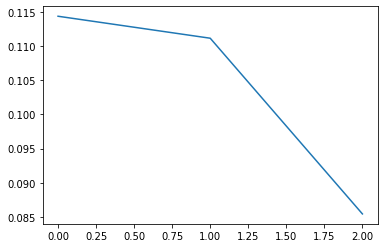

In [ ]:
plt.plot(loss_values)

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


torch.save(model.state_dict(), './model_save/model_weights.pth')

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# torch.save(model,os.path.join(output_dir, "model.pt"))

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


In [ ]:
from google.colab import files

# files.download('./model_save/model_weights.pth')
# !zip -r ./model_save.zip ./model_save
files.download('./model_save.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test Sentences

In [ ]:
next(iter(prediction_dataloader))

NameError: ignored

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm.tqdm(validation_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Calculate the accuracy for this batch of test sentences.
  tmp_eval_accuracy = flat_accuracy_batch(logits, label_ids)
  # print(tmp_eval_accuracy)
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 14,430 test sentences...


  0%|          | 2/451 [00:00<01:13,  6.14it/s]

[1 3 0 1 5 0 4 0 0 3 0 0 0 0 1 3 0 0 3 0 4 4 3 4 2 3 0 3 0 5 1 2]
[4 1 0 0 5 0 4 3 0 3 5 0 0 0 5 3 0 3 3 0 4 4 1 1 2 3 0 3 0 5 1 2]
[0 3 1 0 6 1 0 3 0 5 0 2 0 0 3 0 0 0 3 0 6 3 3 0 5 0 3 0 0 3 2 4]
[5 3 1 0 6 1 0 3 0 5 5 2 0 0 3 1 3 0 3 1 0 3 4 0 0 0 3 0 3 3 2 4]


  1%|          | 4/451 [00:00<01:04,  6.98it/s]

[5 0 3 0 0 0 0 2 3 0 6 4 4 3 3 3 0 3 4 1 3 0 3 0 3 5 5 0 5 3 3 5]
[4 0 3 0 4 0 0 2 3 0 3 4 4 3 3 3 0 3 3 1 3 0 3 0 3 5 5 0 5 3 3 5]
[0 3 0 0 1 1 0 0 3 3 5 1 1 4 0 4 2 5 0 1 5 0 5 4 5 0 0 0 0 4 4 5]
[0 3 0 0 1 0 0 3 3 3 5 0 4 3 0 4 2 0 6 0 5 0 5 3 5 0 0 0 0 3 4 0]


  1%|▏         | 6/451 [00:00<01:01,  7.25it/s]

[5 0 3 1 5 5 0 3 0 0 1 3 3 0 0 3 0 3 0 1 0 1 5 5 0 3 0 3 1 0 0 0]
[5 0 3 1 5 3 0 3 0 3 1 3 3 3 0 3 0 3 0 1 0 1 5 5 0 3 0 3 1 0 0 0]
[0 1 3 4 5 4 3 1 0 3 3 1 0 4 0 1 2 6 0 3 0 0 0 0 1 3 4 3 0 0 1 0]
[0 1 3 4 5 3 3 1 0 3 3 1 0 4 0 1 2 5 0 3 0 0 0 0 1 6 4 3 0 0 0 3]


  2%|▏         | 8/451 [00:01<01:00,  7.33it/s]

[3 0 0 3 4 1 5 0 5 2 5 0 0 0 5 3 0 0 0 3 0 5 5 0 3 3 0 0 3 3 3 0]
[3 3 0 3 3 5 5 0 5 2 5 0 3 0 5 2 0 0 0 3 5 5 5 0 3 3 0 0 1 3 3 0]
[4 2 0 1 0 1 0 0 0 1 1 0 3 5 0 3 0 3 0 4 2 0 0 3 3 3 3 1 3 3 0 3]
[4 2 0 1 0 1 0 0 0 1 3 0 3 2 0 3 6 3 0 4 2 0 0 3 3 3 3 1 3 3 3 3]


  2%|▏         | 10/451 [00:01<00:59,  7.45it/s]

[3 3 0 2 5 0 4 6 0 3 1 3 2 3 4 0 0 4 4 3 3 1 0 0 3 0 3 1 5 3 0 0]
[3 3 0 2 3 0 4 2 5 3 1 3 2 3 4 0 5 1 4 3 3 1 0 3 3 0 3 1 5 3 3 0]
[3 3 3 0 0 0 3 0 3 0 0 3 4 0 3 0 3 3 0 3 4 3 3 2 0 0 4 3 5 2 0 0]
[0 3 3 6 0 0 3 0 3 0 0 3 3 6 3 0 3 3 3 3 3 3 3 2 0 0 4 3 5 2 0 0]


  3%|▎         | 12/451 [00:01<00:59,  7.36it/s]

[3 1 0 1 3 0 0 5 3 4 0 3 3 5 0 4 1 5 5 0 3 3 5 4 3 2 0 3 0 0 1 0]
[3 3 0 1 3 0 0 5 3 3 0 3 2 5 0 4 1 5 5 0 3 3 5 4 3 2 0 3 0 0 1 2]
[1 0 0 3 0 0 3 3 1 3 0 0 0 0 4 3 0 0 2 3 0 2 0 5 3 2 0 0 6 0 1 3]
[1 3 0 3 0 3 3 3 3 3 3 0 0 0 4 3 0 0 2 1 0 2 0 5 3 0 0 0 3 0 3 3]


  3%|▎         | 14/451 [00:01<00:59,  7.38it/s]

[1 0 0 3 3 4 4 4 0 4 5 3 3 0 0 6 3 0 0 0 0 0 0 5 3 3 1 3 0 5 3 3]
[3 0 0 3 0 4 4 4 1 4 5 3 3 0 0 3 1 0 0 2 5 0 0 5 3 3 1 1 0 5 3 3]
[0 3 1 3 0 3 3 1 0 5 4 3 0 0 3 0 6 1 0 3 3 0 4 1 3 1 1 0 3 1 0 6]
[0 3 1 3 0 1 3 1 0 0 4 3 0 0 3 0 0 1 0 3 3 3 4 1 3 1 4 0 3 1 0 2]


  4%|▎         | 16/451 [00:02<00:57,  7.60it/s]

[0 3 3 5 4 5 0 3 5 0 0 0 3 0 3 3 0 3 5 5 1 0 5 3 1 4 4 3 5 0 5 4]
[0 1 3 3 4 5 0 3 5 0 0 0 3 0 3 3 0 1 5 5 1 0 5 0 1 4 3 3 5 0 6 3]
[4 0 0 3 0 3 5 5 2 0 3 0 4 0 0 0 0 3 0 1 3 0 0 3 0 0 1 2 0 3 6 0]
[4 0 0 3 0 3 5 5 2 0 3 0 4 0 0 0 0 3 0 1 3 0 0 3 3 3 3 2 0 1 2 0]


  4%|▍         | 18/451 [00:02<00:58,  7.46it/s]

[4 6 0 0 0 0 0 3 3 0 1 3 3 3 2 2 5 3 3 0 0 4 2 0 3 0 0 1 0 4 3 0]
[5 3 0 0 0 0 0 3 3 3 0 3 3 3 2 2 5 3 3 3 0 3 2 0 3 0 0 0 6 4 3 5]
[3 4 4 3 5 0 0 4 5 0 0 0 0 0 0 3 0 3 3 2 0 0 0 0 3 0 5 4 0 0 3 0]
[3 4 4 3 5 0 3 0 5 0 2 0 0 4 0 3 0 4 3 3 0 6 0 0 3 5 5 4 0 3 2 0]


  4%|▍         | 20/451 [00:02<00:58,  7.38it/s]

[4 0 0 0 0 0 3 3 0 2 0 1 0 0 4 5 3 3 3 0 1 0 3 3 0 0 3 3 0 0 0 0]
[3 0 0 5 0 0 3 3 0 2 0 1 0 0 4 5 3 3 3 6 1 0 3 1 0 3 1 3 0 0 0 0]
[5 0 0 3 1 3 4 0 5 5 3 0 3 4 0 3 0 0 0 0 0 4 0 3 3 5 0 3 3 0 6 0]
[5 0 0 3 1 3 4 0 5 5 3 4 3 4 0 3 3 3 0 0 0 5 5 3 3 5 0 3 3 3 0 3]


  5%|▍         | 22/451 [00:03<00:56,  7.63it/s]

[3 0 3 0 0 6 0 3 0 0 5 1 0 0 2 5 0 1 5 0 0 0 3 0 0 3 3 5 3 5 3 1]
[3 0 3 0 0 3 3 3 3 0 5 1 0 0 2 5 0 1 5 0 0 0 3 0 3 3 3 5 3 5 3 1]
[0 3 0 5 0 5 0 0 0 0 0 0 3 0 5 0 4 2 5 5 0 3 5 3 0 5 0 3 0 6 0 3]
[0 1 0 5 0 4 0 0 0 3 6 0 3 0 5 2 4 2 5 5 0 1 5 3 0 5 0 3 0 6 0 1]


  5%|▌         | 24/451 [00:03<00:55,  7.74it/s]

[3 3 0 0 0 0 6 0 0 3 3 0 3 0 2 0 3 6 0 0 3 3 0 3 0 0 5 0 0 0 3 5]
[3 3 0 0 0 6 6 3 0 3 3 0 3 0 2 3 3 3 0 3 3 3 0 3 0 0 0 0 0 0 3 5]
[0 3 4 4 3 3 0 6 0 3 0 3 0 5 0 0 5 3 0 1 3 0 5 0 4 0 3 1 3 3 5 0]
[0 3 3 3 0 3 0 6 1 3 0 3 0 5 0 0 5 3 0 5 3 3 5 0 4 0 3 1 3 3 5 0]


  6%|▌         | 26/451 [00:03<00:54,  7.74it/s]

[0 0 0 0 3 0 1 1 3 2 0 0 5 5 0 4 4 2 0 3 4 0 5 2 3 0 3 3 3 3 6 0]
[3 0 0 0 3 3 1 5 3 2 5 0 3 5 5 4 5 2 0 3 4 2 5 0 3 0 4 3 3 3 2 0]
[0 0 3 2 0 5 0 0 0 0 4 6 4 4 0 3 0 3 5 3 5 1 5 0 3 2 4 6 2 3 0 3]
[0 3 3 5 0 5 0 3 0 0 4 6 3 4 3 3 0 3 0 3 5 1 5 4 3 2 4 6 2 3 4 3]


  6%|▌         | 28/451 [00:03<00:54,  7.76it/s]

[0 3 0 0 1 5 3 0 1 0 2 0 0 0 0 1 1 3 3 0 1 0 5 4 3 0 1 0 3 0 0 0]
[0 3 0 0 1 0 3 0 1 0 2 0 0 0 0 1 1 3 3 0 3 6 1 4 3 0 1 0 3 0 0 3]
[0 3 0 2 3 0 0 3 0 0 3 0 4 5 3 0 0 5 3 5 1 0 3 2 0 3 4 4 3 3 3 0]
[0 3 0 2 1 3 4 1 0 0 3 0 4 5 3 5 0 5 3 5 1 0 3 2 0 3 4 4 3 3 3 0]


  7%|▋         | 30/451 [00:04<00:54,  7.79it/s]

[3 3 3 0 0 0 0 0 2 0 3 4 0 0 0 1 0 0 0 0 0 3 0 0 5 5 6 4 3 3 1 0]
[3 3 3 0 3 1 0 0 0 3 3 4 0 3 0 1 5 3 3 0 0 3 6 0 5 5 0 3 3 3 1 6]
[4 0 3 3 1 0 1 3 3 4 3 0 3 0 5 3 3 0 5 6 0 0 0 5 0 0 0 0 1 0 0 0]
[4 4 3 3 1 3 1 1 3 4 3 0 3 0 5 4 3 0 5 6 2 5 0 5 0 3 0 0 1 3 5 0]


  7%|▋         | 32/451 [00:04<00:53,  7.81it/s]

[3 0 3 3 3 0 2 0 5 3 0 0 4 0 2 1 0 3 0 0 5 5 3 3 0 0 2 0 0 3 0 3]
[3 0 3 3 3 0 2 0 5 3 0 0 4 0 0 1 0 3 0 0 5 5 3 3 0 0 2 3 0 3 0 3]
[5 3 3 0 0 5 3 3 3 0 3 5 0 0 4 0 5 0 0 0 3 4 0 0 0 0 0 0 3 5 3 2]
[5 3 0 5 2 5 3 3 3 0 3 0 0 0 4 3 5 3 0 2 3 4 1 0 1 0 0 0 4 5 3 0]


  8%|▊         | 34/451 [00:04<00:53,  7.75it/s]

[0 0 3 6 0 0 0 0 4 1 3 0 3 0 3 3 4 0 3 5 2 0 3 0 0 1 3 3 0 4 0 1]
[3 0 3 0 0 0 0 3 4 1 3 0 3 0 3 3 4 3 3 5 2 0 3 0 3 1 3 3 0 3 0 1]
[0 1 0 5 3 4 0 0 5 0 0 0 0 3 3 5 0 0 3 0 0 0 3 0 0 0 3 3 2 0 3 5]
[5 1 0 1 3 4 0 0 4 0 0 0 0 3 3 5 0 0 3 0 0 3 3 0 0 0 3 3 5 0 3 5]


  8%|▊         | 36/451 [00:04<00:53,  7.76it/s]

[0 3 3 0 4 0 0 5 3 2 4 0 3 0 5 3 3 5 0 0 5 5 3 0 1 0 0 3 0 0 0 5]
[0 3 3 0 4 0 0 5 3 2 4 3 3 0 5 6 3 5 0 0 5 3 4 0 0 0 0 3 0 0 0 5]
[3 3 3 3 0 5 0 0 0 5 0 0 2 3 0 1 3 0 5 5 5 5 6 5 4 0 0 3 3 4 0 5]
[3 3 3 3 0 5 2 0 0 5 0 0 2 0 0 1 3 3 3 5 5 5 2 5 4 0 0 1 3 4 0 3]


  8%|▊         | 38/451 [00:05<00:53,  7.77it/s]

[0 3 5 3 0 0 0 0 0 3 0 1 0 0 5 0 0 4 0 1 1 3 5 0 1 1 0 4 2 3 1 0]
[0 3 5 3 0 0 0 5 0 1 0 3 0 0 4 0 0 4 0 1 1 3 5 0 1 0 3 3 2 3 3 0]
[2 3 0 2 1 0 3 3 3 0 0 0 5 5 3 0 0 0 4 3 5 5 0 3 0 3 6 2 0 0 5 4]
[2 1 0 2 1 0 3 3 3 0 0 3 5 5 3 0 0 0 3 3 1 4 0 3 1 3 3 2 0 0 5 4]


  9%|▉         | 40/451 [00:05<00:52,  7.77it/s]

[0 0 4 6 0 0 4 0 2 5 3 3 4 0 3 4 1 3 5 2 2 0 5 6 5 1 0 0 5 0 0 1]
[2 3 4 6 0 0 4 0 0 3 3 2 3 0 3 4 4 3 5 6 0 3 5 6 5 1 0 3 5 0 3 3]
[0 0 0 5 3 3 0 3 0 3 0 5 0 0 3 0 3 0 4 5 3 3 0 0 0 4 2 5 5 0 1 3]
[0 0 0 1 3 3 5 3 0 3 3 5 3 3 3 0 3 0 4 5 3 4 0 0 3 3 2 5 5 5 3 3]


  9%|▉         | 42/451 [00:05<00:52,  7.73it/s]

[0 0 4 3 0 0 3 1 0 5 1 2 0 3 0 3 3 0 0 3 5 5 3 0 0 3 0 0 3 3 0 0]
[0 0 6 3 0 0 3 1 0 5 1 2 0 3 0 3 3 0 5 3 5 5 3 3 0 1 0 3 3 3 6 6]
[3 0 0 0 0 5 3 3 0 3 0 0 3 5 3 3 3 0 2 0 0 1 4 5 0 1 3 6 2 3 2 1]
[3 0 0 0 0 5 3 3 6 3 0 3 3 5 0 3 3 0 2 3 0 1 4 5 0 1 3 6 2 3 2 1]


 10%|▉         | 44/451 [00:05<00:52,  7.70it/s]

[3 3 3 3 0 1 0 0 0 0 4 5 0 5 3 3 4 3 2 0 0 0 0 4 5 2 1 0 0 1 0 3]
[3 3 3 3 0 1 0 0 0 0 4 5 0 5 3 3 4 3 2 0 0 0 0 4 5 4 1 0 0 1 0 3]
[0 0 0 0 1 0 3 0 0 0 3 0 3 5 0 4 0 0 0 0 3 3 3 4 2 0 0 3 3 0 3 3]
[0 0 1 0 1 3 4 0 0 5 3 3 3 5 3 3 5 0 0 0 1 0 3 4 2 3 0 3 3 0 3 3]


 10%|█         | 46/451 [00:06<00:52,  7.73it/s]

[1 0 3 0 0 0 0 4 3 0 6 3 0 3 3 5 6 0 3 3 0 5 3 3 3 0 3 1 3 0 3 3]
[1 3 0 0 0 6 4 4 3 0 6 3 0 3 3 0 6 2 3 3 0 5 3 3 3 6 3 1 3 3 3 3]
[0 3 3 3 3 1 0 0 0 3 5 3 4 3 0 0 3 3 3 0 1 1 5 5 0 0 0 5 3 0 4 0]
[0 3 3 3 0 3 0 0 0 3 5 3 4 3 0 0 3 3 3 5 1 1 0 0 0 0 1 5 3 0 4 0]


 11%|█         | 48/451 [00:06<00:52,  7.68it/s]

[1 1 3 0 5 0 0 1 0 0 1 4 0 4 5 5 0 0 0 0 0 1 0 0 0 0 6 5 3 3 1 3]
[1 1 3 0 5 0 3 3 0 0 1 1 0 1 1 5 0 0 0 0 0 3 0 2 0 0 6 5 3 3 3 4]
[0 0 0 0 0 5 4 3 3 3 4 0 3 0 0 3 1 3 3 3 0 4 0 0 3 3 5 3 0 5 4 4]
[0 0 0 0 0 5 3 3 3 3 4 5 3 0 0 3 1 3 3 3 0 1 0 0 3 3 5 3 3 0 3 3]


 11%|█         | 50/451 [00:06<00:52,  7.64it/s]

[3 3 0 0 3 3 1 6 2 5 1 3 4 6 0 0 5 2 3 0 0 3 3 4 0 0 4 5 4 0 4 3]
[3 3 3 2 3 3 5 6 2 5 1 3 4 6 2 0 5 2 3 0 0 3 3 3 0 0 4 5 6 0 3 3]
[3 5 1 0 1 0 3 3 0 0 5 4 0 3 3 0 6 3 3 0 4 1 3 0 3 0 0 0 3 0 1 3]
[3 5 1 0 1 3 4 3 0 0 5 4 3 3 3 0 6 3 3 0 3 1 3 0 3 0 0 0 1 0 1 0]


 12%|█▏        | 52/451 [00:06<00:52,  7.62it/s]

[0 5 0 3 1 0 0 3 0 0 0 3 3 1 5 3 3 4 1 3 3 5 0 0 0 0 0 0 0 0 4 0]
[5 2 0 3 1 0 3 6 5 0 0 3 3 1 4 3 0 5 1 3 3 5 0 0 0 3 0 0 3 5 4 0]
[3 3 0 0 5 3 0 3 1 2 3 0 0 3 3 0 4 0 0 0 4 0 1 3 0 0 0 0 0 6 0 3]
[3 4 0 0 3 3 0 3 0 2 3 5 0 3 3 0 4 0 0 0 4 0 0 3 0 0 0 0 0 6 3 3]


 12%|█▏        | 54/451 [00:07<00:52,  7.63it/s]

[3 2 0 4 5 1 1 3 0 0 2 0 0 0 3 3 0 5 0 0 3 0 0 4 0 3 4 0 4 1 4 0]
[3 2 0 4 5 1 1 3 0 2 0 0 0 0 6 3 6 1 0 3 0 3 0 2 0 3 4 0 4 1 4 0]
[0 5 0 3 3 0 4 3 0 2 0 0 3 3 3 5 5 0 5 3 6 3 0 1 2 0 2 5 0 0 3 0]
[0 5 0 3 3 0 4 3 0 2 0 3 3 3 3 5 5 0 0 3 0 3 0 1 2 0 2 5 0 0 3 0]


 12%|█▏        | 56/451 [00:07<00:51,  7.68it/s]

[0 6 0 6 3 3 1 0 3 1 1 3 0 0 3 3 3 4 0 0 0 5 0 4 0 0 1 3 0 4 0 0]
[0 3 0 6 3 3 1 0 3 1 1 3 0 0 3 3 3 4 0 0 0 5 0 4 0 2 1 3 0 4 0 6]
[6 1 0 3 0 2 3 3 3 0 0 1 3 0 5 0 2 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0]
[6 1 0 3 3 0 3 3 3 5 4 1 0 0 5 0 0 0 0 1 0 0 4 3 3 3 3 3 3 0 3 0]


 13%|█▎        | 58/451 [00:07<00:51,  7.68it/s]

[0 0 3 0 4 3 0 3 0 0 0 0 0 0 3 0 0 0 0 2 5 4 3 0 0 3 3 0 0 6 1 3]
[0 0 3 0 3 3 0 3 0 0 3 0 0 0 3 0 3 0 5 2 5 4 3 6 3 3 4 0 0 0 1 3]
[3 3 2 6 3 3 3 3 0 0 1 0 3 0 0 2 1 6 0 0 0 4 5 5 3 3 5 5 3 1 3 4]
[3 3 6 2 3 3 4 3 2 0 1 0 3 3 0 6 3 2 0 0 0 3 5 5 3 3 5 1 3 1 3 4]


 13%|█▎        | 60/451 [00:07<00:50,  7.68it/s]

[3 3 0 3 5 0 0 4 1 0 0 0 1 0 2 0 1 0 0 1 1 3 3 5 0 3 3 5 3 0 0 5]
[3 3 0 3 5 2 0 3 1 0 4 6 1 0 2 0 1 6 0 1 1 0 3 5 0 1 3 4 0 3 0 5]
[0 1 0 0 5 0 2 3 0 0 0 4 1 0 0 3 0 0 0 4 0 6 3 3 0 0 1 0 5 0 2 6]
[3 1 0 0 5 0 2 3 0 0 2 4 1 5 0 3 0 5 0 4 0 6 3 3 0 3 1 5 5 0 2 3]


 14%|█▎        | 62/451 [00:08<00:50,  7.63it/s]

[0 0 0 3 0 0 0 2 1 0 2 0 3 6 4 5 0 0 2 2 0 3 4 3 0 3 3 3 0 5 0 3]
[0 0 5 3 0 0 0 2 1 0 2 0 3 6 3 0 0 0 2 5 0 3 4 3 0 3 3 6 0 5 2 2]
[0 1 0 3 2 0 0 0 3 1 0 0 3 0 0 3 3 0 3 2 0 0 2 5 1 0 5 1 0 5 0 0]
[5 1 0 3 2 0 0 0 3 1 0 0 3 0 0 3 3 0 6 2 0 0 3 5 1 0 5 1 0 5 5 0]


 14%|█▍        | 64/451 [00:08<00:50,  7.68it/s]

[4 0 0 5 0 5 0 0 3 0 1 5 0 3 3 2 4 0 3 3 0 3 0 0 0 5 4 3 0 0 0 0]
[4 0 0 0 0 1 0 0 3 0 1 5 3 3 3 2 4 3 3 3 0 3 0 0 0 5 4 3 0 0 0 0]
[3 3 6 3 4 5 0 3 6 3 5 0 3 3 0 0 0 0 0 0 4 0 0 4 5 3 5 0 4 4 1 3]
[3 3 6 3 4 5 0 3 6 3 5 0 3 3 0 0 0 0 0 0 4 0 0 4 5 3 5 0 4 4 1 3]


 15%|█▍        | 66/451 [00:08<00:50,  7.66it/s]

[3 4 3 3 3 0 6 4 0 0 0 3 3 3 1 2 0 0 0 0 3 0 3 5 0 3 0 4 5 1 0 0]
[3 4 3 3 3 0 6 4 0 0 3 3 3 3 1 2 0 0 0 0 3 0 3 0 0 3 4 4 5 5 3 3]
[0 3 3 1 0 3 2 0 0 3 0 1 3 3 4 3 3 0 0 3 0 0 4 0 1 0 6 4 5 0 0 0]
[0 3 3 1 0 3 2 3 0 3 3 1 3 3 4 3 3 0 0 3 0 5 4 3 1 0 2 4 5 0 0 5]


 15%|█▌        | 68/451 [00:08<00:50,  7.59it/s]

[0 5 0 1 1 4 0 0 3 1 0 0 0 3 0 0 0 3 0 5 0 3 2 0 3 6 3 6 0 3 0 0]
[0 5 0 1 1 4 0 0 3 1 6 0 0 3 0 0 5 4 3 5 0 6 5 0 3 6 3 6 0 3 0 0]
[0 2 0 0 0 5 0 0 5 1 0 5 0 3 5 3 0 0 0 0 5 0 0 0 5 0 5 3 6 1 0 3]
[0 2 0 3 6 0 0 3 5 1 3 5 5 3 5 3 0 0 0 0 5 6 0 1 5 0 5 3 6 3 0 3]


 16%|█▌        | 70/451 [00:09<00:50,  7.56it/s]

[4 3 0 4 3 1 3 3 3 3 3 3 0 0 0 6 0 0 0 0 0 5 0 0 3 0 0 2 5 0 1 0]
[4 3 0 4 3 1 3 3 3 3 3 3 0 0 5 6 0 0 0 0 0 4 3 0 3 0 0 2 5 0 1 0]
[0 1 0 0 1 3 0 5 3 6 0 3 0 0 0 2 4 0 3 0 3 0 0 3 4 0 0 3 5 3 0 3]
[3 1 0 0 1 3 0 5 3 6 0 0 0 0 0 2 4 2 3 0 3 0 0 3 3 0 0 3 5 3 0 3]


 16%|█▌        | 72/451 [00:09<00:51,  7.38it/s]

[6 0 0 3 0 4 0 3 0 5 0 3 4 0 3 3 4 5 1 3 3 4 0 3 5 0 3 0 6 0 0 0]
[6 0 0 3 0 4 0 4 0 5 5 3 4 0 0 3 4 5 1 3 3 0 0 0 5 0 3 0 6 5 0 3]
[0 5 0 3 4 0 5 0 0 5 0 0 0 3 0 0 3 1 0 0 3 0 3 3 0 1 0 3 0 3 1 2]
[0 5 5 3 4 0 5 1 0 5 0 3 0 3 0 3 3 0 0 0 0 1 1 3 0 1 3 3 3 3 1 2]


 16%|█▋        | 74/451 [00:09<00:52,  7.24it/s]

[5 0 0 0 5 0 4 0 0 3 0 4 4 5 0 1 0 3 1 0 3 5 0 3 6 0 2 2 3 2 1 3]
[5 0 3 0 5 0 4 0 0 3 1 4 4 5 0 5 0 3 1 0 3 0 0 3 0 1 2 2 3 2 1 3]
[3 0 0 4 3 0 6 3 0 0 3 5 4 1 0 3 0 3 3 3 0 0 2 6 0 3 3 3 0 3 5 0]
[3 0 0 4 3 6 6 3 0 0 3 5 4 1 0 3 0 3 3 3 0 0 5 6 3 3 1 3 0 3 5 0]


 17%|█▋        | 76/451 [00:10<00:51,  7.25it/s]

[1 1 3 0 3 3 0 0 0 0 1 0 3 5 3 0 1 0 3 0 0 4 0 4 0 0 3 3 4 3 0 3]
[1 1 3 0 3 3 0 3 3 0 0 0 0 5 4 0 1 3 3 5 0 4 0 4 0 0 3 3 4 0 5 3]
[0 0 0 5 2 1 0 0 3 0 3 0 0 3 0 1 3 0 0 0 5 3 0 4 0 1 3 0 0 0 3 3]
[0 0 0 3 2 3 0 3 3 0 3 4 0 3 0 1 3 0 0 3 1 3 0 3 0 1 3 0 4 5 3 3]


 17%|█▋        | 78/451 [00:10<00:52,  7.12it/s]

[3 0 5 0 0 0 0 3 2 0 1 5 0 0 1 3 0 0 0 0 0 0 3 5 0 5 0 0 3 0 1 0]
[3 3 0 0 0 0 5 3 0 0 1 5 5 0 1 1 0 0 0 0 0 0 3 5 0 5 0 0 3 0 1 5]
[0 0 3 0 3 2 0 0 5 5 4 0 0 0 3 3 3 0 5 6 0 3 3 5 3 1 4 0 3 0 0 4]
[0 5 3 0 3 2 5 0 5 0 3 4 0 0 3 3 3 0 0 2 3 3 3 5 3 1 3 1 3 0 0 0]


 18%|█▊        | 80/451 [00:10<00:50,  7.36it/s]

[3 0 6 0 1 2 0 0 5 4 0 3 0 1 6 5 0 1 1 3 0 0 3 3 6 4 0 0 1 0 3 0]
[3 3 6 0 1 2 0 0 5 4 0 3 0 1 1 5 0 1 1 3 0 3 3 3 5 3 0 0 1 0 3 0]
[0 6 3 3 0 0 3 0 3 0 3 0 1 3 0 5 0 0 6 3 0 4 0 3 3 3 3 3 0 0 3 0]
[3 6 3 3 0 0 3 3 3 0 0 0 1 3 0 4 0 5 5 1 0 4 0 3 3 3 3 3 0 0 3 0]


 18%|█▊        | 82/451 [00:10<00:49,  7.47it/s]

[3 0 4 1 0 0 3 3 2 0 0 0 3 3 0 6 0 0 0 0 1 0 3 2 3 3 0 0 5 1 4 1]
[3 6 4 5 0 0 3 3 2 0 5 0 3 3 1 6 0 0 0 0 1 3 0 2 3 3 0 0 5 1 4 1]
[0 1 3 0 3 0 4 5 0 0 0 3 1 0 5 3 3 3 0 0 1 0 0 0 3 3 1 0 0 3 4 0]
[0 1 3 3 3 0 4 3 3 0 0 3 1 3 1 3 3 3 3 3 1 0 5 0 3 0 1 0 0 3 4 0]


 19%|█▊        | 84/451 [00:11<00:48,  7.57it/s]

[0 0 0 0 3 3 0 0 3 3 3 3 2 0 2 0 0 0 3 0 6 0 0 4 0 0 0 0 5 4 3 1]
[0 0 0 0 3 3 0 0 3 3 3 3 2 0 2 5 0 0 3 0 6 0 5 1 5 0 6 0 5 0 3 1]
[0 0 3 3 3 0 5 0 3 0 0 0 5 0 3 3 3 3 0 2 0 0 0 5 3 2 0 3 0 0 3 0]
[0 0 1 3 0 0 5 0 3 0 5 0 5 0 3 3 3 3 0 2 6 0 0 5 3 2 0 3 1 0 3 0]


 19%|█▉        | 86/451 [00:11<00:48,  7.59it/s]

[0 3 0 3 1 0 3 3 4 5 2 0 1 0 5 5 6 1 0 0 2 3 3 0 3 4 5 5 0 0 3 5]
[0 3 0 3 1 5 3 3 1 5 6 3 1 5 5 5 6 1 0 3 2 3 3 3 4 4 5 0 0 0 1 5]
[0 2 3 0 0 5 6 0 0 3 0 1 0 3 3 5 1 5 3 3 0 5 1 0 0 3 4 3 1 1 1 0]
[0 2 3 0 3 5 6 0 5 3 0 1 0 3 3 5 1 5 3 3 0 0 1 0 0 3 4 3 1 1 2 0]


 20%|█▉        | 88/451 [00:11<00:47,  7.69it/s]

[0 0 0 0 0 0 1 0 1 3 4 0 2 0 0 0 3 5 3 1 0 1 0 3 3 1 4 5 5 1 0 4]
[4 5 0 0 0 0 1 0 1 3 4 3 0 0 0 0 3 5 3 1 0 1 6 3 3 1 4 5 5 1 0 4]
[1 1 0 0 3 0 4 6 0 3 0 6 1 3 3 3 0 0 6 0 0 4 3 6 0 4 4 0 0 3 3 3]
[1 1 0 2 3 0 4 0 2 3 5 5 1 2 3 3 4 0 3 0 0 4 3 6 0 4 4 0 0 3 3 1]


 20%|█▉        | 90/451 [00:11<00:46,  7.69it/s]

[3 4 1 0 3 0 3 0 5 3 3 3 5 0 4 0 3 6 4 5 0 3 0 0 0 3 2 0 5 0 5 3]
[3 3 3 3 3 0 3 0 5 3 3 1 5 0 4 0 3 0 4 5 1 3 0 0 0 3 0 1 5 0 5 3]
[5 4 3 6 3 0 0 1 5 0 0 0 1 0 0 3 0 3 0 3 3 5 1 0 3 0 5 0 3 3 1 0]
[5 4 3 6 3 0 0 1 5 0 0 3 1 0 0 3 0 3 3 3 3 5 1 6 3 0 5 0 3 3 1 0]


 20%|██        | 92/451 [00:12<00:46,  7.66it/s]

[0 0 0 3 0 3 5 0 0 3 4 3 1 0 3 0 0 2 5 3 4 3 6 0 0 0 0 0 0 1 3 0]
[0 0 0 0 0 3 5 0 0 0 4 3 1 0 3 6 0 2 5 3 3 1 3 0 0 0 0 0 0 1 3 0]
[3 5 1 3 3 0 0 3 0 4 0 0 3 0 1 0 5 4 1 3 0 0 0 3 3 0 3 3 3 3 0 3]
[3 5 1 3 3 0 0 3 0 3 3 0 3 0 1 3 5 4 3 3 0 3 3 3 3 5 2 0 3 3 2 3]


 21%|██        | 94/451 [00:12<00:46,  7.67it/s]

[3 5 3 0 0 0 1 0 1 0 5 3 0 3 5 0 0 0 0 0 0 3 3 3 3 3 5 2 0 0 3 0]
[3 5 3 5 0 0 1 5 1 0 5 3 0 0 5 0 0 0 0 0 0 3 3 3 3 3 5 3 0 0 3 1]
[5 5 0 0 0 1 0 5 4 3 4 3 3 5 3 3 0 3 0 3 3 0 0 3 0 0 6 3 0 5 0 3]
[0 5 0 0 0 1 0 1 3 3 4 3 3 5 3 3 0 0 0 3 3 0 0 3 0 0 6 3 5 5 0 3]


 21%|██▏       | 96/451 [00:12<00:46,  7.65it/s]

[3 1 3 3 0 3 1 1 3 0 0 4 0 5 3 3 3 0 3 3 0 0 5 5 0 3 0 0 0 5 0 3]
[3 5 3 3 0 3 1 1 3 0 3 4 3 5 3 3 3 0 3 3 0 0 5 5 0 3 0 0 0 5 0 3]
[0 0 1 0 0 3 3 6 6 3 1 2 0 4 4 3 4 0 2 4 6 4 6 5 0 3 0 5 5 0 0 3]
[0 0 1 0 0 0 4 2 6 3 1 2 0 3 3 3 4 0 2 3 0 0 0 5 3 3 0 5 0 3 0 0]


 22%|██▏       | 98/451 [00:12<00:46,  7.61it/s]

[5 5 0 3 3 0 3 1 5 3 5 5 3 3 3 0 3 5 0 0 5 1 0 0 0 5 0 3 0 5 3 0]
[5 1 3 3 3 0 1 1 5 3 5 5 3 3 3 0 3 5 0 0 5 1 3 0 0 5 0 3 0 5 6 0]
[3 3 3 0 0 3 1 3 3 1 5 1 0 0 0 4 0 0 0 0 3 1 0 3 0 0 3 4 5 3 3 3]
[3 3 3 0 0 3 1 3 3 3 5 1 1 0 0 4 0 3 2 3 0 1 0 3 0 0 3 4 5 4 3 3]


 22%|██▏       | 100/451 [00:13<00:45,  7.63it/s]

[5 5 0 4 0 5 0 3 3 0 0 0 0 3 3 3 0 5 0 6 3 0 3 5 3 5 0 0 3 3 1 1]
[5 0 0 4 6 5 0 3 3 0 0 0 0 2 3 3 5 5 0 6 3 0 3 0 3 5 0 0 3 5 1 1]
[0 0 3 5 5 0 5 3 4 0 0 3 3 3 0 0 0 5 3 1 0 0 6 5 3 0 3 3 0 1 0 0]
[2 0 0 0 5 0 5 3 4 0 0 3 3 3 0 0 0 5 3 1 0 2 5 5 3 0 3 3 0 1 0 0]


 23%|██▎       | 102/451 [00:13<00:45,  7.62it/s]

[0 0 0 0 0 0 5 0 5 2 4 5 0 1 0 0 3 1 3 3 3 0 1 5 0 0 5 0 5 3 3 0]
[0 0 0 0 3 3 5 0 5 2 4 5 6 3 0 0 1 1 0 3 3 0 0 5 0 0 5 0 5 3 2 0]
[5 0 5 0 0 3 3 0 0 0 3 0 0 1 3 0 3 0 3 0 4 3 0 0 4 0 0 5 1 4 5 3]
[4 0 0 0 3 3 3 0 1 0 3 0 0 3 3 0 3 0 3 3 0 0 0 0 4 0 0 2 1 4 0 3]


 23%|██▎       | 104/451 [00:13<00:45,  7.63it/s]

[0 5 0 0 3 0 1 3 3 2 0 0 4 0 0 2 0 0 4 1 1 0 6 0 5 0 1 3 2 0 2 0]
[0 5 0 0 3 0 1 3 3 2 0 0 4 2 0 2 5 6 4 1 3 0 5 3 0 0 1 3 2 0 2 0]
[0 0 0 5 0 0 0 4 0 3 1 0 4 6 4 0 3 0 1 0 0 0 5 3 5 1 0 5 0 3 2 5]
[0 0 0 2 0 0 0 5 0 3 1 0 4 6 3 0 3 0 1 6 5 0 5 3 5 1 0 5 0 3 3 5]


 24%|██▎       | 106/451 [00:14<00:45,  7.66it/s]

[1 0 3 1 0 3 0 0 0 5 5 0 5 1 0 3 5 3 6 0 0 4 0 0 0 5 5 0 0 3 4 0]
[1 3 3 1 0 3 0 0 0 5 4 5 5 0 1 3 5 1 6 0 0 4 0 3 0 0 5 0 0 3 0 0]
[3 5 0 3 0 4 3 3 0 0 0 0 3 3 3 0 1 5 1 6 0 0 0 2 3 0 0 3 3 3 3 0]
[3 5 3 3 0 3 3 3 0 3 3 3 3 3 3 0 1 5 1 6 0 3 0 2 3 0 0 3 3 3 3 0]


 24%|██▍       | 108/451 [00:14<00:45,  7.59it/s]

[3 0 3 0 0 3 0 0 0 0 5 0 3 4 0 0 0 5 3 3 5 0 3 0 0 0 5 3 0 3 0 0]
[3 5 1 0 2 1 0 3 0 2 0 0 3 4 3 0 0 5 3 3 1 0 4 0 0 0 5 3 0 3 3 0]
[0 0 3 0 0 0 0 0 0 0 0 0 3 0 2 5 4 0 0 5 1 3 1 0 3 0 5 3 3 3 3 0]
[0 0 3 0 0 0 0 0 5 0 0 0 3 0 2 5 4 0 0 5 1 3 1 3 2 6 5 3 3 3 1 0]


 24%|██▍       | 110/451 [00:14<00:44,  7.58it/s]

[3 5 0 0 4 1 3 0 0 1 0 3 4 4 1 2 2 3 1 3 0 3 5 3 5 0 0 0 0 5 0 0]
[3 5 0 0 3 3 3 1 0 1 0 1 4 1 1 2 2 3 1 3 0 3 5 3 5 0 0 1 0 0 0 0]
[3 1 0 0 3 1 0 0 3 2 0 1 0 0 3 5 1 0 5 0 3 2 0 3 3 0 0 3 0 3 6 3]
[3 1 0 4 3 3 3 0 3 2 0 0 0 0 3 5 1 0 1 3 3 2 0 3 3 3 0 3 0 3 3 3]


 25%|██▍       | 112/451 [00:14<00:44,  7.59it/s]

[4 3 5 2 3 3 5 1 0 3 0 3 0 3 3 5 5 0 3 0 0 6 4 1 1 2 0 0 3 3 0 0]
[4 3 5 2 3 3 1 1 0 3 0 3 3 3 3 5 5 0 3 1 0 6 0 1 1 2 0 0 3 3 0 0]
[0 0 0 4 3 1 3 0 3 4 1 5 3 4 0 4 3 0 0 1 1 3 0 0 5 3 0 3 3 0 6 0]
[0 0 0 1 3 1 0 0 3 5 1 5 3 4 0 1 3 0 5 3 1 3 3 0 5 3 0 0 3 0 3 0]


 25%|██▌       | 114/451 [00:15<00:44,  7.59it/s]

[3 0 0 1 0 6 0 3 0 5 0 0 0 3 2 5 0 3 1 3 0 1 4 0 3 0 3 5 3 3 1 0]
[3 0 0 3 3 6 0 0 5 5 0 0 0 3 2 5 0 3 5 3 0 0 4 0 1 0 3 5 3 3 1 0]
[6 2 3 1 3 0 0 3 0 0 2 0 1 5 4 0 1 0 3 0 3 0 0 3 3 1 3 5 3 0 4 3]
[3 2 3 1 3 0 0 3 3 0 2 0 1 1 4 0 1 5 3 0 3 3 3 3 3 0 3 0 3 0 4 3]


 26%|██▌       | 116/451 [00:15<00:44,  7.61it/s]

[5 1 0 0 0 0 1 5 4 0 3 0 3 0 0 3 3 0 0 2 0 3 3 0 3 0 0 1 3 5 0 2]
[5 1 0 0 0 0 1 0 5 0 3 0 3 0 0 3 3 3 0 2 0 3 3 0 3 0 5 1 3 2 0 2]
[0 0 5 0 3 3 0 3 1 0 0 3 0 5 4 0 0 0 0 3 3 3 5 0 0 6 6 0 5 0 0 0]
[0 1 5 3 3 3 0 3 1 0 4 3 0 5 4 5 0 0 0 3 3 3 5 0 0 6 6 0 5 0 0 0]


 26%|██▌       | 118/451 [00:15<00:44,  7.55it/s]

[4 0 3 3 3 3 0 0 0 0 0 5 4 5 1 0 5 4 0 4 5 4 3 3 0 0 0 0 0 6 1 3]
[3 0 3 3 3 3 0 0 0 0 0 6 4 5 1 2 5 4 3 4 5 4 3 3 0 0 0 0 0 6 3 3]
[3 0 1 4 0 0 3 6 3 3 0 3 0 0 3 5 6 3 3 0 0 2 0 0 3 3 3 4 3 0 0 0]
[3 3 3 5 0 0 3 6 3 3 0 3 0 0 3 5 6 3 3 5 0 4 0 0 3 3 3 5 3 0 0 0]


 27%|██▋       | 120/451 [00:15<00:43,  7.57it/s]

[4 4 4 2 0 0 2 0 0 0 1 6 0 3 3 4 0 0 0 0 1 0 0 3 0 0 3 3 5 0 0 3]
[4 4 4 2 0 0 0 0 6 1 3 0 0 3 3 3 0 0 0 0 1 0 0 3 3 0 0 3 5 0 0 3]
[1 3 0 0 3 6 0 0 0 3 0 3 0 4 3 0 0 3 2 0 0 0 1 3 3 3 3 1 0 3 0 0]
[4 1 0 0 3 3 0 0 0 3 0 3 0 4 3 0 5 4 3 0 3 0 3 3 3 0 3 5 3 4 0 3]


 27%|██▋       | 122/451 [00:16<00:43,  7.59it/s]

[0 3 3 3 0 1 1 3 0 0 0 5 0 0 5 0 1 0 1 3 3 5 3 0 3 3 0 4 0 0 0 3]
[6 3 3 1 0 1 3 3 0 0 0 5 0 5 1 0 1 3 1 3 3 5 3 5 3 3 5 4 0 3 0 3]
[3 2 0 0 1 4 3 0 0 3 2 0 2 3 0 0 1 0 3 0 0 0 4 4 3 0 0 3 5 4 0 0]
[3 3 0 0 1 4 3 0 3 3 2 5 2 3 0 0 1 0 3 0 0 0 0 4 3 0 0 1 1 4 3 0]


 27%|██▋       | 124/451 [00:16<00:43,  7.55it/s]

[0 3 4 3 3 0 0 1 0 3 6 5 3 3 3 0 3 0 0 2 3 3 3 0 1 3 0 5 3 0 2 0]
[3 3 1 3 3 0 0 1 1 3 2 5 3 3 3 2 3 5 0 2 3 3 3 0 1 1 0 5 3 0 2 0]
[3 3 0 0 4 0 3 0 3 0 1 3 1 0 0 3 3 3 3 2 0 0 1 0 3 0 3 0 0 3 0 0]
[3 3 0 6 3 0 3 0 3 0 1 3 1 0 0 3 6 3 3 2 0 0 1 5 3 4 3 0 0 3 0 0]


 28%|██▊       | 126/451 [00:16<00:43,  7.54it/s]

[0 0 3 3 0 0 2 2 0 0 0 5 0 0 2 4 3 3 3 3 3 0 3 0 0 0 3 0 0 4 4 0]
[3 0 3 3 0 0 2 2 0 3 0 5 0 0 2 4 3 3 3 3 3 0 3 0 0 0 3 0 0 4 3 0]
[0 3 0 1 3 0 1 6 0 0 5 5 0 4 0 0 5 0 1 3 0 0 0 3 4 0 0 5 0 5 0 4]
[3 3 0 1 3 6 1 6 0 0 5 5 0 4 5 0 0 0 1 3 0 0 5 3 4 0 0 5 5 1 0 4]


 28%|██▊       | 128/451 [00:16<00:42,  7.61it/s]

[3 0 2 6 0 0 0 0 0 6 0 3 2 0 1 3 0 0 0 3 3 0 0 0 3 0 0 0 0 5 2 6]
[3 3 2 0 0 0 0 0 0 6 0 3 2 0 1 3 0 4 0 3 3 0 0 0 0 0 0 0 0 5 2 6]
[6 3 1 1 4 5 0 0 0 0 3 4 3 3 4 0 0 6 4 3 3 3 4 0 3 3 5 3 5 5 5 4]
[0 3 1 1 4 5 0 0 3 0 3 4 3 1 3 0 0 2 4 1 3 3 4 3 3 3 4 3 5 5 1 4]


 29%|██▉       | 130/451 [00:17<00:42,  7.58it/s]

[3 1 2 3 3 3 3 5 4 3 1 5 0 0 4 5 3 0 0 0 4 3 4 0 6 0 0 3 1 0 0 0]
[1 1 3 3 3 3 3 5 3 3 4 5 0 5 4 5 3 0 0 3 4 3 4 3 6 3 3 3 5 0 0 0]
[0 3 0 5 4 4 0 0 1 0 0 5 3 5 0 3 0 3 0 0 5 5 3 3 0 3 3 0 0 1 0 0]
[0 3 0 4 4 1 0 0 1 0 0 5 3 5 3 3 0 3 0 0 5 5 3 3 0 3 3 0 0 1 0 3]


 29%|██▉       | 132/451 [00:17<00:42,  7.58it/s]

[5 3 2 4 3 0 3 0 3 0 0 3 0 1 4 3 3 6 3 0 3 0 0 3 0 4 3 4 4 3 1 6]
[5 3 2 4 3 0 3 3 3 3 6 3 0 1 4 3 3 6 3 0 3 0 0 3 0 4 3 4 4 3 1 6]
[3 0 0 4 2 0 4 0 3 3 0 0 5 0 0 3 0 0 0 0 3 3 6 3 0 0 3 1 0 0 0 3]
[3 0 3 3 2 0 4 0 1 3 0 3 5 0 3 3 0 0 0 0 3 3 3 3 0 0 3 1 0 3 0 3]


 30%|██▉       | 134/451 [00:17<00:41,  7.57it/s]

[0 0 0 0 5 3 0 0 0 3 0 3 3 1 0 4 5 3 3 4 0 0 1 3 0 0 0 3 3 0 0 6]
[0 0 5 0 0 3 3 4 0 6 0 3 3 3 0 4 0 1 3 4 0 3 1 3 3 3 0 3 3 0 0 0]
[1 4 0 3 3 0 0 1 5 0 0 0 0 5 3 4 3 0 1 0 0 3 4 0 3 3 6 0 3 0 5 0]
[1 4 0 3 3 0 1 2 3 0 0 0 0 5 3 1 3 0 1 0 0 3 5 0 3 3 2 3 3 5 5 0]


 30%|███       | 136/451 [00:17<00:41,  7.61it/s]

[4 3 4 2 3 0 0 0 1 0 1 0 1 3 0 3 0 0 0 0 4 5 0 4 5 2 5 3 5 2 0 3]
[4 3 3 2 3 0 0 0 5 0 1 0 1 1 0 3 0 0 0 0 4 0 4 4 6 2 5 3 5 2 0 6]
[3 4 1 0 3 1 5 3 3 5 2 0 1 3 1 5 6 0 5 0 5 0 0 0 0 3 0 3 0 1 5 0]
[3 4 1 0 3 1 5 3 3 5 2 5 1 3 5 1 6 0 1 0 5 0 0 0 0 3 0 3 3 1 5 0]


 31%|███       | 138/451 [00:18<00:40,  7.64it/s]

[0 0 3 3 3 2 0 1 3 2 3 1 0 3 3 0 5 3 1 0 0 4 3 5 5 6 0 3 4 4 0 1]
[0 0 3 3 3 2 0 1 3 2 3 1 0 3 3 0 5 3 3 0 0 1 3 5 5 6 0 4 4 4 0 3]
[0 5 1 5 0 1 6 0 0 3 3 0 0 3 4 3 5 0 1 0 6 3 0 3 0 1 1 1 5 1 3 3]
[5 5 1 5 0 1 6 3 3 3 3 0 0 3 4 3 5 0 1 6 6 3 0 3 0 1 1 1 5 1 3 3]


 31%|███       | 140/451 [00:18<00:41,  7.54it/s]

[0 0 0 3 0 2 3 0 1 0 0 5 3 0 2 4 0 5 3 3 3 4 1 3 3 4 0 0 3 0 0 6]
[0 0 0 3 0 2 3 0 1 0 0 5 3 0 2 4 0 5 3 3 2 2 1 3 3 0 0 0 3 0 0 6]
[1 3 0 3 1 3 0 5 3 3 1 1 3 3 0 5 3 3 5 0 0 4 0 0 5 0 0 0 4 3 4 0]
[1 3 0 3 5 3 0 5 3 3 1 1 1 3 3 5 3 3 5 0 3 0 0 0 5 0 0 0 0 3 4 0]


 31%|███▏      | 142/451 [00:18<00:41,  7.52it/s]

[0 4 3 0 0 0 0 1 3 3 3 4 3 0 3 3 0 4 0 0 5 3 0 0 3 0 3 3 0 0 1 3]
[3 4 3 6 0 0 5 1 3 3 3 4 3 5 3 3 2 4 0 5 5 3 0 0 3 0 3 3 2 0 1 3]
[3 6 3 0 1 0 6 0 0 3 0 0 3 0 1 0 0 3 6 5 0 0 0 3 0 3 0 0 0 0 1 3]
[3 6 3 3 1 0 5 3 0 3 0 5 3 0 1 3 0 3 6 5 0 4 0 3 0 3 0 0 0 0 1 3]


 32%|███▏      | 144/451 [00:19<00:40,  7.55it/s]

[2 3 0 0 0 3 3 1 3 3 1 3 3 3 0 0 0 5 0 3 0 0 3 5 3 0 0 0 3 3 5 0]
[2 3 1 0 0 3 3 1 3 3 1 3 3 3 0 3 0 5 0 3 0 0 3 5 3 0 0 5 3 3 5 0]
[0 5 0 1 0 0 3 0 5 5 4 0 6 3 3 3 5 0 3 0 5 3 4 1 4 0 4 5 6 0 3 3]
[0 5 5 1 5 0 3 3 0 5 4 0 6 3 3 3 5 0 3 3 5 3 1 3 4 6 4 5 6 5 3 3]


 32%|███▏      | 146/451 [00:19<00:40,  7.56it/s]

[1 5 0 3 0 6 0 5 0 5 0 2 4 3 0 0 3 3 1 5 3 6 0 0 0 1 0 0 6 2 0 3]
[1 1 0 3 0 6 0 5 3 5 0 2 4 3 0 5 3 3 1 5 3 2 0 0 0 1 0 0 6 2 0 3]
[4 0 0 0 3 0 3 3 0 0 3 4 5 1 4 2 3 0 3 5 3 0 0 0 1 3 0 3 0 3 0 3]
[3 5 0 0 3 0 3 3 3 3 3 4 0 1 4 2 3 0 3 5 3 5 5 0 3 3 0 3 0 3 0 3]


 33%|███▎      | 148/451 [00:19<00:40,  7.52it/s]

[5 0 1 3 4 0 3 3 3 0 0 4 0 1 5 3 0 0 0 5 6 3 5 3 4 0 0 0 0 3 0 0]
[5 0 3 3 4 5 0 3 3 0 0 4 0 1 5 3 0 0 0 1 6 3 5 3 4 6 0 0 1 3 0 0]
[0 3 5 2 3 0 0 0 3 1 3 0 0 3 3 3 1 0 6 0 3 0 5 3 3 3 1 5 0 3 3 3]
[0 3 0 2 3 3 1 0 3 3 3 0 5 3 3 3 1 0 6 1 3 1 5 3 3 3 1 6 0 3 3 3]


 33%|███▎      | 150/451 [00:19<00:40,  7.52it/s]

[0 0 3 0 1 0 1 0 3 5 0 3 4 3 0 0 5 0 0 6 3 0 3 5 5 0 0 0 1 3 3 0]
[0 0 3 0 1 0 1 0 3 5 0 3 0 3 0 0 5 5 0 0 0 0 3 5 5 0 0 4 1 3 3 0]
[5 3 0 0 4 3 4 5 0 4 3 3 0 5 3 0 3 4 2 1 6 0 0 0 0 0 1 5 0 0 4 0]
[5 3 0 5 0 3 4 5 0 4 3 3 3 5 3 0 3 4 2 3 6 5 0 0 0 0 1 5 0 0 3 0]


 34%|███▎      | 152/451 [00:20<00:39,  7.57it/s]

[0 1 0 0 0 6 3 3 3 0 0 0 3 3 5 3 1 0 3 0 3 5 4 3 1 3 0 1 0 0 4 3]
[0 0 0 0 0 2 3 3 3 3 5 0 3 3 5 3 1 0 3 0 3 1 4 1 3 3 0 1 2 0 4 3]
[6 0 3 0 0 0 5 5 0 0 3 3 0 0 0 3 3 0 0 5 0 0 3 0 0 4 5 0 0 0 1 1]
[0 3 3 0 6 3 5 0 0 0 3 2 3 0 5 0 3 0 0 5 0 0 3 5 0 4 5 0 0 3 1 1]


 34%|███▍      | 154/451 [00:20<00:39,  7.54it/s]

[0 0 0 0 0 0 3 0 5 3 0 5 0 0 3 3 0 1 3 6 3 0 2 0 4 0 0 1 4 0 5 5]
[0 1 0 3 3 2 3 0 5 3 0 5 0 0 3 3 0 1 3 0 2 3 2 0 0 0 0 1 4 0 5 5]
[5 0 5 3 0 3 3 0 0 5 0 0 0 0 5 6 3 3 1 1 0 0 0 1 5 1 3 3 0 0 3 3]
[5 0 5 3 0 3 3 3 0 5 0 0 2 0 5 6 3 3 1 1 0 0 0 1 0 3 4 3 5 0 3 3]


 35%|███▍      | 156/451 [00:20<00:39,  7.53it/s]

[0 5 3 0 5 3 0 3 0 0 3 4 0 0 3 3 0 3 3 0 0 0 0 2 0 5 0 3 0 0 3 1]
[0 5 0 3 5 3 0 3 0 0 3 4 0 0 3 3 0 3 3 0 0 0 1 2 0 5 0 3 3 0 3 1]
[3 1 6 3 1 2 1 1 3 4 0 0 0 3 3 5 6 3 1 2 0 0 3 3 3 0 0 5 4 5 3 3]
[4 1 3 3 3 2 1 1 3 4 0 0 0 3 3 5 5 3 1 2 0 0 3 3 3 0 0 5 4 5 3 3]


 35%|███▌      | 158/451 [00:20<00:39,  7.51it/s]

[6 0 0 0 0 3 3 3 3 0 0 3 0 1 3 0 1 3 3 0 0 0 3 0 0 3 3 3 5 1 0 1]
[6 0 0 0 0 3 3 3 3 0 0 3 0 0 3 0 1 3 3 3 0 0 0 5 3 3 3 3 5 1 0 1]
[3 4 3 3 3 3 3 3 1 0 0 0 0 3 3 0 3 0 2 0 1 2 0 0 0 3 4 3 0 1 0 5]
[3 4 3 3 3 3 3 3 1 0 3 5 2 3 3 0 3 0 2 0 3 2 0 0 3 3 4 1 5 1 0 0]


 35%|███▌      | 160/451 [00:21<00:38,  7.53it/s]

[1 0 0 0 0 0 0 3 0 0 0 0 5 1 0 6 3 3 0 0 4 0 3 3 0 3 3 1 3 5 3 1]
[1 0 0 0 6 0 0 3 0 0 0 0 6 1 2 5 3 3 3 5 5 0 3 3 0 3 3 1 3 5 3 1]
[3 2 3 3 3 5 4 0 5 0 3 3 0 3 5 0 0 3 3 0 0 0 3 3 0 0 5 3 3 0 4 5]
[3 2 3 3 0 5 0 0 5 0 3 3 0 3 5 0 0 3 3 0 0 0 3 3 5 0 5 3 3 0 1 1]


 36%|███▌      | 162/451 [00:21<00:38,  7.52it/s]

[3 0 3 3 0 0 0 6 0 3 5 0 5 3 3 3 1 5 3 3 4 0 4 3 3 3 3 5 0 0 3 0]
[3 0 3 1 5 0 0 3 0 3 5 3 5 0 3 3 1 5 3 3 4 0 4 3 0 3 3 5 0 0 0 0]
[0 2 0 3 1 5 0 3 0 0 0 6 0 3 3 0 3 0 0 1 6 3 3 3 3 6 3 0 0 1 0 3]
[3 2 0 3 1 5 1 3 0 3 0 0 0 3 3 0 1 0 0 0 6 3 3 3 3 6 3 0 5 5 0 3]


 36%|███▋      | 164/451 [00:21<00:38,  7.41it/s]

[0 5 1 3 0 0 0 0 4 1 3 0 1 1 3 3 0 4 3 3 0 4 3 0 3 3 3 0 0 0 0 0]
[0 5 3 3 0 0 0 0 4 1 3 0 5 1 3 3 0 4 3 1 5 4 3 0 1 3 3 0 2 0 0 0]
[6 1 3 5 0 3 0 3 4 0 5 3 5 3 1 5 0 5 0 3 0 3 4 0 2 0 0 3 0 0 0 3]
[6 1 3 5 3 3 0 3 4 0 5 0 0 3 1 5 0 0 0 3 5 3 4 0 2 3 0 3 0 2 0 4]


 37%|███▋      | 166/451 [00:21<00:38,  7.47it/s]

[3 0 2 1 0 0 0 1 1 3 4 3 2 3 0 0 0 0 0 2 5 5 0 3 0 3 0 2 5 0 3 3]
[3 0 3 1 0 0 0 5 1 3 3 3 2 3 0 3 0 6 0 2 4 5 0 3 0 3 5 2 5 0 3 3]
[0 0 3 3 1 0 0 0 3 3 6 0 3 4 0 0 0 5 0 2 6 0 6 0 0 0 0 0 0 0 0 0]
[0 0 3 3 1 0 0 3 4 3 3 0 3 4 0 0 4 1 0 2 6 0 6 0 0 0 0 0 0 0 0 6]


 37%|███▋      | 168/451 [00:22<00:37,  7.52it/s]

[1 3 3 6 3 0 0 0 1 0 3 4 3 4 4 3 0 3 0 3 3 0 5 1 0 1 4 3 0 3 2 1]
[5 3 3 3 3 0 6 0 1 0 3 4 3 4 4 3 3 3 0 3 3 0 5 1 0 1 1 3 0 3 2 3]
[0 0 0 6 1 3 0 0 5 0 0 4 5 5 3 1 1 0 2 1 3 0 5 0 2 0 0 1 0 5 4 1]
[0 3 0 0 1 3 0 0 5 0 3 4 5 5 3 1 1 0 2 1 3 0 5 0 2 0 3 1 0 3 4 1]


 38%|███▊      | 170/451 [00:22<00:37,  7.47it/s]

[5 0 1 0 1 4 3 3 3 3 3 3 5 0 4 1 1 3 4 2 4 3 5 5 1 3 5 0 0 0 5 0]
[5 0 1 3 1 4 3 3 4 3 3 3 5 0 4 1 1 0 4 0 4 3 5 5 0 3 0 0 0 6 1 5]
[3 5 1 0 0 0 0 0 0 3 3 0 6 3 3 1 0 3 0 2 0 5 1 4 0 0 0 0 0 0 1 1]
[3 5 1 3 0 0 0 0 0 3 3 0 2 3 3 3 0 3 0 2 0 5 1 4 0 0 3 0 0 0 6 1]


 38%|███▊      | 172/451 [00:22<00:37,  7.38it/s]

[0 3 3 3 0 5 0 0 3 3 0 0 0 1 0 3 0 0 4 4 1 3 3 3 5 0 3 5 5 0 4 0]
[0 3 3 3 0 5 0 0 1 3 0 1 0 1 0 3 0 0 4 4 1 3 3 3 0 0 1 5 5 0 3 2]
[4 4 3 3 2 3 3 0 0 3 0 6 2 0 0 5 0 0 0 1 3 3 2 5 4 0 3 2 3 0 0 0]
[4 5 5 3 2 3 3 0 0 3 4 6 0 3 0 4 0 0 0 1 3 3 2 6 4 0 3 2 3 0 0 0]


 39%|███▊      | 174/451 [00:23<00:37,  7.46it/s]

[0 0 0 5 0 3 0 3 6 0 0 0 0 3 1 0 3 0 5 0 0 3 0 2 0 5 4 0 5 4 3 1]
[0 0 0 5 0 3 3 3 3 3 5 0 0 3 3 0 3 0 5 0 0 3 3 2 0 5 4 0 5 4 4 1]
[3 3 5 5 3 2 3 0 5 5 3 5 5 3 0 1 6 5 0 5 0 5 0 6 3 5 0 3 4 5 0 0]
[3 3 5 5 3 0 3 3 5 5 5 5 5 3 3 0 0 5 0 5 0 5 0 6 3 5 0 3 4 6 3 3]


 39%|███▉      | 176/451 [00:23<00:36,  7.48it/s]

[3 2 0 0 0 2 0 3 0 0 5 3 6 5 5 5 3 4 0 0 0 4 0 3 3 3 0 3 0 0 1 5]
[3 2 3 3 0 2 0 3 0 0 5 3 0 5 5 5 3 4 2 3 0 3 0 0 3 3 0 3 1 1 3 5]
[5 3 1 4 0 0 0 3 1 0 3 2 3 0 0 0 0 6 5 0 0 5 6 0 3 3 4 3 3 5 1 3]
[5 0 0 4 3 3 0 3 1 3 3 2 3 0 0 0 0 2 1 0 2 1 6 0 3 3 4 3 3 5 2 3]


 39%|███▉      | 178/451 [00:23<00:36,  7.46it/s]

[0 5 0 4 0 0 4 3 2 0 0 3 3 0 0 0 0 4 6 4 0 5 5 3 5 3 0 3 0 5 3 1]
[0 5 0 5 0 1 4 3 2 0 0 3 3 0 0 0 4 4 1 4 0 5 5 3 5 3 5 3 0 5 0 1]
[3 3 1 4 4 3 3 0 3 0 3 0 5 3 1 0 0 4 0 3 3 0 0 3 6 0 0 5 0 5 3 5]
[3 3 1 4 1 3 1 5 1 0 3 3 5 3 1 2 0 3 0 4 3 3 0 3 6 0 0 5 0 5 3 5]


 40%|███▉      | 180/451 [00:23<00:36,  7.41it/s]

[0 1 3 0 3 3 1 0 0 0 3 1 5 5 5 1 3 0 3 1 5 1 0 3 0 1 0 0 3 0 2 0]
[0 1 3 0 3 0 1 0 0 0 3 1 5 5 5 1 3 0 3 1 0 1 0 3 0 6 0 3 3 0 2 0]
[0 0 0 3 0 6 3 0 4 0 5 0 5 0 3 0 5 0 0 3 0 0 6 4 0 3 3 1 0 0 0 1]
[0 0 0 3 0 0 3 6 3 0 2 0 5 3 3 0 5 6 0 3 0 0 6 4 3 3 3 1 0 0 0 0]


 40%|████      | 182/451 [00:24<00:36,  7.44it/s]

[0 2 2 3 0 0 0 0 1 0 5 0 0 0 0 0 3 4 0 3 4 3 0 0 5 3 0 0 6 0 6 0]
[0 2 2 3 0 0 0 0 1 0 0 0 0 0 0 0 3 3 0 3 4 3 5 0 5 6 0 6 6 0 6 3]
[0 5 0 5 0 0 0 0 3 3 3 3 0 0 0 0 0 0 3 5 2 0 3 0 0 3 1 1 4 5 0 2]
[0 5 0 5 0 1 0 0 3 3 3 3 0 1 0 0 5 0 3 5 2 0 3 0 5 3 1 1 4 5 0 3]


 41%|████      | 184/451 [00:24<00:35,  7.48it/s]

[3 3 5 1 0 5 3 0 3 0 0 3 0 3 0 0 3 3 0 0 0 4 3 3 0 3 5 0 3 0 0 4]
[3 3 5 1 0 0 3 0 3 0 0 3 3 1 0 0 3 3 0 3 0 4 3 3 0 3 5 0 3 0 0 0]
[3 0 0 3 0 5 0 0 0 0 3 4 0 4 3 0 3 0 0 1 4 3 0 0 3 1 3 2 0 3 0 3]
[3 0 0 1 0 0 0 0 0 0 3 4 3 4 3 0 3 0 0 1 4 3 0 0 3 1 0 0 0 3 0 3]


 41%|████      | 186/451 [00:24<00:35,  7.41it/s]

[0 3 0 0 6 0 3 3 3 0 0 3 5 0 3 0 6 3 4 1 0 4 3 3 5 0 3 0 0 5 0 0]
[0 3 0 5 6 0 1 3 3 0 0 3 5 3 3 3 6 3 4 1 0 0 3 3 5 6 3 0 1 5 0 5]
[3 2 4 1 0 1 1 0 1 3 0 0 4 4 3 3 0 3 0 0 0 1 2 3 3 3 3 0 3 0 4 5]
[3 2 4 1 0 0 1 5 1 3 0 0 4 4 0 3 0 3 0 0 0 1 2 3 3 3 0 0 3 0 5 5]


 42%|████▏     | 188/451 [00:24<00:35,  7.35it/s]

[2 0 0 0 3 0 2 0 3 0 3 0 0 0 3 0 5 3 3 3 3 3 3 3 3 3 1 5 4 0 4 2]
[2 0 0 0 3 0 2 0 3 0 3 3 0 0 3 0 4 4 3 3 0 3 3 3 3 3 1 0 4 0 4 2]
[0 0 0 1 1 3 0 0 0 0 3 0 1 3 0 0 3 3 3 0 6 0 2 3 3 5 0 3 0 5 1 3]
[0 0 0 3 1 3 0 0 0 0 3 3 3 3 0 0 3 3 3 0 6 0 3 3 3 0 0 3 3 5 1 3]


 42%|████▏     | 190/451 [00:25<00:35,  7.43it/s]

[0 1 0 1 3 0 6 0 4 0 0 0 3 0 0 3 3 3 0 1 0 0 0 0 0 3 0 3 0 6 0 1]
[0 1 5 1 3 0 6 0 4 0 0 0 3 0 0 3 3 3 0 1 0 0 0 0 0 3 3 3 0 2 0 1]
[4 5 0 3 3 4 0 0 5 1 3 1 0 6 5 4 3 3 0 0 0 0 0 1 3 4 1 0 0 0 0 3]
[3 0 0 0 3 3 0 5 0 0 1 1 0 2 0 1 3 3 3 3 0 3 0 1 3 4 1 0 0 0 0 3]


 43%|████▎     | 192/451 [00:25<00:34,  7.42it/s]

[3 5 3 3 4 0 3 1 5 0 0 4 0 3 1 0 0 3 0 0 3 0 6 3 3 0 0 0 5 0 3 0]
[1 5 3 3 4 0 3 1 5 0 0 4 0 3 6 5 0 3 0 0 3 5 2 3 3 5 1 5 5 0 3 5]
[3 0 0 1 0 0 1 1 0 1 5 0 3 0 3 3 0 6 0 0 3 0 5 3 4 0 3 0 0 3 5 3]
[3 0 3 1 0 1 1 1 0 3 5 0 3 4 3 3 0 3 0 0 3 0 5 3 4 0 3 0 0 3 5 3]


 43%|████▎     | 194/451 [00:25<00:35,  7.33it/s]

[3 1 4 0 0 0 0 3 5 0 0 3 3 3 6 1 0 1 5 0 0 3 0 3 3 4 3 4 3 1 2 2]
[3 1 1 0 0 0 6 3 5 0 0 3 3 3 6 1 0 1 5 0 0 3 0 3 3 4 3 3 3 4 2 2]
[0 1 1 5 0 3 1 0 0 0 3 0 0 0 0 1 0 0 3 5 1 3 0 4 3 0 4 4 5 0 5 0]
[0 1 0 5 0 3 5 0 0 3 3 0 0 5 0 5 0 0 3 0 1 3 0 4 3 0 0 4 5 6 5 0]


 43%|████▎     | 196/451 [00:26<00:34,  7.39it/s]

[0 0 0 0 3 5 0 5 0 0 5 3 5 6 1 0 0 3 3 4 0 1 4 3 3 0 0 0 3 1 5 3]
[5 0 0 0 1 0 0 5 3 0 6 3 5 6 3 0 0 3 3 4 5 0 0 3 3 0 0 0 3 1 5 3]
[0 0 3 6 4 0 0 0 6 3 0 1 4 0 4 0 3 6 0 1 4 0 2 0 0 4 0 0 0 0 5 0]
[0 0 3 3 4 0 0 0 6 3 0 1 3 0 4 3 3 6 0 5 4 0 0 0 3 3 0 3 0 0 5 0]


 44%|████▍     | 198/451 [00:26<00:34,  7.40it/s]

[2 4 0 0 0 0 3 0 4 5 5 3 0 0 2 0 0 1 3 0 0 3 0 6 0 0 0 0 1 3 3 0]
[2 4 0 0 0 0 3 0 4 5 5 3 3 3 3 3 0 1 3 2 3 3 2 6 0 0 0 2 1 3 3 0]
[5 3 0 0 3 0 3 4 3 4 0 0 3 3 0 0 0 0 6 5 3 6 3 0 3 6 1 0 0 5 0 3]
[5 3 0 5 3 5 3 0 3 1 0 0 3 3 0 0 0 0 6 3 3 6 3 0 3 3 1 0 0 4 0 3]


 44%|████▍     | 200/451 [00:26<00:33,  7.38it/s]

[0 0 0 3 0 3 0 5 0 0 4 3 5 0 0 0 4 0 0 0 0 1 3 2 0 0 0 0 3 0 4 0]
[0 0 0 3 0 3 0 0 2 2 4 0 0 5 3 0 4 5 0 0 0 5 0 2 2 0 0 0 3 2 4 0]
[0 3 0 5 3 3 0 3 1 4 1 3 0 0 1 5 3 2 3 3 4 1 2 0 3 3 3 3 1 4 3 3]
[0 3 0 5 3 1 0 3 1 4 1 3 0 0 6 5 3 2 3 3 4 1 6 0 3 3 3 3 1 4 3 3]


 45%|████▍     | 202/451 [00:26<00:33,  7.41it/s]

[3 0 5 3 3 3 1 3 0 0 0 0 3 2 4 1 2 3 1 3 4 4 3 1 3 3 3 3 5 0 5 5]
[3 0 0 3 3 0 4 3 0 0 0 0 3 0 4 1 2 3 1 3 3 4 3 1 3 3 1 3 0 0 5 5]
[3 0 3 4 1 6 0 0 0 0 0 5 0 5 5 5 0 3 0 1 0 3 0 5 3 3 3 0 3 0 3 4]
[1 3 3 4 1 6 6 0 0 0 3 5 0 5 5 3 3 3 0 3 0 1 0 5 3 0 3 0 3 0 3 4]


 45%|████▌     | 204/451 [00:27<00:33,  7.34it/s]

[3 0 0 1 3 3 0 0 3 5 0 0 3 0 3 0 3 2 0 5 3 0 0 3 0 1 3 3 0 0 3 0]
[3 0 0 1 4 3 3 0 3 0 0 0 3 0 0 0 3 2 2 5 2 0 3 3 5 1 3 3 0 0 3 5]
[0 0 0 3 0 0 0 3 3 3 5 3 1 3 0 1 0 0 3 3 2 3 3 0 4 5 1 0 1 0 0 4]
[0 0 0 3 3 0 0 0 0 3 5 3 2 3 0 1 0 5 3 3 5 3 3 6 0 5 1 0 1 0 0 4]


 46%|████▌     | 206/451 [00:27<00:33,  7.38it/s]

[6 5 3 0 5 3 3 4 0 0 1 3 3 3 1 0 3 0 0 3 0 0 6 3 4 0 6 5 0 0 0 1]
[5 5 3 0 5 3 4 3 0 3 1 3 3 3 1 0 3 0 0 3 0 2 2 3 0 0 6 5 0 0 0 3]
[0 0 4 5 3 0 0 0 0 2 4 0 3 0 5 0 0 3 0 0 4 0 3 0 1 3 3 5 3 3 0 3]
[5 0 4 5 3 0 5 0 0 2 4 0 3 0 0 0 0 3 5 3 4 0 3 2 5 4 3 5 3 3 0 3]


 46%|████▌     | 208/451 [00:27<00:32,  7.36it/s]

[3 3 0 1 0 0 3 1 5 3 0 0 3 0 5 1 0 0 5 3 3 0 3 5 0 3 0 5 5 0 0 0]
[3 3 0 1 0 0 3 4 5 3 0 3 0 0 0 1 3 0 0 3 3 0 3 5 0 3 4 5 5 0 0 3]
[0 3 3 3 3 0 1 0 3 1 3 0 5 3 3 5 4 3 3 3 0 0 6 3 0 5 0 0 0 5 5 5]
[5 3 3 3 3 0 1 0 3 1 3 0 4 3 3 4 3 3 3 3 0 0 3 3 0 5 0 0 0 5 5 5]


 47%|████▋     | 210/451 [00:27<00:32,  7.35it/s]

[0 0 3 3 3 4 1 1 0 0 0 0 3 3 3 0 1 3 0 4 1 3 0 3 3 1 1 6 1 0 0 0]
[0 0 6 3 3 6 1 3 0 0 0 0 3 3 3 3 1 3 0 4 1 3 0 3 3 5 3 6 3 0 0 0]
[3 3 0 1 0 0 3 5 0 3 0 0 0 6 0 0 1 0 2 5 3 1 0 3 3 0 0 3 3 3 0 3]
[3 3 0 1 0 2 3 5 0 3 0 0 0 6 0 0 1 0 5 5 3 1 0 3 0 0 0 4 3 3 3 3]


 47%|████▋     | 212/451 [00:28<00:32,  7.37it/s]

[3 0 3 0 0 5 1 0 2 3 5 0 1 0 0 4 3 4 0 0 5 3 5 5 0 1 1 1 1 5 0 0]
[3 3 3 0 0 0 1 0 2 3 5 0 6 0 0 4 0 4 0 0 5 3 0 5 0 1 1 1 3 5 0 0]
[0 0 3 0 3 3 3 0 3 3 3 3 3 4 5 6 3 3 3 5 4 2 3 2 4 3 3 1 5 0 0 4]
[0 0 3 0 3 3 4 3 3 3 3 3 3 4 1 6 3 3 3 5 4 2 3 2 4 3 3 1 5 0 0 3]


 47%|████▋     | 214/451 [00:28<00:32,  7.36it/s]

[1 0 0 1 1 0 1 3 0 1 3 4 5 1 6 3 1 3 0 2 0 0 5 3 5 3 0 0 1 4 4 0]
[5 6 0 1 5 0 1 3 0 0 1 4 5 1 6 3 3 3 0 2 0 2 5 3 6 0 0 0 1 0 0 3]
[0 0 3 0 0 3 5 3 0 5 3 0 3 3 1 0 4 4 3 3 0 3 0 5 3 0 1 0 0 5 3 0]
[0 3 3 0 0 3 5 3 0 5 0 0 3 3 4 0 4 4 3 3 2 3 2 5 3 0 1 0 0 5 3 0]


 48%|████▊     | 216/451 [00:28<00:31,  7.36it/s]

[1 0 2 3 3 0 0 4 0 3 3 0 0 0 5 0 0 5 0 0 0 3 0 4 3 0 0 3 0 0 0 5]
[3 0 2 0 3 0 0 3 0 3 0 0 0 3 5 3 0 4 0 0 0 3 0 4 3 0 0 3 0 5 3 5]
[1 0 5 0 4 3 0 5 3 3 3 0 5 3 5 5 4 0 1 3 1 1 0 0 5 0 5 3 0 0 0 0]
[1 0 5 0 4 3 0 0 3 0 3 0 0 3 6 0 4 0 0 3 1 1 3 0 5 3 5 3 0 0 0 0]


 48%|████▊     | 218/451 [00:29<00:31,  7.34it/s]

[5 0 0 5 2 2 0 4 0 0 0 0 4 1 6 0 0 3 3 5 3 0 0 0 6 0 3 0 3 5 2 3]
[5 0 0 1 2 2 0 4 3 0 0 0 4 5 6 3 0 3 3 5 3 0 0 0 6 0 1 0 3 1 0 3]
[0 0 0 4 3 4 0 4 0 5 3 0 0 0 0 0 2 1 2 4 3 3 3 3 1 0 3 0 0 0 0 6]
[0 0 5 1 3 4 0 4 0 5 3 0 0 0 0 0 2 1 2 4 3 0 0 3 3 0 3 0 0 0 6 0]


 49%|████▉     | 220/451 [00:29<00:31,  7.40it/s]

[3 6 3 0 5 1 3 0 5 3 5 5 3 3 3 2 3 4 0 1 3 0 5 0 5 1 3 0 5 3 3 0]
[3 6 3 5 5 1 3 3 5 3 4 5 3 3 3 2 3 4 0 1 3 0 5 0 5 1 3 4 5 3 3 0]
[1 3 3 1 5 3 4 0 0 3 0 0 0 3 0 0 5 0 0 3 0 1 1 0 0 3 0 0 0 3 5 3]
[1 3 1 1 5 6 2 0 0 3 0 0 3 3 0 1 5 0 0 3 0 1 1 3 0 1 0 0 3 3 5 3]


 49%|████▉     | 222/451 [00:29<00:30,  7.39it/s]

[1 0 3 0 1 0 6 3 3 3 0 1 3 0 3 0 1 0 0 5 1 1 4 4 0 4 0 4 0 1 0 3]
[1 1 3 1 1 0 3 3 3 3 0 0 3 0 3 0 1 0 3 5 1 1 4 4 0 3 0 4 0 1 0 3]
[5 3 3 5 3 0 3 0 3 0 3 3 0 0 1 5 3 4 5 5 0 1 5 0 0 0 0 1 0 0 0 1]
[5 1 3 5 3 0 1 3 3 0 3 1 0 0 1 5 3 0 5 5 0 4 5 0 0 0 0 1 0 5 0 1]


 50%|████▉     | 224/451 [00:29<00:30,  7.41it/s]

[0 3 1 2 0 2 3 5 4 0 3 5 2 0 3 0 0 3 0 0 5 0 3 3 0 0 1 1 5 0 0 0]
[0 3 1 2 0 0 3 5 4 0 3 4 2 0 3 0 3 3 0 0 5 0 3 3 0 0 1 1 5 0 3 0]
[6 5 0 0 0 0 0 1 5 5 0 0 0 0 0 5 6 3 2 3 5 3 6 0 4 0 0 5 3 5 3 5]
[6 5 0 5 3 0 2 1 0 2 0 0 0 0 0 5 0 3 2 2 1 6 6 0 4 0 0 0 3 5 0 5]


 50%|█████     | 226/451 [00:30<00:30,  7.36it/s]

[3 0 0 1 1 1 0 0 0 0 0 0 5 4 0 4 0 0 0 0 0 1 3 3 0 0 2 0 3 0 0 0]
[3 0 0 1 1 1 0 0 0 0 0 0 2 4 0 4 5 0 0 0 3 3 3 3 0 0 2 0 3 0 0 0]
[0 0 0 0 0 3 0 0 0 3 3 0 0 6 3 5 6 1 4 3 4 0 4 0 3 0 2 3 0 3 3 3]
[0 6 0 0 0 3 3 5 0 3 3 3 3 6 0 5 6 3 4 3 4 0 4 0 3 0 2 3 0 3 1 0]


 51%|█████     | 228/451 [00:30<00:30,  7.34it/s]

[3 0 1 0 0 0 3 0 0 0 3 0 5 1 4 0 3 0 3 5 3 3 3 3 4 1 1 0 3 5 1 4]
[3 0 1 0 0 0 3 0 0 0 3 0 5 1 4 0 3 3 3 5 3 3 3 3 4 1 1 2 3 5 1 4]
[0 3 0 1 0 0 1 5 0 3 3 3 0 0 0 0 0 3 0 3 5 0 0 0 3 3 3 0 5 3 0 0]
[0 3 0 3 0 0 1 5 0 3 3 3 0 0 0 0 3 3 0 3 5 0 0 0 3 3 3 1 5 3 3 0]


 51%|█████     | 230/451 [00:30<00:30,  7.36it/s]

[3 1 0 0 1 0 3 3 0 0 4 4 0 0 0 3 0 3 0 0 3 1 0 3 0 4 0 0 0 1 4 0]
[3 1 0 0 3 0 3 3 0 3 4 4 0 0 0 3 0 3 3 5 3 1 0 4 0 3 0 3 0 1 4 0]
[4 3 3 3 3 1 3 5 3 5 6 0 1 0 0 3 0 0 3 0 0 0 3 0 3 0 0 0 0 3 1 0]
[4 3 3 3 0 1 3 5 3 4 6 0 1 0 0 3 0 3 3 0 0 0 3 0 3 0 0 0 0 3 1 0]


 51%|█████▏    | 232/451 [00:30<00:29,  7.38it/s]

[1 1 3 3 4 0 1 5 1 1 6 0 3 0 0 5 3 4 5 0 3 5 2 3 0 6 0 0 0 3 1 3]
[1 1 1 3 4 0 1 5 1 3 0 0 3 0 3 5 0 4 0 2 3 5 6 3 0 3 0 0 0 3 1 0]
[3 0 4 0 0 3 1 0 0 5 0 0 3 1 3 0 0 3 0 0 3 0 0 0 0 1 0 3 4 0 0 0]
[3 0 4 0 0 3 1 0 0 5 5 0 3 3 3 3 5 3 0 0 3 0 0 5 0 1 0 3 4 0 0 0]


 52%|█████▏    | 234/451 [00:31<00:29,  7.38it/s]

[0 0 3 3 3 3 3 0 1 2 0 2 6 0 3 0 3 3 5 3 0 0 3 4 1 0 3 0 1 0 0 0]
[5 0 3 3 3 1 3 0 1 2 0 2 3 0 3 2 0 3 5 3 0 0 3 3 6 0 3 0 1 0 0 0]
[0 3 0 6 6 4 4 2 3 0 0 5 1 0 0 0 3 3 0 4 0 0 5 4 3 4 3 0 3 0 5 0]
[0 3 0 6 6 4 4 2 3 0 0 5 1 0 0 3 3 3 0 3 0 0 5 4 1 4 3 4 3 0 5 3]


 52%|█████▏    | 236/451 [00:31<00:29,  7.39it/s]

[0 0 0 3 0 3 0 0 0 2 0 0 0 0 5 5 0 4 0 0 5 3 0 3 3 3 5 0 0 0 0 4]
[0 6 0 3 3 3 0 0 5 2 0 0 0 0 0 5 0 4 0 0 5 3 0 3 3 3 0 0 0 0 5 3]
[3 0 0 5 1 0 1 0 0 0 6 3 3 3 0 5 0 1 3 6 3 0 1 3 3 0 0 0 0 5 0 4]
[3 0 0 5 1 0 1 3 0 0 6 3 3 3 0 5 0 1 3 6 3 0 3 3 4 0 5 0 0 5 0 4]


 53%|█████▎    | 238/451 [00:31<00:28,  7.37it/s]

[1 0 0 5 3 6 4 0 0 5 3 5 0 1 0 0 0 0 0 0 3 3 3 3 3 1 4 0 6 3 6 0]
[1 0 0 5 3 6 4 0 0 5 0 5 0 0 0 0 0 0 0 0 0 3 3 3 3 1 4 0 6 3 6 0]
[3 2 2 0 0 3 0 1 0 0 3 0 4 0 0 6 0 1 3 0 3 0 1 3 3 0 3 0 0 4 3 1]
[3 4 2 0 0 3 0 3 0 0 3 0 4 0 0 6 3 1 3 0 3 0 3 4 2 0 5 0 0 3 3 3]


 53%|█████▎    | 240/451 [00:31<00:28,  7.34it/s]

[3 3 3 4 0 0 5 0 3 4 0 3 0 0 3 0 0 2 0 0 3 0 3 0 5 1 4 0 0 0 3 0]
[3 3 3 4 0 0 5 0 3 4 0 3 0 0 3 1 3 2 0 0 3 0 3 2 5 5 0 0 0 0 3 0]
[0 6 0 0 0 1 3 5 0 5 0 0 2 3 3 0 1 0 6 0 1 3 6 5 0 3 3 4 0 0 5 5]
[0 6 0 5 0 1 3 5 0 5 3 3 2 3 3 0 5 3 6 3 0 3 3 5 0 3 3 4 0 0 5 0]


 54%|█████▎    | 242/451 [00:32<00:28,  7.39it/s]

[0 3 3 0 0 5 0 5 0 0 3 0 3 4 3 0 0 0 0 4 0 3 3 3 2 3 3 3 3 3 0 1]
[0 3 3 0 0 5 0 0 0 2 3 0 3 4 3 0 0 0 0 3 0 3 3 3 2 1 3 3 3 3 0 3]
[3 0 0 6 5 0 3 3 0 0 4 3 0 3 5 3 0 3 4 0 3 0 4 1 3 3 4 0 3 0 3 3]
[3 0 0 6 0 3 3 3 0 0 4 1 0 1 5 1 0 3 1 6 3 0 4 1 3 3 4 0 3 0 3 0]


 54%|█████▍    | 244/451 [00:32<00:28,  7.39it/s]

[3 2 4 0 3 0 4 6 0 0 5 1 4 0 5 0 3 1 4 3 0 0 5 0 3 3 0 3 3 2 5 1]
[3 2 4 0 3 0 3 6 3 0 5 1 0 3 5 0 3 3 1 3 0 0 5 0 3 3 0 3 3 2 4 1]
[5 3 3 0 0 0 0 5 0 0 3 0 1 3 3 3 3 0 0 0 0 3 5 3 0 3 0 0 0 0 5 1]
[5 3 5 0 0 0 0 5 0 0 3 0 1 3 3 3 1 0 0 0 0 1 5 3 0 3 0 5 0 1 5 1]


 55%|█████▍    | 246/451 [00:32<00:27,  7.40it/s]

[0 0 4 0 2 5 4 4 4 0 5 5 1 3 3 0 0 3 0 5 3 1 3 0 0 4 5 5 1 0 5 0]
[0 0 3 0 2 5 4 3 4 0 5 5 1 3 3 0 0 3 0 4 3 1 3 0 0 3 5 5 3 3 5 0]
[0 5 0 3 0 3 3 0 0 0 0 5 5 0 0 0 0 0 3 3 3 0 3 0 3 3 0 1 6 3 0 0]
[0 5 0 3 0 3 0 0 3 3 3 5 5 0 0 0 5 0 3 3 6 0 3 0 3 3 3 1 6 3 0 0]


 55%|█████▍    | 248/451 [00:33<00:27,  7.36it/s]

[0 0 3 3 0 0 0 0 3 4 4 1 0 3 0 3 0 0 3 3 0 5 0 0 5 3 0 3 0 0 3 0]
[0 5 4 3 0 3 0 0 3 4 4 1 0 3 0 3 0 0 3 3 3 5 0 0 5 3 0 3 5 0 3 0]
[3 1 5 5 0 6 0 0 3 1 0 1 0 0 3 0 5 3 4 0 3 3 6 1 5 0 3 0 3 0 0 0]
[3 1 5 1 0 0 0 0 3 3 5 1 0 0 4 0 5 1 4 0 3 3 3 1 5 0 3 0 3 0 0 0]


 55%|█████▌    | 250/451 [00:33<00:27,  7.37it/s]

[1 0 5 0 5 3 0 5 3 3 3 3 0 3 5 3 0 4 2 0 5 0 1 3 0 0 0 3 6 4 0 3]
[1 0 5 0 5 1 0 0 3 3 3 3 0 3 5 3 5 4 2 0 5 0 1 3 0 5 0 3 6 3 0 3]
[0 4 5 0 3 5 0 0 1 6 5 1 3 3 3 0 3 0 2 0 3 0 1 4 0 3 3 0 0 0 0 3]
[0 4 0 0 3 5 0 0 1 6 4 1 3 3 3 3 2 0 2 0 3 5 1 4 0 3 3 0 0 3 3 3]


 56%|█████▌    | 252/451 [00:33<00:26,  7.43it/s]

[3 0 0 3 3 4 0 0 3 3 0 5 0 4 3 1 3 3 3 1 5 2 0 4 3 0 3 0 3 3 2 6]
[3 0 0 3 0 4 5 0 3 3 3 0 0 3 3 3 3 3 3 1 5 2 0 4 3 0 3 0 3 3 2 5]
[3 3 1 3 3 0 0 3 5 0 3 0 6 5 0 3 4 3 3 5 0 3 0 0 5 3 1 0 0 1 4 1]
[0 3 1 3 3 1 3 3 5 0 3 5 6 5 0 3 4 3 1 5 0 3 0 0 5 3 1 3 0 1 4 1]


 56%|█████▋    | 254/451 [00:33<00:26,  7.42it/s]

[3 3 0 0 2 3 0 3 3 3 0 3 3 4 0 3 3 0 0 1 0 1 3 0 3 0 1 0 3 3 6 0]
[3 3 0 0 0 1 6 3 3 3 0 4 3 4 3 3 3 0 0 1 0 1 3 3 3 0 1 0 3 3 6 0]
[3 0 3 0 0 0 6 3 3 0 0 5 1 3 3 5 2 5 0 1 4 1 4 5 0 0 5 0 0 1 3 0]
[3 3 4 0 0 0 6 3 3 0 5 5 1 3 3 1 0 0 3 1 4 1 4 0 0 3 4 0 3 1 3 0]


 57%|█████▋    | 256/451 [00:34<00:26,  7.37it/s]

[3 3 0 5 1 0 3 0 3 0 3 0 0 0 0 0 3 3 0 5 0 1 3 2 4 3 3 0 3 3 2 0]
[3 3 0 0 1 5 3 0 3 0 3 0 0 5 0 0 3 3 0 5 0 1 3 2 4 3 3 0 3 3 2 5]
[3 0 3 5 3 2 6 0 0 0 3 0 0 0 0 1 1 0 0 4 0 3 0 5 1 3 0 0 3 3 5 1]
[3 4 3 5 3 2 6 0 0 0 3 0 0 0 0 1 5 0 0 5 0 3 0 5 1 3 5 0 1 3 5 6]


 57%|█████▋    | 258/451 [00:34<00:25,  7.45it/s]

[3 1 4 3 3 0 3 5 6 0 0 0 3 0 3 1 4 3 1 0 1 0 1 1 3 3 0 0 3 0 1 2]
[3 5 4 3 3 0 3 1 2 0 0 0 3 0 3 1 4 3 4 0 1 0 1 4 3 3 0 5 3 0 1 4]
[0 4 3 0 5 0 3 0 0 0 3 0 0 3 0 0 2 0 3 0 1 3 3 1 0 1 2 4 5 1 3 1]
[0 4 3 0 5 0 3 0 0 0 3 0 5 3 3 0 2 0 3 0 1 1 3 1 0 1 2 4 4 1 3 5]


 58%|█████▊    | 260/451 [00:34<00:25,  7.44it/s]

[0 0 3 0 3 6 0 1 0 0 0 0 1 1 5 0 0 0 3 3 3 0 3 3 0 0 0 3 0 0 3 2]
[0 6 0 0 3 6 3 1 0 0 0 0 1 1 5 0 5 0 3 3 3 0 5 3 0 0 3 3 0 0 3 2]
[3 0 1 5 5 0 3 3 1 3 0 3 3 0 4 5 0 0 2 3 5 3 4 3 0 2 4 3 4 0 3 3]
[3 0 1 5 5 0 3 3 5 3 0 3 3 3 3 5 0 0 2 3 5 3 4 3 0 2 3 3 4 0 3 3]


 58%|█████▊    | 262/451 [00:34<00:25,  7.45it/s]

[0 5 0 0 3 4 0 2 0 0 3 3 0 4 3 3 1 3 3 3 1 0 0 0 1 3 1 0 3 1 0 0]
[3 5 0 0 3 4 0 2 3 3 2 3 0 5 3 1 1 3 3 1 0 0 0 0 4 3 1 0 3 0 0 3]
[0 3 3 5 2 1 3 1 3 5 0 6 0 0 3 3 6 4 3 0 3 0 0 3 0 0 3 0 3 5 4 0]
[0 3 3 1 3 1 3 1 3 5 0 6 0 0 3 3 0 4 3 0 4 0 0 3 5 0 3 0 3 5 4 0]


 59%|█████▊    | 264/451 [00:35<00:25,  7.37it/s]

[3 0 6 3 1 0 1 0 0 0 6 0 0 5 0 0 0 3 3 3 0 0 0 0 0 1 3 5 2 3 0 1]
[0 0 0 3 1 0 1 0 0 3 6 0 0 5 0 0 5 3 3 3 0 0 0 0 3 3 3 5 2 3 0 1]
[0 1 4 0 1 0 3 0 0 0 3 3 0 0 0 0 0 3 1 5 3 3 0 3 5 3 1 0 5 3 3 0]
[3 1 4 0 1 2 3 0 0 0 1 3 0 0 0 0 5 3 3 5 3 3 0 4 0 3 1 0 5 3 1 0]


 59%|█████▉    | 266/451 [00:35<00:24,  7.44it/s]

[3 3 3 0 3 0 3 3 0 5 0 2 0 0 1 1 2 3 5 0 3 0 0 4 0 5 0 5 3 0 3 4]
[3 3 3 3 3 0 3 3 5 5 0 2 0 3 1 1 2 0 5 3 3 0 0 4 0 5 0 5 3 0 3 4]
[0 2 3 4 0 1 1 3 1 4 3 3 0 0 0 3 0 1 5 3 1 5 2 0 5 0 5 3 3 2 3 5]
[0 2 3 3 0 1 3 3 1 4 3 3 0 0 0 2 3 1 5 3 1 5 2 0 5 0 5 3 3 2 3 5]


 59%|█████▉    | 268/451 [00:35<00:24,  7.43it/s]

[3 3 5 4 3 0 3 3 0 3 5 3 4 0 5 0 0 3 2 0 3 0 0 5 0 0 3 3 0 4 0 3]
[3 3 5 4 3 0 3 3 3 3 5 1 4 3 5 0 0 3 2 0 3 0 0 4 0 0 4 3 3 4 5 3]
[5 0 2 4 0 5 0 0 3 0 3 0 4 0 0 3 3 3 4 1 0 0 0 0 0 3 0 1 0 6 0 4]
[5 3 2 4 0 0 0 0 3 3 3 0 1 3 3 1 3 3 4 1 0 0 0 0 0 3 0 5 1 6 0 4]


 60%|█████▉    | 270/451 [00:36<00:24,  7.44it/s]

[0 0 5 0 0 4 0 0 3 0 3 5 0 2 0 0 0 0 1 2 0 0 0 5 0 3 4 0 0 3 5 0]
[0 0 5 0 0 4 0 2 3 0 3 5 0 2 0 0 4 0 1 2 0 0 3 0 0 3 0 0 0 3 5 0]
[0 3 0 5 0 3 0 0 4 0 0 1 0 0 0 0 1 0 5 2 5 3 3 0 0 3 0 3 3 3 0 1]
[0 2 0 5 0 3 0 0 4 0 0 1 0 0 0 0 1 0 4 0 5 6 3 3 0 3 4 3 3 3 0 1]


 60%|██████    | 272/451 [00:36<00:24,  7.44it/s]

[4 0 0 0 1 0 3 1 0 0 3 4 5 0 3 0 1 0 3 0 5 5 3 1 1 3 0 3 0 0 0 0]
[4 0 3 2 1 0 3 3 0 0 3 4 5 0 3 0 6 0 3 3 5 5 3 3 1 3 0 3 0 0 0 0]
[3 6 5 3 0 6 0 1 0 3 4 2 0 2 5 0 4 4 3 0 0 3 1 5 3 5 3 1 0 3 0 0]
[3 6 5 1 0 2 3 1 0 3 4 2 0 2 5 0 3 4 3 0 0 3 1 5 6 2 3 1 0 0 0 0]


 61%|██████    | 274/451 [00:36<00:23,  7.49it/s]

[0 5 0 4 2 5 3 6 0 1 1 6 3 3 1 0 6 4 5 3 3 0 3 0 5 2 0 0 0 0 3 0]
[0 6 0 4 2 5 3 2 0 1 1 6 3 3 1 0 2 4 5 3 3 0 3 0 5 4 3 1 0 5 4 0]
[0 1 3 5 3 3 3 3 3 4 0 4 3 5 0 1 0 3 3 4 1 3 0 5 0 4 4 0 5 0 4 1]
[0 1 3 5 3 3 3 3 3 4 0 4 3 5 0 3 3 3 4 4 0 3 1 5 0 4 4 0 0 0 4 1]


 61%|██████    | 276/451 [00:36<00:23,  7.53it/s]

[5 0 5 0 3 5 3 2 3 0 3 0 0 0 0 5 0 1 0 3 0 5 0 4 0 0 0 3 0 5 1 0]
[5 0 0 0 3 5 3 0 3 3 3 5 0 0 0 0 3 1 0 3 0 5 0 4 0 0 3 3 0 5 1 0]
[5 3 5 3 0 1 3 0 3 2 0 3 0 0 3 0 5 0 0 3 0 0 0 0 0 0 4 3 3 0 3 0]
[0 3 5 3 0 1 3 0 3 0 0 3 3 0 1 0 5 0 0 3 0 0 3 1 0 0 4 3 3 6 3 0]


 62%|██████▏   | 278/451 [00:37<00:23,  7.47it/s]

[0 3 0 3 0 0 3 5 1 3 4 0 0 0 3 4 5 3 5 4 0 5 0 3 4 0 0 0 3 0 3 0]
[0 3 0 3 0 0 3 5 1 3 4 0 0 0 3 4 5 3 5 4 0 5 0 3 4 0 0 0 3 0 6 0]
[0 0 3 1 0 0 3 0 0 0 5 0 5 3 0 3 3 1 0 3 3 2 0 3 0 5 0 0 1 0 0 0]
[0 0 1 1 0 6 3 0 3 0 5 0 5 3 3 3 3 1 0 3 3 2 5 3 0 5 0 3 1 5 0 0]


 62%|██████▏   | 280/451 [00:37<00:22,  7.52it/s]

[3 1 1 3 4 0 0 3 4 0 3 3 1 3 0 0 4 3 5 1 5 3 3 0 0 2 0 0 0 5 5 3]
[3 1 1 1 1 0 0 3 4 0 3 3 1 3 0 0 3 3 6 1 4 3 3 0 0 2 0 0 0 5 5 3]
[3 0 4 5 0 0 0 1 3 1 0 4 0 0 4 4 0 3 4 0 0 3 4 0 3 4 3 0 0 3 3 0]
[3 0 4 5 0 0 0 1 3 5 0 4 0 0 4 4 0 3 4 0 4 3 4 0 3 4 3 0 0 3 3 0]


 63%|██████▎   | 282/451 [00:37<00:22,  7.50it/s]

[1 0 1 0 1 3 5 3 0 0 4 0 1 0 0 0 1 5 0 4 3 3 0 0 1 0 0 0 3 3 0 0]
[1 0 1 0 1 3 5 3 0 0 4 0 1 0 2 0 1 5 0 4 3 3 5 0 0 0 0 5 3 3 3 0]
[0 3 3 5 3 5 0 0 3 6 3 3 1 1 3 5 3 2 0 0 2 0 3 0 5 0 4 3 3 3 0 1]
[0 3 3 0 3 5 1 0 3 3 3 3 1 1 3 5 3 3 0 5 2 0 3 0 5 0 3 3 3 3 0 3]


 63%|██████▎   | 284/451 [00:37<00:22,  7.46it/s]

[0 0 5 3 4 5 0 1 0 0 3 1 5 1 3 5 3 3 3 0 1 1 1 3 3 5 2 3 3 0 1 3]
[0 6 5 3 3 5 0 1 0 0 3 1 1 1 3 0 3 3 3 0 3 1 1 3 0 0 2 3 3 0 1 3]
[0 3 3 3 0 3 5 3 0 0 0 0 3 0 0 4 0 0 0 0 0 5 0 0 4 0 3 3 0 3 0 1]
[0 3 3 3 0 3 5 3 0 0 0 0 3 3 0 4 5 2 0 0 0 5 0 0 4 0 3 3 0 3 3 1]


 63%|██████▎   | 286/451 [00:38<00:22,  7.47it/s]

[0 0 0 1 1 3 4 1 3 0 2 0 4 5 0 2 3 0 2 0 0 3 1 0 0 0 6 4 4 0 5 0]
[0 0 2 5 5 3 4 1 3 0 2 0 4 1 0 2 0 0 2 0 0 3 1 0 5 5 6 4 4 0 4 5]
[5 0 0 2 0 3 0 3 3 0 5 3 3 5 1 5 5 5 0 1 0 3 3 0 6 0 5 1 0 0 5 5]
[5 0 0 2 0 3 0 3 3 0 1 3 3 5 1 1 5 5 6 1 0 3 3 0 6 0 5 1 0 5 5 5]


 64%|██████▍   | 288/451 [00:38<00:21,  7.51it/s]

[0 5 0 5 0 0 3 0 3 5 4 6 0 4 5 3 3 3 3 0 0 0 1 0 2 1 3 3 5 0 3 1]
[0 5 2 5 0 5 3 0 3 5 4 6 0 4 5 0 3 3 3 0 0 0 1 0 2 1 3 3 5 1 3 1]
[3 0 0 3 5 0 5 0 0 0 0 0 3 0 6 3 0 3 0 3 5 4 4 5 3 0 3 3 3 0 6 5]
[3 0 0 2 2 5 5 0 0 0 3 5 3 3 2 3 0 3 0 3 5 4 4 5 3 0 3 3 3 0 0 6]


 64%|██████▍   | 290/451 [00:38<00:21,  7.53it/s]

[0 6 3 3 0 0 0 3 4 3 0 5 0 0 3 1 3 3 3 0 3 0 5 0 3 0 3 3 0 0 3 6]
[0 6 3 3 3 0 0 3 4 3 0 5 0 0 4 1 0 3 3 0 3 0 5 0 3 0 3 3 0 5 3 0]
[3 0 5 6 3 0 5 5 3 1 0 3 3 3 3 3 0 3 4 5 0 0 5 0 2 0 5 4 3 1 2 3]
[3 0 3 6 3 3 0 5 3 4 5 3 3 3 3 3 0 3 4 1 0 3 5 0 2 2 5 5 3 1 2 3]


 65%|██████▍   | 292/451 [00:38<00:21,  7.50it/s]

[1 0 0 0 3 5 0 0 0 5 0 3 4 1 6 3 3 3 0 0 0 5 5 3 3 5 3 4 3 3 3 5]
[5 0 0 0 3 4 0 0 0 5 0 3 4 1 6 3 3 0 5 0 0 5 5 3 3 5 1 4 3 3 2 5]
[0 0 0 0 5 0 0 0 0 3 3 6 3 0 5 5 3 3 3 3 3 0 3 0 3 5 1 0 3 0 0 0]
[0 0 0 0 5 1 5 0 3 3 3 6 3 0 5 0 3 3 3 4 4 4 3 5 3 5 3 0 3 0 5 0]


 65%|██████▌   | 294/451 [00:39<00:20,  7.52it/s]

[0 0 3 2 5 0 0 4 3 0 0 3 2 1 1 3 3 5 0 3 0 0 0 6 0 0 0 3 0 5 6 3]
[0 3 3 2 5 3 3 3 3 0 5 3 0 1 1 3 0 5 0 2 0 5 0 2 0 0 0 3 0 5 6 3]
[3 0 2 0 0 0 0 3 0 3 0 0 0 0 5 0 0 3 5 0 3 1 3 3 3 4 3 4 0 3 5 5]
[3 0 0 0 0 0 0 3 0 3 3 0 0 0 5 0 0 0 5 0 3 1 3 3 3 4 3 4 5 3 0 5]


 66%|██████▌   | 296/451 [00:39<00:20,  7.57it/s]

[0 3 1 3 0 4 0 5 0 0 3 0 2 3 6 3 3 3 0 5 3 5 3 1 2 1 0 3 0 0 3 3]
[0 3 0 3 0 3 0 5 0 0 3 0 2 3 3 3 3 6 0 5 3 1 1 0 2 1 0 4 0 0 3 3]
[4 3 3 1 3 5 3 3 3 0 5 0 2 3 0 3 3 6 5 0 0 4 0 3 5 0 5 0 0 3 3 0]
[4 2 3 1 3 5 3 3 3 0 5 3 3 1 0 3 0 0 5 5 5 3 0 3 0 0 5 0 0 3 3 0]


 66%|██████▌   | 298/451 [00:39<00:20,  7.51it/s]

[0 0 0 5 0 0 0 1 0 0 3 1 0 3 0 0 3 3 0 0 1 0 0 0 0 0 3 0 3 4 0 3]
[0 0 0 5 0 0 0 5 0 0 3 1 3 3 0 0 1 3 3 0 3 0 0 0 0 0 3 4 3 3 0 3]
[0 0 4 0 1 0 3 3 0 3 0 3 0 6 3 0 0 3 1 5 3 1 0 0 0 0 0 5 3 3 5 1]
[5 3 0 0 1 0 3 3 0 3 0 3 0 6 3 0 0 3 1 5 1 1 3 0 0 0 0 4 1 3 0 1]


 67%|██████▋   | 300/451 [00:40<00:20,  7.51it/s]

[4 4 0 0 1 3 1 0 3 2 5 0 1 0 0 0 3 0 0 3 5 0 0 3 1 5 0 0 0 3 0 3]
[3 0 0 5 0 3 1 0 3 0 5 1 4 0 0 5 3 3 0 3 5 0 0 3 1 6 0 0 0 3 0 4]
[3 3 0 3 0 3 0 0 3 0 0 3 0 3 1 3 0 4 0 6 3 0 1 4 3 0 0 0 6 4 0 0]
[3 3 0 3 0 6 0 0 3 0 5 3 0 3 1 3 0 4 5 0 3 0 1 0 3 0 0 0 2 4 0 0]


 67%|██████▋   | 302/451 [00:40<00:19,  7.52it/s]

[3 0 3 0 3 4 1 0 1 4 3 5 3 0 4 3 0 3 0 3 5 0 0 3 0 0 0 3 5 1 5 5]
[1 0 4 5 3 0 0 0 1 4 3 3 3 0 3 3 0 3 5 1 5 0 0 1 0 3 0 3 5 1 5 1]
[5 3 4 5 0 0 3 0 5 3 4 0 3 1 3 5 3 0 3 0 0 4 3 3 3 0 3 3 3 2 3 4]
[5 4 4 3 0 5 3 0 5 3 3 0 3 1 3 5 3 0 3 0 0 4 3 3 3 0 3 3 3 2 3 3]


 67%|██████▋   | 304/451 [00:40<00:19,  7.53it/s]

[5 0 1 0 3 5 3 0 0 1 0 3 4 3 0 0 3 3 3 3 4 1 0 5 0 1 3 0 0 5 0 3]
[5 0 1 0 3 5 3 0 0 1 0 0 4 3 0 0 3 3 3 3 4 1 0 0 0 1 3 0 0 4 0 3]
[0 3 0 3 5 5 4 0 3 5 0 4 4 1 6 5 2 0 5 3 0 0 0 0 2 3 0 0 0 0 6 1]
[0 3 0 3 5 5 3 0 3 5 0 4 4 3 6 5 2 0 5 3 0 0 5 0 3 3 0 3 1 5 1 1]


 68%|██████▊   | 306/451 [00:40<00:19,  7.50it/s]

[4 0 0 0 1 0 1 4 3 0 4 3 0 0 5 0 0 0 3 5 3 0 5 2 6 0 0 0 3 0 1 3]
[4 0 0 0 1 0 5 4 3 0 4 3 0 0 5 0 0 0 3 5 3 0 1 2 6 0 5 5 3 0 5 3]
[0 0 0 0 4 0 0 3 0 3 5 3 0 1 5 3 0 3 3 3 0 0 0 3 1 4 2 2 3 3 0 0]
[0 0 0 3 4 5 0 0 0 3 5 3 0 0 5 3 0 3 4 0 3 0 0 3 1 4 2 2 4 3 0 4]


 68%|██████▊   | 308/451 [00:41<00:19,  7.52it/s]

[1 3 3 3 3 3 3 3 3 3 3 0 0 0 3 4 4 3 0 1 3 3 0 0 3 0 3 3 5 0 3 0]
[1 3 3 3 3 3 3 0 3 3 3 0 3 0 3 4 3 3 0 0 3 6 0 0 1 0 3 3 5 0 3 0]
[5 0 3 3 3 3 3 0 5 3 5 5 4 3 3 1 2 0 0 0 3 0 0 0 0 3 5 0 3 4 5 3]
[0 3 3 1 3 3 2 0 5 3 4 0 3 3 3 0 0 2 0 3 0 0 0 0 1 3 4 0 3 4 5 3]


 69%|██████▊   | 310/451 [00:41<00:18,  7.56it/s]

[2 0 3 3 3 5 0 1 1 3 5 0 0 0 5 5 0 0 0 6 5 0 3 3 4 3 5 1 0 0 4 0]
[2 0 3 3 0 5 0 1 1 3 5 0 0 0 5 0 5 5 0 3 5 0 3 3 4 3 5 1 0 0 4 2]
[3 4 3 5 1 3 3 0 0 0 0 3 1 0 0 2 3 3 0 1 3 0 0 0 1 1 0 3 0 0 5 0]
[0 4 3 5 1 0 3 0 0 0 0 3 1 0 0 0 3 3 3 1 3 0 0 1 5 1 4 3 3 0 1 0]


 69%|██████▉   | 312/451 [00:41<00:18,  7.55it/s]

[0 3 0 4 0 5 3 3 5 0 1 0 0 0 3 0 0 3 0 0 3 3 0 0 0 0 1 3 3 0 3 0]
[0 3 0 4 0 5 3 3 5 0 1 0 0 0 3 3 0 3 0 0 3 3 0 5 3 0 3 3 4 4 3 3]
[3 3 0 0 5 3 1 0 5 5 0 3 2 3 1 3 0 5 0 3 3 0 0 3 3 0 2 0 1 2 3 3]
[3 3 0 3 6 3 0 0 5 5 0 3 2 3 1 3 0 5 0 0 3 0 0 3 3 0 2 0 5 2 0 3]


 70%|██████▉   | 314/451 [00:41<00:18,  7.56it/s]

[5 4 0 2 1 0 3 1 0 3 5 3 5 0 5 0 3 2 5 0 0 0 0 5 0 1 4 3 3 3 0 3]
[0 3 0 3 1 0 3 1 0 3 5 3 5 0 1 0 3 2 5 0 3 0 0 5 0 1 4 3 3 3 3 3]
[4 0 0 0 3 5 0 5 3 2 0 1 0 5 0 0 0 3 0 0 0 0 0 0 5 6 3 3 5 3 3 0]
[4 0 0 0 3 5 1 5 3 3 0 1 0 5 0 3 0 3 0 0 0 0 0 0 5 6 3 3 1 0 3 0]


 70%|███████   | 316/451 [00:42<00:17,  7.56it/s]

[3 5 0 3 0 3 3 0 3 0 3 0 1 0 0 0 5 0 4 0 0 6 2 6 1 2 0 5 3 0 3 0]
[3 5 0 3 0 3 1 6 3 3 3 0 1 0 0 0 5 0 4 0 0 0 2 6 1 2 5 5 3 0 1 3]
[3 5 0 0 5 6 5 0 0 0 3 0 3 3 0 5 4 5 4 3 3 1 4 6 3 3 0 3 1 1 3 0]
[3 0 0 5 5 6 5 3 0 0 3 0 3 3 0 5 3 5 3 3 3 1 4 2 3 3 0 3 1 1 3 3]


 71%|███████   | 318/451 [00:42<00:17,  7.59it/s]

[4 3 0 3 0 3 0 3 0 5 3 3 3 0 3 0 3 5 5 0 0 1 0 0 4 0 0 0 3 6 0 3]
[4 3 0 3 0 3 0 3 0 0 3 3 3 0 3 0 3 5 0 0 0 0 0 3 4 0 0 0 3 6 0 3]
[3 0 5 6 6 0 0 0 0 3 3 0 3 3 5 0 5 0 3 0 1 0 3 1 3 0 3 3 0 0 3 0]
[3 0 5 3 0 3 0 4 0 3 3 0 3 3 5 0 5 0 3 4 1 0 3 1 3 3 3 3 0 5 3 0]


 71%|███████   | 320/451 [00:42<00:17,  7.54it/s]

[4 0 0 3 3 3 5 5 3 5 3 1 3 0 0 6 0 3 3 0 3 1 3 0 3 0 0 0 0 0 4 0]
[4 2 0 3 3 3 5 5 3 1 3 1 3 0 0 5 0 3 1 2 3 1 3 3 3 0 0 0 0 2 4 0]
[1 0 5 0 3 3 1 0 0 3 5 1 3 5 0 0 4 1 0 6 0 1 0 1 3 0 3 5 3 1 6 1]
[3 0 5 0 3 3 1 0 0 3 5 4 3 5 2 1 4 3 1 3 3 1 3 1 3 0 3 5 3 1 6 3]


 71%|███████▏  | 322/451 [00:42<00:17,  7.55it/s]

[0 0 5 0 0 3 1 0 0 0 0 0 3 0 5 0 3 3 3 3 0 0 5 0 0 3 3 5 0 0 0 1]
[1 3 5 0 3 3 1 0 0 0 5 0 3 3 5 0 3 0 5 3 0 0 1 0 0 3 1 5 0 0 3 1]
[3 3 6 3 3 0 0 0 0 4 3 3 4 0 3 0 0 3 5 1 0 0 4 2 1 5 3 4 5 3 0 0]
[1 3 6 3 3 0 0 0 0 4 3 3 4 0 3 3 6 3 0 5 6 0 4 2 0 5 3 4 4 3 5 0]


 72%|███████▏  | 324/451 [00:43<00:16,  7.54it/s]

[3 1 3 0 0 0 0 3 0 3 0 3 3 0 3 0 4 0 3 4 3 0 6 3 0 5 1 2 0 0 4 4]
[4 3 3 0 0 0 0 3 0 3 0 3 3 0 3 0 4 0 3 1 3 5 6 3 2 5 6 6 0 2 4 4]
[0 2 3 0 3 4 0 0 5 0 0 0 3 5 0 3 0 5 4 0 0 3 3 0 4 3 0 0 0 0 4 0]
[0 6 3 2 3 4 0 0 5 2 6 0 3 5 6 3 0 5 4 0 4 3 6 0 4 3 0 3 0 0 3 4]


 72%|███████▏  | 326/451 [00:43<00:16,  7.57it/s]

[0 3 5 0 0 3 5 3 4 0 0 5 3 2 6 0 6 3 0 4 0 0 0 6 0 0 0 3 5 0 3 3]
[0 3 4 3 0 3 5 3 4 0 0 5 3 2 6 0 6 3 4 3 0 0 0 3 2 0 0 3 5 0 3 3]
[0 3 2 3 2 0 3 3 0 3 0 5 0 0 0 3 0 0 5 3 5 0 0 1 3 3 1 1 3 0 5 3]
[3 3 3 3 2 6 3 3 0 3 0 5 3 0 4 3 0 0 5 3 5 0 5 3 3 3 1 4 0 0 5 3]


 73%|███████▎  | 328/451 [00:43<00:16,  7.58it/s]

[3 0 3 0 3 2 0 0 2 3 5 3 0 3 3 0 5 3 4 5 3 5 0 3 1 5 2 4 1 4 3 0]
[3 0 3 0 3 2 0 0 3 3 5 3 0 3 1 1 4 3 0 5 3 5 0 3 0 5 3 0 1 4 3 0]
[3 0 5 3 5 5 0 4 3 3 3 0 0 0 5 3 2 3 4 0 0 0 3 5 0 1 5 3 5 5 3 3]
[3 0 5 3 4 5 0 4 3 3 3 2 0 3 0 3 2 3 3 0 0 0 3 5 0 1 1 3 4 5 3 3]


 73%|███████▎  | 330/451 [00:44<00:16,  7.54it/s]

[3 3 0 1 0 3 0 3 0 0 3 5 1 4 1 0 0 3 3 5 0 0 3 1 2 0 4 3 5 0 1 1]
[3 3 0 1 3 3 0 3 3 0 3 5 0 4 1 0 0 3 3 5 0 0 3 1 0 3 3 3 5 0 1 1]
[3 4 0 0 1 0 0 0 0 3 1 3 3 0 4 0 3 0 0 3 3 1 3 0 5 1 3 0 0 0 4 3]
[0 4 0 0 0 0 0 0 0 3 1 3 3 0 3 0 3 0 0 3 0 5 3 0 2 1 3 3 0 0 4 3]


 74%|███████▎  | 332/451 [00:44<00:15,  7.57it/s]

[5 3 0 0 0 0 3 0 3 0 3 3 3 3 3 3 1 5 5 0 5 0 0 0 6 0 2 3 0 3 5 0]
[1 3 0 3 0 0 3 0 4 3 3 1 3 3 3 3 1 5 5 0 5 0 0 3 0 5 2 3 0 3 5 0]
[6 6 3 0 4 6 1 3 4 3 3 3 0 5 2 1 4 0 3 3 1 0 3 1 4 5 6 0 1 0 0 5]
[0 6 3 0 4 6 0 4 3 3 3 3 0 5 2 1 1 0 3 3 1 3 3 1 4 5 6 3 3 0 0 5]


 74%|███████▍  | 334/451 [00:44<00:15,  7.54it/s]

[2 0 0 1 5 0 2 0 1 0 0 3 6 0 1 4 6 3 0 0 1 3 4 3 5 4 0 3 3 3 3 0]
[2 0 0 5 5 5 2 0 1 0 0 3 0 0 3 0 6 3 0 0 1 3 4 3 5 4 6 3 1 3 3 0]
[0 1 0 2 0 3 3 5 3 0 0 0 4 3 0 3 2 0 3 0 0 0 1 3 5 3 0 0 2 1 5 3]
[0 0 0 4 3 3 3 2 4 0 3 0 4 3 0 3 2 0 3 2 3 1 1 3 5 3 0 0 2 3 5 3]


 75%|███████▍  | 336/451 [00:44<00:15,  7.57it/s]

[6 0 0 1 0 0 3 0 0 0 0 0 3 1 3 0 0 3 0 0 0 3 3 0 3 0 0 3 6 3 0 1]
[6 0 0 3 2 0 3 0 0 0 3 0 3 1 3 0 0 3 3 0 0 3 3 0 3 0 0 3 3 3 0 0]
[0 0 3 0 5 6 3 3 0 3 3 5 0 0 0 0 0 0 0 4 3 6 4 1 0 3 4 3 3 3 2 0]
[0 0 3 3 5 6 3 3 0 3 3 0 0 5 6 0 0 0 5 4 3 6 3 5 0 3 3 6 3 1 2 2]


 75%|███████▍  | 338/451 [00:45<00:14,  7.54it/s]

[2 1 0 2 0 3 0 0 0 1 0 3 0 0 3 0 0 6 3 4 5 4 3 0 3 3 0 1 0 0 5 0]
[2 1 5 2 0 3 0 0 0 1 0 3 5 0 3 0 0 0 3 4 1 4 1 0 3 3 5 1 0 5 5 0]
[5 3 0 0 3 3 3 4 1 6 5 6 0 5 0 3 0 6 1 0 2 0 2 3 5 0 3 0 4 0 1 3]
[4 3 0 0 3 4 3 4 1 6 0 6 3 5 0 3 0 6 1 0 2 2 2 3 5 0 1 2 3 0 1 3]


 75%|███████▌  | 340/451 [00:45<00:14,  7.58it/s]

[5 2 0 0 0 3 3 0 3 1 5 3 5 5 3 0 0 0 3 0 0 0 1 3 0 2 3 5 6 4 0 0]
[5 2 2 0 0 3 3 0 3 5 5 3 5 5 2 3 0 0 3 1 0 0 1 3 3 4 3 4 6 4 0 0]
[1 3 3 1 0 0 3 3 0 3 2 0 3 0 0 1 3 5 0 0 6 3 2 1 0 0 3 0 3 2 3 0]
[5 3 3 1 0 0 4 3 0 3 0 0 3 0 0 1 3 1 0 3 6 3 2 1 0 0 3 0 3 0 3 3]


 76%|███████▌  | 342/451 [00:45<00:14,  7.59it/s]

[1 1 5 0 3 0 0 0 1 0 0 0 0 3 0 3 0 3 0 0 3 0 1 0 2 0 0 0 3 0 0 0]
[1 1 1 0 3 3 0 0 1 0 0 0 0 3 1 3 0 3 2 5 3 0 4 0 0 0 0 0 3 3 0 0]
[6 0 0 0 3 0 0 3 3 0 3 0 5 4 3 4 4 3 0 1 0 3 5 3 0 5 0 0 0 5 5 1]
[6 0 0 3 3 5 0 3 3 0 3 0 5 3 3 4 4 3 5 1 0 4 5 3 0 5 0 2 0 3 5 1]


 76%|███████▋  | 344/451 [00:45<00:14,  7.61it/s]

[6 0 1 5 3 0 5 0 0 3 5 1 0 1 0 1 0 5 6 0 0 3 3 2 0 3 0 3 0 2 3 3]
[6 0 1 5 3 0 5 0 0 3 5 1 0 1 0 1 0 0 6 5 0 3 3 2 0 3 0 3 0 2 3 3]
[0 3 2 4 2 3 0 0 5 0 4 0 6 1 3 3 5 5 0 1 4 0 3 3 3 6 0 0 0 0 0 3]
[0 3 2 4 2 3 0 0 5 0 4 0 6 1 0 3 3 5 2 1 3 0 3 3 3 0 0 0 0 0 0 3]


 77%|███████▋  | 346/451 [00:46<00:13,  7.61it/s]

[3 0 4 0 0 0 0 0 1 5 0 0 0 0 5 0 4 3 0 4 3 0 0 3 1 0 3 0 0 3 0 3]
[3 0 0 0 4 0 0 0 5 5 4 0 0 0 5 0 3 3 0 4 3 0 0 3 0 3 3 0 0 3 3 3]
[3 1 0 3 0 0 3 1 0 0 0 3 0 0 0 3 0 3 0 4 5 0 0 0 0 3 0 0 0 5 0 3]
[3 1 0 0 0 0 3 1 3 0 0 6 0 0 5 3 0 3 2 4 5 0 0 5 2 3 0 0 0 0 0 3]


 77%|███████▋  | 348/451 [00:46<00:13,  7.59it/s]

[0 3 0 3 0 5 3 0 0 3 0 3 3 2 3 0 4 0 2 2 3 3 5 3 1 3 0 0 6 2 5 3]
[3 3 0 3 3 5 3 0 0 3 0 3 3 2 3 0 4 3 2 2 3 3 5 3 1 3 0 3 6 2 5 3]
[3 4 3 0 3 3 0 0 0 0 2 3 3 0 0 3 0 0 3 3 3 5 5 0 0 0 5 0 0 3 0 4]
[3 5 3 0 3 3 0 5 3 0 2 3 3 0 0 3 0 0 3 3 3 5 5 3 0 0 5 0 0 3 3 4]


 78%|███████▊  | 350/451 [00:46<00:13,  7.58it/s]

[1 0 3 0 0 0 3 3 0 5 0 1 0 0 2 0 3 6 5 3 0 6 6 4 3 5 1 0 0 0 0 0]
[1 0 3 4 0 4 3 3 3 0 0 0 0 0 2 0 3 6 4 3 0 6 6 4 3 5 1 3 0 0 0 0]
[0 0 3 3 2 3 1 1 3 0 1 1 0 3 0 0 0 3 1 4 3 1 1 0 3 1 3 3 3 0 0 6]
[0 5 3 3 2 3 1 1 3 0 1 1 1 4 0 5 0 3 1 4 3 1 1 0 3 0 3 4 3 0 2 6]


 78%|███████▊  | 352/451 [00:46<00:13,  7.56it/s]

[3 1 6 3 0 5 4 4 0 6 3 0 0 3 4 0 1 0 3 5 0 5 0 6 0 0 3 1 4 3 1 4]
[3 1 6 3 6 0 4 5 0 6 3 0 0 3 4 0 0 5 3 5 3 5 0 6 0 3 3 3 4 3 4 3]
[0 3 3 0 0 3 1 5 0 1 0 5 0 5 0 0 3 0 5 3 5 4 2 1 3 3 0 0 5 4 2 1]
[0 3 6 3 0 3 1 5 0 1 6 5 0 5 0 0 3 0 5 3 5 3 2 0 3 3 0 0 0 4 2 1]


 78%|███████▊  | 354/451 [00:47<00:12,  7.57it/s]

[3 3 0 3 0 0 0 3 3 6 0 0 3 4 3 3 0 0 2 0 4 3 3 3 5 3 0 0 6 0 0 3]
[3 3 0 3 0 0 0 3 3 6 5 0 3 4 3 3 0 5 2 3 4 3 3 3 1 3 0 0 6 0 5 3]
[0 0 3 0 0 3 0 3 0 0 0 3 3 4 5 0 0 1 3 1 4 1 0 0 0 6 5 3 3 1 0 5]
[3 0 3 0 0 3 0 3 6 0 0 1 3 4 0 0 0 3 3 1 3 1 3 0 0 6 5 3 3 1 0 0]


 79%|███████▉  | 356/451 [00:47<00:12,  7.58it/s]

[0 4 3 3 3 3 3 3 0 0 0 3 0 0 5 0 0 0 3 3 4 1 4 0 3 0 0 3 3 0 5 0]
[0 0 1 3 3 3 3 4 3 0 0 6 0 0 5 2 0 0 3 3 4 1 1 6 3 0 0 3 3 0 5 3]
[0 3 4 1 1 0 5 3 0 0 0 3 3 5 0 0 4 0 3 3 1 1 3 0 5 0 3 3 1 3 4 1]
[0 3 3 1 1 0 5 0 0 0 0 3 3 0 0 0 4 0 0 3 1 1 1 3 5 2 2 0 1 3 4 1]


 79%|███████▉  | 358/451 [00:47<00:12,  7.66it/s]

[0 5 6 5 0 3 3 3 0 0 5 4 3 0 0 0 5 3 0 3 0 6 0 2 0 4 1 0 2 3 1 3]
[0 4 2 5 5 0 6 3 0 0 5 1 3 6 0 0 0 3 0 3 0 0 0 2 0 1 1 0 2 3 1 3]
[3 0 3 1 0 3 0 0 0 5 5 3 0 0 6 2 3 0 3 0 3 4 0 3 0 1 3 3 1 3 5 0]
[3 0 3 1 3 3 3 0 0 5 5 3 6 0 3 2 3 3 3 0 3 4 3 3 0 1 3 3 3 3 5 0]


 80%|███████▉  | 360/451 [00:47<00:11,  7.67it/s]

[5 0 1 3 5 0 0 3 3 1 0 6 0 0 3 4 1 0 0 5 3 3 6 0 0 3 0 0 1 0 0 2]
[4 0 1 3 4 0 3 6 1 5 0 0 3 0 3 4 1 0 0 5 3 3 6 5 3 3 0 3 1 0 5 4]
[5 1 3 3 3 0 3 4 0 0 3 5 0 0 5 1 0 0 0 6 0 0 5 3 0 1 0 3 0 0 0 3]
[5 1 3 3 3 4 3 1 5 0 3 4 0 1 5 1 5 0 6 6 0 0 5 3 2 1 0 3 3 3 0 3]


 80%|████████  | 362/451 [00:48<00:11,  7.63it/s]

[0 4 0 0 3 0 0 0 5 0 0 3 0 3 5 5 0 3 0 0 5 3 4 4 6 0 5 3 0 0 0 0]
[1 4 3 0 3 0 0 0 5 0 0 3 0 3 1 5 0 3 0 3 5 1 4 4 6 0 5 3 0 0 0 0]
[5 0 1 0 3 0 0 3 0 0 3 3 0 2 0 0 0 0 4 3 0 5 0 1 3 5 3 0 0 5 3 0]
[4 5 1 0 3 3 0 3 0 0 3 3 3 2 0 0 0 0 4 1 0 5 0 1 3 5 3 0 0 5 3 0]


 81%|████████  | 364/451 [00:48<00:11,  7.65it/s]

[0 2 3 0 5 6 3 0 2 0 2 0 4 4 3 3 1 0 0 0 3 3 2 3 0 5 3 3 1 3 6 3]
[3 4 3 0 5 6 3 3 2 0 0 3 4 4 3 0 1 3 0 0 3 3 2 3 0 5 3 3 1 3 3 3]
[3 3 5 3 5 3 4 0 0 0 3 3 5 3 3 3 3 1 3 0 0 0 0 0 0 3 2 2 0 3 3 6]
[3 3 6 3 5 3 4 0 0 0 3 3 5 3 2 3 3 1 0 2 0 0 5 0 0 3 2 0 2 3 3 6]


 81%|████████  | 366/451 [00:48<00:11,  7.63it/s]

[0 4 3 5 3 0 1 0 3 4 0 5 3 3 4 3 5 0 2 0 0 0 5 5 0 0 3 3 0 0 4 3]
[0 4 3 0 3 0 3 0 3 4 0 5 3 3 4 3 5 0 6 5 0 3 3 4 0 0 3 3 0 2 4 2]
[0 3 3 3 2 1 3 3 4 0 0 3 4 0 3 3 5 0 3 0 0 3 0 3 3 0 5 0 3 0 2 1]
[0 3 3 3 2 1 3 3 3 0 3 6 4 0 3 3 5 0 3 0 6 3 0 0 3 0 5 5 3 0 2 1]


 82%|████████▏ | 368/451 [00:48<00:10,  7.65it/s]

[3 0 0 3 3 0 0 3 3 1 0 0 5 0 0 3 0 0 1 0 2 0 3 3 5 3 4 0 3 0 0 3]
[3 0 0 3 3 0 0 3 3 1 0 0 5 0 3 3 0 0 1 0 2 0 0 3 5 3 4 0 3 0 0 3]
[4 3 5 3 3 0 5 5 0 0 4 3 0 3 4 0 3 0 3 0 2 0 3 5 0 0 5 0 0 1 1 0]
[4 4 1 3 4 3 5 5 0 3 4 3 0 3 4 3 3 0 3 0 2 0 3 3 0 0 5 0 0 1 1 0]


 82%|████████▏ | 370/451 [00:49<00:10,  7.61it/s]

[3 4 0 4 0 1 0 0 0 5 1 3 3 0 0 5 0 3 5 0 0 1 0 3 0 5 0 3 0 3 1 0]
[3 4 1 4 0 4 0 0 0 5 3 3 3 0 0 5 0 3 5 0 0 1 6 3 0 5 0 3 0 3 3 5]
[0 5 3 4 3 0 3 1 3 3 2 0 0 3 6 3 0 3 1 0 3 0 5 3 0 0 0 3 0 3 0 6]
[0 5 3 4 4 3 0 5 3 3 0 2 0 3 6 3 2 3 1 0 3 0 5 3 0 4 0 3 0 3 0 6]


 82%|████████▏ | 372/451 [00:49<00:10,  7.59it/s]

[3 0 4 0 0 1 0 3 0 0 0 0 3 4 0 0 0 0 0 3 4 3 5 5 3 0 0 0 2 0 1 0]
[3 0 4 0 0 1 0 3 3 0 0 0 3 5 2 0 0 5 0 3 5 3 5 5 3 0 0 0 2 0 1 3]
[0 0 0 3 6 1 0 0 4 0 0 3 0 0 0 4 0 4 3 3 1 0 5 3 1 0 0 5 0 1 3 4]
[0 0 0 3 2 1 0 0 4 0 3 3 0 5 1 0 3 0 4 3 1 3 5 3 1 0 0 5 0 0 3 4]


 83%|████████▎ | 374/451 [00:49<00:10,  7.68it/s]

[3 0 0 5 0 0 6 3 0 5 3 0 0 5 1 0 1 3 0 3 3 0 3 3 0 0 4 5 0 0 0 3]
[2 0 0 5 0 0 6 3 0 5 3 0 0 5 1 0 1 3 0 3 3 0 3 4 0 1 4 5 0 2 0 3]
[3 2 3 0 0 0 4 0 1 3 0 3 0 3 0 4 0 0 0 0 5 1 6 3 0 3 0 0 5 3 0 0]
[3 2 3 0 4 0 4 0 1 1 0 3 3 3 0 4 3 0 0 6 0 1 6 4 4 3 0 0 5 3 0 3]


 83%|████████▎ | 376/451 [00:50<00:09,  7.72it/s]

[0 0 3 0 0 0 4 0 0 0 4 0 3 3 3 5 0 1 3 3 4 2 0 4 0 3 1 2 0 0 3 0]
[3 0 3 0 3 0 3 0 0 0 4 0 3 3 3 5 0 1 4 3 4 2 2 3 2 3 1 2 1 3 3 0]
[0 0 3 0 3 3 5 2 3 1 3 3 3 0 0 0 0 0 5 3 3 0 5 1 1 0 0 4 3 0 5 2]
[0 0 3 0 3 3 5 2 3 1 1 3 3 1 2 0 0 0 5 0 3 5 5 1 1 0 0 4 4 0 5 3]


 84%|████████▍ | 378/451 [00:50<00:09,  7.65it/s]

[1 0 0 6 5 0 3 0 0 5 0 0 0 0 0 5 1 0 1 0 4 6 0 2 0 6 3 0 0 3 3 5]
[0 0 0 2 5 3 3 0 4 5 0 0 0 0 0 5 1 0 1 0 1 6 3 2 3 0 3 4 0 3 3 0]
[1 0 0 3 5 5 0 3 5 3 5 0 3 1 0 0 0 4 6 5 1 4 5 3 1 6 2 5 3 4 5 0]
[1 0 0 3 1 5 3 3 5 3 4 0 3 5 0 0 0 4 6 5 1 4 5 3 1 6 2 5 3 4 5 0]


 84%|████████▍ | 380/451 [00:50<00:09,  7.64it/s]

[5 2 0 4 0 3 3 5 0 0 0 0 0 3 0 5 0 3 0 0 0 0 2 3 3 1 3 0 3 6 0 0]
[5 2 3 4 0 3 3 4 0 0 0 3 0 3 0 0 3 3 0 0 6 0 2 3 3 1 3 0 1 6 0 2]
[3 0 0 1 4 3 1 3 3 0 0 0 3 1 2 0 3 3 0 3 0 4 3 0 3 1 0 0 3 0 0 3]
[3 0 0 1 4 3 1 3 1 3 3 0 1 3 2 5 3 3 0 3 0 4 0 0 3 1 3 0 3 4 0 3]


 85%|████████▍ | 382/451 [00:50<00:08,  7.69it/s]

[0 4 0 3 3 0 5 0 0 0 5 6 0 0 3 0 3 0 0 5 0 3 4 3 3 1 0 5 0 0 0 3]
[0 3 0 3 3 0 5 0 0 0 5 6 0 3 3 0 3 0 0 5 0 1 4 3 3 1 0 3 0 0 0 3]
[4 2 3 1 3 6 5 3 1 5 4 1 0 5 5 5 3 5 3 3 3 3 3 4 5 0 0 2 5 1 0 0]
[1 2 3 1 3 6 5 3 1 1 5 0 3 5 0 5 3 5 3 3 3 3 3 4 5 0 0 2 5 1 0 0]


 85%|████████▌ | 384/451 [00:51<00:08,  7.68it/s]

[0 0 6 6 3 5 0 0 0 2 5 0 3 0 3 0 5 1 5 4 0 0 6 3 0 0 1 1 0 1 5 3]
[5 3 0 2 1 4 5 3 0 4 5 0 3 0 1 0 5 1 5 0 0 0 2 3 2 0 1 1 0 0 1 3]
[3 3 3 0 0 0 3 3 0 0 0 3 6 3 0 0 3 3 4 3 5 0 3 1 3 0 0 3 2 5 0 0]
[3 3 3 0 0 0 3 4 0 0 4 3 6 3 0 0 3 3 0 3 5 0 3 3 3 0 3 3 2 5 0 0]


 86%|████████▌ | 386/451 [00:51<00:08,  7.67it/s]

[0 2 3 0 0 5 1 3 3 5 1 1 0 5 0 2 0 0 1 3 1 1 0 0 0 6 0 3 0 3 3 0]
[0 2 3 6 0 1 1 3 3 5 3 1 0 5 2 2 0 0 3 3 5 3 0 0 0 6 0 3 0 3 3 0]
[0 3 3 5 0 4 3 1 3 0 0 0 0 5 3 3 3 0 0 3 5 0 0 4 6 3 3 3 6 1 2 3]
[0 3 3 5 0 4 3 1 3 0 0 5 0 1 3 3 3 0 3 3 5 0 0 0 6 3 3 3 3 1 2 6]


 86%|████████▌ | 388/451 [00:51<00:08,  7.65it/s]

[3 3 0 4 4 0 3 5 3 3 0 0 0 3 5 3 3 1 1 4 5 2 1 0 1 4 0 3 0 0 6 0]
[3 3 0 1 3 5 3 5 3 3 0 0 2 3 5 3 0 1 1 4 5 0 0 0 1 3 2 3 0 0 3 0]
[4 3 4 1 0 2 0 6 3 3 3 3 3 0 0 0 0 5 0 0 0 0 1 5 0 3 6 0 0 5 3 6]
[3 3 3 1 0 2 0 6 1 3 3 3 3 3 0 0 3 0 0 0 0 5 3 5 0 3 6 5 3 0 3 3]


 86%|████████▋ | 390/451 [00:51<00:07,  7.70it/s]

[1 0 4 0 0 3 0 3 0 3 0 1 1 0 5 5 5 0 0 5 0 3 0 0 3 0 0 1 5 3 3 0]
[1 0 4 4 3 3 4 3 0 3 0 0 1 0 5 5 5 5 5 5 0 3 5 3 3 0 0 1 5 1 3 0]
[0 5 0 3 0 2 0 4 5 1 0 5 0 3 0 0 1 2 1 0 1 0 0 0 0 5 0 3 0 0 0 0]
[0 1 0 3 0 3 0 4 5 5 0 5 0 3 3 0 1 2 1 0 1 0 0 0 0 5 0 4 0 2 0 0]


 87%|████████▋ | 392/451 [00:52<00:07,  7.70it/s]

[5 0 0 3 3 0 0 3 3 0 3 4 3 0 6 0 3 3 4 5 0 0 0 3 3 0 5 0 4 0 0 3]
[5 0 0 3 3 0 0 3 3 0 0 3 3 0 6 0 3 3 4 5 0 0 0 3 3 1 5 0 0 0 0 3]
[3 0 0 0 0 0 2 5 0 3 2 0 3 1 0 4 0 1 0 0 0 0 3 0 0 3 3 3 3 3 3 3]
[3 0 5 0 2 0 2 5 0 3 2 0 3 1 0 4 0 1 0 0 0 0 3 0 3 3 3 3 3 4 3 3]


 87%|████████▋ | 394/451 [00:52<00:07,  7.74it/s]

[0 0 3 3 3 3 4 4 1 5 0 3 0 6 3 5 4 0 2 0 3 3 3 5 1 0 3 4 0 0 3 0]
[0 0 3 3 3 3 4 5 1 1 0 3 0 6 3 5 4 1 0 0 3 3 3 3 1 0 3 0 0 0 3 3]
[0 0 0 0 5 5 5 3 5 4 1 0 0 5 0 3 3 1 0 0 4 0 3 3 0 3 4 1 0 0 3 0]
[3 3 3 0 5 5 5 3 5 4 1 3 0 5 0 3 3 1 0 0 3 0 3 3 0 3 4 3 0 0 3 0]


 88%|████████▊ | 396/451 [00:52<00:07,  7.72it/s]

[0 0 0 0 0 0 4 3 3 0 0 3 3 1 3 0 0 5 3 0 3 3 6 3 6 3 0 4 5 0 6 0]
[0 0 3 0 0 0 4 3 1 0 0 3 3 3 3 2 3 5 3 0 3 1 0 3 0 3 0 3 1 5 6 0]
[0 1 0 3 1 0 3 0 0 4 1 3 0 1 5 0 1 0 1 0 3 3 0 0 0 1 0 3 6 3 0 0]
[0 1 5 3 1 0 1 0 0 4 1 3 1 1 5 0 4 0 1 0 3 3 0 0 0 1 0 6 2 3 3 2]


 88%|████████▊ | 398/451 [00:52<00:06,  7.71it/s]

[0 3 0 0 0 1 0 4 0 2 0 6 0 3 3 3 1 2 3 3 0 0 0 3 3 5 0 0 0 3 0 0]
[0 3 3 0 0 5 5 5 0 2 0 6 0 3 3 0 4 2 3 3 0 5 0 1 3 5 0 6 0 1 0 0]
[0 4 0 1 3 0 5 0 3 1 3 4 1 0 0 3 0 1 1 4 0 0 3 5 5 3 5 0 3 1 5 5]
[0 3 0 5 3 0 2 0 5 0 3 3 1 0 0 3 0 1 3 4 0 0 3 5 4 0 5 0 3 1 5 5]


 89%|████████▊ | 400/451 [00:53<00:06,  7.72it/s]

[5 0 3 0 2 0 3 0 3 0 0 0 5 3 4 5 0 0 3 0 0 0 5 3 0 0 3 4 0 0 3 0]
[0 0 0 0 2 0 3 0 3 5 0 0 5 1 4 5 0 0 0 0 0 3 5 3 0 0 3 3 0 0 3 0]
[5 0 4 4 5 4 1 1 0 3 2 0 2 0 1 3 0 0 1 2 0 0 3 5 1 3 0 1 0 1 5 3]
[5 4 4 5 5 4 2 1 3 3 2 2 2 0 1 0 0 0 1 2 0 0 3 5 1 3 0 1 4 0 5 1]


 89%|████████▉ | 402/451 [00:53<00:06,  7.70it/s]

[3 0 5 3 3 5 0 3 3 3 3 0 1 0 0 0 3 5 1 0 0 1 0 0 3 0 0 4 0 6 4 0]
[3 0 5 3 3 5 0 3 3 3 3 0 0 3 0 0 3 0 1 0 0 1 0 0 3 0 0 0 0 0 0 0]
[3 1 0 1 1 0 5 4 2 3 0 6 0 3 3 0 3 6 3 4 4 0 0 3 0 0 0 0 3 0 2 0]
[3 3 3 1 1 0 5 4 2 3 0 5 3 3 3 0 3 6 3 0 6 0 0 3 0 0 0 5 3 0 2 3]


 90%|████████▉ | 404/451 [00:53<00:06,  7.72it/s]

[3 3 2 0 0 3 0 0 0 3 0 3 3 0 0 6 1 1 3 0 6 0 0 3 0 3 1 5 1 3 6 3]
[3 3 2 3 0 0 0 0 0 3 5 1 3 0 2 3 1 3 0 5 6 3 0 3 0 1 1 5 3 3 6 3]
[1 3 3 4 5 3 3 0 0 3 2 0 5 3 0 1 0 4 0 0 3 0 4 3 5 0 0 3 3 3 0 0]
[5 3 3 3 5 3 3 3 0 3 2 0 5 3 0 1 0 4 5 0 3 0 4 3 5 0 0 3 3 3 0 0]


 90%|█████████ | 406/451 [00:53<00:05,  7.73it/s]

[0 0 0 5 0 0 0 3 0 3 1 0 0 0 3 6 4 0 0 3 3 5 0 2 1 0 4 6 0 1 1 3]
[0 0 0 5 0 0 0 3 0 3 1 0 5 0 3 6 4 0 0 3 3 5 5 2 3 0 3 6 0 1 1 3]
[0 3 1 0 0 0 0 6 1 0 0 2 0 3 0 0 5 3 0 1 3 0 3 6 4 0 0 3 1 2 0 0]
[0 3 1 0 0 0 0 6 1 0 5 2 0 3 0 0 5 3 0 1 3 0 3 0 4 0 0 3 1 2 0 0]


 90%|█████████ | 408/451 [00:54<00:05,  7.68it/s]

[0 0 4 0 3 3 0 5 0 3 3 1 0 3 3 3 3 0 3 0 5 0 0 0 4 1 3 1 0 5 0 1]
[3 0 4 0 3 3 0 5 0 3 3 1 0 3 3 3 3 0 3 0 1 5 0 0 4 1 3 1 0 5 3 1]
[0 0 0 5 4 0 3 0 5 3 0 4 4 6 1 3 0 0 0 0 0 1 2 5 0 0 5 0 1 0 3 5]
[0 0 0 5 3 0 3 0 0 3 0 3 3 6 1 3 1 0 0 0 3 1 0 5 0 0 5 0 1 0 0 5]


 91%|█████████ | 410/451 [00:54<00:05,  7.69it/s]

[0 0 5 4 4 3 5 5 1 0 3 0 3 3 0 0 0 0 1 3 5 0 0 5 5 6 0 3 0 0 3 3]
[0 3 5 4 4 3 5 5 1 5 3 0 3 3 3 0 3 0 1 3 5 2 0 5 0 5 5 3 0 0 3 3]
[0 0 0 0 0 0 0 1 0 3 0 0 5 1 0 3 0 0 0 0 6 2 5 4 3 3 0 3 4 3 0 3]
[0 0 0 0 0 0 0 1 5 3 0 3 5 1 4 3 0 0 3 0 6 2 5 4 3 3 5 3 4 3 0 3]


 91%|█████████▏| 412/451 [00:54<00:05,  7.75it/s]

[5 3 3 0 5 5 3 1 1 1 0 5 5 4 3 0 3 0 2 0 3 5 3 5 5 3 0 4 4 0 2 4]
[5 3 3 0 5 0 3 5 0 1 0 5 0 0 3 0 3 0 2 0 2 5 3 5 6 3 0 4 0 0 2 4]
[3 3 0 5 0 5 0 3 6 1 4 1 2 0 1 3 4 6 0 3 1 5 0 4 5 0 0 3 3 3 0 5]
[3 3 0 6 0 0 0 3 0 4 4 1 6 0 0 3 3 6 4 3 1 5 0 4 4 0 6 3 3 3 3 0]


 92%|█████████▏| 414/451 [00:54<00:04,  7.73it/s]

[3 0 0 0 0 3 0 3 2 3 3 0 0 5 1 0 5 0 1 3 3 2 3 0 6 3 0 0 0 5 4 0]
[1 4 0 0 0 3 5 3 2 3 3 0 0 5 1 5 5 0 3 3 3 2 3 0 2 3 0 0 2 5 0 0]
[3 5 1 0 0 0 5 0 0 3 0 3 0 1 0 0 3 3 3 3 1 3 3 3 3 0 0 3 3 3 0 0]
[3 5 1 0 0 0 5 0 0 3 6 3 0 5 0 0 3 3 3 3 1 3 3 0 3 0 0 3 3 3 0 0]


 92%|█████████▏| 416/451 [00:55<00:04,  7.72it/s]

[3 0 3 4 3 5 0 3 4 3 3 3 0 0 3 3 3 0 0 0 2 0 0 4 5 0 0 0 0 0 0 1]
[3 0 3 4 3 5 0 3 4 3 3 3 3 0 3 3 3 0 5 3 2 0 5 4 5 0 0 6 0 0 3 1]
[0 4 0 0 3 0 0 3 0 0 0 0 0 2 4 0 5 3 0 5 0 5 5 1 0 5 0 0 5 0 5 0]
[0 5 5 0 3 3 0 3 5 0 0 0 0 2 1 0 5 3 3 5 0 5 5 1 0 5 0 0 4 0 5 3]


 93%|█████████▎| 418/451 [00:55<00:04,  7.71it/s]

[0 0 0 0 3 0 3 1 1 1 0 0 3 0 0 0 0 0 3 3 1 3 3 0 3 0 3 3 5 4 3 0]
[0 5 3 0 3 0 3 1 1 1 0 0 3 4 5 0 0 0 3 3 1 3 3 0 3 0 3 3 5 4 3 0]
[3 3 3 6 4 0 0 3 0 5 0 1 3 3 1 0 0 6 0 0 3 3 5 5 2 4 5 2 1 5 5 1]
[3 3 3 6 4 5 0 3 0 5 0 1 3 3 1 1 3 6 0 0 3 3 0 3 2 4 5 2 1 1 0 3]


 93%|█████████▎| 420/451 [00:55<00:03,  7.77it/s]

[4 1 3 4 3 2 0 0 5 3 0 4 3 0 1 5 0 5 0 0 4 3 3 4 0 0 0 3 3 2 3 0]
[4 1 3 4 3 4 0 0 5 3 0 5 4 0 1 5 0 5 3 4 4 3 3 4 0 5 0 3 3 3 3 0]
[0 4 0 3 0 5 1 3 0 6 3 5 5 4 0 3 0 0 0 0 3 0 3 0 0 0 5 3 4 5 0 1]
[3 4 0 3 0 5 3 3 0 1 3 5 5 0 0 3 0 0 2 0 3 0 3 0 0 0 5 3 4 5 6 1]


 94%|█████████▎| 422/451 [00:56<00:03,  7.77it/s]

[3 1 0 1 0 1 6 5 1 0 0 3 0 4 2 0 3 0 0 0 5 0 1 3 5 3 0 4 0 0 0 3]
[3 1 0 1 0 1 6 0 1 0 0 1 0 4 2 3 3 3 0 0 0 0 3 3 5 3 3 4 6 0 0 3]
[1 0 3 0 4 0 3 0 1 3 0 1 5 0 0 0 5 3 5 3 5 4 0 1 3 0 0 0 3 3 0 0]
[1 0 3 0 3 0 3 3 1 6 0 4 1 0 0 6 5 3 5 3 5 4 0 1 3 0 0 0 1 3 0 3]


 94%|█████████▍| 424/451 [00:56<00:03,  7.73it/s]

[3 0 0 0 0 0 0 1 3 4 3 3 0 0 6 0 0 1 2 2 4 0 3 4 0 0 3 1 0 2 0 0]
[3 3 0 0 0 0 3 1 3 4 3 3 0 0 6 0 0 1 2 0 4 0 3 4 0 0 3 1 1 2 0 0]
[5 4 3 0 2 1 2 2 3 6 0 1 0 5 5 0 0 0 0 5 2 3 5 5 0 3 3 5 0 5 0 0]
[5 4 3 0 2 0 2 2 3 6 0 4 0 5 5 0 6 3 0 5 2 3 5 5 3 3 3 5 0 4 0 0]


 94%|█████████▍| 426/451 [00:56<00:03,  7.66it/s]

[3 5 5 0 3 0 0 4 0 0 2 0 4 3 0 1 0 3 4 0 0 3 3 4 0 3 4 0 0 5 5 0]
[3 5 5 0 3 0 1 4 2 0 0 0 0 0 0 1 0 3 1 5 0 3 3 0 3 3 4 0 0 2 4 0]
[3 3 0 0 3 1 3 3 0 5 0 3 0 3 0 0 3 0 3 0 0 3 3 0 0 0 0 4 0 6 5 3]
[3 3 0 0 3 1 1 3 5 5 0 3 0 3 0 0 6 0 3 0 0 3 3 0 0 0 5 3 0 2 0 3]


 95%|█████████▍| 428/451 [00:56<00:02,  7.71it/s]

[3 5 5 0 3 3 1 3 3 0 0 5 3 0 3 1 6 3 3 0 3 0 3 2 0 5 0 5 3 4 3 3]
[3 5 5 0 3 3 1 3 3 0 0 5 3 0 3 1 6 3 3 0 3 0 3 2 0 1 0 3 3 4 1 4]
[5 0 1 0 0 0 3 5 3 3 3 0 1 0 2 5 3 5 0 5 1 0 3 3 5 4 1 5 3 3 0 3]
[4 5 1 0 0 0 3 0 3 4 3 0 5 0 2 5 3 5 4 5 1 0 3 3 2 4 3 5 3 3 0 3]


 95%|█████████▌| 430/451 [00:57<00:02,  7.77it/s]

[2 0 3 3 2 2 3 3 0 3 6 1 2 5 3 6 3 0 6 4 0 1 3 0 1 1 0 0 1 0 6 5]
[0 1 3 3 2 2 3 3 0 3 6 1 2 5 3 6 3 1 6 4 0 1 3 0 1 1 0 0 1 0 6 5]
[0 0 0 3 1 4 0 3 0 3 0 0 5 3 0 3 0 1 0 3 0 5 3 4 1 3 1 3 3 0 0 3]
[0 0 0 3 1 3 5 3 0 3 0 2 5 3 0 3 0 1 0 0 0 5 3 4 1 3 1 3 3 0 3 3]


 96%|█████████▌| 432/451 [00:57<00:02,  7.63it/s]

[5 0 3 1 4 2 5 3 4 0 0 6 1 3 0 3 5 0 0 0 0 3 0 0 3 3 0 0 5 0 3 6]
[5 0 3 1 4 2 1 3 0 0 6 3 5 3 0 3 5 0 0 0 5 4 5 0 3 3 0 0 5 3 3 6]
[5 5 3 6 5 3 3 0 3 4 0 4 4 0 5 2 4 0 0 3 0 3 0 1 1 0 5 3 3 0 0 0]
[5 5 3 6 5 3 3 0 3 3 3 4 4 0 5 0 4 3 2 3 0 3 5 1 1 6 6 3 3 2 0 3]


 96%|█████████▌| 434/451 [00:57<00:02,  7.70it/s]

[5 0 0 4 1 0 4 0 4 0 3 0 4 0 4 3 3 3 0 3 3 3 5 0 0 3 0 2 3 5 3 5]
[5 3 0 4 1 0 0 0 4 6 3 3 3 0 4 3 3 3 0 3 3 3 5 5 3 3 0 2 3 5 3 5]
[1 3 6 4 6 4 0 3 4 0 1 0 0 5 0 3 3 0 5 0 0 1 0 3 5 4 3 0 3 3 0 4]
[3 3 6 4 2 4 0 3 3 0 3 0 0 5 0 3 3 3 5 0 0 1 0 3 5 4 3 0 3 1 0 4]


 97%|█████████▋| 436/451 [00:57<00:01,  7.71it/s]

[0 1 4 4 1 5 3 0 3 3 1 0 0 0 0 5 0 4 0 3 0 3 3 0 0 3 3 6 0 1 0 3]
[0 1 0 4 1 5 3 5 3 3 3 5 0 3 0 5 0 4 0 3 0 3 3 0 2 0 3 6 0 5 0 3]
[1 5 5 0 0 0 2 3 4 0 4 3 2 0 3 0 0 3 3 3 3 1 0 1 0 6 3 3 1 0 0 1]
[1 0 5 6 5 0 2 3 4 0 4 3 0 0 4 0 3 3 3 3 4 0 0 5 3 6 3 3 1 3 0 1]


 97%|█████████▋| 438/451 [00:58<00:01,  7.73it/s]

[5 0 0 0 4 3 0 0 0 0 2 0 1 0 4 3 0 0 0 1 0 1 0 0 0 1 6 3 1 1 0 3]
[5 3 3 0 4 3 0 3 3 0 2 0 4 0 3 3 0 3 0 1 0 1 5 0 0 3 6 3 1 1 0 3]
[3 3 5 3 0 0 5 0 3 3 0 3 0 4 3 3 1 3 2 3 3 0 5 3 0 0 0 3 0 3 3 0]
[3 1 3 3 0 0 5 0 3 3 0 3 0 4 1 3 1 6 6 3 3 0 5 3 0 0 0 3 3 3 0 0]


 98%|█████████▊| 440/451 [00:58<00:01,  7.74it/s]

[4 0 0 0 4 3 0 0 3 0 0 3 0 0 3 0 0 0 0 0 1 5 3 0 1 0 0 2 3 0 4 3]
[4 0 3 0 4 3 0 0 3 0 0 3 0 0 3 0 0 5 1 0 3 5 0 0 1 0 0 2 3 3 0 3]
[3 0 2 0 0 3 1 1 0 1 1 0 4 0 3 0 6 0 0 1 3 1 3 4 2 0 4 3 4 0 0 3]
[3 0 2 0 3 1 1 1 3 3 1 0 4 3 3 0 6 0 3 1 3 1 3 4 2 0 4 3 4 0 3 3]


 98%|█████████▊| 442/451 [00:58<00:01,  7.75it/s]

[3 0 0 3 0 5 0 0 3 0 0 5 3 2 0 0 3 0 3 3 4 0 3 0 0 6 1 0 1 0 2 3]
[3 0 0 3 0 0 0 0 3 0 0 5 3 2 5 0 3 0 3 3 0 1 3 0 0 6 5 0 1 0 0 3]
[5 3 0 1 1 0 0 0 0 3 5 4 0 5 0 2 1 0 4 3 1 3 3 0 4 0 1 0 0 0 2 0]
[5 3 0 1 0 0 0 0 0 3 5 4 3 5 0 0 0 3 3 3 1 3 3 0 4 0 1 0 0 0 2 0]


 98%|█████████▊| 444/451 [00:58<00:00,  7.77it/s]

[1 0 5 6 0 0 0 4 3 4 4 0 5 3 3 1 0 5 0 5 3 0 1 3 0 0 0 0 3 0 1 1]
[3 6 5 6 0 0 0 2 3 4 0 1 5 3 3 1 0 5 0 5 1 0 0 3 0 0 0 0 3 6 1 1]
[3 6 3 5 5 0 4 5 3 4 3 0 3 0 1 0 3 2 3 0 0 2 0 0 3 5 0 2 4 3 0 0]
[3 0 0 5 5 0 4 5 3 4 3 0 3 0 0 0 3 2 3 0 5 2 0 0 3 5 0 2 4 3 3 0]


 99%|█████████▉| 446/451 [00:59<00:00,  7.79it/s]

[0 3 4 0 3 0 3 3 1 0 0 5 1 3 0 0 0 0 3 0 0 1 2 0 0 4 5 5 6 3 0 0]
[0 3 4 0 3 0 3 3 1 0 0 5 1 3 0 0 0 0 3 0 0 1 2 0 0 4 5 0 6 3 0 0]
[0 0 0 3 2 0 3 1 1 3 0 0 3 0 3 0 0 0 0 3 0 3 0 0 3 0 0 0 1 2 3 0]
[0 0 0 3 0 0 3 1 1 3 0 0 3 0 3 0 3 0 0 3 0 4 0 0 3 0 0 0 1 2 3 0]


 99%|█████████▉| 448/451 [00:59<00:00,  7.78it/s]

[0 1 0 3 3 3 0 1 1 5 3 2 0 4 0 0 0 0 3 1 3 6 1 0 3 4 0 5 1 3 0 3]
[3 1 0 6 3 4 0 5 3 5 3 2 0 3 0 0 3 2 0 1 3 6 1 1 3 4 0 5 1 3 0 3]
[3 0 0 3 0 3 3 3 0 0 6 3 2 5 3 0 1 6 0 0 3 3 3 3 1 0 0 1 3 0 0 3]
[3 0 0 3 0 3 3 4 0 0 3 3 2 5 3 0 1 6 0 0 3 3 3 3 1 0 0 5 3 0 0 3]


100%|█████████▉| 450/451 [00:59<00:00,  7.72it/s]

[3 0 0 5 1 0 0 3 3 4 1 1 0 2 1 3 3 3 0 3 0 2 3 5 5 1 0 0 0 3 3 3]
[3 5 0 5 1 0 0 3 3 0 3 1 0 1 1 3 3 3 0 3 0 6 0 5 5 1 0 0 0 3 3 3]
[0 3 1 3 3 0 0 3 0 4 0 4 0 5 3 0 3 0 0 0 0 3 0 0 3 0 0 5 0 1 4 5]
[0 4 5 3 3 0 0 3 0 4 0 4 0 1 3 0 3 1 0 0 0 3 0 0 0 0 6 5 5 1 3 0]


100%|██████████| 451/451 [00:59<00:00,  7.55it/s]

[0 2 0 3 3 3 1 3 3 0 0 0 5 3 0 3 0 5 3 5 0 0 3 3 3 3 0 3 4 0]
[0 2 3 3 3 3 1 3 3 0 0 0 5 3 0 3 0 5 3 5 5 0 3 3 3 3 0 3 1 0]
    DONE.


In [ ]:
def flat_accuracy_batch(logits, labels):
  regular_list = np.argmax(logits, axis=1)
  pred = regular_list
  regular_label_list = np.argmax(labels, axis=1)
  labels_flat = regular_label_list
  return np.mean(np.array(pred) == np.array(labels_flat))

In [ ]:
def softmax(z):
  '''Return the softmax output of a vector.'''
  exp_z = np.exp(z)
  sum = exp_z.sum()
  softmax_z = np.round(exp_z/sum,3)
  return softmax_z

In [ ]:
# [list(softmax(i).argmax(axis=1)) for i in predictions]

pred = []
for b in range(0,32):
  for i in predictions[b]:
    # print(i)
    pred.append(softmax(i))
len(predictions)
len(true_labels)
np.argmax(predictions[0], axis=1)
# [list(np.argmax(i, axis=1)) for i in predictions]


array([1, 3, 0, 1, 5, 0, 4, 0, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3, 0, 4, 4,
       3, 4, 2, 3, 0, 3, 0, 5, 1, 2])

In [ ]:
regular_list = [list(np.argmax(i, axis=1)) for i in predictions]
pred = [item for sublist in regular_list for item in sublist]
len(pred)
regular_label_list = [list(np.argmax(i, axis=1)) for i in true_labels]
labels_flat = [item for sublist in regular_label_list for item in sublist]
print(labels_flat)
print(pred)

def flat_accuracy(logits, labels):
  regular_list = [list(np.argmax(i, axis=1)) for i in logits]
  pred = [item for sublist in regular_list for item in sublist]
  regular_label_list = [list(np.argmax(i, axis=1)) for i in labels]
  labels_flat = [item for sublist in regular_label_list for item in sublist]
  return np.mean(np.array(pred) == np.array(labels_flat))

flat_accuracy(predictions, true_labels)

[4, 1, 0, 0, 5, 0, 4, 3, 0, 3, 5, 0, 0, 0, 5, 3, 0, 3, 3, 0, 4, 4, 1, 1, 2, 3, 0, 3, 0, 5, 1, 2, 5, 3, 1, 0, 6, 1, 0, 3, 0, 5, 5, 2, 0, 0, 3, 1, 3, 0, 3, 1, 0, 3, 4, 0, 0, 0, 3, 0, 3, 3, 2, 4, 4, 0, 3, 0, 4, 0, 0, 2, 3, 0, 3, 4, 4, 3, 3, 3, 0, 3, 3, 1, 3, 0, 3, 0, 3, 5, 5, 0, 5, 3, 3, 5, 0, 3, 0, 0, 1, 0, 0, 3, 3, 3, 5, 0, 4, 3, 0, 4, 2, 0, 6, 0, 5, 0, 5, 3, 5, 0, 0, 0, 0, 3, 4, 0, 5, 0, 3, 1, 5, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 3, 0, 3, 0, 1, 0, 1, 5, 5, 0, 3, 0, 3, 1, 0, 0, 0, 0, 1, 3, 4, 5, 3, 3, 1, 0, 3, 3, 1, 0, 4, 0, 1, 2, 5, 0, 3, 0, 0, 0, 0, 1, 6, 4, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 5, 5, 0, 5, 2, 5, 0, 3, 0, 5, 2, 0, 0, 0, 3, 5, 5, 5, 0, 3, 3, 0, 0, 1, 3, 3, 0, 4, 2, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 3, 2, 0, 3, 6, 3, 0, 4, 2, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 2, 3, 0, 4, 2, 5, 3, 1, 3, 2, 3, 4, 0, 5, 1, 4, 3, 3, 1, 0, 3, 3, 0, 3, 1, 5, 3, 3, 0, 0, 3, 3, 6, 0, 0, 3, 0, 3, 0, 0, 3, 3, 6, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 4, 3, 5, 2, 0, 0, 3, 3, 0, 1, 3, 0, 0, 5, 3, 3, 0, 3, 2, 

0.7857934857934858

In [ ]:
# Create sentence and label lists
sentences = traindf.discourse_text.values[-5:]
labels = traindf.labels.values[-5:]
# sentences
# labels

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# print(input_ids)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# input_ids

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

labels = to_categorical(list(labels))
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# # Set the batch size.  
# batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_flat, pred)

array([[4565,   76,   50,  153,   61,  149,   51],
       [  97,  922,    1,  163,   38,   73,    4],
       [ 130,    5,  369,   31,    4,   15,   38],
       [ 665,  132,   23, 3495,  154,   27,   45],
       [  68,   27,   11,   90,  650,   60,    0],
       [ 339,   69,    7,    8,   27, 1098,   14],
       [ 106,    9,   12,   36,    4,   19,  240]])

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

roc_auc_score_multiclass(labels_flat, pred)

{0: 0.8717755551645997,
 1: 0.843053959159268,
 2: 0.8078976369417546,
 3: 0.8605071791267567,
 4: 0.848071909443305,
 5: 0.8381448367487543,
 6: 0.7762631199938851}

In [ ]:
 print(classification_report(labels_flat, pred, target_names=traindf.discourse_type.unique().tolist()))

                      precision    recall  f1-score   support

                Lead       0.76      0.89      0.82      5105
            Position       0.74      0.71      0.73      1298
            Evidence       0.78      0.62      0.69       592
               Claim       0.88      0.77      0.82      4541
Concluding Statement       0.69      0.72      0.70       906
        Counterclaim       0.76      0.70      0.73      1562
            Rebuttal       0.61      0.56      0.59       426

            accuracy                           0.79     14430
           macro avg       0.75      0.71      0.73     14430
        weighted avg       0.79      0.79      0.78     14430



In [ ]:
# print()
print([i.argmax(axis=1).astype('int')[0] for i in true_labels])

[4, 5, 4, 0, 5, 0, 3, 4, 3, 0, 3, 1, 3, 0, 0, 4, 5, 3, 3, 5, 3, 0, 3, 0, 3, 0, 0, 0, 3, 4, 3, 5, 3, 5, 0, 3, 0, 2, 2, 0, 0, 3, 3, 0, 1, 0, 1, 0, 3, 3, 5, 3, 3, 0, 0, 6, 0, 3, 3, 3, 0, 5, 4, 3, 3, 0, 0, 0, 4, 3, 6, 0, 5, 3, 1, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 1, 3, 5, 0, 3, 3, 0, 3, 0, 5, 3, 5, 2, 0, 4, 0, 0, 1, 3, 3, 0, 3, 3, 4, 0, 3, 3, 5, 0, 3, 3, 4, 4, 6, 3, 3, 3, 3, 3, 3, 0, 1, 0, 5, 3, 0, 1, 4, 3, 0, 5, 0, 1, 3, 3, 2, 0, 1, 3, 5, 0, 0, 5, 0, 0, 0, 5, 0, 4, 6, 3, 1, 3, 3, 3, 0, 6, 3, 0, 5, 0, 5, 3, 0, 4, 0, 3, 3, 5, 0, 3, 0, 0, 0, 0, 3, 3, 0, 3, 2, 0, 0, 3, 1, 3, 3, 0, 5, 0, 2, 5, 0, 0, 3, 1, 3, 0, 5, 5, 3, 5, 0, 3, 3, 0, 5, 0, 3, 1, 5, 0, 3, 1, 1, 5, 0, 6, 3, 0, 3, 0, 3, 4, 1, 3, 5, 0, 0, 3, 1, 3, 3, 0, 0, 3, 3, 5, 0, 0, 0, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 0, 3, 5, 0, 0, 4, 3, 0, 0, 5, 0, 0, 0, 3, 3, 1, 0, 0, 0, 0, 5, 0, 3, 0, 3, 5, 0, 0, 3, 0, 4, 0, 5, 3, 3, 1, 5, 5, 0, 4, 0, 1, 0, 2, 0, 0, 3, 0, 4, 3, 3, 4, 3, 4, 3, 1, 1, 4, 0, 0, 3, 3, 3, 3, 0, 1, 0, 2, 

In [ ]:
validation_labels[]

SyntaxError: ignored

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))